In [1]:
# !python -m pip install "gymnasium[atari]"
# !python -m pip install "gymnasium[accept-rom-license, atari]"
# !pip install shimmy
# !pip install scikit-image

In [2]:
import matplotlib.pyplot as plt
import gymnasium as gym
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np

import warnings
import ale_py
import shimmy
import joblib
import torch
import os

from gym import wrappers
from skimage.measure import block_reduce

| **Value** | **Meaning** |
|:---------:|:-----------:|
| 0 | NOOP |
| 1 | FIRE |
| 2 | RIGHT |
| 3 | LEFT |
| 4 | RIGHTFIRE |
| 5 | LEFTFIRE |

# Run Constants

In [3]:
resume = True # resume training from previous checkpoint
render = False # render video output?
show = False
no_grad = False
corner_correct = False
plot_action_every = 0 # 64

timer_i = 2000 # number of iterations without reward before noise is intentionally greater than signal

record_actions = False # will be handled as true if plot_action_every > 0
record_probs = False
record_rewards = True
save_path = 'model.pt'

# Model Instantiation

In [4]:
def plot_probs(prob_list, step=1, dpi=200, subplot=True):
    probs_arr = torch.vstack(prob_list).detach().numpy()
    display(probs_arr.shape)
    
    if subplot:
        fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,12), dpi=dpi, sharex=True, sharey=True)
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,12), dpi=dpi)
        axs = [ax] * 6
    
    fig.suptitle('Single Episode Action Probabilities')
    colors = sns.color_palette('Spectral', 7)
    colors = colors[:3] + colors[4:]
    for i, (ax, color) in enumerate(zip(axs.flatten(), colors)):
        sns.lineplot(data=probs_arr[::step,i], color=color, label=action_dict[i], alpha=.7, dashes=False, ax=ax)
        ax.set_ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('Probability')
    plt.tight_layout()
    plt.show()
    return

def moving_average(a, window_size) :
    ret = np.cumsum(a, dtype=float)
    ret[window_size:] = ret[window_size:] - ret[:-window_size]
    return ret[window_size - 1:] / window_size

def plot_rewards(reward_list, window_size=10):
    plt.figure(figsize=(16,5))
    plt.title('Rewards Over Time')
    plt.ylabel('Total Reward')
    plt.xlabel('Episode Number')
    x = np.arange(0, len(reward_list), 1)
    assert len(x) == len(reward_list)
    plt.scatter(x, reward_list, color='black', label='Reward Per Episode')
    plt.plot(x[window_size-1:], moving_average(reward_list, window_size), color='red', label='Reward Moving Average')
    plt.legend()
    plt.show()
    return

In [5]:
def show_obs(obs):
    """ 
    Simple display of image observation 
    
    Args:
    `obs` : np.ndarray
    - Observation from the environment
    """
    plt.figure(figsize=(16,10))
    plt.imshow(obs)
    plt.show()
    return

def plot_action_counts(action_list):
    fig, ax = plt.subplots(1,1,figsize=(6,6))

    transform = lambda x : action_dict[int(x)]
    action_series = pd.Series(action_list, name='Count').dropna()
    data = action_series.value_counts().sort_index()
    data /= data.sum() # normalize to probabilities
    data.index = list(map(transform, data.index))
    data = data.to_frame().transpose()
    sns.barplot(data=data, palette='Spectral', ax=ax)
    plt.show()
    return

In [6]:
def add_noise(probs, i_since_r, timer_i, sigma=None, buffer=None):        
    # autograd no inplace ops
    if buffer is None:
        buffer = timer_i // 2
    n = len(probs)
    if sigma is None:
        sigma = 2 / n
    noise = torch.normal(0., sigma, (1, n)) # means, stds shared, size n
    noise = noise - noise.mean()
    
    scale = i_since_r / (timer_i - buffer)

    probs = probs + noise * scale
    pmin = torch.min(probs)
    if pmin < 0:
        probs = probs - pmin
        probs = probs / torch.sum(probs)
        
    return probs

def balance_lr(probs, i_since_r, timer_i, beta=.5, buffer=None):
#     2 : 'RIGHT'
#     3 : 'LEFT'
#     4 : 'RIGHTFIRE'
#     5 : 'LEFTFIRE'
    if i_since_r < timer_i / 4:
        return probs
    elif i_since_r < timer_i / 2:
        alpha = .5
    elif i_since_r < timer_i * 3 / 4:
        alpha = .8
    else:
        alpha = .99

    zero_probs = torch.zeros_like(probs)
    zero_probs[0,2] = (probs[0,3] - probs[0,2])
    zero_probs[0,3] = (probs[0,2] - probs[0,3])
    
    zero_probs[0,4] = (probs[0,5] - probs[0,4])
    zero_probs[0,5] = (probs[0,4] - probs[0,5])
    zero_probs = zero_probs * alpha * beta / 2
    
    probs = probs + zero_probs
    with torch.no_grad():
        assert torch.sum(probs).round(decimals=3) == 1, torch.sum(probs)
    return probs

def standardize(x):
    eps = np.finfo(np.float64).eps.item()
    x = (x - x.mean()) / (x.std() + eps)
    return x

def balance_all(probs, i_since_r, timer_i, beta=2):
    probs = probs + 2 * i_since_r / timer_i
    probs = softmax = nn.Softmax(dim=-1)(probs)
    return probs
    
def modify_reward(action, reward, info, prev_lives, i_since_r, timer_i=1000, reward_dict=None):
    if reward_dict is None:
        reward_dict = {
            'life_penalty' : 15,
            'nofire_penalty' : .1,
            'comeback_reward' : 10,
        }
    if info['lives'] < prev_lives:
        reward += reward_dict['life_penalty']
    if reward <= 0 and action in [1,4,5]:
        reward += reward_dict['nofire_penalty']
    if reward > 0 and i_since_r > timer_i / 2:
        reward += reward_dict['comeback_reward']
    return reward

In [7]:
def process_probs(probs, i_since_r, timer_i=1000, corner_correct=True):
    truncated = i_since_r > timer_i
        
    if corner_correct: # heavily biases agent from getting 'stuck' in corner
        probs = add_noise(probs, i_since_r, timer_i)
        probs = balance_lr(probs, i_since_r, timer_i)
    else:
        probs = balance_all(probs, i_since_r, timer_i)

    if torch.round(torch.sum(probs), decimals=4) != 1:
        raise ValueError('Probs do not sum to 1')
        
    return probs, truncated

In [8]:
# OBS_SHAPE = (210, 160)
action_dict = {
    0 : 'NOOP',
    1 : 'FIRE',
    2 : 'RIGHT',
    3 : 'LEFT',
    4 : 'RIGHTFIRE',
    5 : 'LEFTFIRE'
}
ACTIONS = [0,1,2,3,4,5] # modify to limit available actions

In [9]:
class LinearReinforcement(nn.Module):
    def __init__(
        self, 
        hidden_dim, 
        output_dim, 
        gamma=.99, 
        lr=.08,
        xmin=26, 
        xmax=196, 
        ymin=10, 
        ymax=144,
        downsample = 'max_pool',
        drop_p = 0,
    ):
        super(LinearReinforcement, self).__init__()
        self.gamma = gamma
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.downsample = downsample
        self.drop_p = drop_p
        
        # preprocess args
        input_shape = (xmax - xmin, ymax - ymin)
        input_dim = np.prod(input_shape)
        if downsample == 'horizontal':
            input_dim //= 2
        elif downsample == 'max_pool':
            input_dim //= 4
        self.input_dim = input_dim

        self.log_probss = list()
        self.rewards = list()
        self.episode_losses = list()
        
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_p)
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)
        
        self.optimizer = torch.optim.RMSprop(self.parameters(), lr=lr)
        return
    
    def forward(self, x):
        assert len(x.shape) == 2
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)
        probs = self.softmax(x)
        return probs

    def discount_rewards(self):
        running_add = 0
        discounted_rewards = list()
        for reward in self.rewards:
            running_add = running_add * self.gamma + reward
            discounted_rewards.append(running_add)
        discounted_rewards = torch.tensor(list(reversed(discounted_rewards)))
        return discounted_rewards

    def reward_loss(self):
        assert len(self.rewards)

        discounted_rewards = self.discount_rewards()
        discounted_rewards = standardize(discounted_rewards)
        log_probs = -torch.cat(self.log_probss)
        
        loss = torch.sum(torch.mul(log_probs, discounted_rewards))
        return loss
    
    def episode_backward(self):
        assert len(self.log_probss)
        episode_loss = self.reward_loss()
        self.episode_losses.append(episode_loss.unsqueeze(0))
        
        model.log_probss.clear()
        model.rewards.clear()
        return model
    
    def batch_backward(self):
        assert len(self.episode_losses)
        self.optimizer.zero_grad() # make sure this shouldn't go in reward_loss
        loss = torch.sum(torch.cat(self.episode_losses))
        loss.backward()
        self.optimizer.step()
        self.episode_losses.clear()
        return model
    
    def clear(self):
        self.log_probss.clear()
        self.rewards.clear()
        return
    
    def save(self, save_path=save_path):
        if save_path is None:
            save_path = f'{self.linear_layer.out_features}n_model.pt'
        torch.save(self, save_path)
        
    def preprocess(self, x):
        assert obs.shape == (210, 160)
        x = x[self.xmin:self.xmax,self.ymin:self.ymax]
        if self.downsample == 'horizontal':
            x = x[::2,:]
        x[x == 144] = 0 # erase background (background type 1)
        x[x == 109] = 0 # erase background (background type 2)
        x[x != 0] = 1 # everything else to 1
        if self.downsample == 'max_pool':
            # ideally downsampling would be done before changing values in place, but this way the background is ignored easily
            x = block_reduce(x, (2, 2), np.amax)
        x = torch.from_numpy(x.ravel()).double().unsqueeze(dim=0)
        return x

In [10]:
model = LinearReinforcement(64, 6).double()
if resume:
#     model.load_state_dict(torch.load(save_path))
#     model.eval()
    model = torch.load(save_path)

In [11]:
def plot_batch_bar(rewards, batch_size):
    assert not len(rewards) % batch_size, len(rewards)
    n_splits = len(rewards) // batch_size
    data = pd.DataFrame(
        {
            f'Batch {i}' : rewards[i:i+batch_size]
            for i
            in range(n_splits)
        }
    )
    plt.figure(figsize=(16,10))
    sns.barplot(data=data, palette='mako')
    plt.show()
    return

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\utils\passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(


0
500                          
1000                         
1500                          
2000                          
2500                          
2686                          
Episode 0 of 10240                

500                          
702                          
Episode 1 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4056                          
Episode 2 of 10240                

500                          
776                          
Episode 3 of 10240                

500                          
1000                         
1500                          
1686                          
Episode 4 of 10240                

500                          
1000                         
1357                          
Episode 5 of 10240      

750                          
Episode 53 of 10240                

500                          
1000                         
1500                          
1621                          
Episode 54 of 10240                

348                          
Episode 55 of 10240                

500                          
1000                         
1090                          
Episode 56 of 10240                

500                          
805                          
Episode 57 of 10240                

500                          
984                          
Episode 58 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3503                          
Episode 59 of 10240                

500                          
1000                         
1500                          
2000       

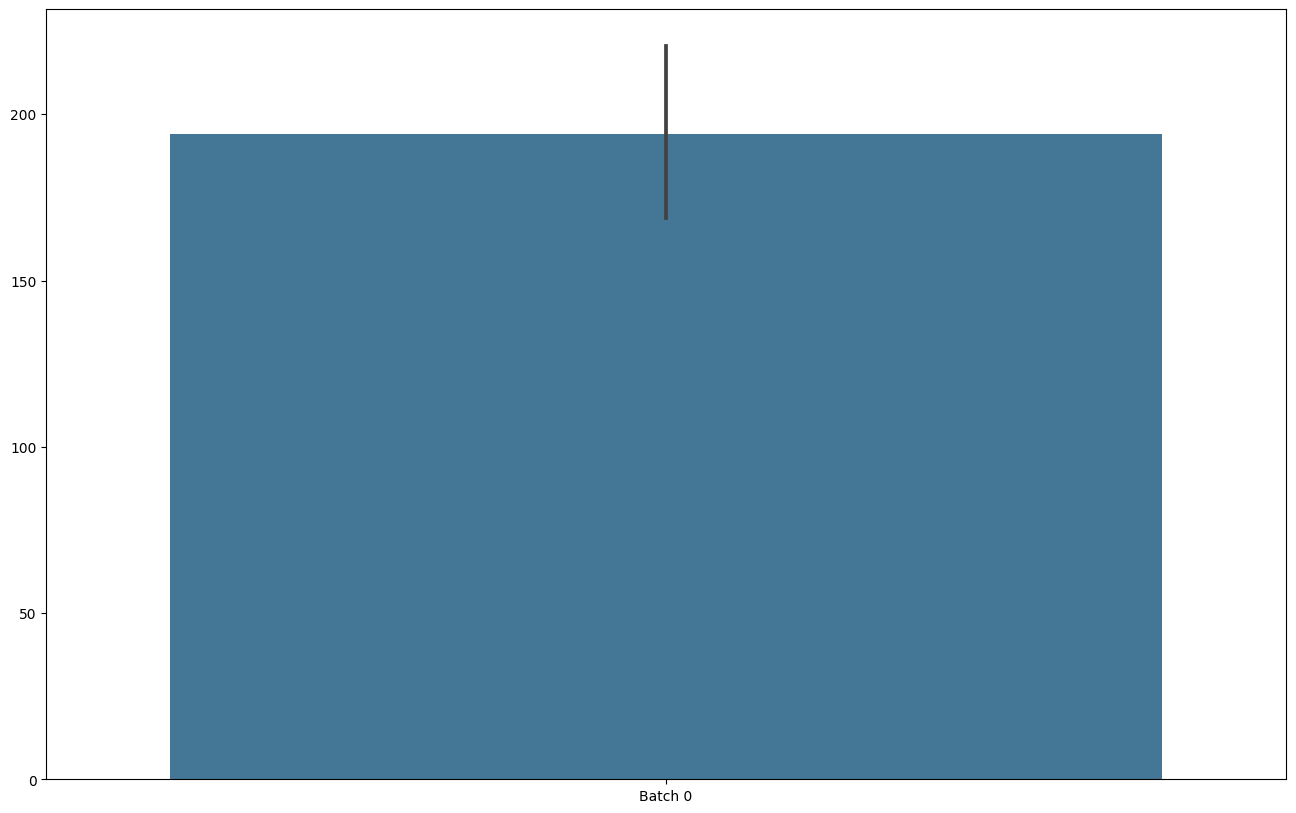

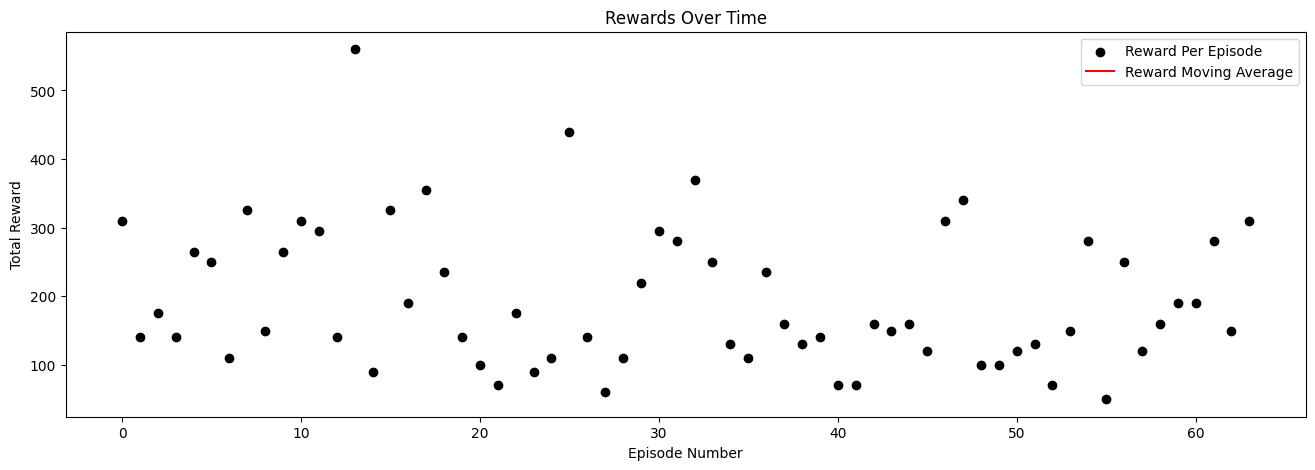

500                          
1000                         
1500                          
2000                          
2299                          
Episode 64 of 10240                

500                          
1000                         
1383                          
Episode 65 of 10240                

500                          
1000                         
1500                          
1574                          
Episode 66 of 10240                

500                          
1000                         
1500                          
1673                          
Episode 67 of 10240                

500                          
632                          
Episode 68 of 10240                

500                          
1000                         
1500                          
2000                          
2168                          
Episode 69 of 10240                

367                          
Episode 70 of 10240                

500       

2604                          
Episode 116 of 10240                

500                          
1000                         
1500                          
2000                          
2214                          
Episode 117 of 10240                

500                          
722                          
Episode 118 of 10240                

500                          
1000                         
1500                          
1963                          
Episode 119 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6089                          
Episode 120 of 10240                

500                          
604          

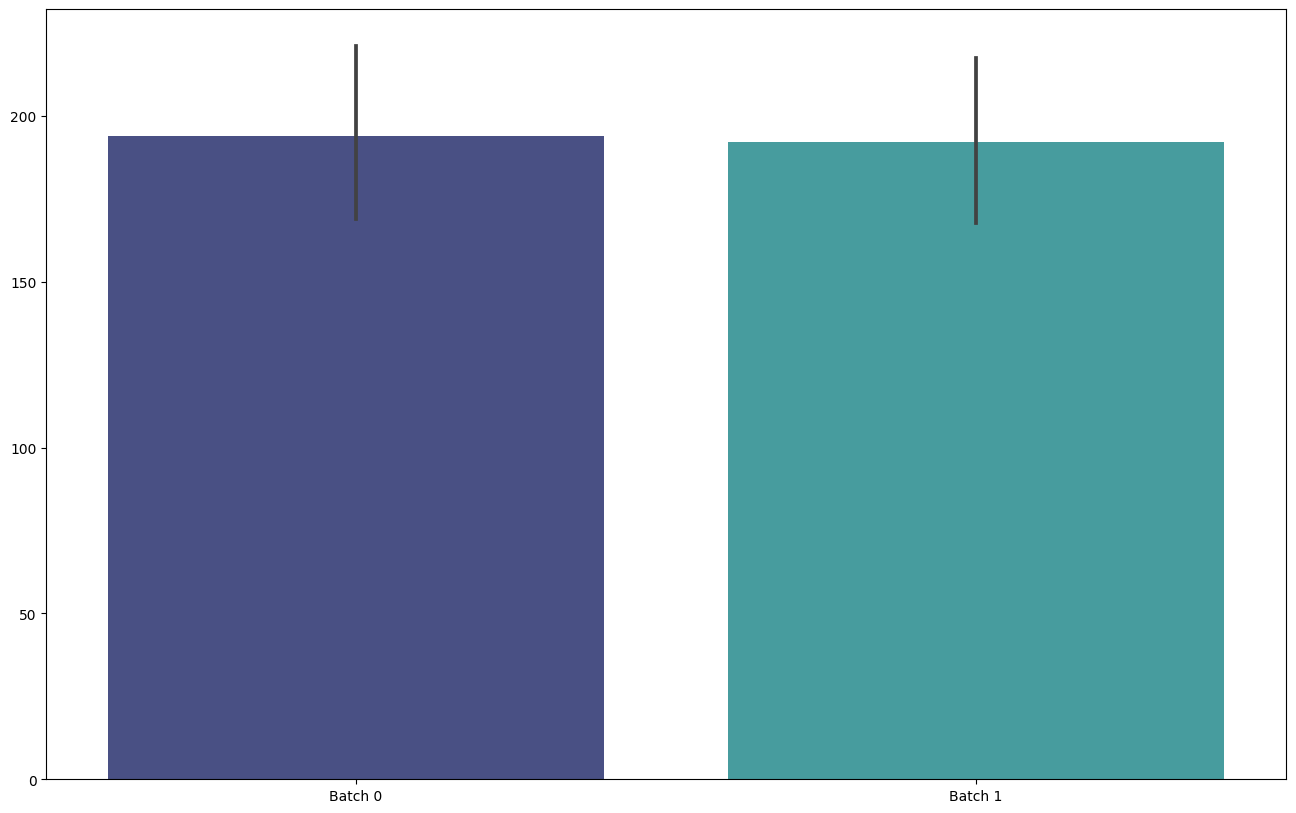

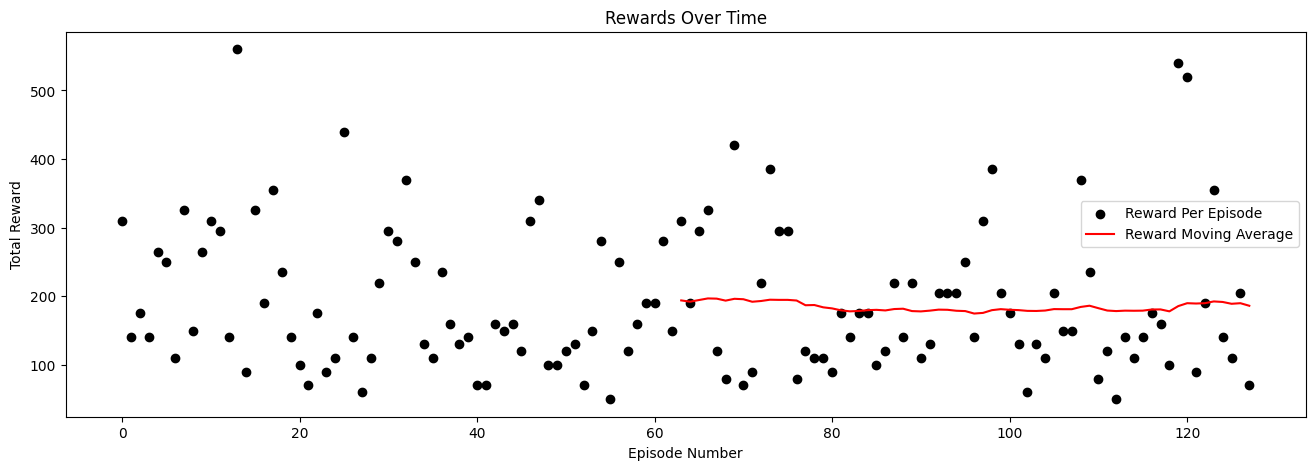

500                          
715                          
Episode 128 of 10240                

190                          
Episode 129 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4974                          
Episode 130 of 10240                

500                          
1000                         
1464                          
Episode 131 of 10240                

500                          
1000                         
1500                          
2000                          
2130                          
Episode 132 of 10240                

500                          
1000                         
1049                          
Episode 133 of 10240                

500                          
1000     

500                          
531                          
Episode 182 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3435                          
Episode 183 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2817                          
Episode 184 of 10240                

500                          
1000                         
1500                          
1624                          
Episode 185 of 10240                

500                          
1000                         
1500                          
2000                          
2309                          
Episode 186 of 10240                

500                          
639                          
Episode 187 of 1

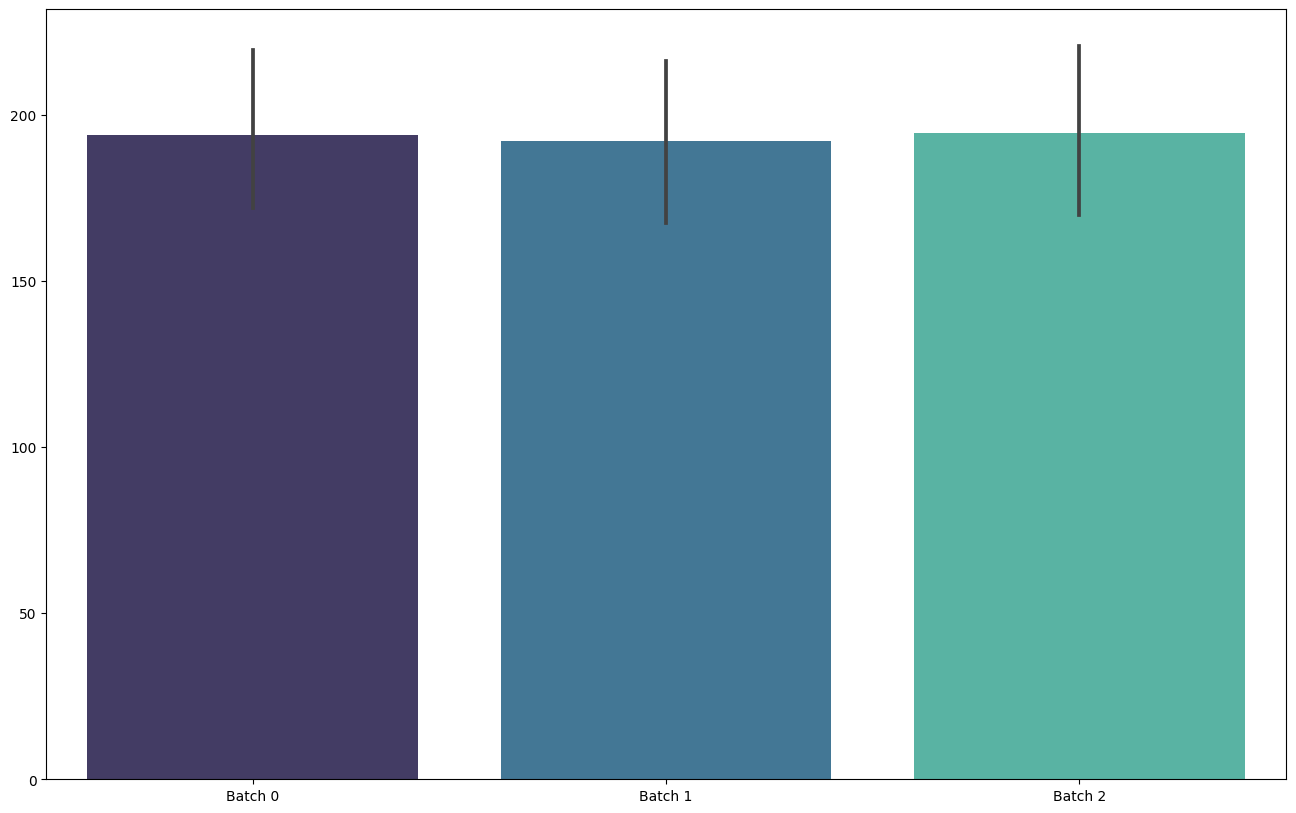

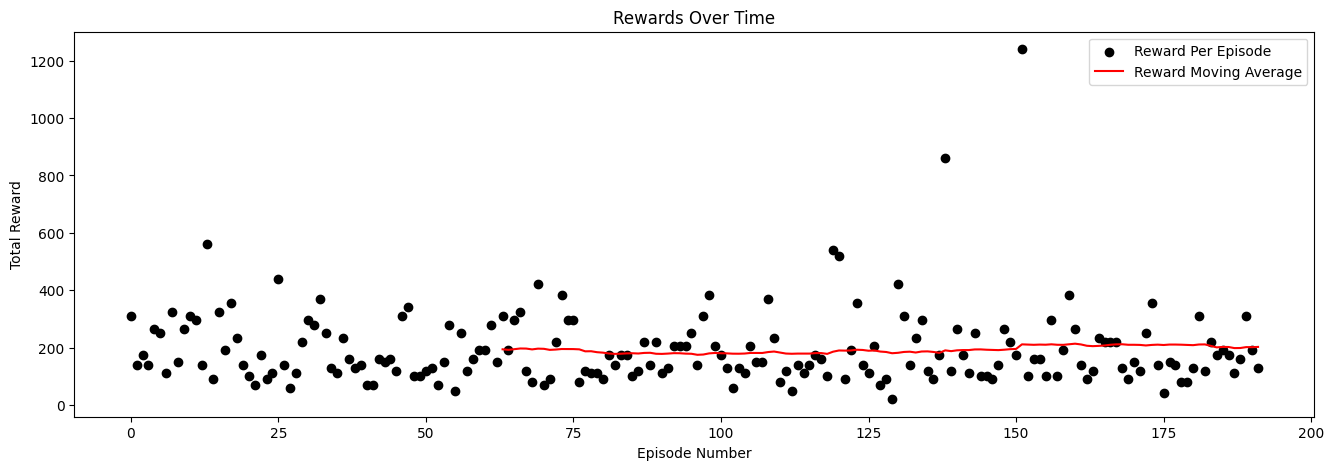

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3064                          
Episode 192 of 10240                

500                          
1000                         
1199                          
Episode 193 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4021                          
Episode 194 of 10240                

500                          
1000                         
1500                          
2000                          
2393                          
Episode 195 of 10240                

294                          
Episode 196 of 10240                

500                          
1000          

500                          
1000                         
1500                          
1965                          
Episode 233 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3193                          
Episode 234 of 10240                

500                          
733                          
Episode 235 of 10240                

500                          
639                          
Episode 236 of 10240                

500                          
1000                         
1295                          
Episode 237 of 10240                

500                          
1000                         
1210                          
Episode 238 of 10240                

500                          
1000                         
1500                          
1710                          
Episode 239

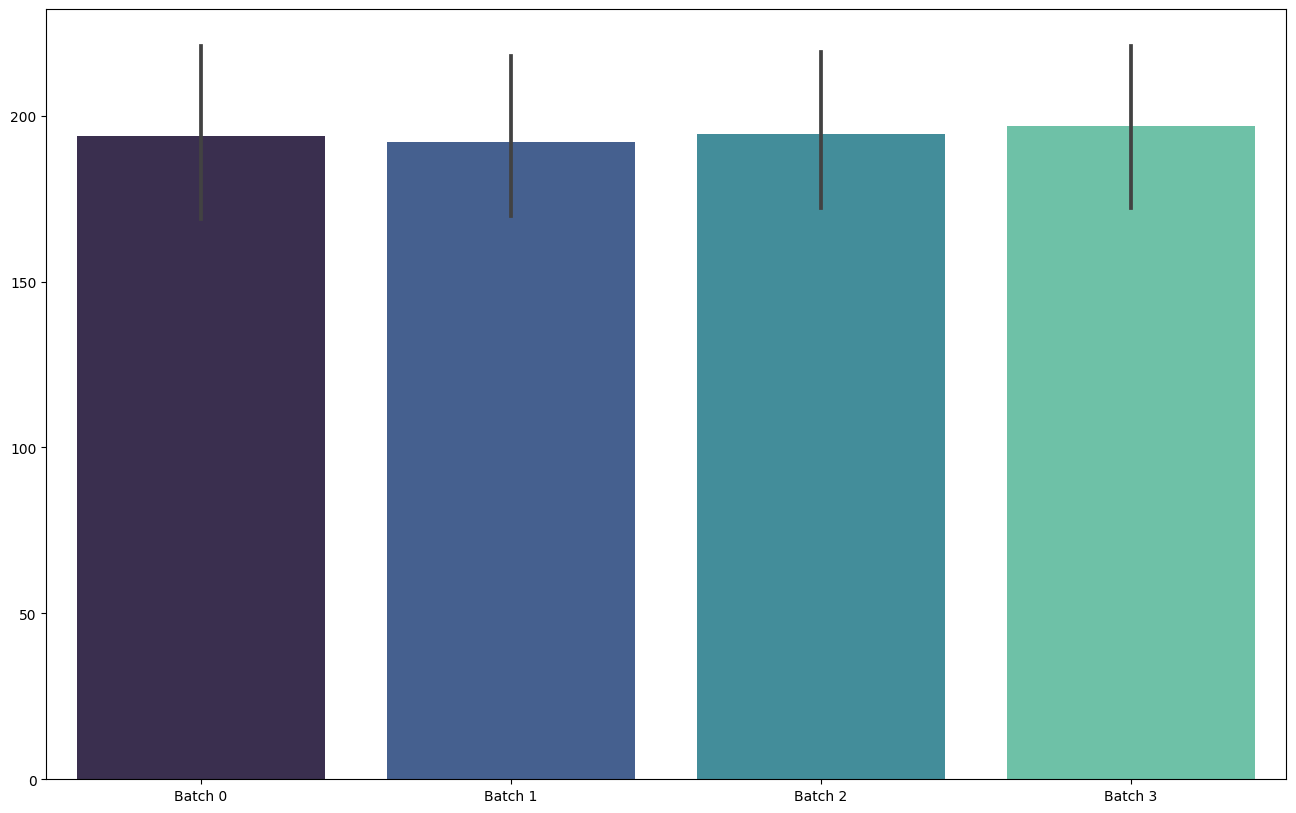

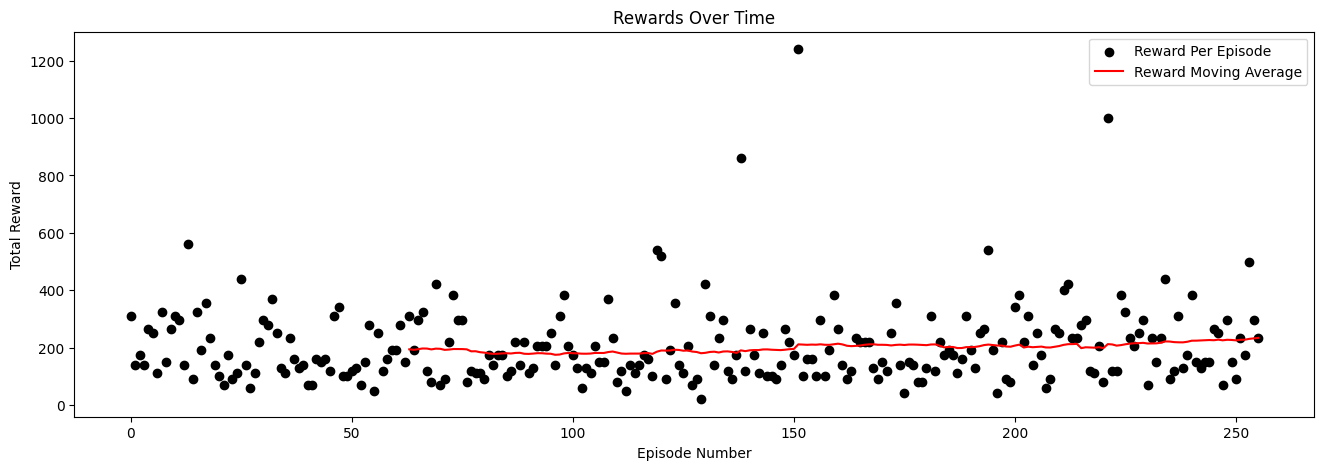

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3568                          
Episode 256 of 10240                

500                          
1000                         
1500                          
1666                          
Episode 257 of 10240                

500                          
892                          
Episode 258 of 10240                

479                          
Episode 259 of 10240                

500                          
1000                         
1500                          
1930                          
Episode 260 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000           

1500                          
2000                          
2500                          
3000                          
3488                          
Episode 307 of 10240                

500                          
1000                         
1289                          
Episode 308 of 10240                

500                          
1000                         
1185                          
Episode 309 of 10240                

500                          
770                          
Episode 310 of 10240                

500                          
1000                         
1024                          
Episode 311 of 10240                

500                          
1000                         
1500                          
1769                          
Episode 312 of 10240                

389                          
Episode 313 of 10240                

500                          
954                          
Episode 314 of 10240              

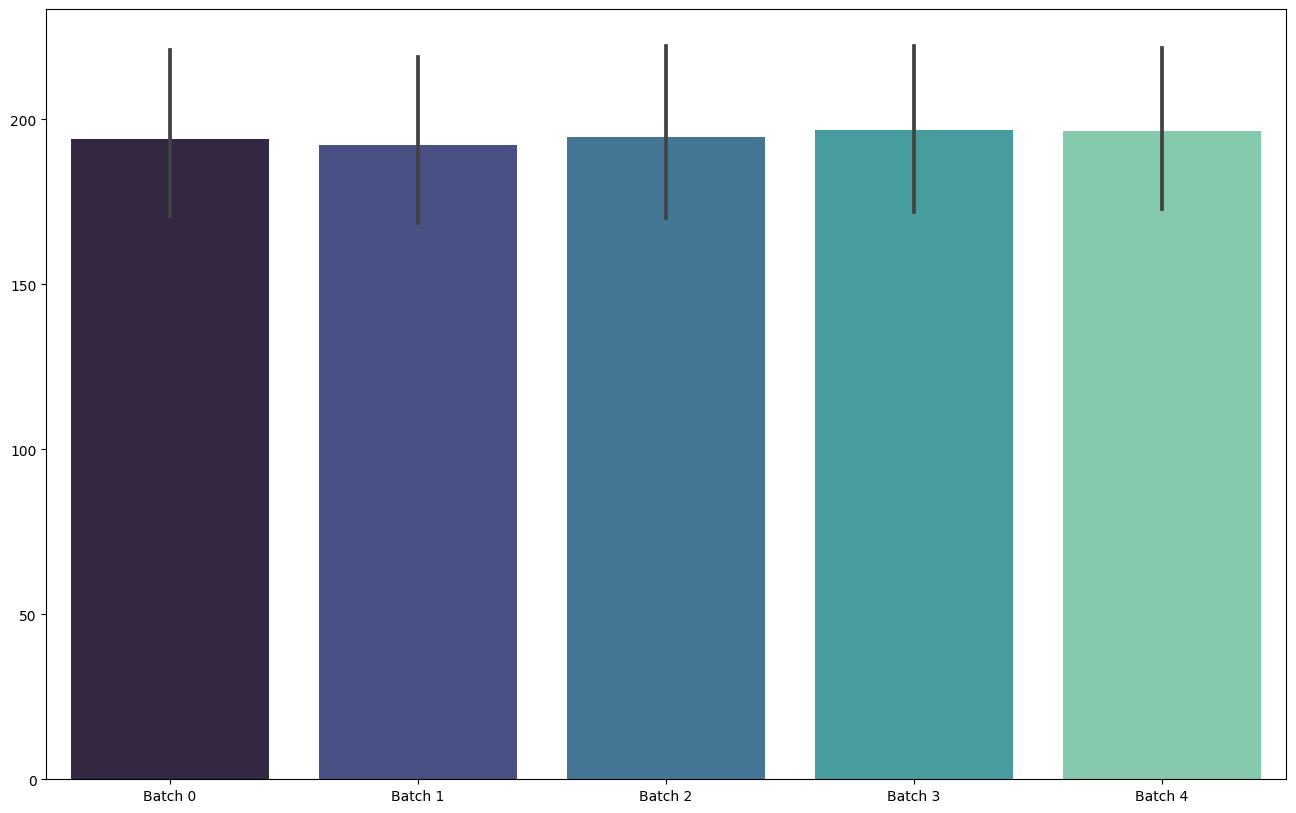

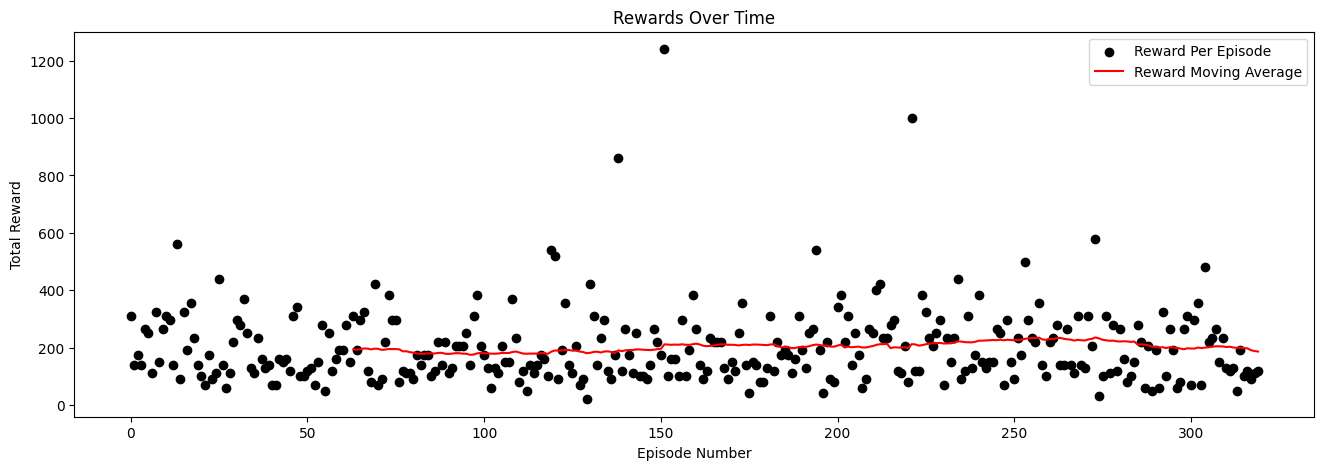

500                          
1000                         
1210                          
Episode 320 of 10240                

500                          
986                          
Episode 321 of 10240                

500                          
1000                         
1500                          
1961                          
Episode 322 of 10240                

500                          
1000                         
1500                          
1951                          
Episode 323 of 10240                

273                          
Episode 324 of 10240                

500                          
1000                         
1280                          
Episode 325 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3651                          
Episode 32

1500                          
2000                          
2500                          
2596                          
Episode 367 of 10240                

500                          
816                          
Episode 368 of 10240                

500                          
1000                         
1387                          
Episode 369 of 10240                

500                          
518                          
Episode 370 of 10240                

446                          
Episode 371 of 10240                

500                          
1000                         
1500                          
2000                          
2119                          
Episode 372 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2953                          
Episode 373 of 10240                

500                          
10

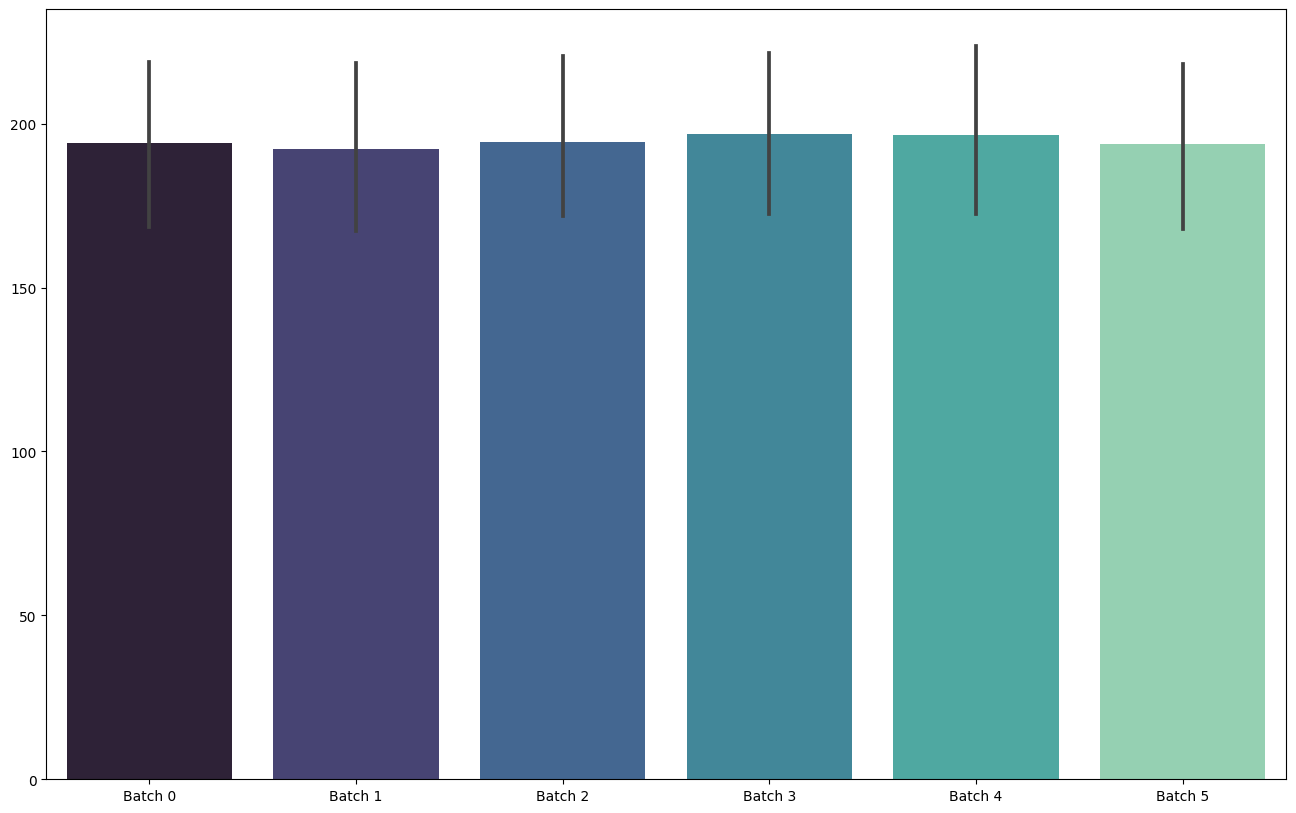

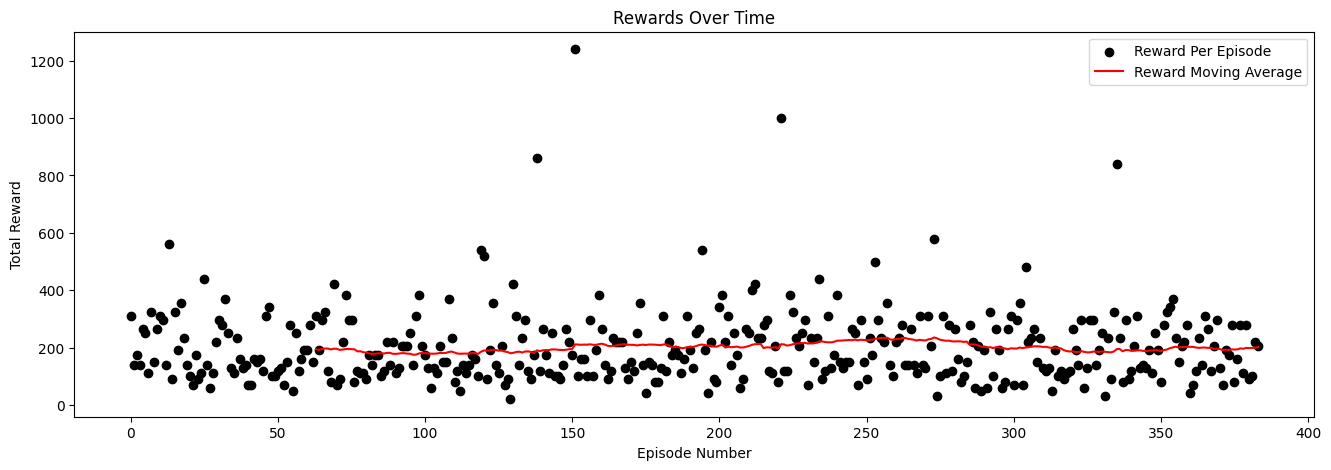

500                          
867                          
Episode 384 of 10240                

500                          
1000                         
1260                          
Episode 385 of 10240                

500                          
1000                         
1500                          
1663                          
Episode 386 of 10240                

500                          
1000                         
1500                          
2000                          
2320                          
Episode 387 of 10240                

500                          
664                          
Episode 388 of 10240                

500                          
640                          
Episode 389 of 10240                

500                          
1000                         
1500                          
1887                          
Episode 390 of 10240                

480                          
Episode 391 of 10240                

500                          
1000                         
1500                          
2000                          
2281                          
Episode 438 of 10240                

500                          
1000                         
1500                          
1909                          
Episode 439 of 10240                

500                          
1000                         
1179                          
Episode 440 of 10240                

500                          
734                          
Episode 441 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2648                          
Episode 442 of 10240                

500                          
1000                         
1500                          
2000                          
2122                          
Episode 443 of 10240                

500      

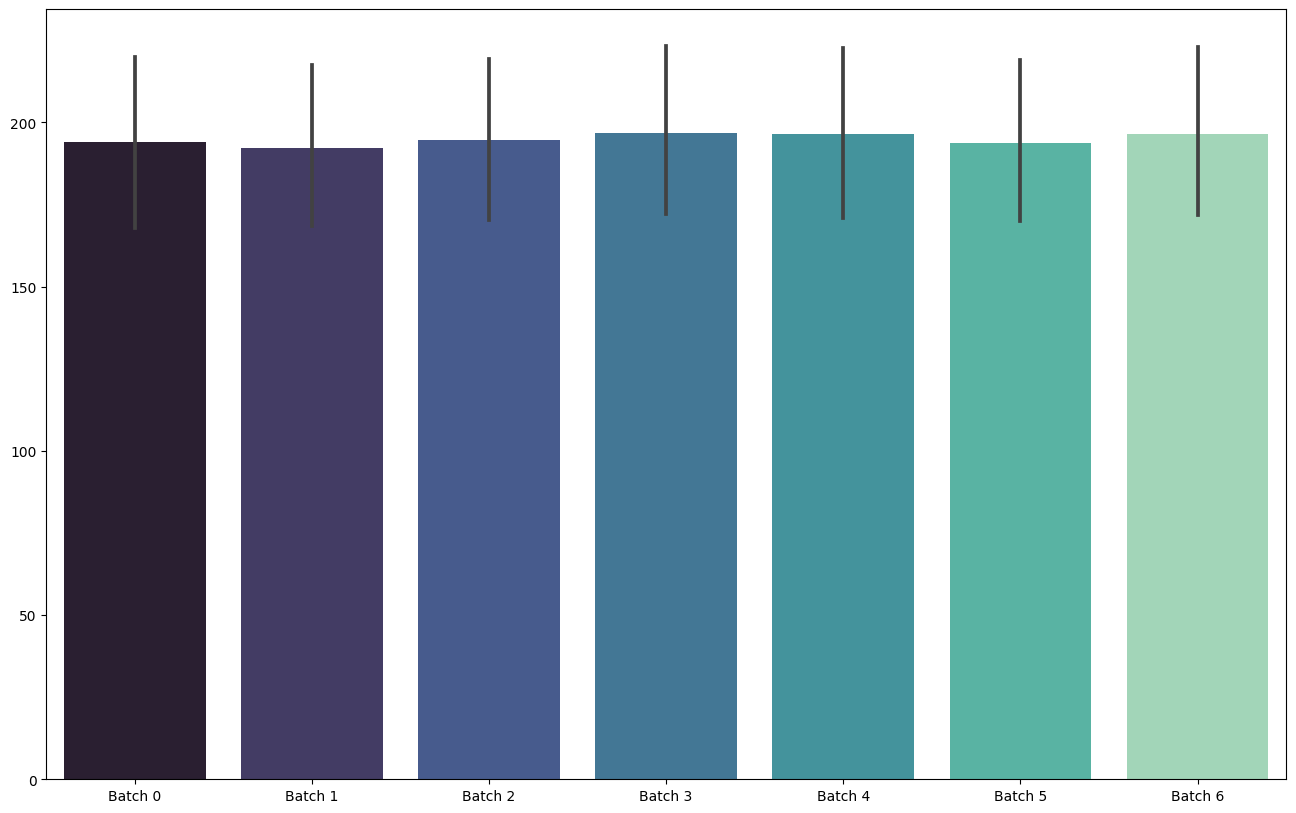

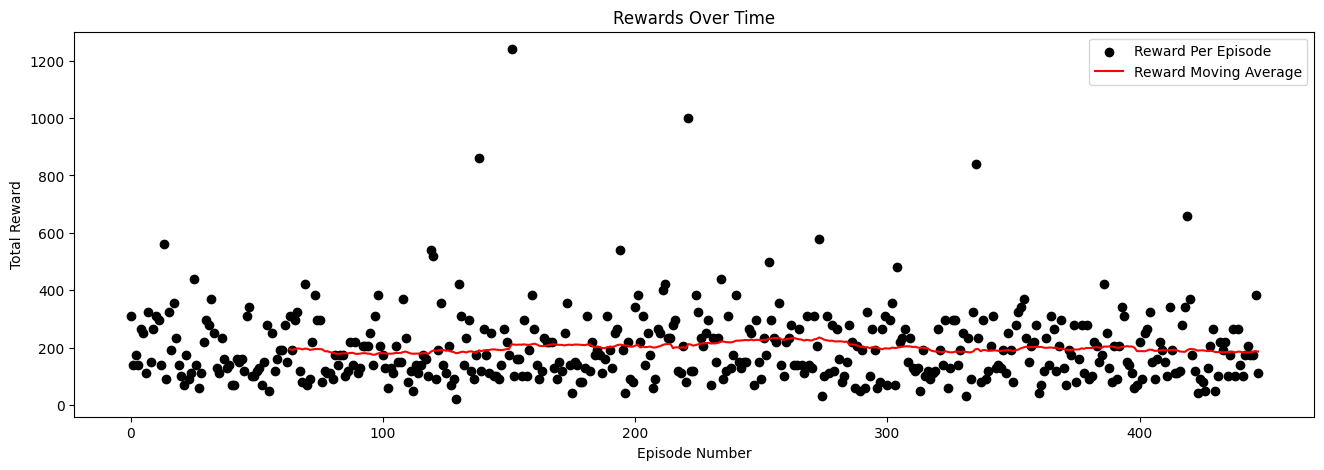

500                          
1000                         
1500                          
2000                          
2500                          
2617                          
Episode 448 of 10240                

500                          
1000                         
1500                          
1791                          
Episode 449 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4180                          
Episode 450 of 10240                

500                          
1000                         
1498                          
Episode 451 of 10240                

500                          
818                          
Episode 452 of 10240                

500                          
1000                         
1089            

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3632                          
Episode 494 of 10240                

500                          
1000                         
1500                          
2000                          
2132                          
Episode 495 of 10240                

500                          
646                          
Episode 496 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4535                          
Episode 497 of 10240                

500                          
767                          
Episode 498 of 10240 

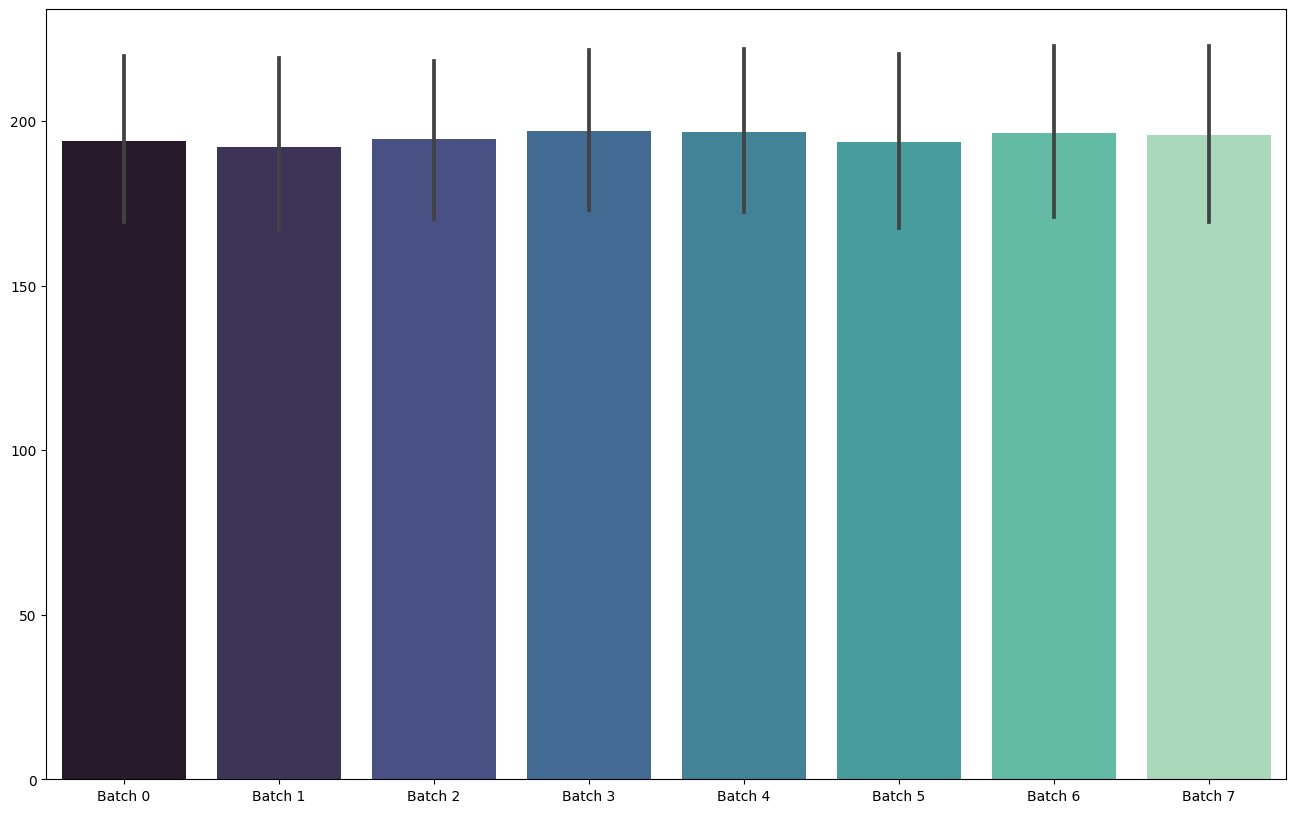

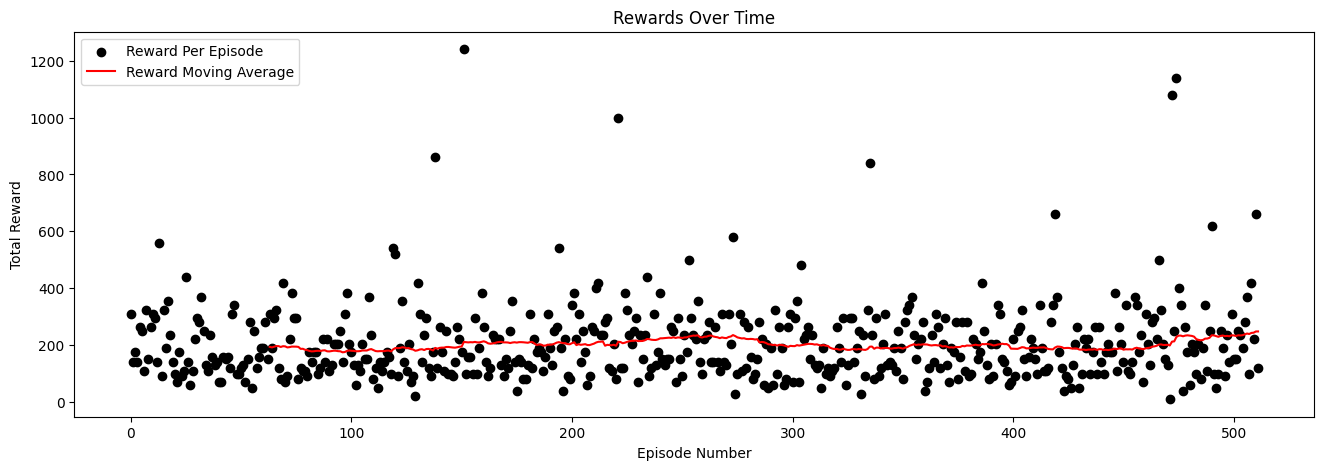

500                          
1000                         
1500                          
2000                          
2412                          
Episode 512 of 10240                

500                          
1000                         
1085                          
Episode 513 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
8000                          
8041                          
Episode 514 of 10240                

500                          
1000                         
1500                          
1850                      

500                          
620                          
Episode 558 of 10240                

500                          
1000                         
1500                          
1965                          
Episode 559 of 10240                

500                          
815                          
Episode 560 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3851                          
Episode 561 of 10240                

500                          
1000                         
1500                          
2000                          
2342                          
Episode 562 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000            

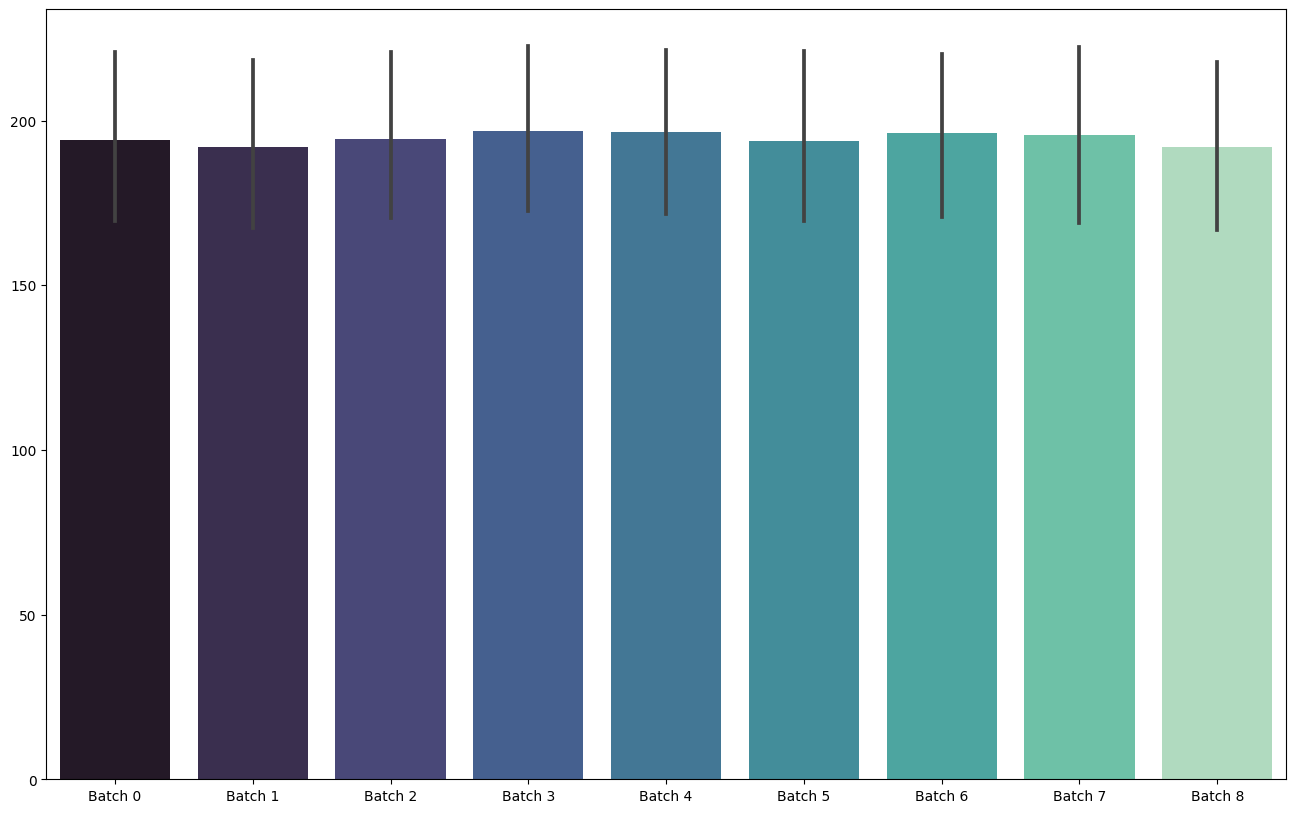

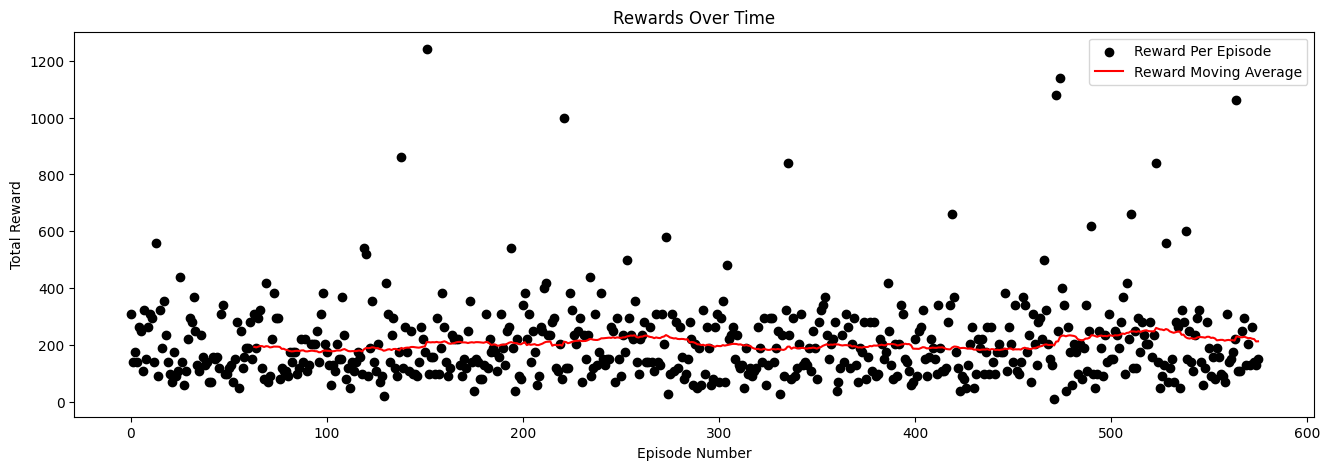

500                          
1000                         
1500                          
2000                          
2500                          
2677                          
Episode 576 of 10240                

500                          
956                          
Episode 577 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4730                          
Episode 578 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3358                          
Episode 579 of 10240                

500                          
1000                         
1226                 

1000                         
1500                          
2000                          
2500                          
3000                          
3142                          
Episode 620 of 10240                

500                          
1000                         
1500                          
1635                          
Episode 621 of 10240                

500                          
1000                         
1500                          
1578                          
Episode 622 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5231                          
Episode 623 of 10240                

500                          
1000                         
1291                

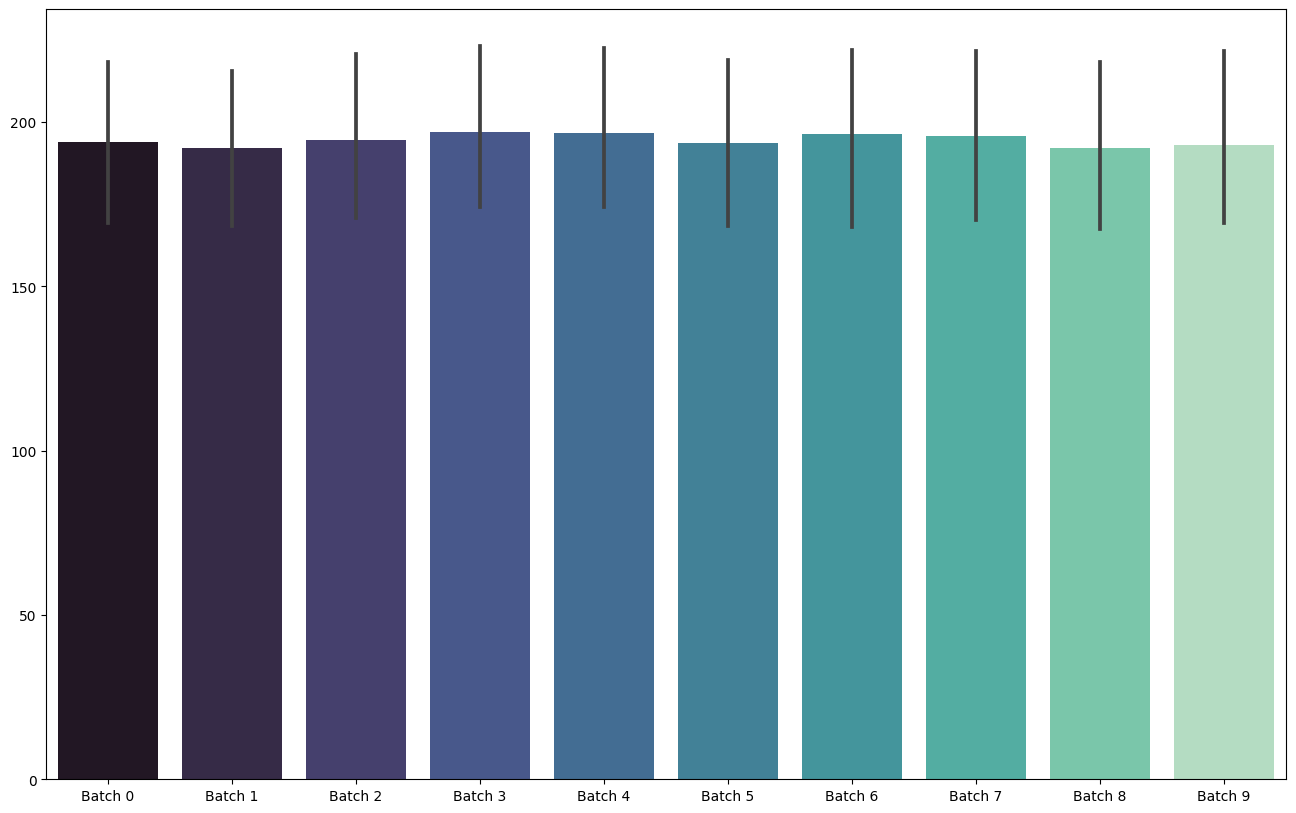

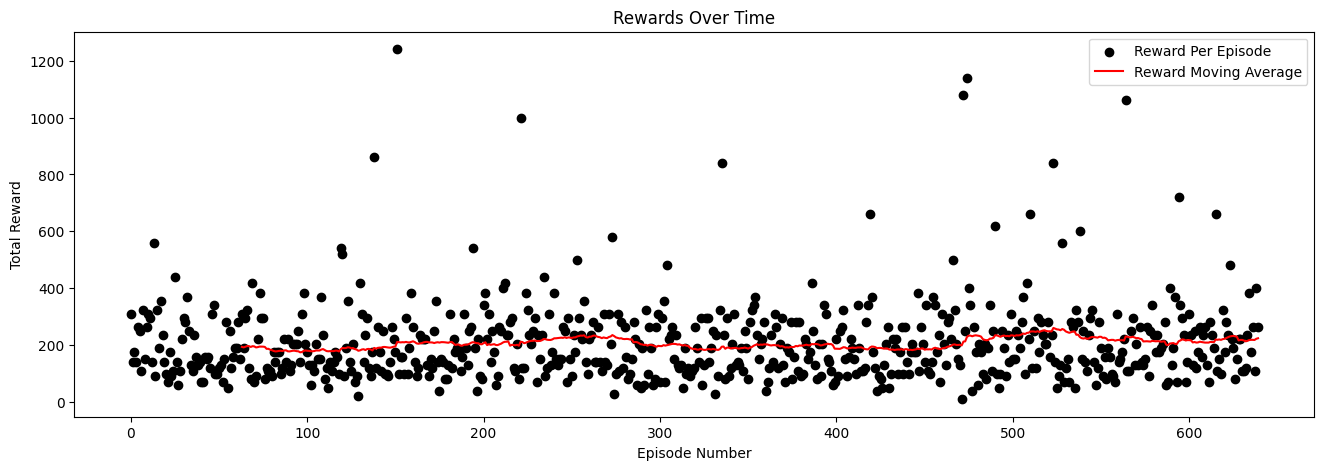

500                          
529                          
Episode 640 of 10240                

500                          
942                          
Episode 641 of 10240                

500                          
707                          
Episode 642 of 10240                

500                          
686                          
Episode 643 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3790                          
Episode 644 of 10240                

500                          
685                          
Episode 645 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2665                          
Episode 646 of 10240                

500 

3500                          
3899                          
Episode 685 of 10240                

500                          
1000                         
1459                          
Episode 686 of 10240                

500                          
994                          
Episode 687 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2718                          
Episode 688 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2918                          
Episode 689 of 10240                

500                          
692                          
Episode 690 of 10240                

500                          
1000                         
1316                          
Episode 691 of 10240                

50

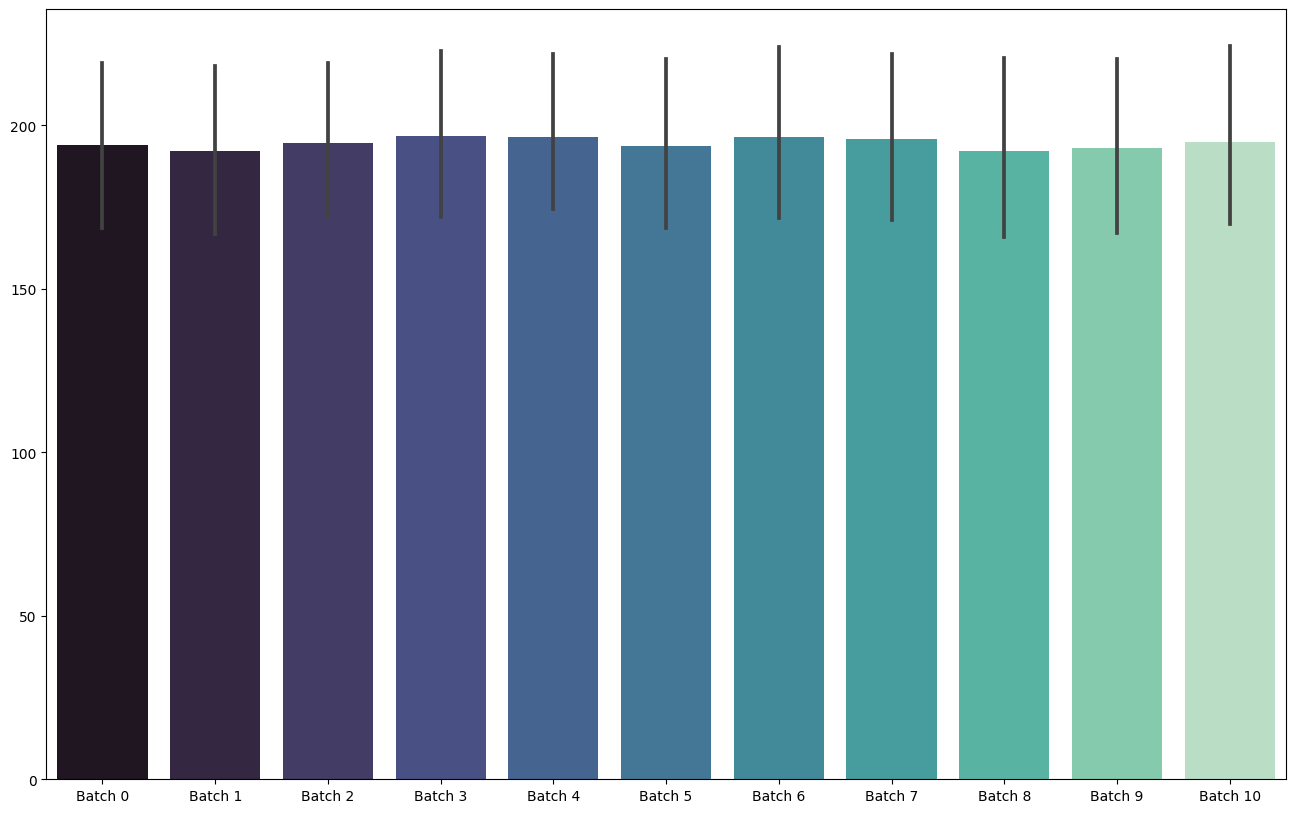

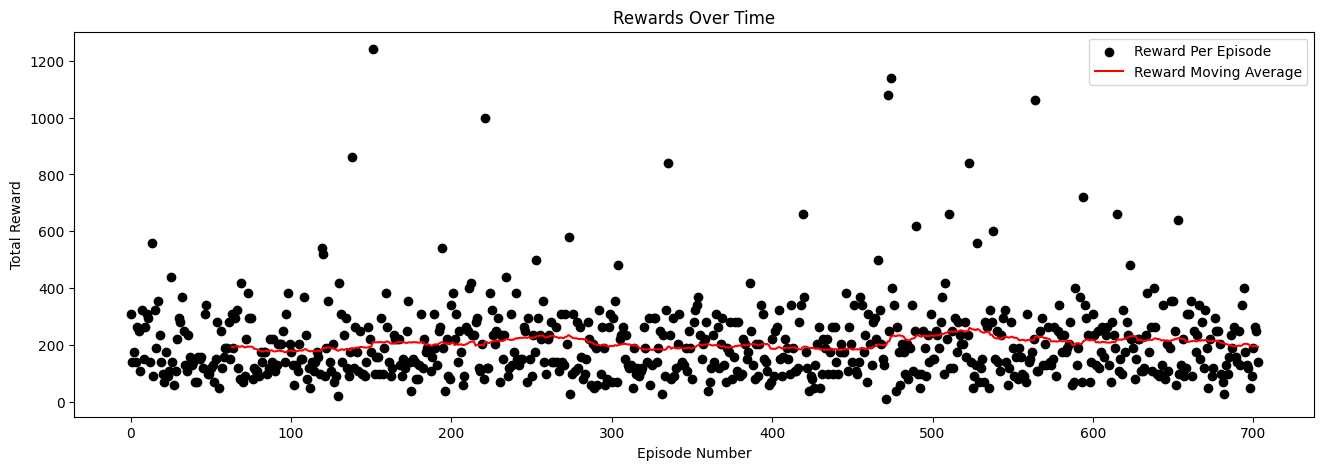

500                          
1000                         
1500                          
2000                          
2500                          
2825                          
Episode 704 of 10240                

500                          
1000                         
1485                          
Episode 705 of 10240                

500                          
996                          
Episode 706 of 10240                

500                          
1000                         
1500                          
2000                          
2459                          
Episode 707 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2848                          
Episode 708 of 10240                

500                          
807                          
Episode 709 of 10240                

500                          
1000      

2500                          
2534                          
Episode 748 of 10240                

500                          
1000                         
1500                          
2000                          
2300                          
Episode 749 of 10240                

500                          
1000                         
1343                          
Episode 750 of 10240                

500                          
1000                         
1500                          
1557                          
Episode 751 of 10240                

500                          
647                          
Episode 752 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4920                          
Episode 753 of

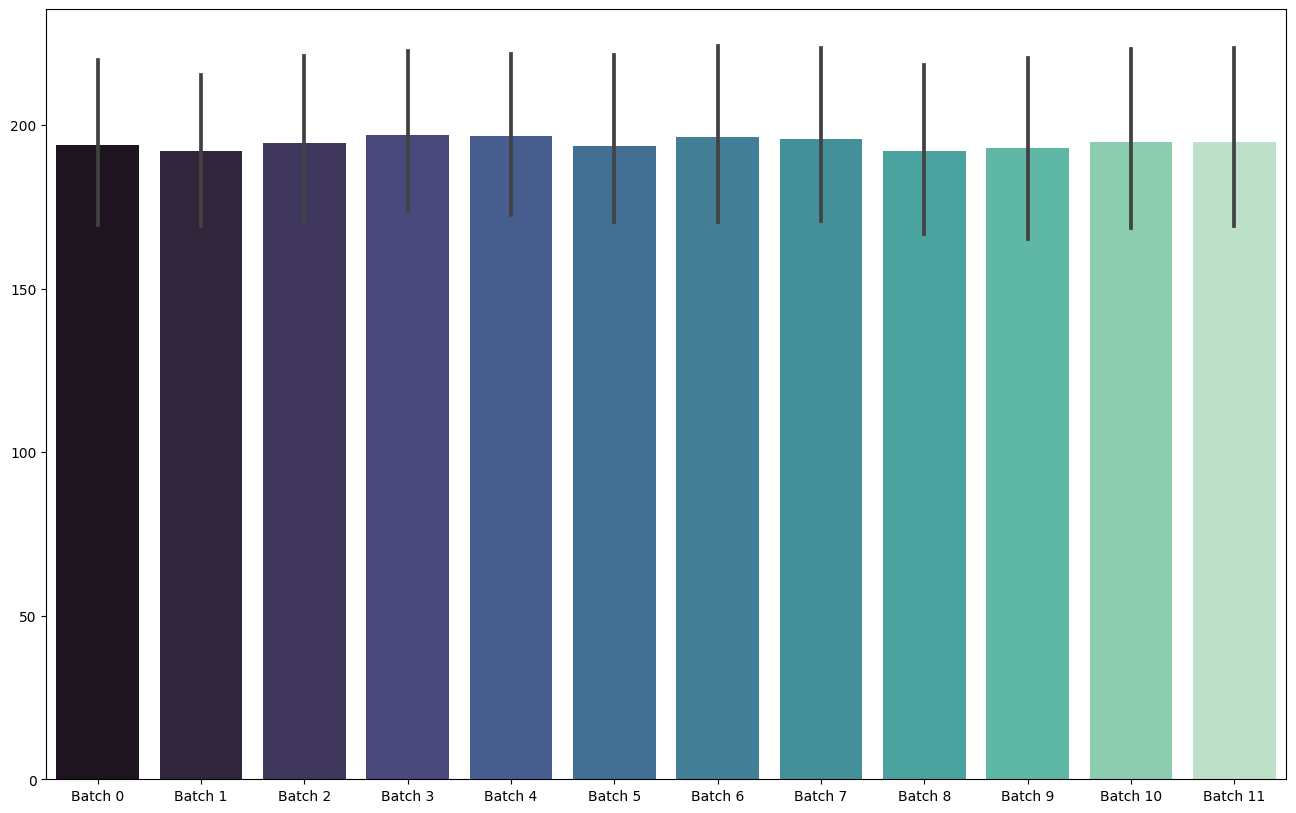

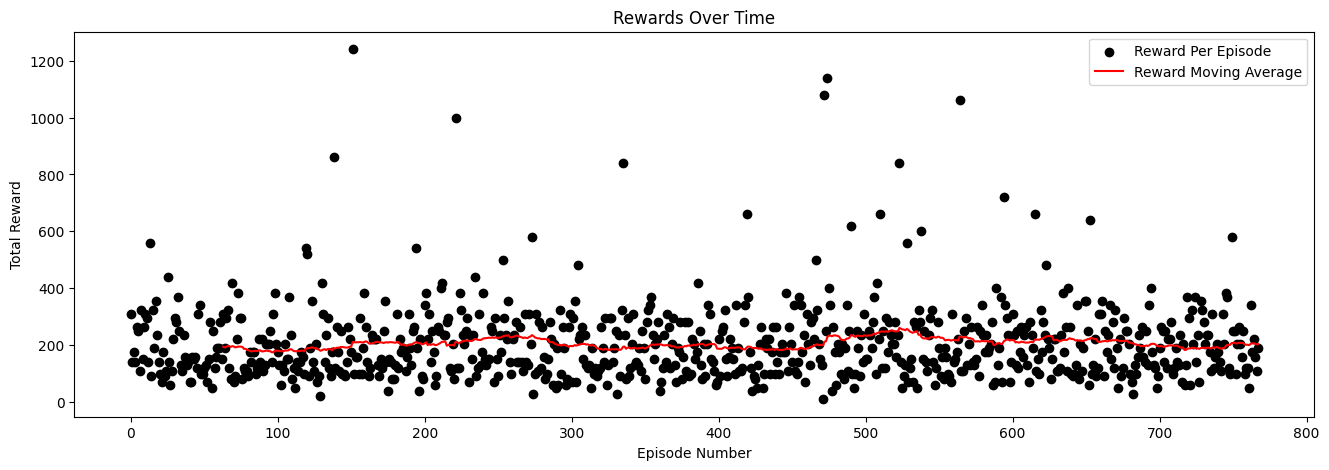

500                          
544                          
Episode 768 of 10240                

500                          
1000                         
1335                          
Episode 769 of 10240                

500                          
1000                         
1500                          
1872                          
Episode 770 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
5695                          
Episode 771 of 10240                

500                          
1000                         
1092                          
Episode 772 of 10240                

500                          
1000                         
1500            

1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3611                          
Episode 803 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6318                          
Episode 804 of 10240                

500                          
1000                         
1500                          
1676                          
Episode 805 of 10240                

458                          
Episode 806 of 10240                

500                          
1000                         
1500               

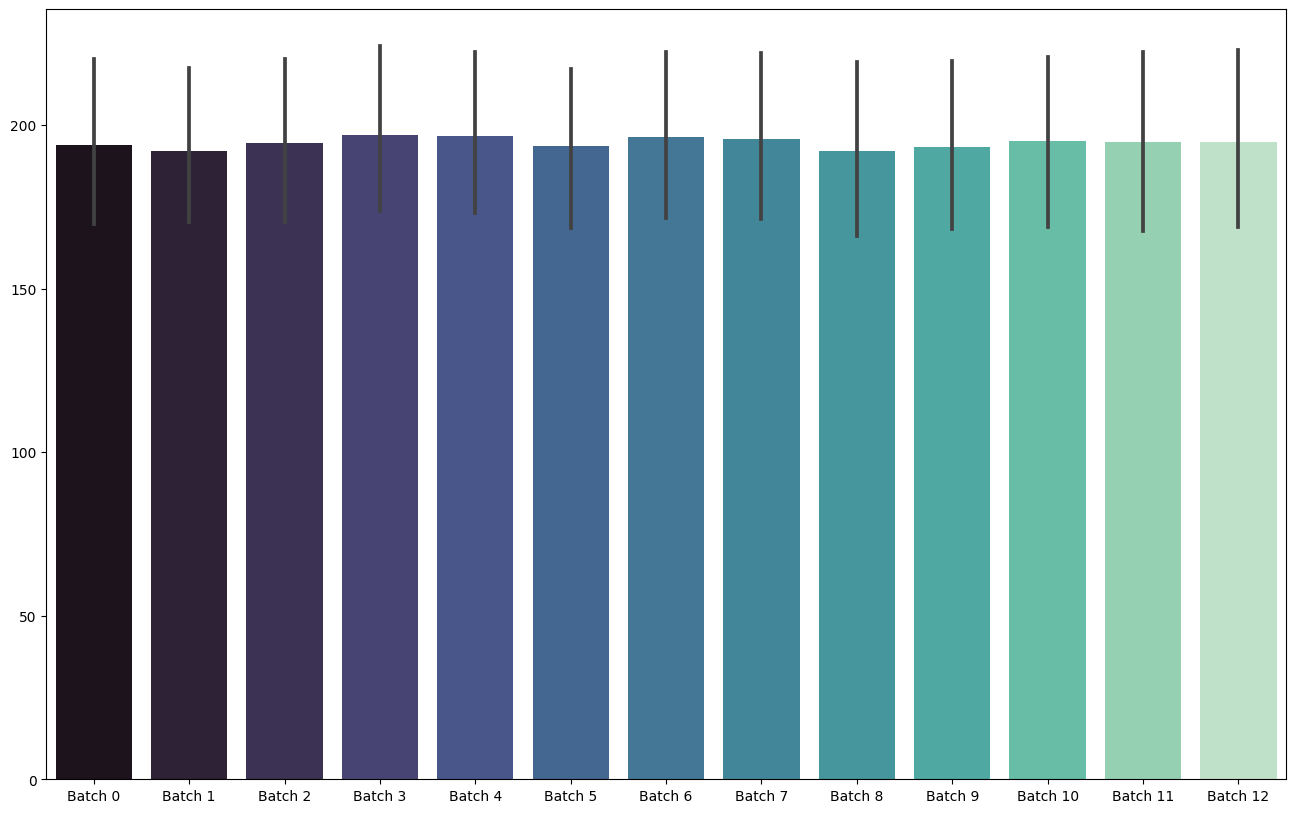

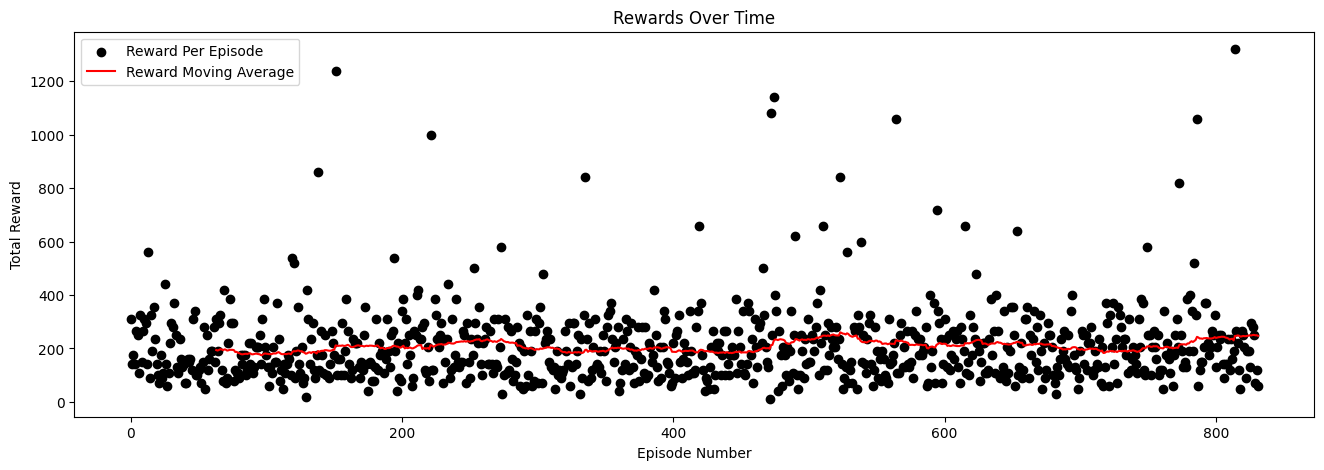

500                          
1000                         
1500                          
2000                          
2500                          
2837                          
Episode 832 of 10240                

500                          
1000                         
1228                          
Episode 833 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
6629                          
Episode 834 of 10240                

500                          
1000                         
1500                          
1833                          
Episode 835 of 10240                

500                

1500                          
2000                          
2500                          
2887                          
Episode 873 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3418                          
Episode 874 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3983                          
Episode 875 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                    

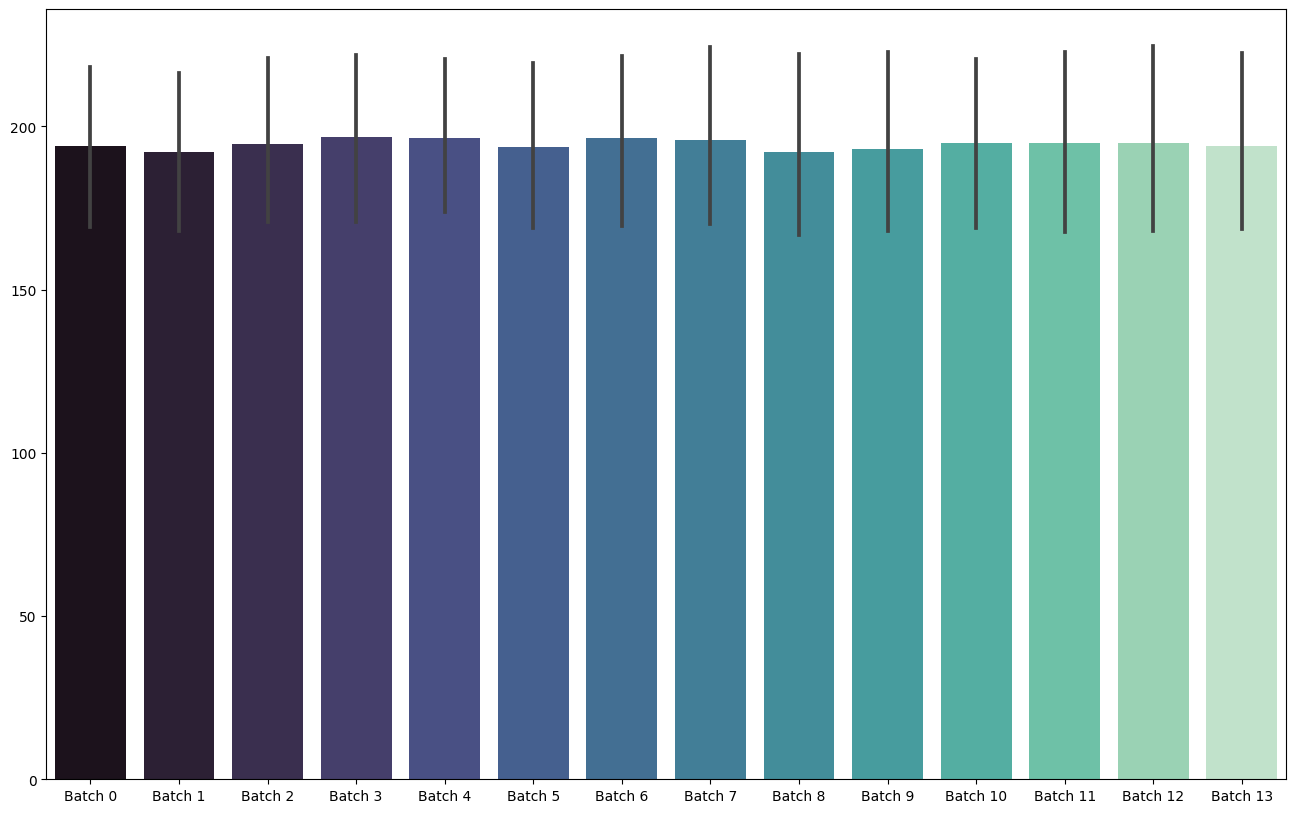

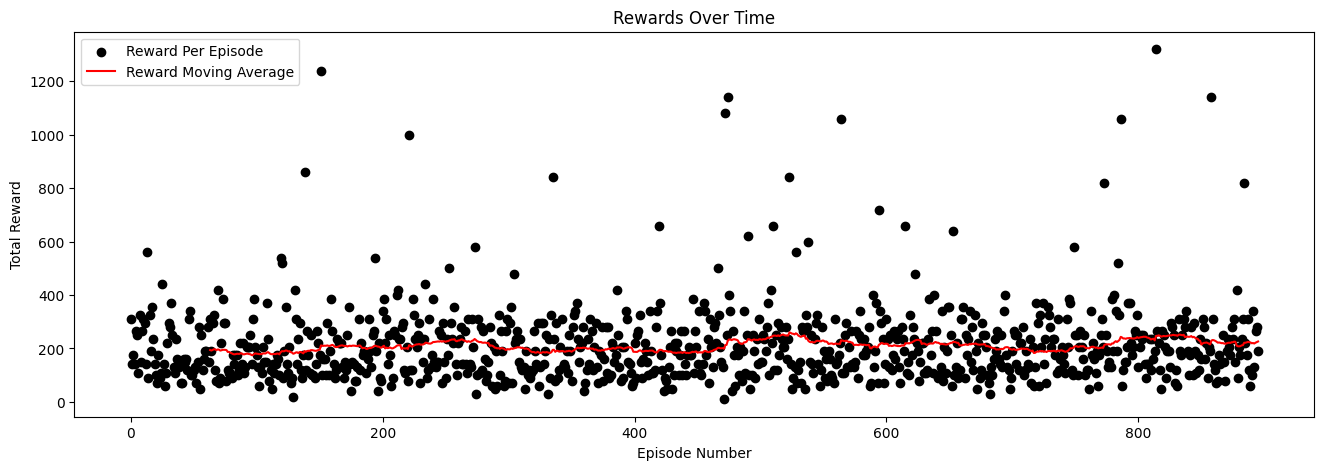

500                          
1000                         
1500                          
2000                          
2056                          
Episode 896 of 10240                

500                          
843                          
Episode 897 of 10240                

500                          
930                          
Episode 898 of 10240                

450                          
Episode 899 of 10240                

500                          
766                          
Episode 900 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4720                          
Episode 901 of 10240                

500                          
823                          
Episode 902 of 10240                

500

2000                          
2500                          
3000                          
3119                          
Episode 943 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3747                          
Episode 944 of 10240                

500                          
729                          
Episode 945 of 10240                

500                          
517                          
Episode 946 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5423                          
Episode 947 of 1024

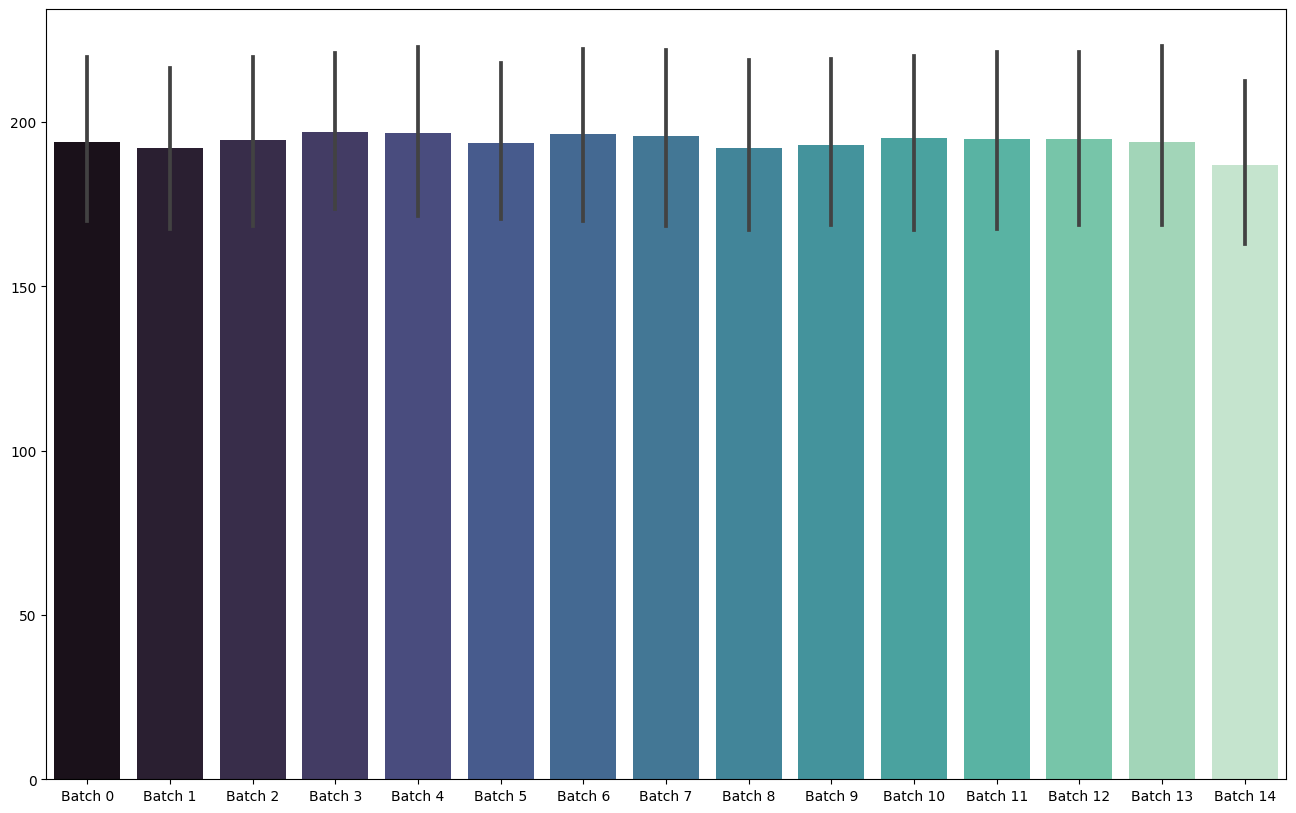

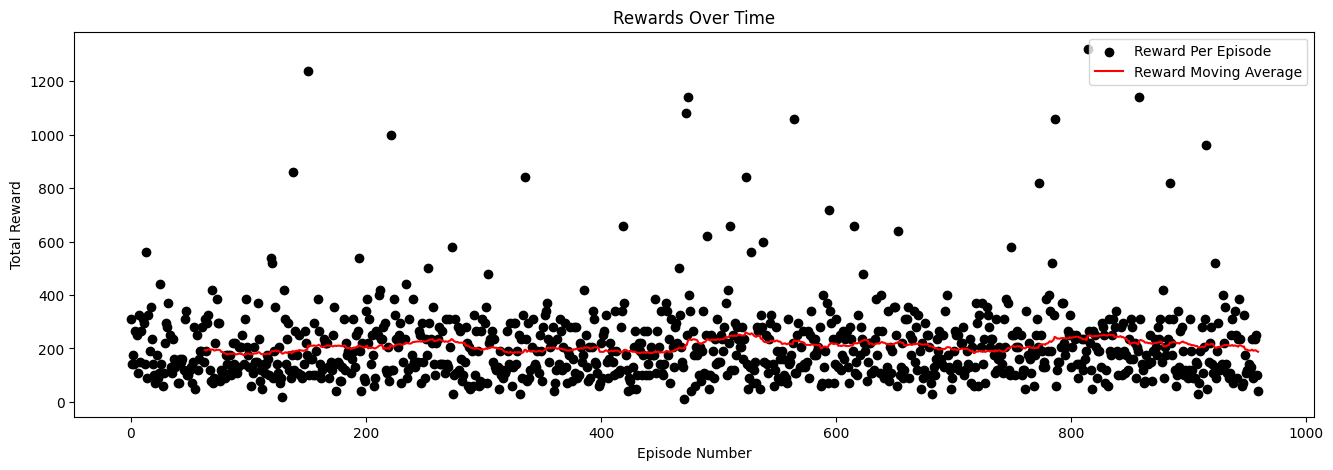

500                          
1000                         
1500                          
1643                          
Episode 960 of 10240                

500                          
1000                         
1500                          
1736                          
Episode 961 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3056                          
Episode 962 of 10240                

500                          
1000                         
1500                          
2000                          
2485                          
Episode 963 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                 

3500                          
4000                          
4500                          
4857                          
Episode 999 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3947                          
Episode 1000 of 10240                

293                          
Episode 1001 of 10240                

500                          
1000                         
1500                          
1526                          
Episode 1002 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2753                          
Episode 1003 of 10240                

500                          
1000                         
1500                          
1649     

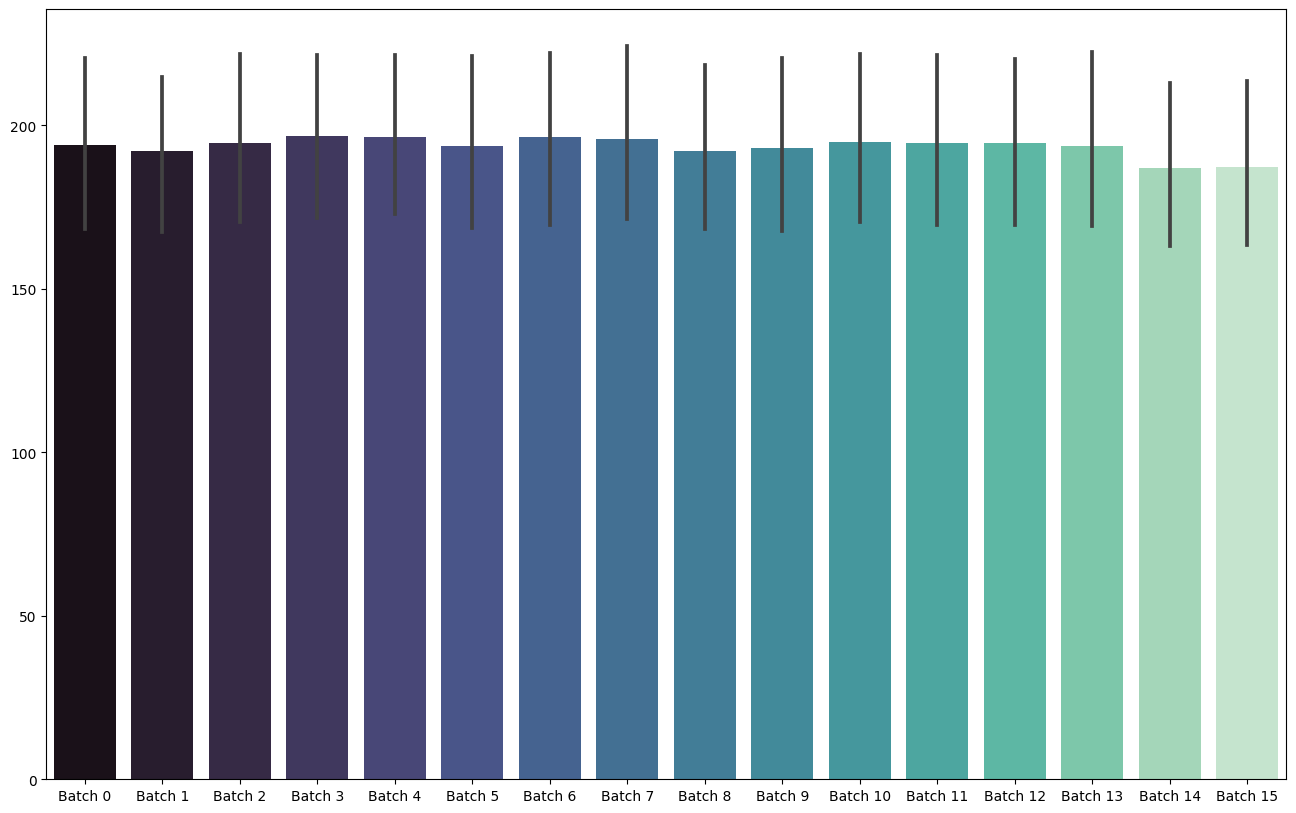

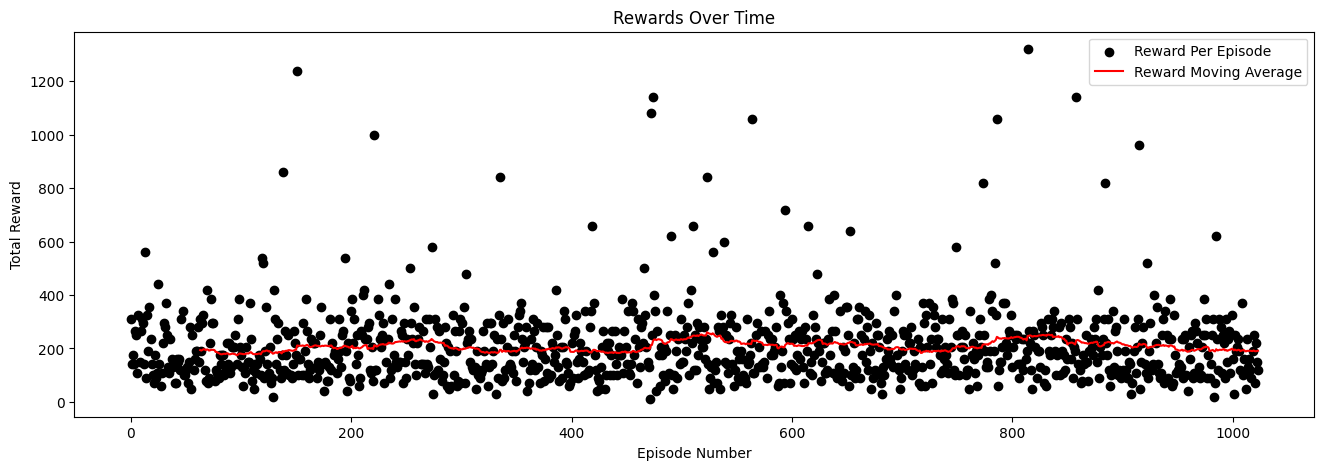

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
5563                          
Episode 1024 of 10240                

500                          
957                          
Episode 1025 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3103                          
Episode 1026 of 10240                

500                          
1000                         
1500                          
2000                          
2397                          
Episode 1027 of 10240                

500                          
1000            

1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4057                          
Episode 1069 of 10240                

401                          
Episode 1070 of 10240                

500                          
755                          
Episode 1071 of 10240                

500                          
861                          
Episode 1072 of 10240                

500                          
1000                         
1082                          
Episode 1073 of 10240                

500                          
1000                         
1500                          
2000                          
2211                          
Episode 1074 of 10240                

500                          
690                          
Episode 1075 of 10240                

500                       

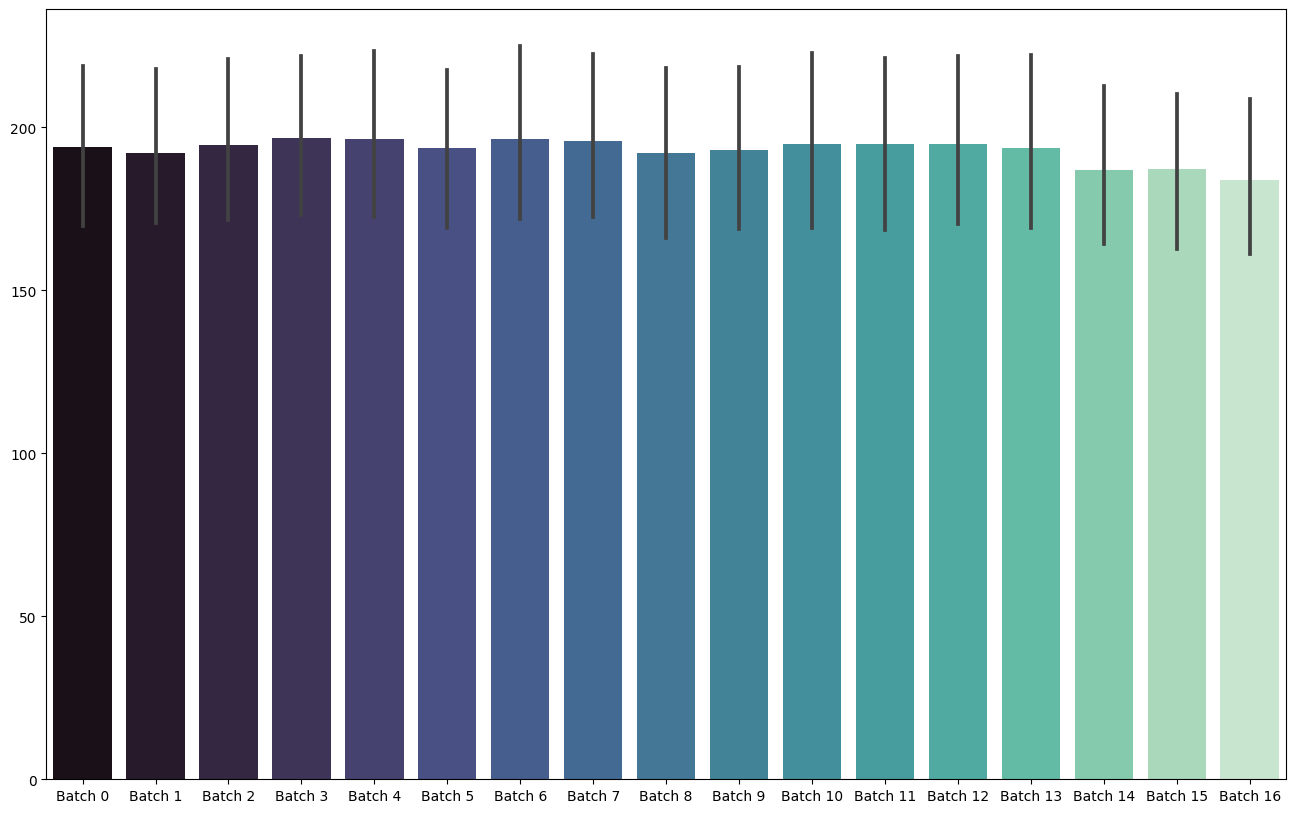

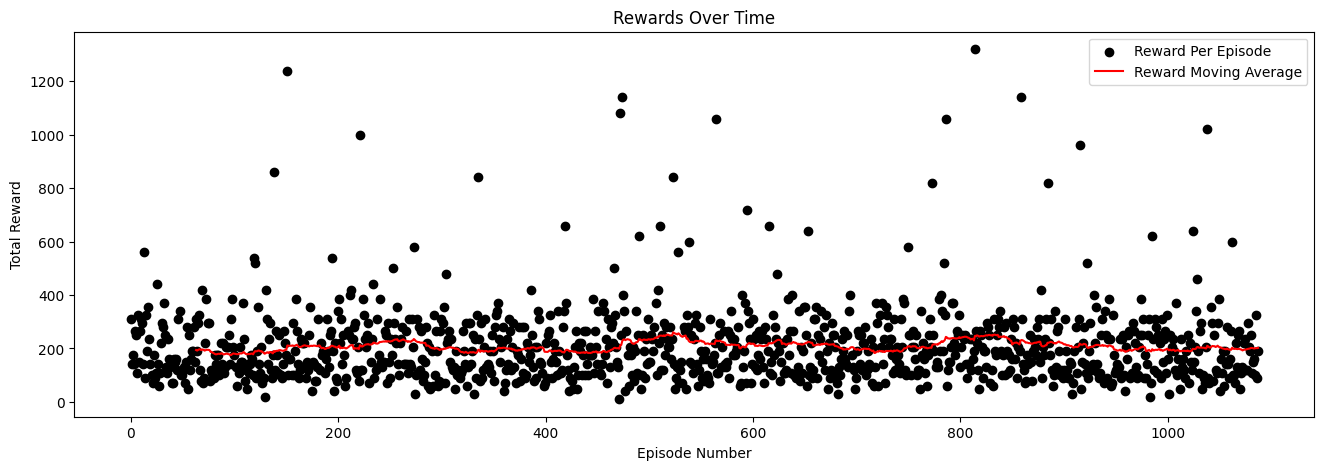

500                          
985                          
Episode 1088 of 10240                

500                          
734                          
Episode 1089 of 10240                

500                          
1000                         
1261                          
Episode 1090 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4534                          
Episode 1091 of 10240                

500                          
987                          
Episode 1092 of 10240                

500                          
1000                         
1156                          
Episode 1093 of 10240                

500                          
1000                         
1500                          
1695 

4000                          
4500                          
4863                          
Episode 1133 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4539                          
Episode 1134 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6496                          
Episode 1135 of 10240                

500                          
1000                         
1021                 

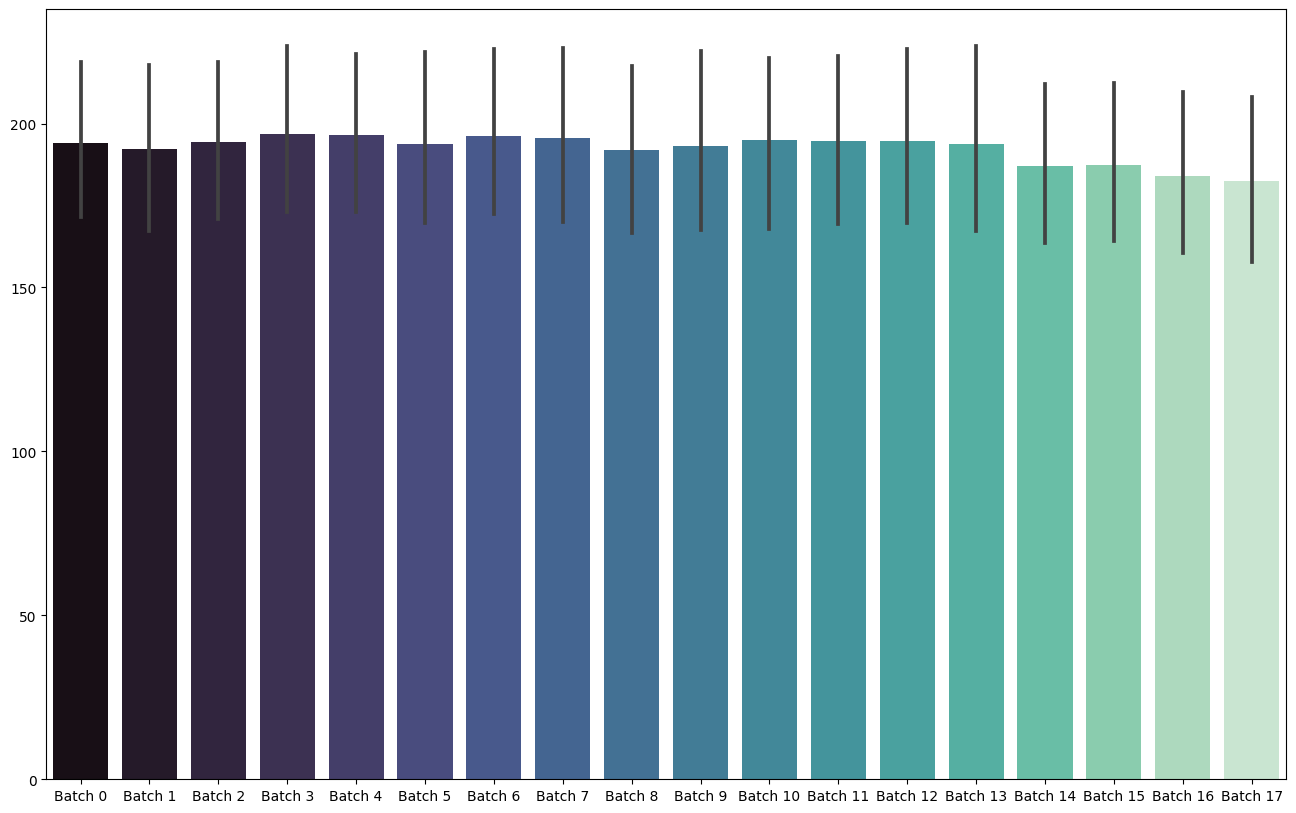

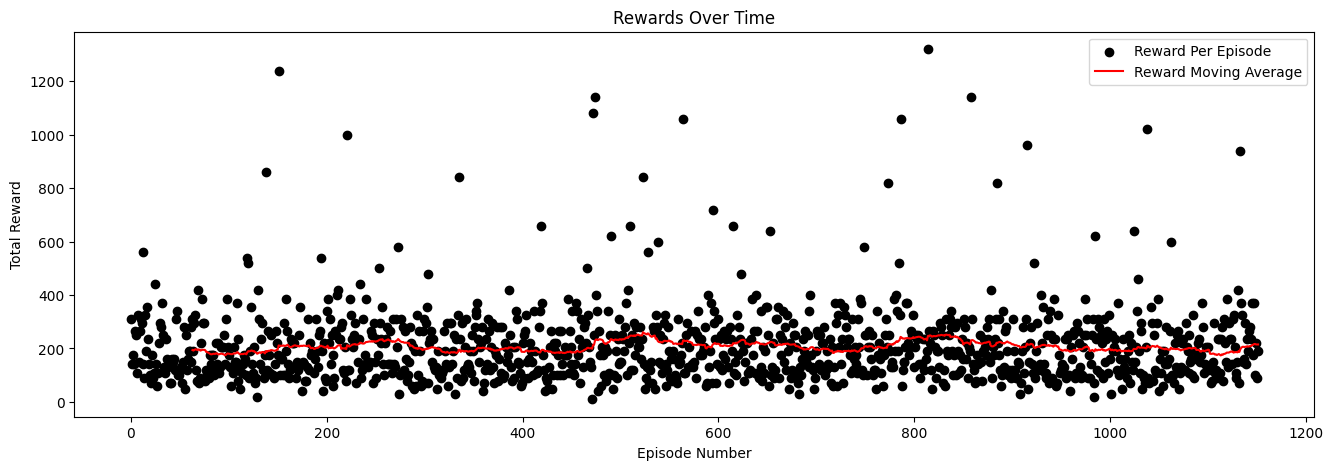

500                          
696                          
Episode 1152 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5233                          
Episode 1153 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3743                          
Episode 1154 of 10240                

500                          
639                          
Episode 1155 of 10240                

500                          
895                          
Episode 1156 of 10240                

500                          
1000      

2094                          
Episode 1191 of 10240                

500                          
509                          
Episode 1192 of 10240                

500                          
967                          
Episode 1193 of 10240                

500                          
1000                         
1500                          
1516                          
Episode 1194 of 10240                

500                          
1000                         
1065                          
Episode 1195 of 10240                

500                          
916                          
Episode 1196 of 10240                

500                          
645                          
Episode 1197 of 10240                

500                          
778                          
Episode 1198 of 10240                

500                          
1000                         
1500                          
2000                          
2500                  

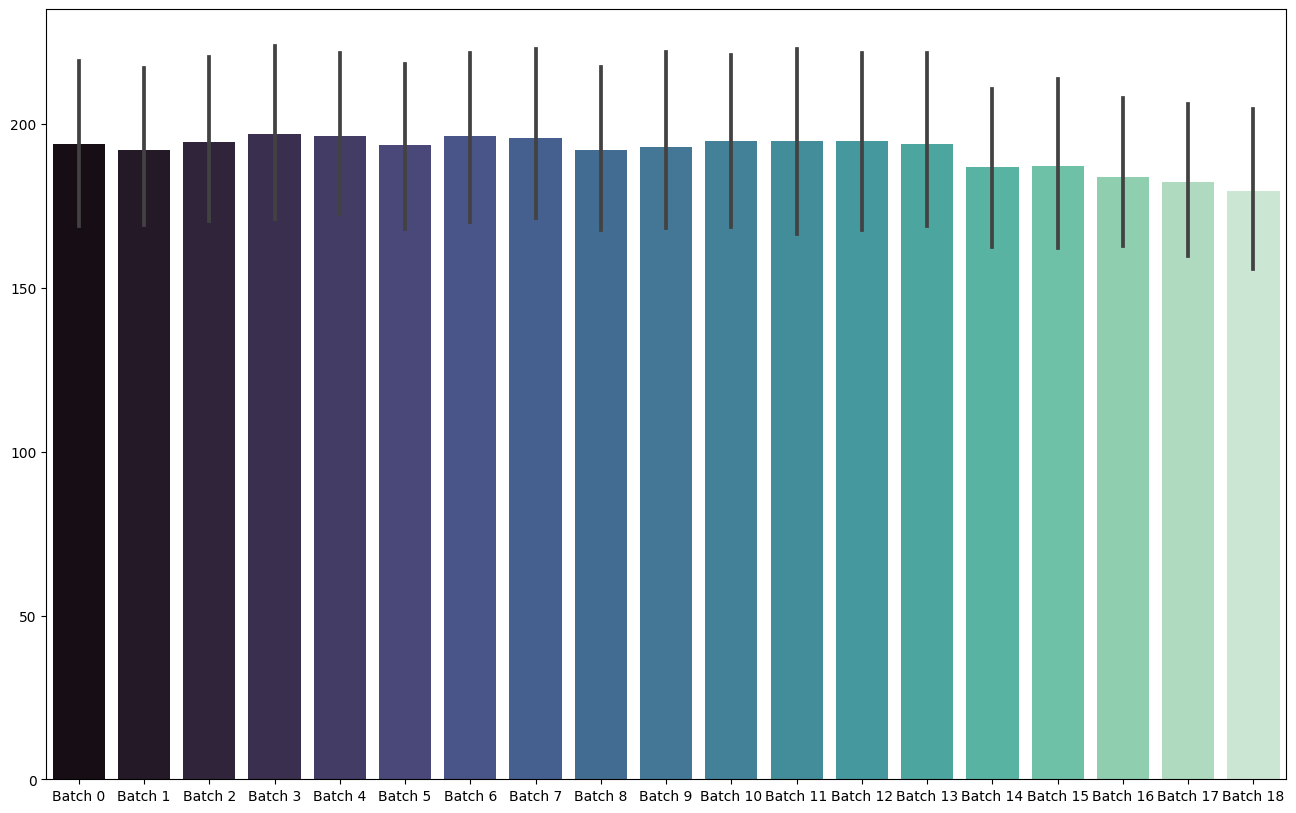

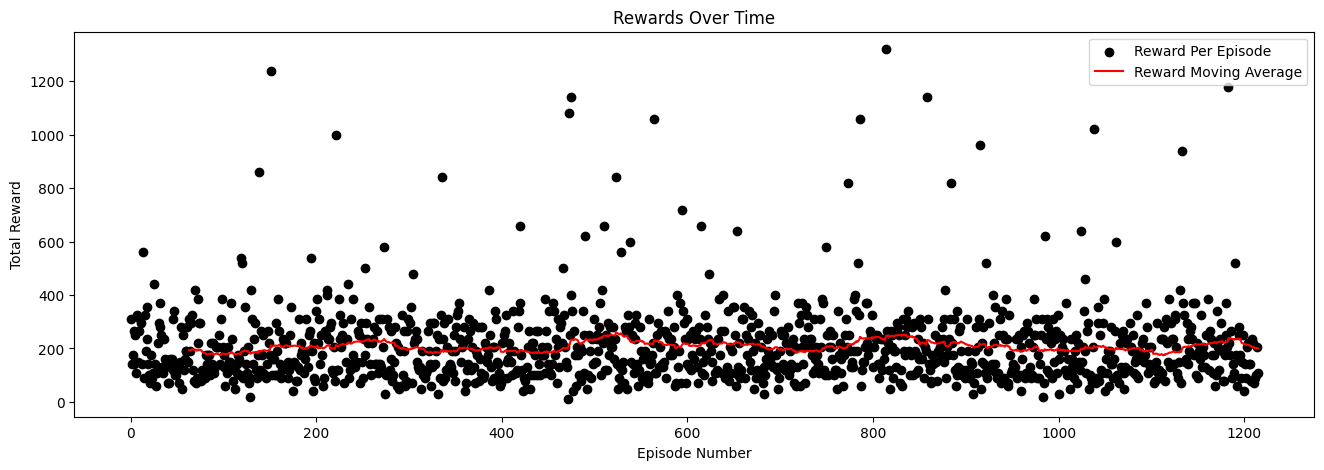

500                          
1000                         
1500                          
1987                          
Episode 1216 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2691                          
Episode 1217 of 10240                

500                          
1000                         
1500                          
2000                          
2384                          
Episode 1218 of 10240                

500                          
643                          
Episode 1219 of 10240                

500                          
701                          
Episode 1220 of 10240                

500                          
951                          
Episode 1221 of 10240                

500                          
948                          
Episode 1222 of 10240                

500                         

500                          
1000                         
1500                          
2000                          
2500                          
2639                          
Episode 1258 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2771                          
Episode 1259 of 10240                

500                          
564                          
Episode 1260 of 10240                

500                          
943                          
Episode 1261 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3069                          
Episode 1262 of 10240                

500                          
1000                         
1500                          
2000       

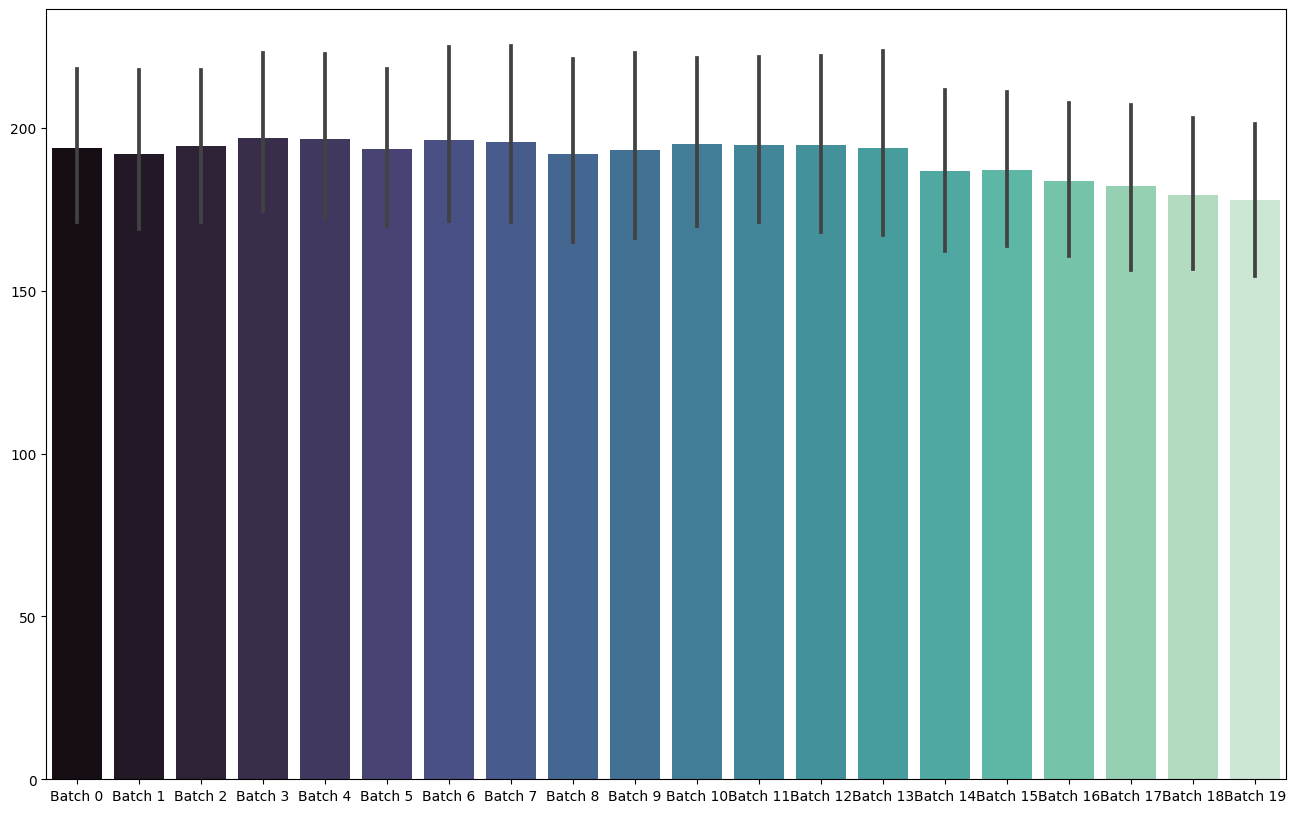

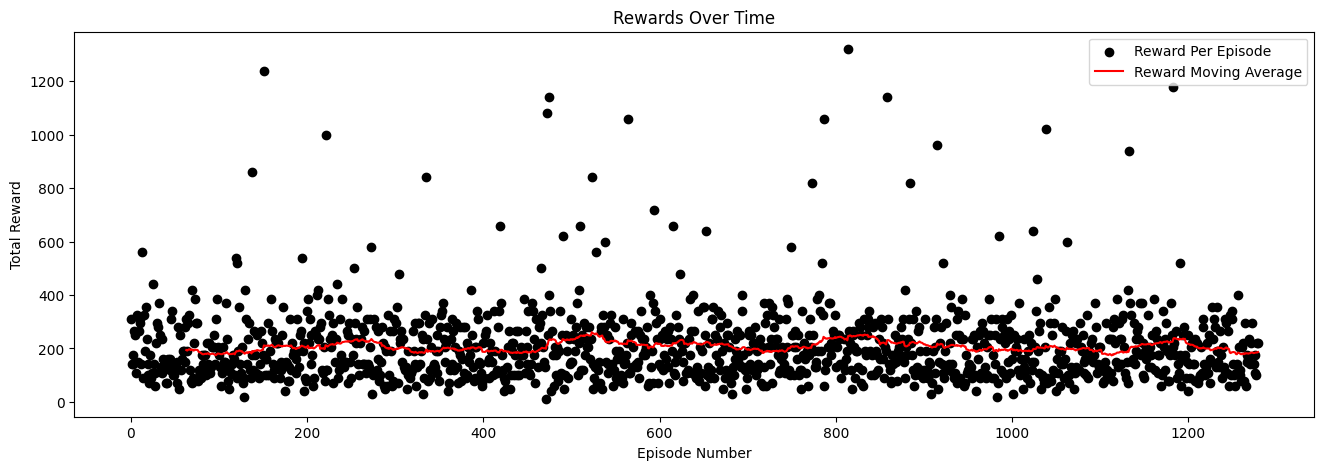

500                          
503                          
Episode 1280 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3043                          
Episode 1281 of 10240                

500                          
835                          
Episode 1282 of 10240                

277                          
Episode 1283 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4027                          
Episode 1284 of 10240                

500                          
1000                         
1500                          
1598                          
Episode 1285 of 10240                

50

2000                          
2500                          
3000                          
3421                          
Episode 1323 of 10240                

500                          
785                          
Episode 1324 of 10240                

500                          
1000                         
1031                          
Episode 1325 of 10240                

311                          
Episode 1326 of 10240                

500                          
870                          
Episode 1327 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3047                          
Episode 1328 of 10240                

500                          
646                          
Episode 1329 of 10240                

500                          
1000                         
1500                       

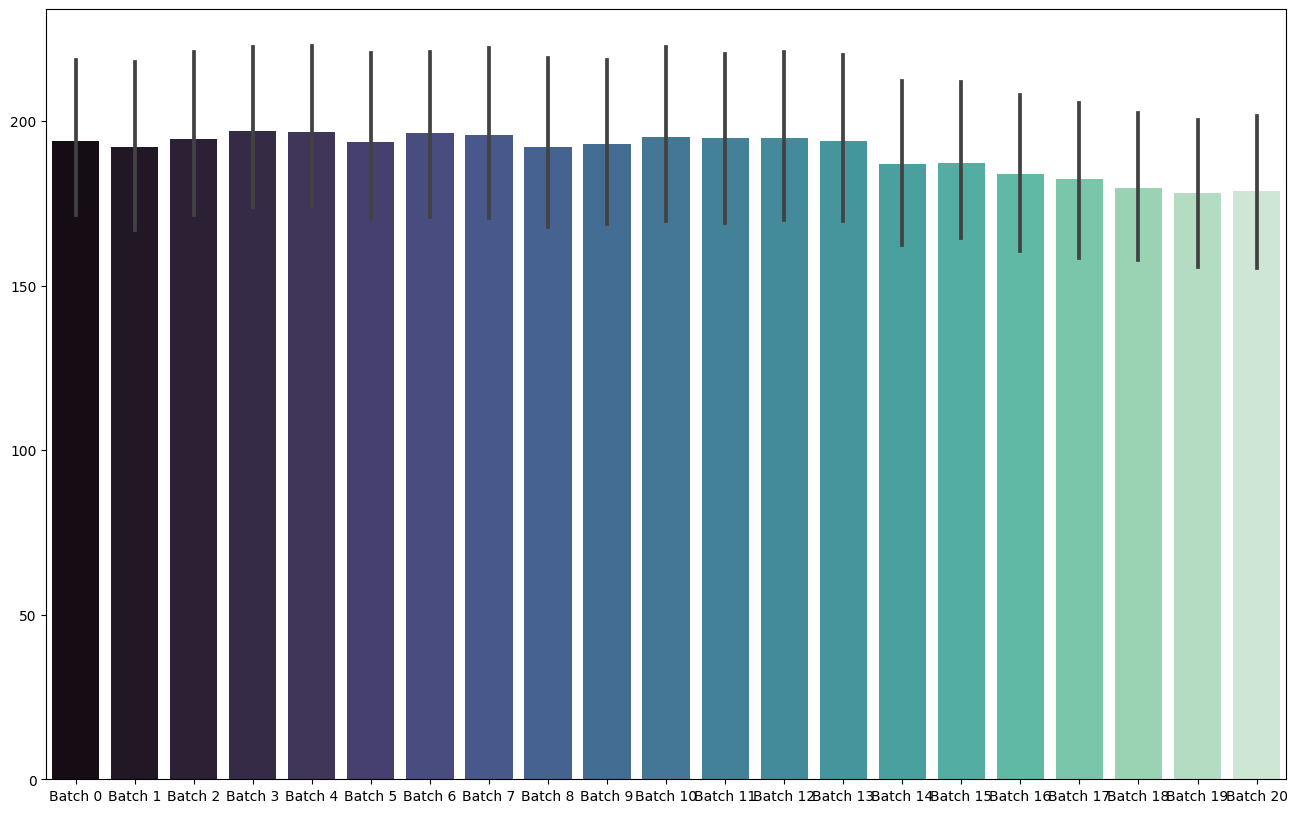

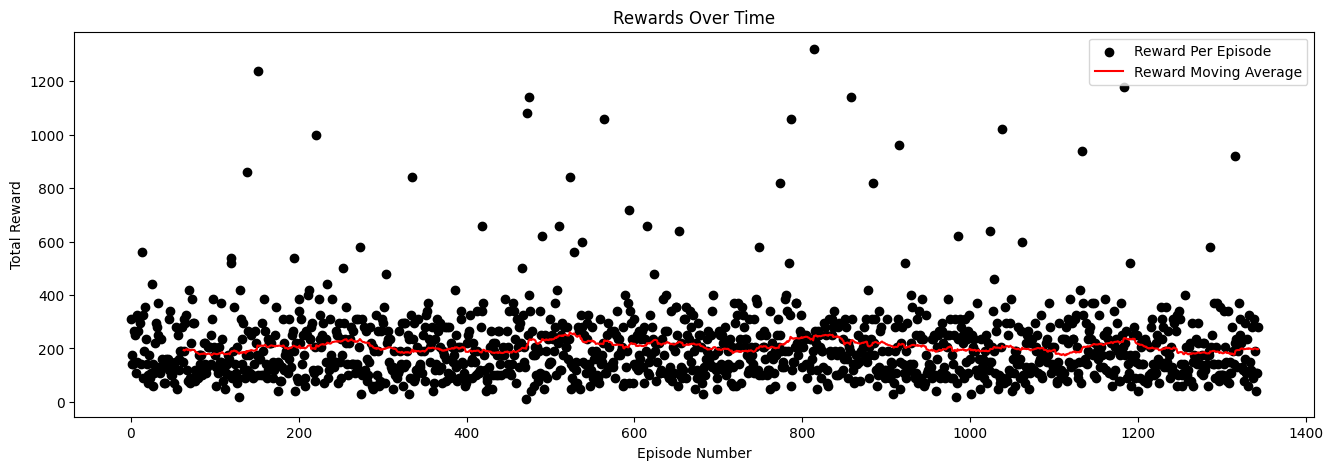

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3090                          
Episode 1344 of 10240                

500                          
1000                         
1417                          
Episode 1345 of 10240                

500                          
1000                         
1477                          
Episode 1346 of 10240                

500                          
1000                         
1500                          
1517                          
Episode 1347 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3855                          
Episode 1348 of 10240                

500                          
1000      

500                          
1000                         
1500                          
2000                          
2500                          
2509                          
Episode 1385 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2699                          
Episode 1386 of 10240                

500                          
581                          
Episode 1387 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2588                          
Episode 1388 of 10240                

500                          
913                          
Episode 1389 of 10240                

500                          
1000                         
1500                          
2000                          
2500       

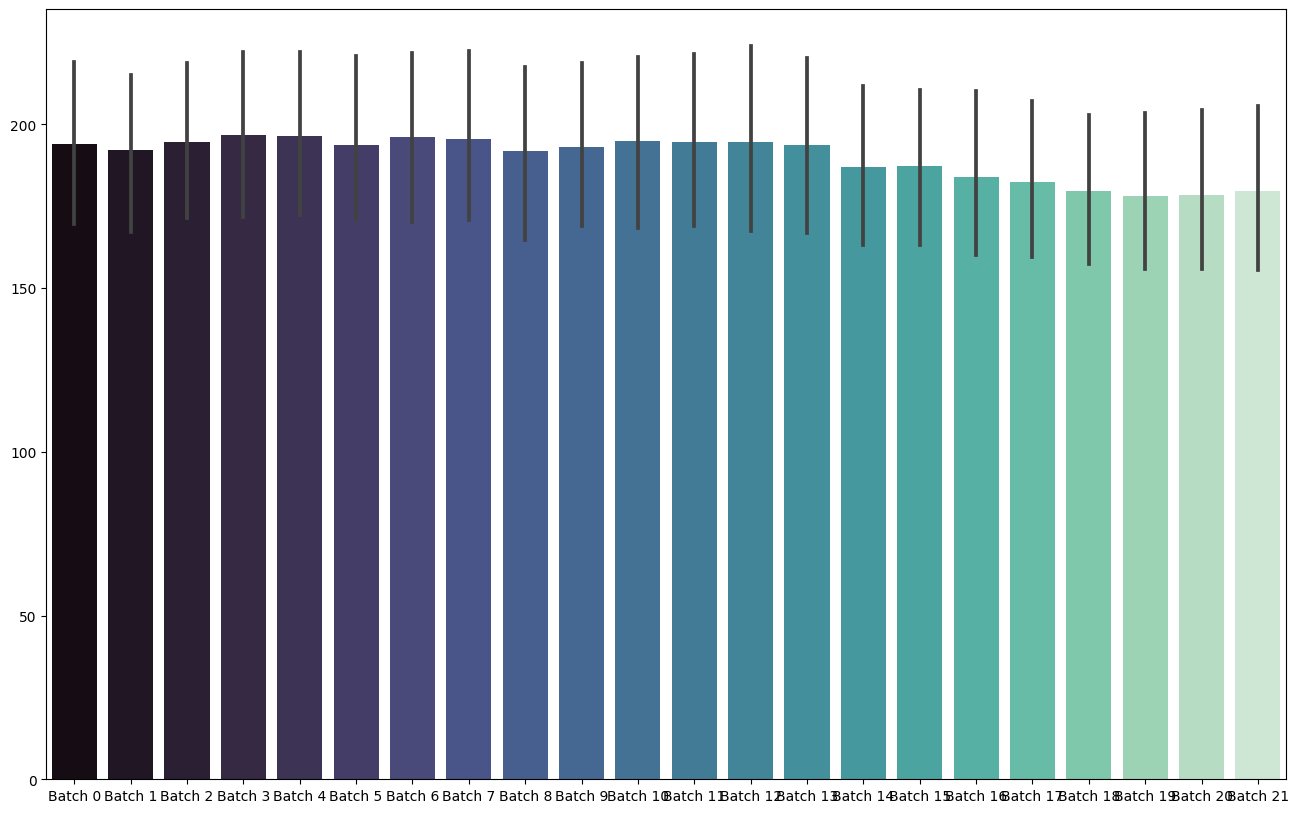

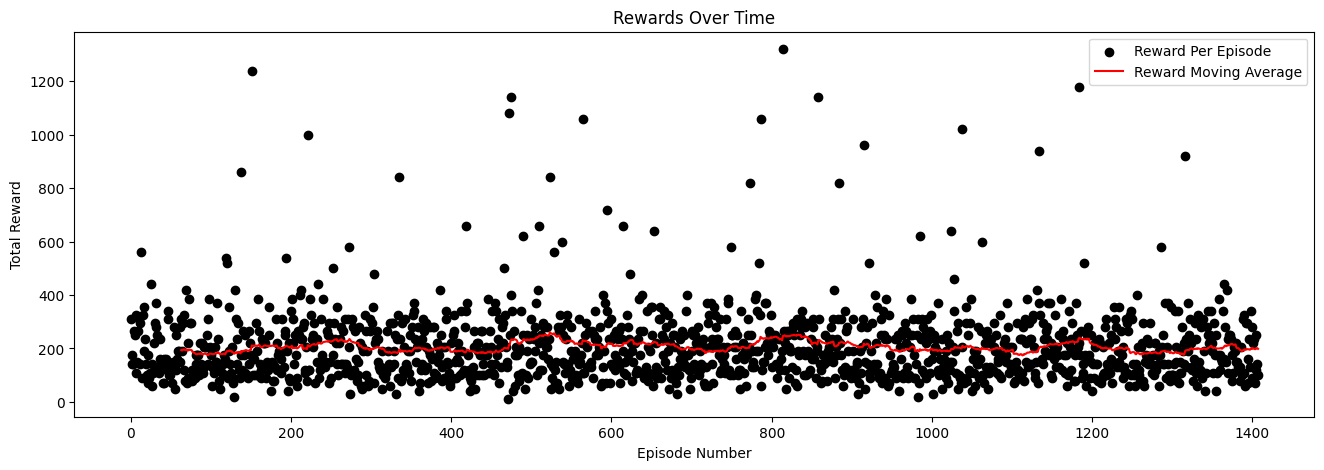

500                          
690                          
Episode 1408 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5484                          
Episode 1409 of 10240                

500                          
1000                         
1500                          
1945                          
Episode 1410 of 10240                

500                          
725                          
Episode 1411 of 10240                

500                          
661                          
Episode 1412 of 10240                

500                          
1000                         
1020                          
Episode 1413 of 10240                

445                          
Epis

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3421                          
Episode 1450 of 10240                

500                          
1000                         
1356                          
Episode 1451 of 10240                

500                          
1000                         
1500                          
1780                          
Episode 1452 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3072                          
Episode 1453 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500             

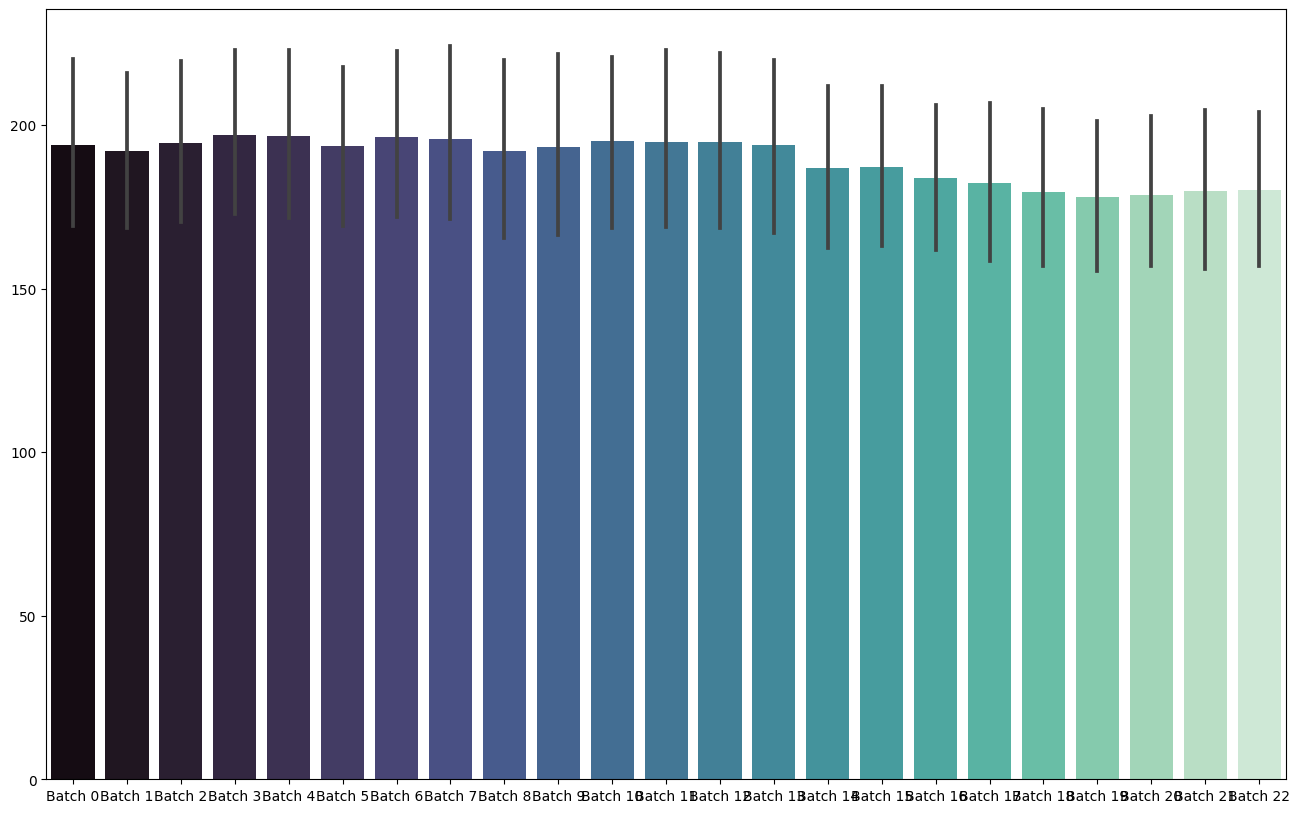

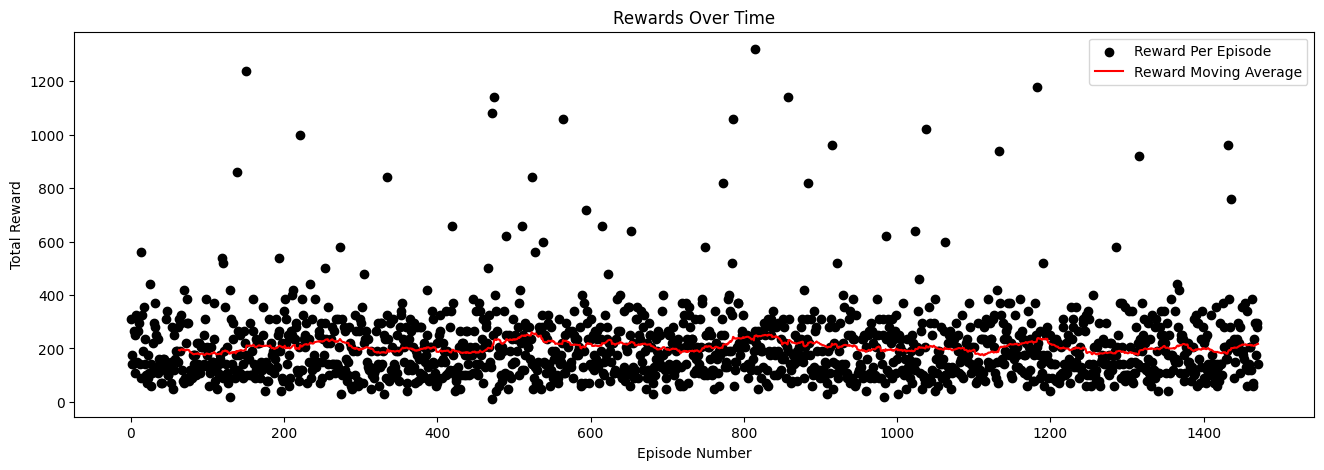

500                          
636                          
Episode 1472 of 10240                

303                          
Episode 1473 of 10240                

500                          
1000                         
1465                          
Episode 1474 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5061                          
Episode 1475 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500            

3500                          
3752                          
Episode 1512 of 10240                

500                          
1000                         
1500                          
1660                          
Episode 1513 of 10240                

500                          
721                          
Episode 1514 of 10240                

500                          
1000                         
1274                          
Episode 1515 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5117                          
Episode 1516 of 10240                

446                          
Episode 1517 of 10240                

500                          
772                          
Ep

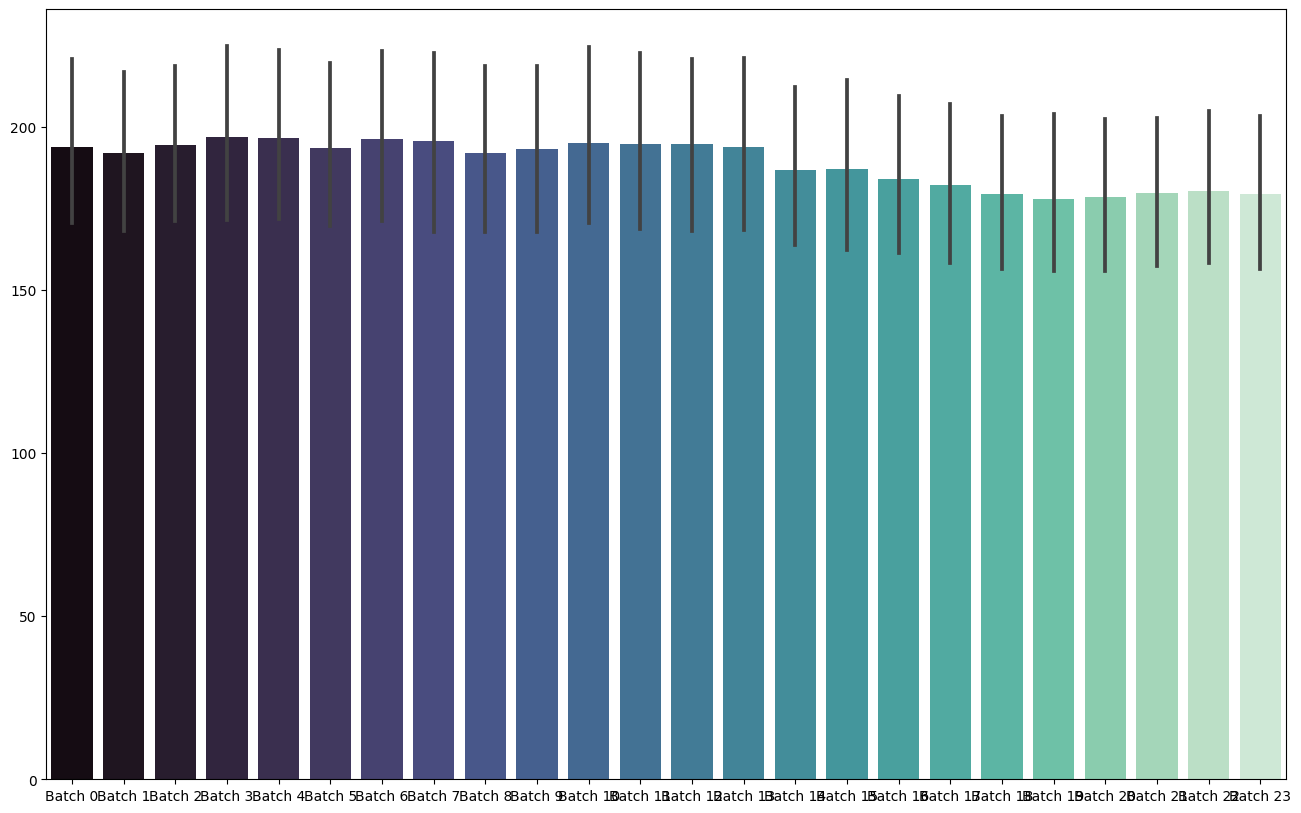

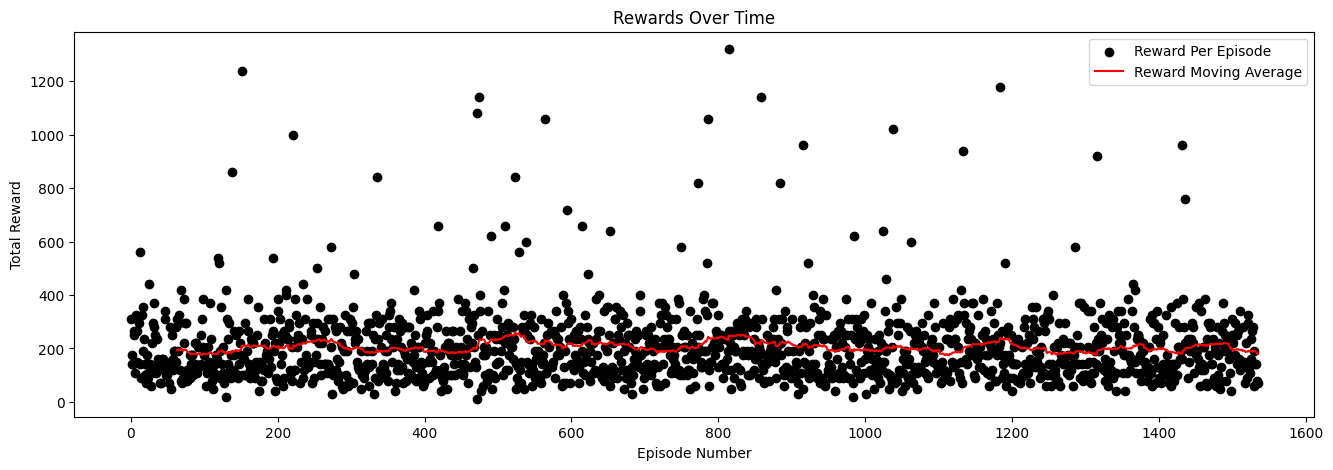

500                          
787                          
Episode 1536 of 10240                

500                          
1000                         
1151                          
Episode 1537 of 10240                

500                          
1000                         
1500                          
2000                          
2189                          
Episode 1538 of 10240                

500                          
1000                         
1500                          
2000                          
2161                          
Episode 1539 of 10240                

352                          
Episode 1540 of 10240                

500                          
542                          
Episode 1541 of 10240                

500                          
1000                         
1500                          
1750                          
Episode 1542 of 10240                

500                          
1000                        

1000                         
1500                          
2000                          
2423                          
Episode 1577 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
5920                          
Episode 1578 of 10240                

500                          
772                          
Episode 1579 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                  

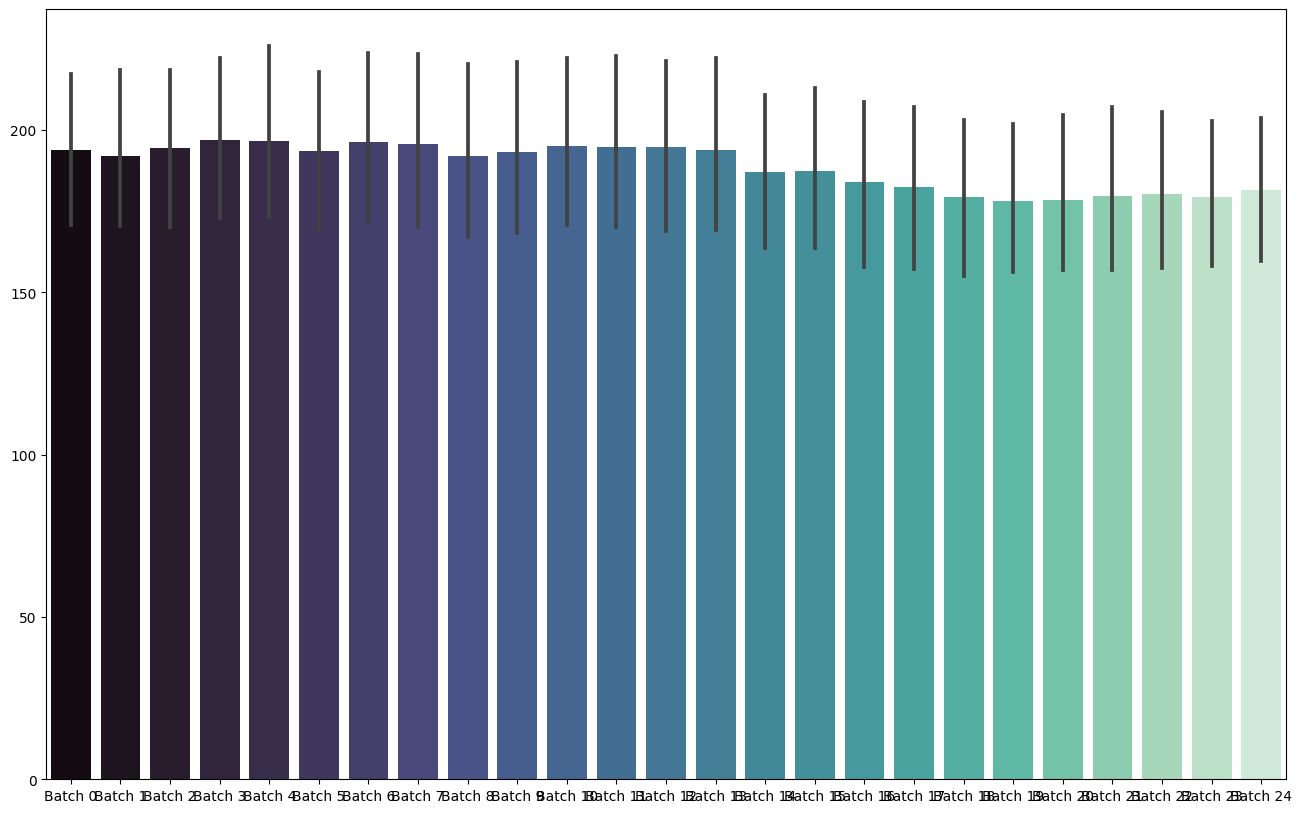

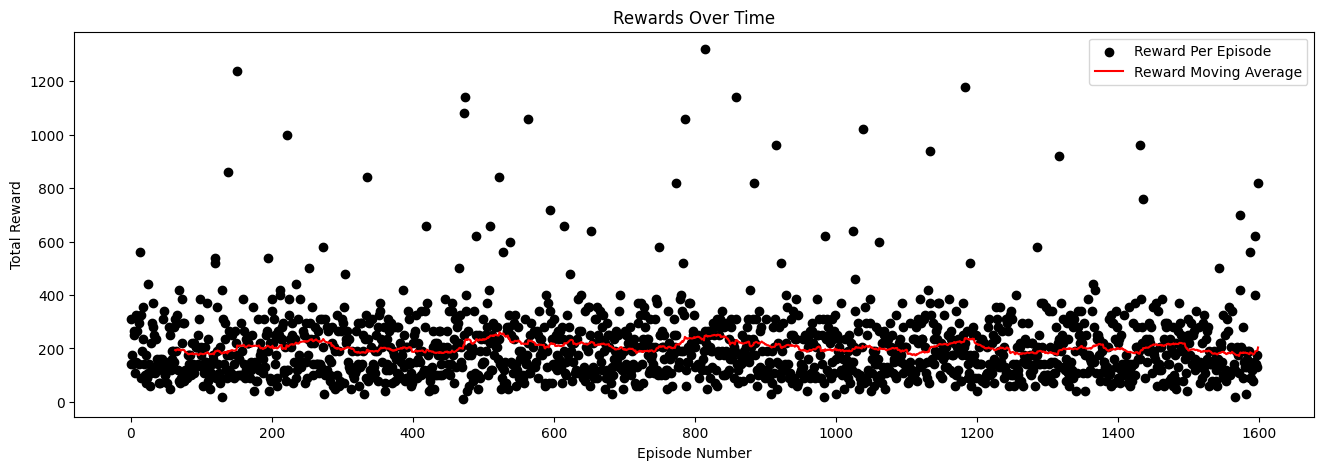

500                          
1000                         
1500                          
1994                          
Episode 1600 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
5701                          
Episode 1601 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
5850                          
Episode 1602 of 10240                

500                  

500                          
841                          
Episode 1636 of 10240                

500                          
548                          
Episode 1637 of 10240                

500                          
542                          
Episode 1638 of 10240                

500                          
1000                         
1500                          
1688                          
Episode 1639 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3036                          
Episode 1640 of 10240                

500                          
1000                         
1500                          
2000                          
2391                          
Episode 1641 of 10240                

500                          
1000                         
1500                          
1840 

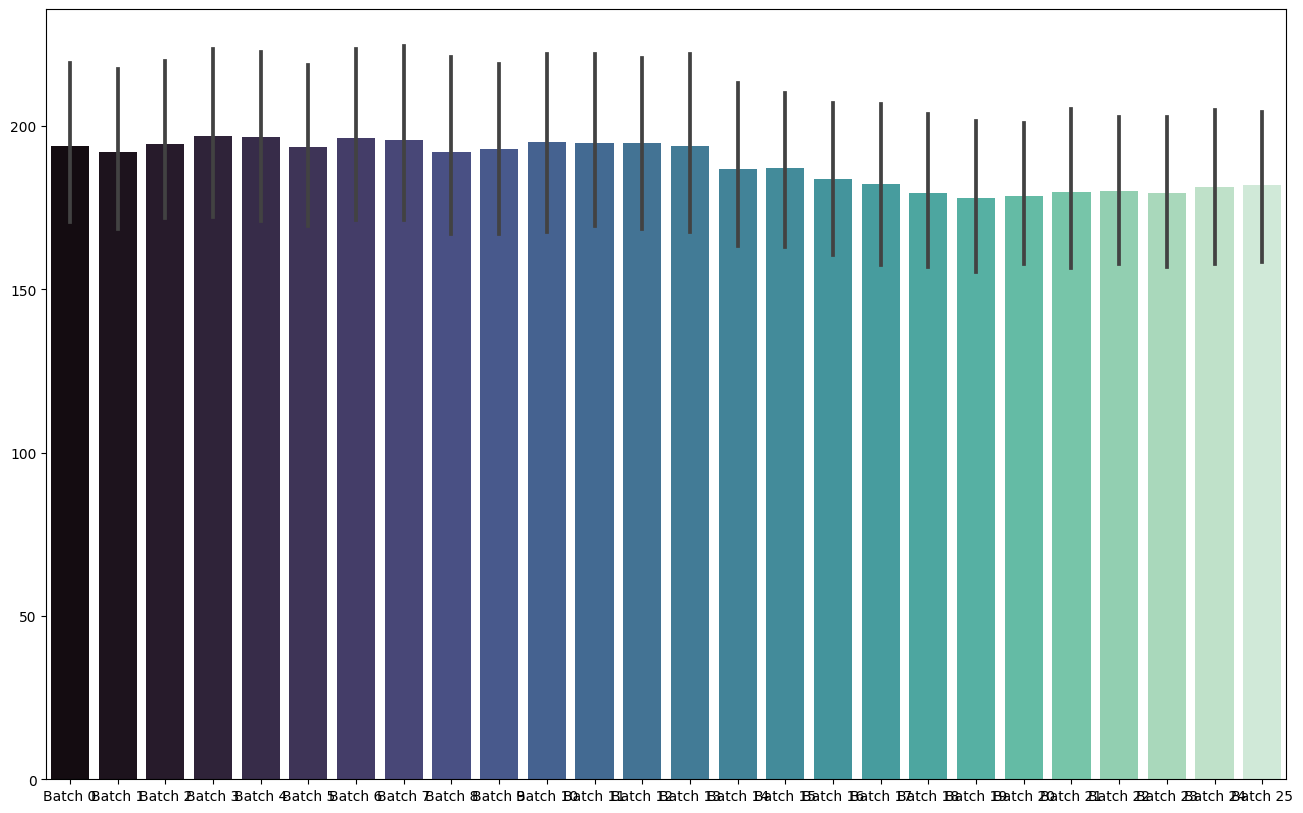

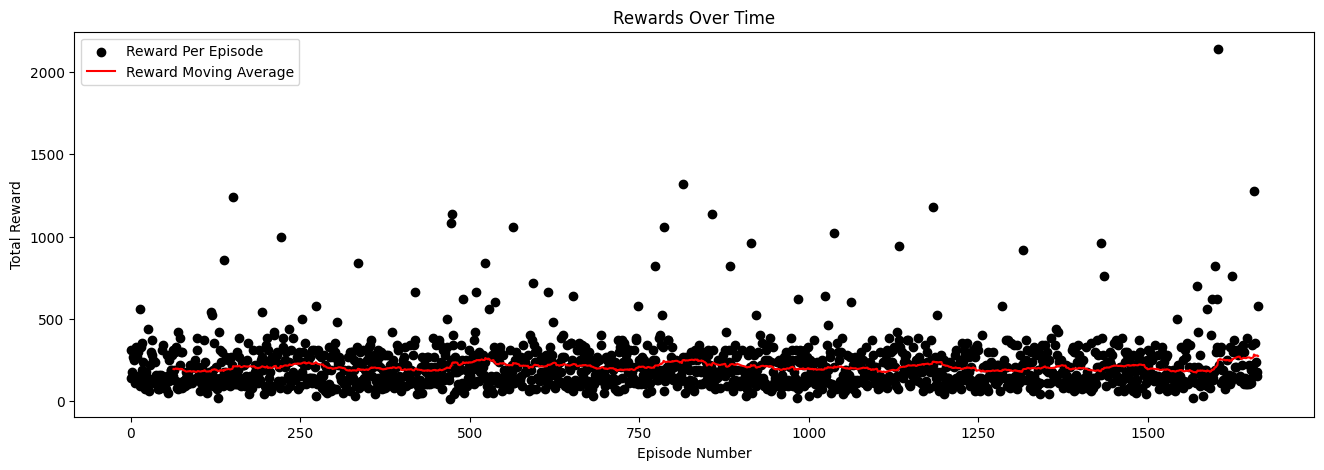

500                          
699                          
Episode 1664 of 10240                

500                          
1000                         
1500                          
2000                          
2486                          
Episode 1665 of 10240                

500                          
1000                         
1500                          
1525                          
Episode 1666 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2659                          
Episode 1667 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3042                          
Episode 1668 of 10240                

500                          
576                          
Episode 166

1500                          
2000                          
2500                          
3000                          
3500                          
3913                          
Episode 1702 of 10240                

500                          
1000                         
1212                          
Episode 1703 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5469                          
Episode 1704 of 10240                

500                          
1000                         
1087                          
Episode 1705 of 10240                

500                          
721                          
Episode 1706 of 10240                

500                          
1000    

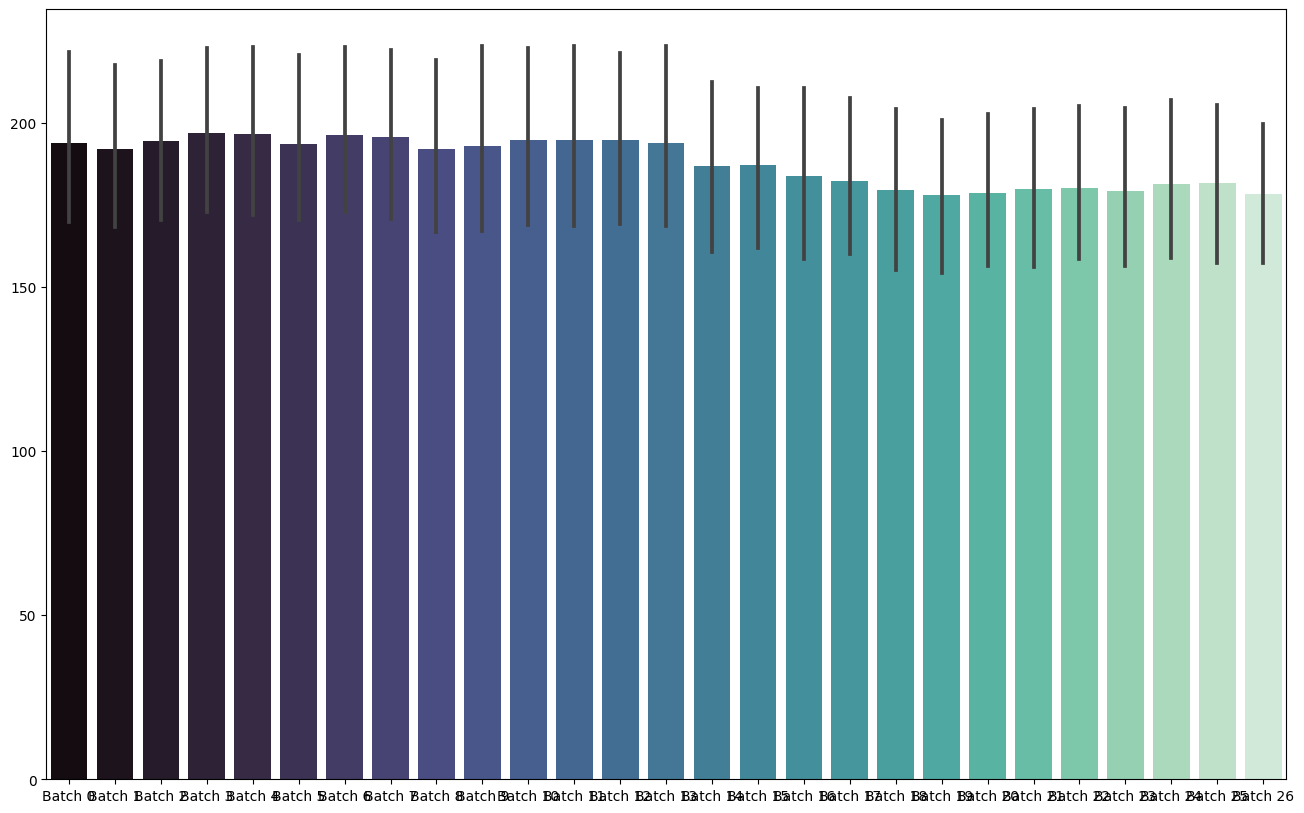

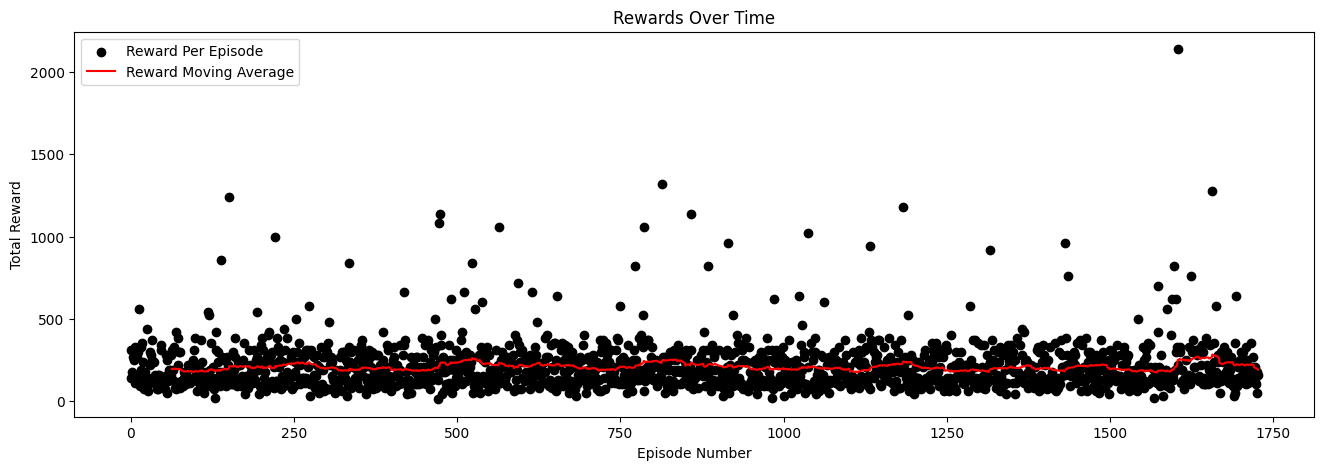

500                          
1000                         
1500                          
2000                          
2500                          
2998                          
Episode 1728 of 10240                

414                          
Episode 1729 of 10240                

500                          
569                          
Episode 1730 of 10240                

247                          
Episode 1731 of 10240                

500                          
510                          
Episode 1732 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2653                          
Episode 1733 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
398

5000                          
5312                          
Episode 1775 of 10240                

500                          
1000                         
1500                          
1710                          
Episode 1776 of 10240                

500                          
816                          
Episode 1777 of 10240                

500                          
1000                         
1500                          
2000                          
2260                          
Episode 1778 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4092                          
Episode 1779 of 10240                

500                          
1000                         
1500                          
1784                          
Episode 1

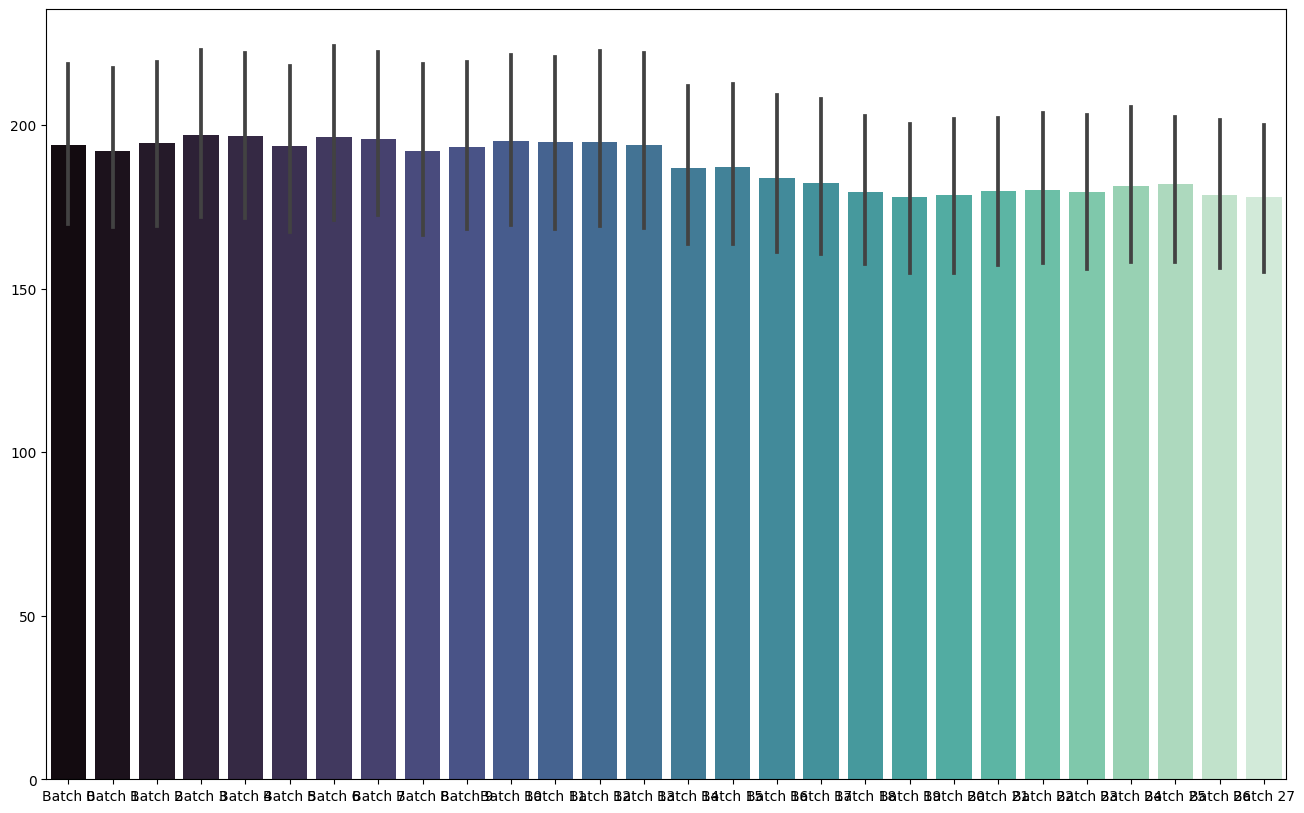

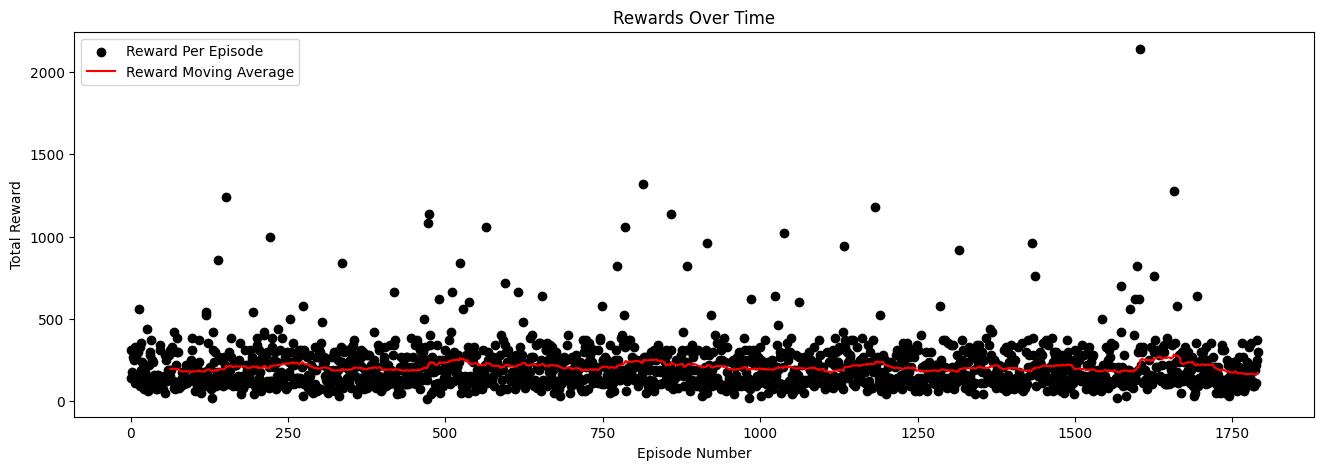

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4932                          
Episode 1792 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3021                          
Episode 1793 of 10240                

500                          
793                          
Episode 1794 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                   

500                          
843                          
Episode 1833 of 10240                

350                          
Episode 1834 of 10240                

500                          
1000                         
1408                          
Episode 1835 of 10240                

500                          
1000                         
1019                          
Episode 1836 of 10240                

500                          
882                          
Episode 1837 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2595                          
Episode 1838 of 10240                

500                          
1000                         
1500                          
2000                          
2012                          
Episode 1839 of 10240                

500                          
1000                        

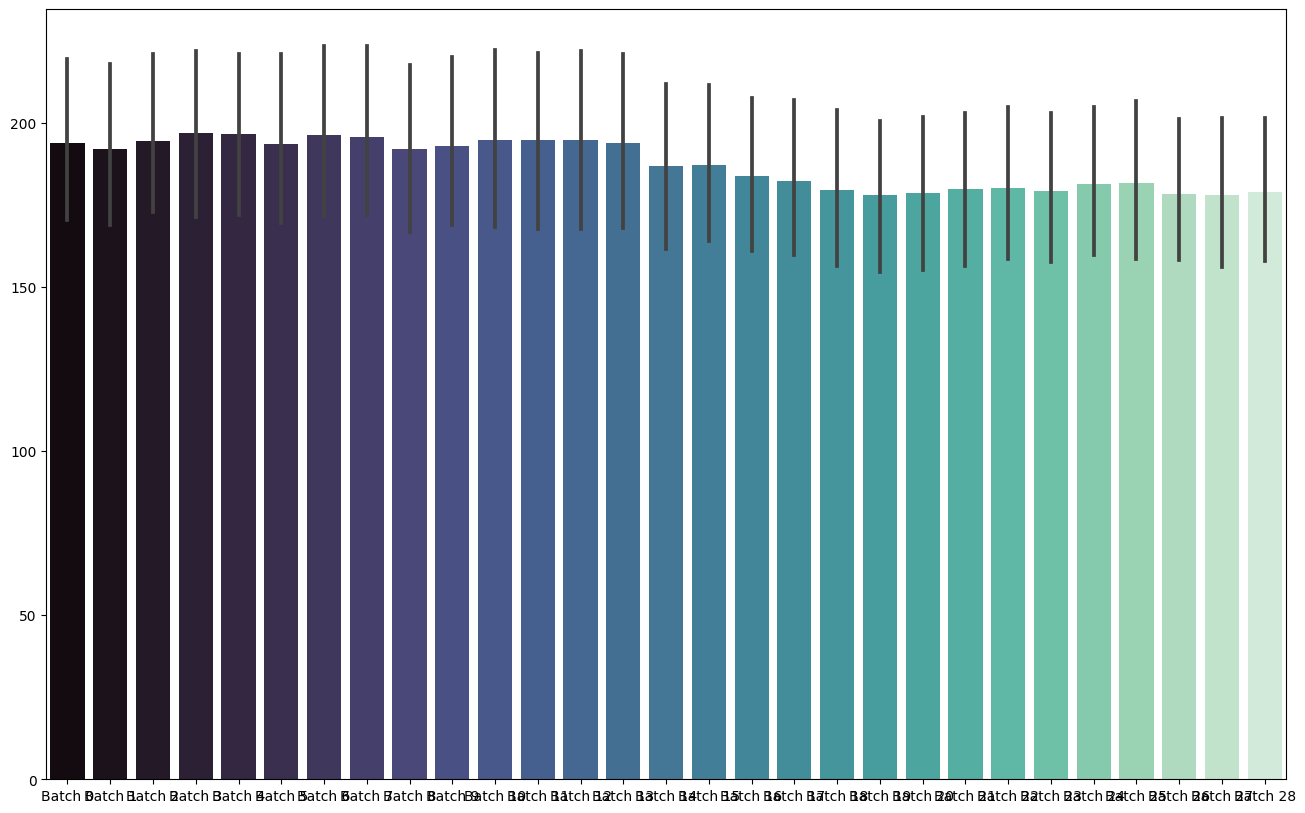

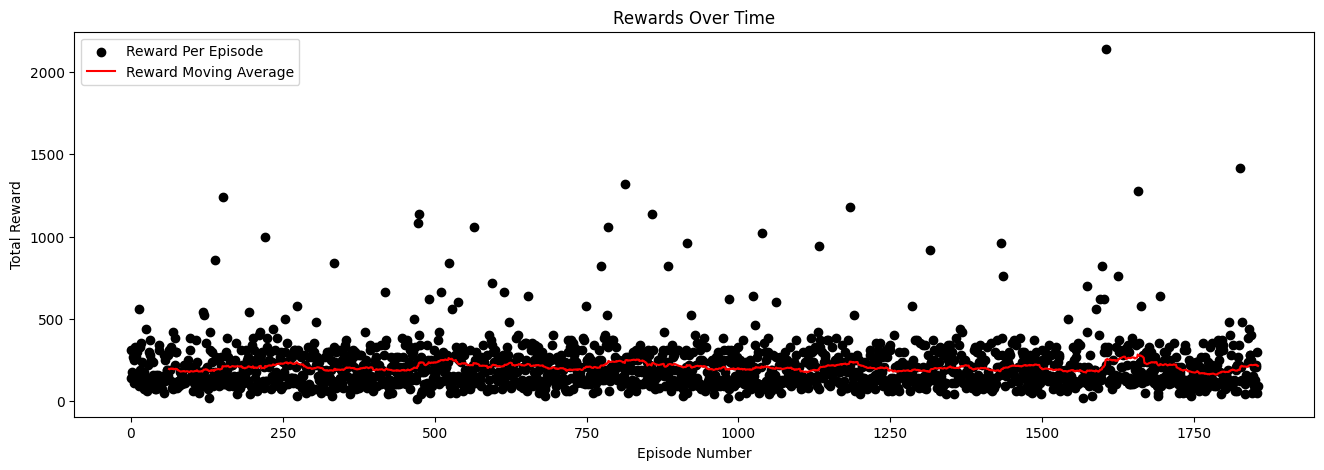

500                          
1000                         
1500                          
2000                          
2500                          
2590                          
Episode 1856 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2830                          
Episode 1857 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5016                          
Episode 1858 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                   

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5332                          
Episode 1887 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          

Episode 1888 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3577                          
Episode 1889 of 10240                

500                          
576                          
Episode 1890 of 10240                

500                          
1000           

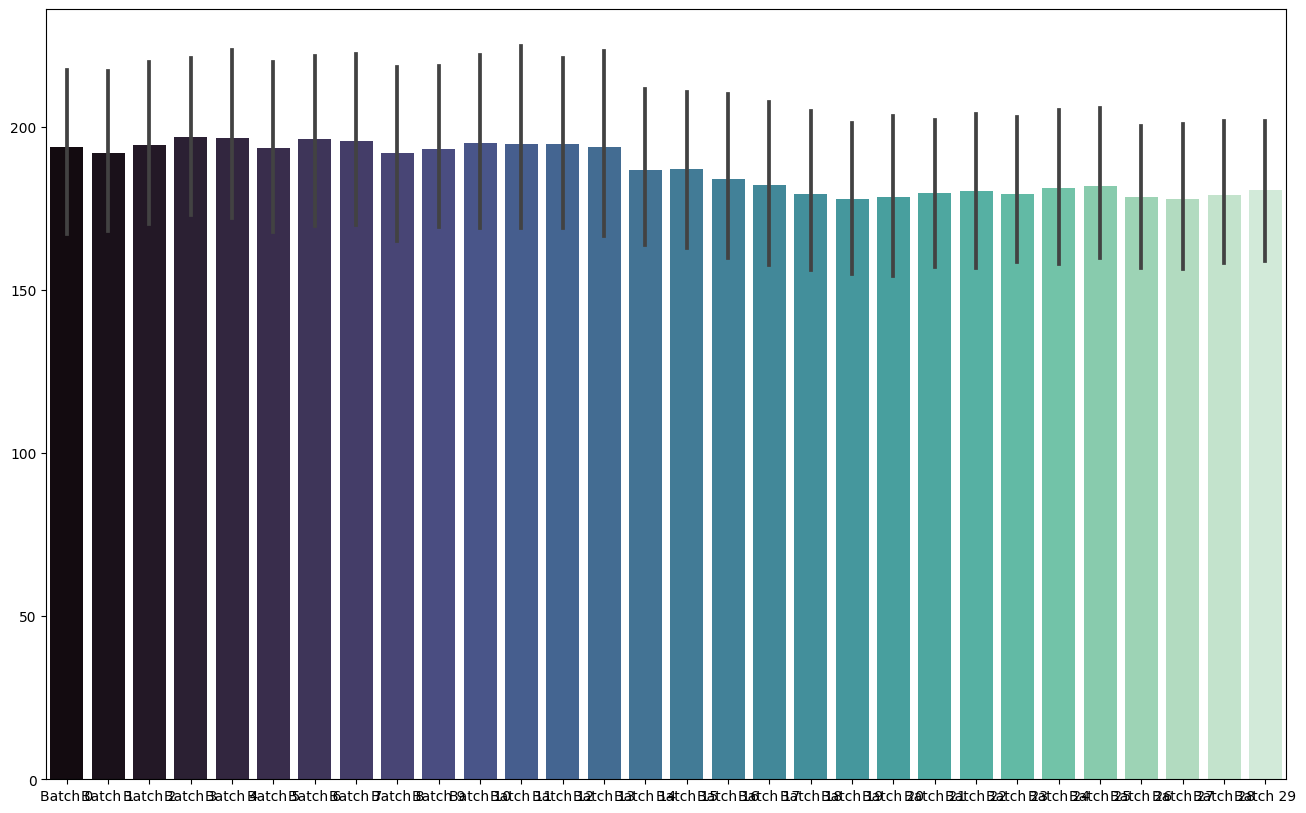

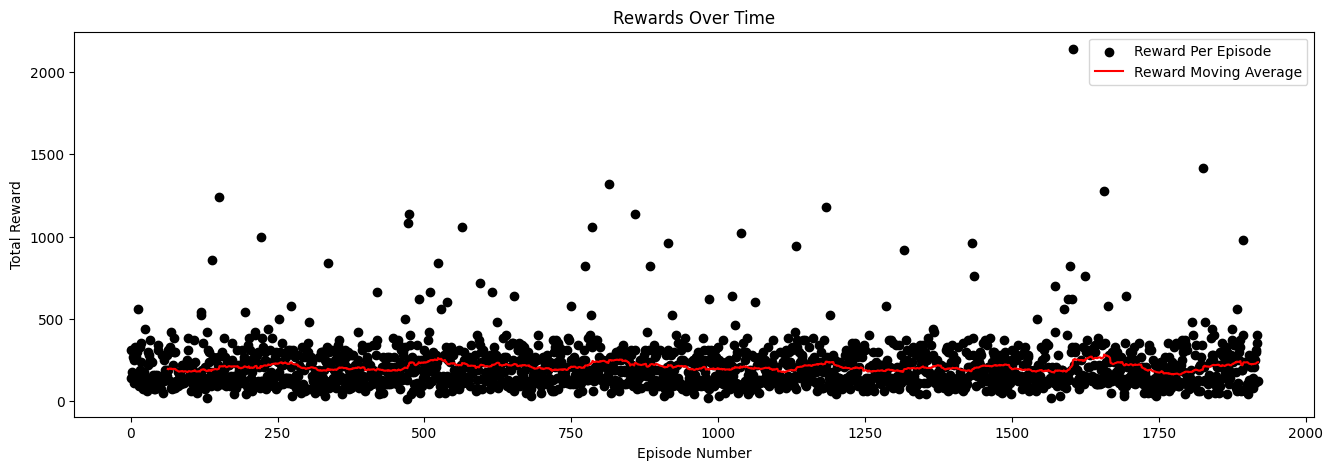

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4668                          
Episode 1920 of 10240                

500                          
1000                         
1500                          
2000                          
2308                          
Episode 1921 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
5904                          
Episode 1922 of 10240                

500                          
766                   

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4615                          
Episode 1960 of 10240                

500                          
867                          
Episode 1961 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3340                          
Episode 1962 of 10240                

500                          
852                          
Episode 1963 of 10240                

476                          
Episode 1964 of 10240                

500                          
1000                         
1500                          
1629                          
Episode 19

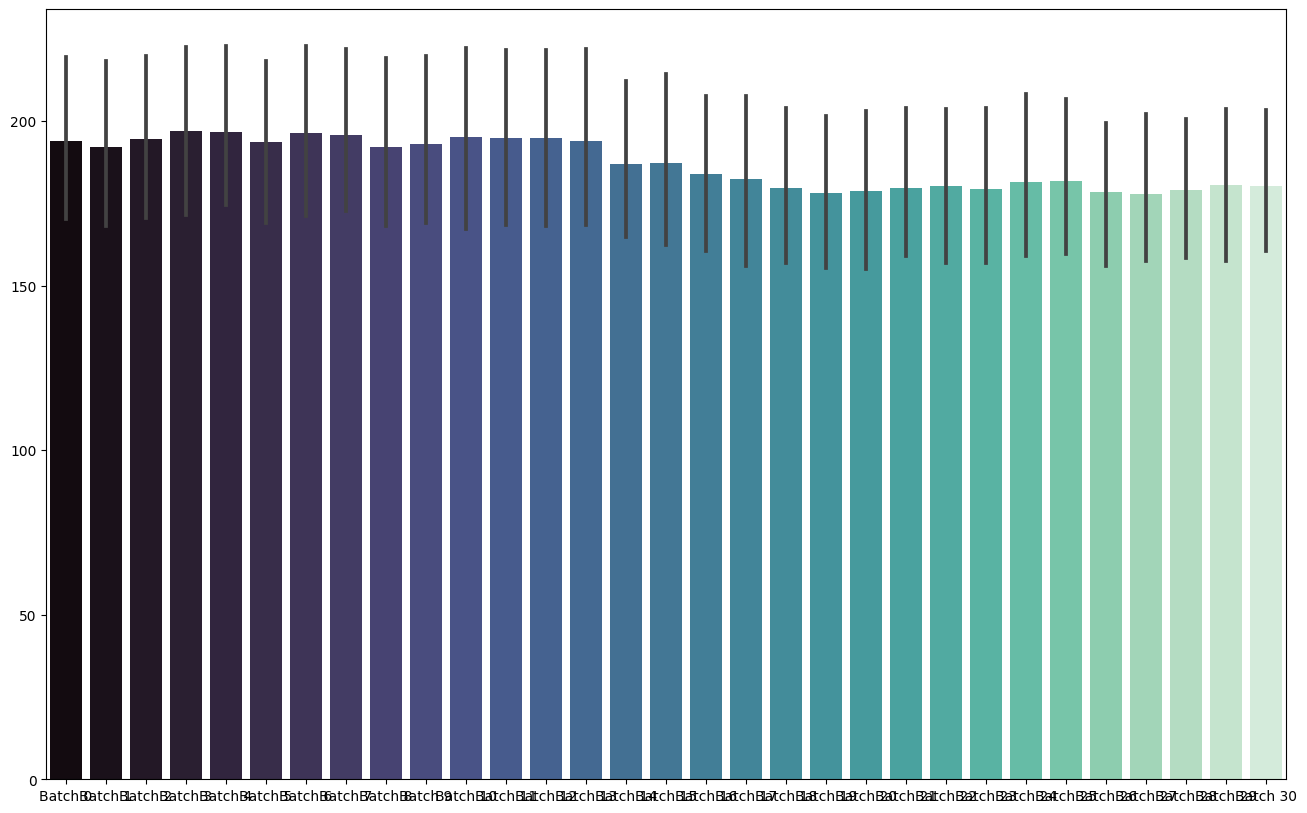

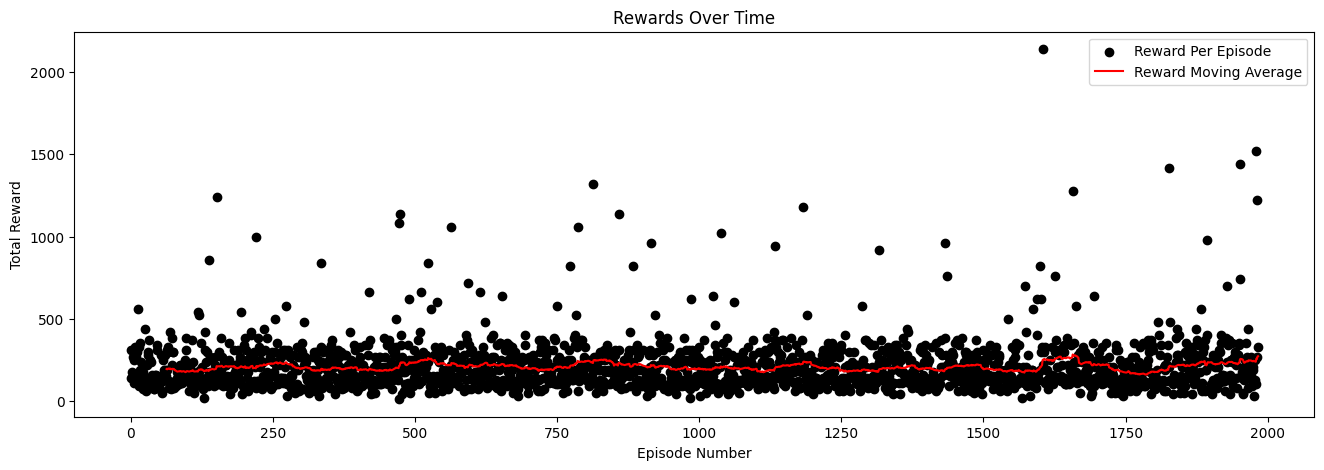

500                          
643                          
Episode 1984 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3213                          
Episode 1985 of 10240                

500                          
1000                         
1081                          
Episode 1986 of 10240                

500                          
1000                         
1399                          
Episode 1987 of 10240                

500                          
715                          
Episode 1988 of 10240                

500                          
1000                         
1500                          
2000                          
2375                          
Episode 1989 of 10240                

500                          
1000                         
1500                          
2000 

1000                         
1500                          
2000                          
2500                          
2638                          
Episode 2022 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2913                          
Episode 2023 of 10240                

500                          
1000                         
1500                          
1808                          
Episode 2024 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                  

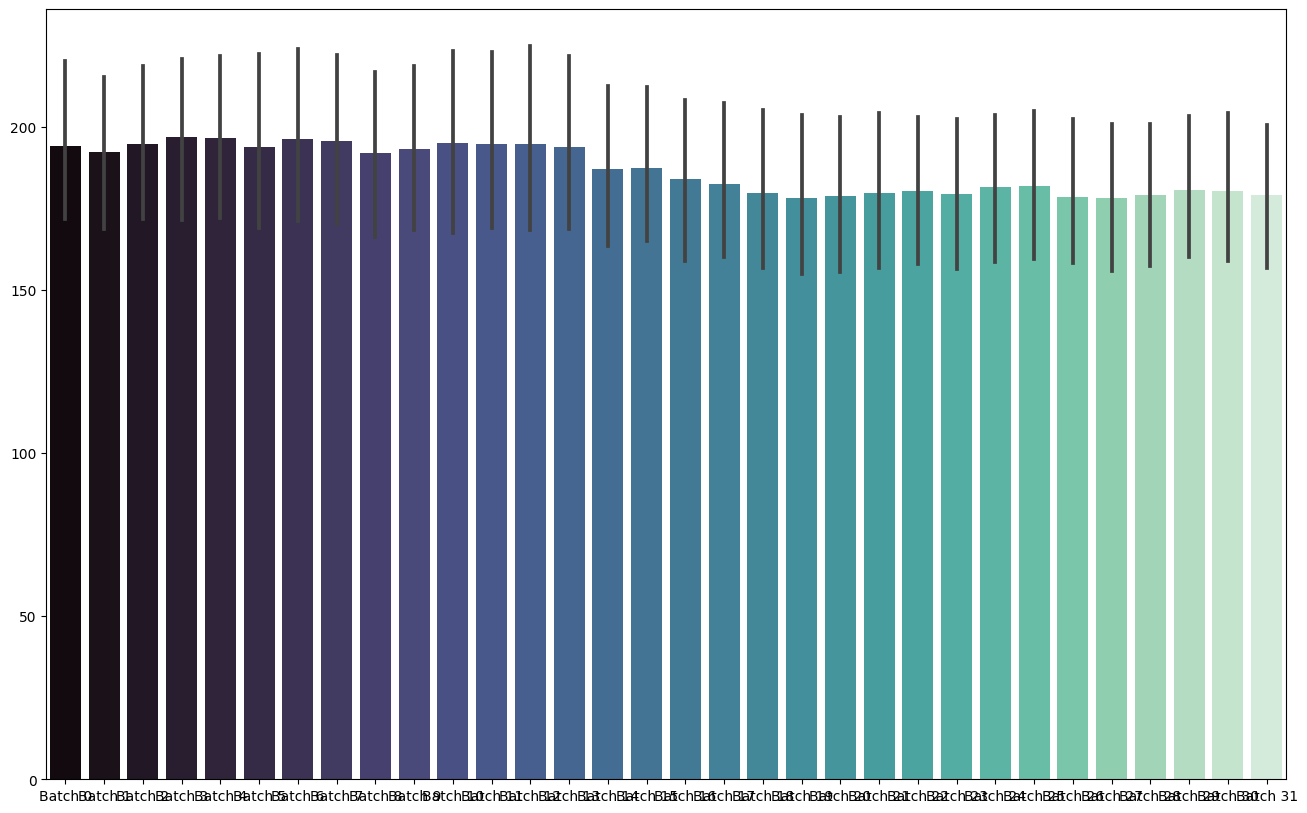

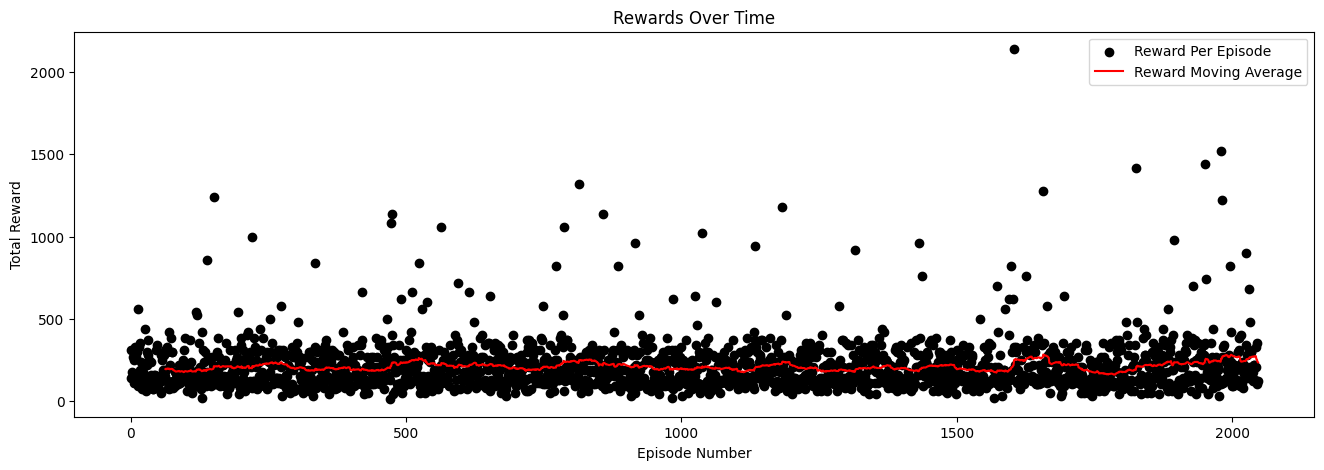

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3349                          
Episode 2048 of 10240                

500                          
644                          
Episode 2049 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3357                          
Episode 2050 of 10240                

500                          
1000                         
1155                          
Episode 2051 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500             

2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6447                          
Episode 2082 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4259                          
Episode 2083 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                       

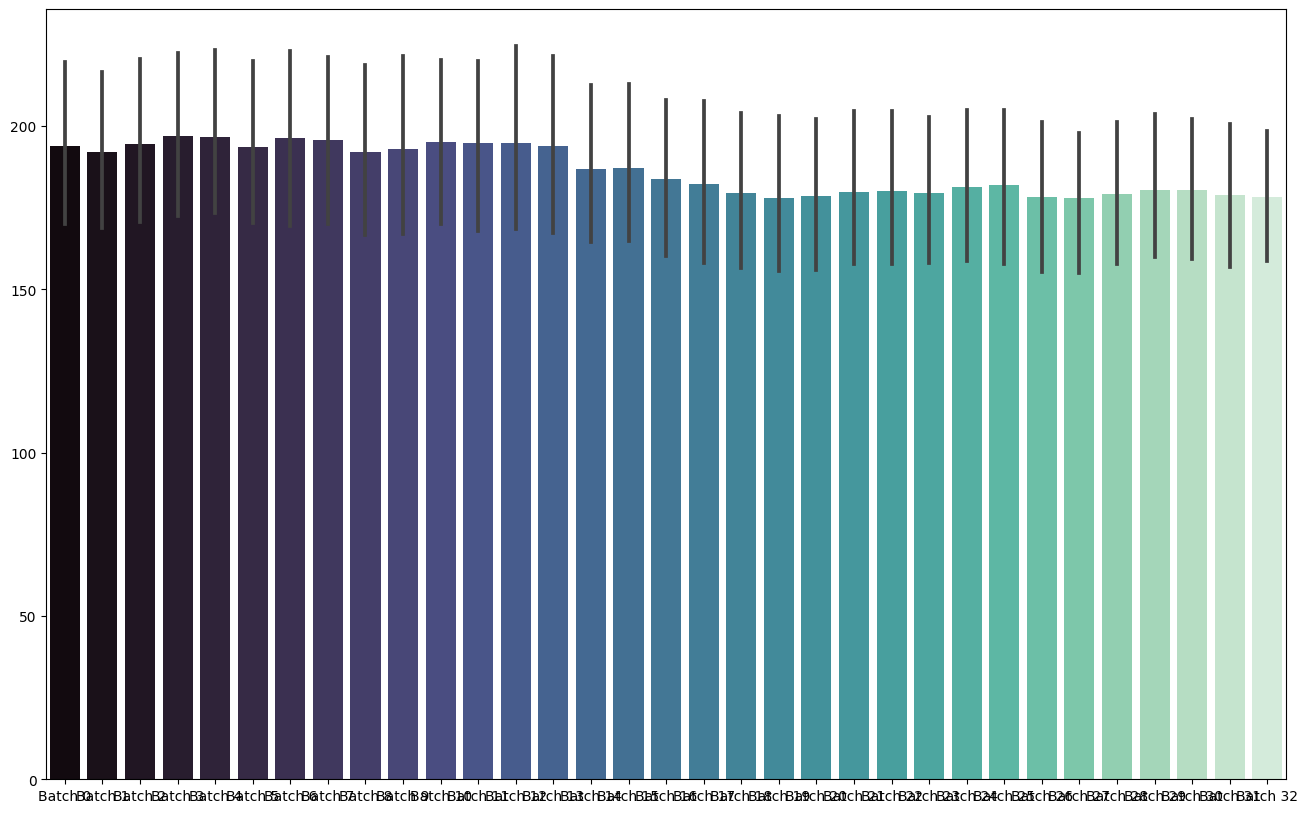

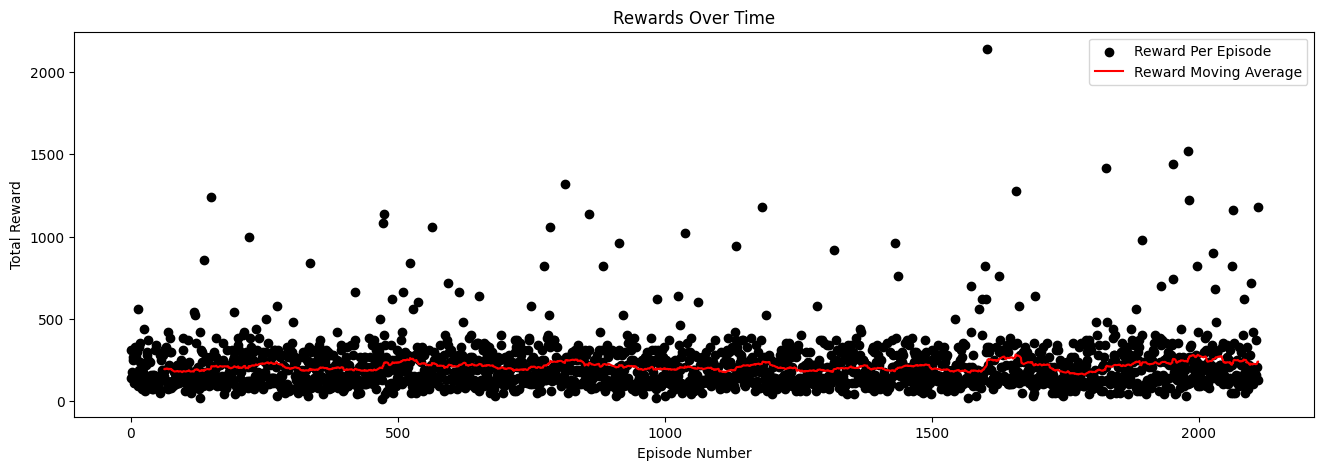

500                          
1000                         
1500                          
2000                          
2500                          
2749                          
Episode 2112 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3292                          
Episode 2113 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5177                          
Episode 2114 of 10240                

500                          
1000                         
1313                          
Episode 2115 of 10240                

500            

1000                         
1500                          
2000                          
2500                          
2755                          
Episode 2146 of 10240                

500                          
1000                         
1500                          
1691                          
Episode 2147 of 10240                

500                          
1000                         
1376                          
Episode 2148 of 10240                

500                          
1000                         
1180                          
Episode 2149 of 10240                

500                          
1000                         
1438                          
Episode 2150 of 10240                

500                          
1000                         
1425                          
Episode 2151 of 10240                

500                          
1000                         
1500                          
2000                          
2500

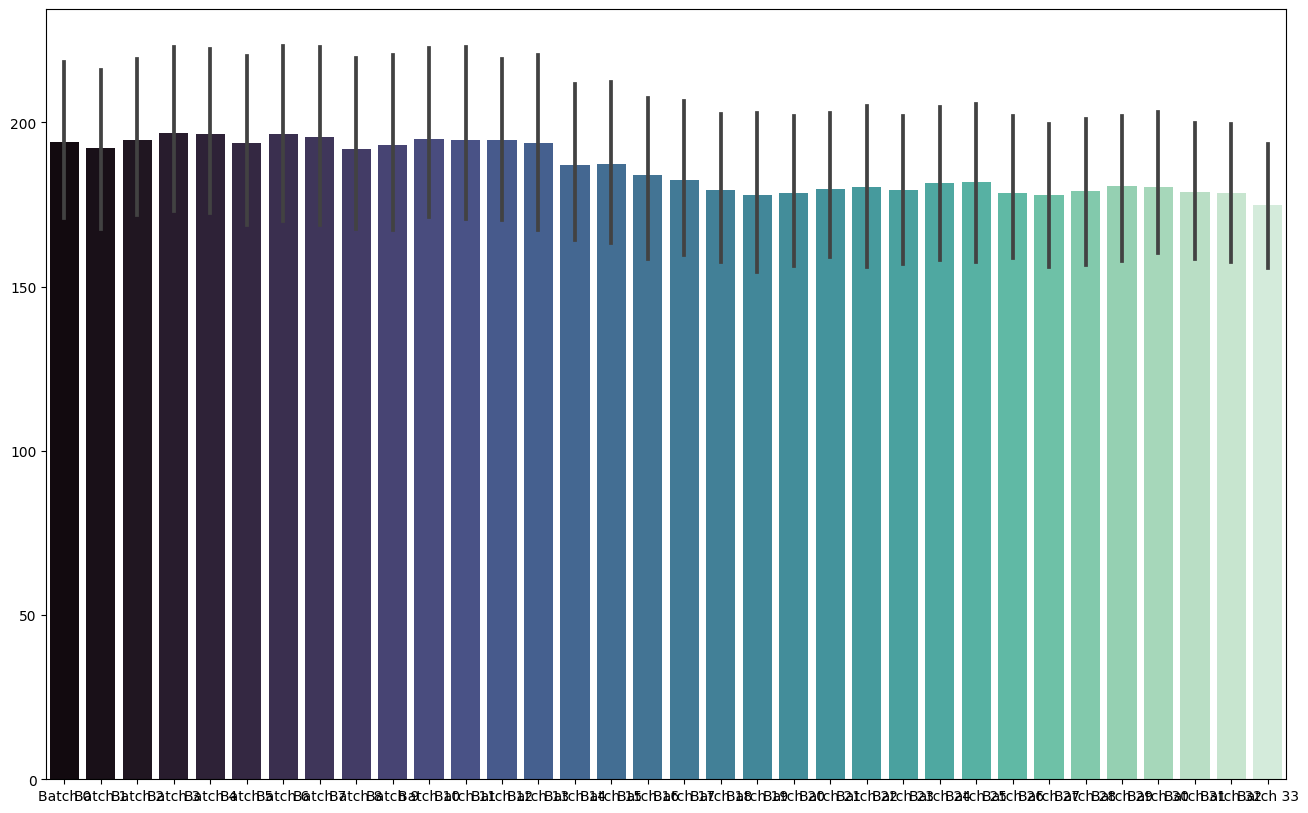

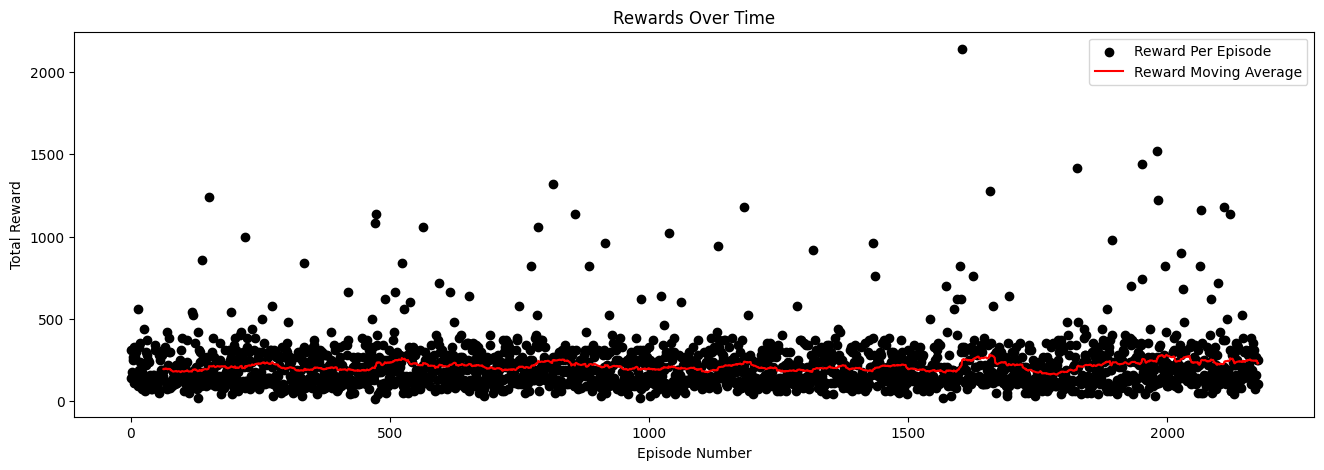

500                          
737                          
Episode 2176 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4251                          
Episode 2177 of 10240                

500                          
1000                         
1500                          
2000                          
2111                          
Episode 2178 of 10240                

413                          
Episode 2179 of 10240                

500                          
1000                         
1378                          
Episode 2180 of 10240                

500                          
1000                         
1500                          
2000                          
2205                          
Episode 2181 of 10240                

50

1820                          
Episode 2215 of 10240                

500                          
931                          
Episode 2216 of 10240                

496                          
Episode 2217 of 10240                

456                          
Episode 2218 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2795                          
Episode 2219 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4322                          
Episode 2220 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3

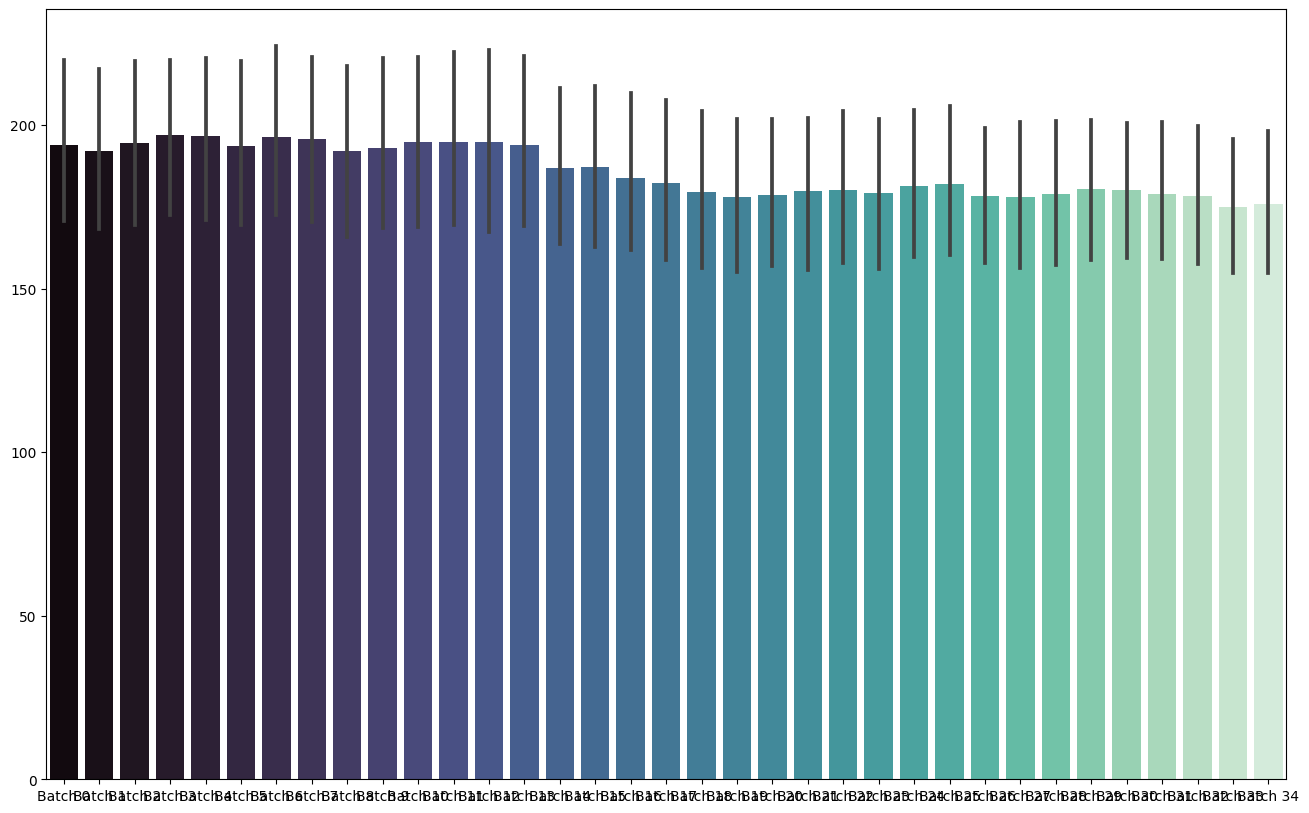

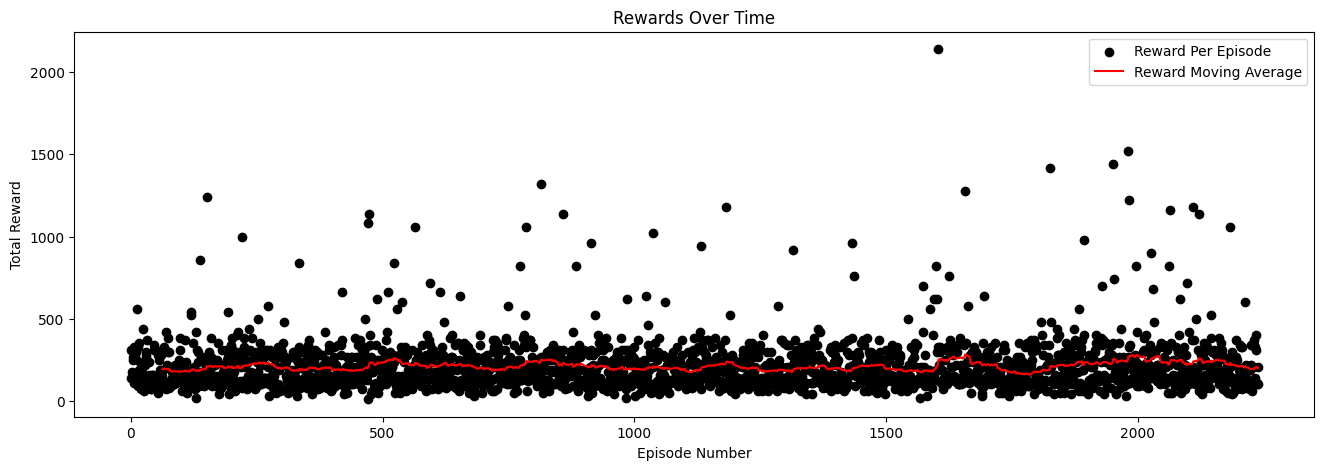

497                          
Episode 2240 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3007                          
Episode 2241 of 10240                

500                          
968                          
Episode 2242 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5213                          
Episode 2243 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3044            

2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5199                          
Episode 2279 of 10240                

500                          
974                          
Episode 2280 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4078                          
Episode 2281 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4433                          
Episode 2282 of 10240

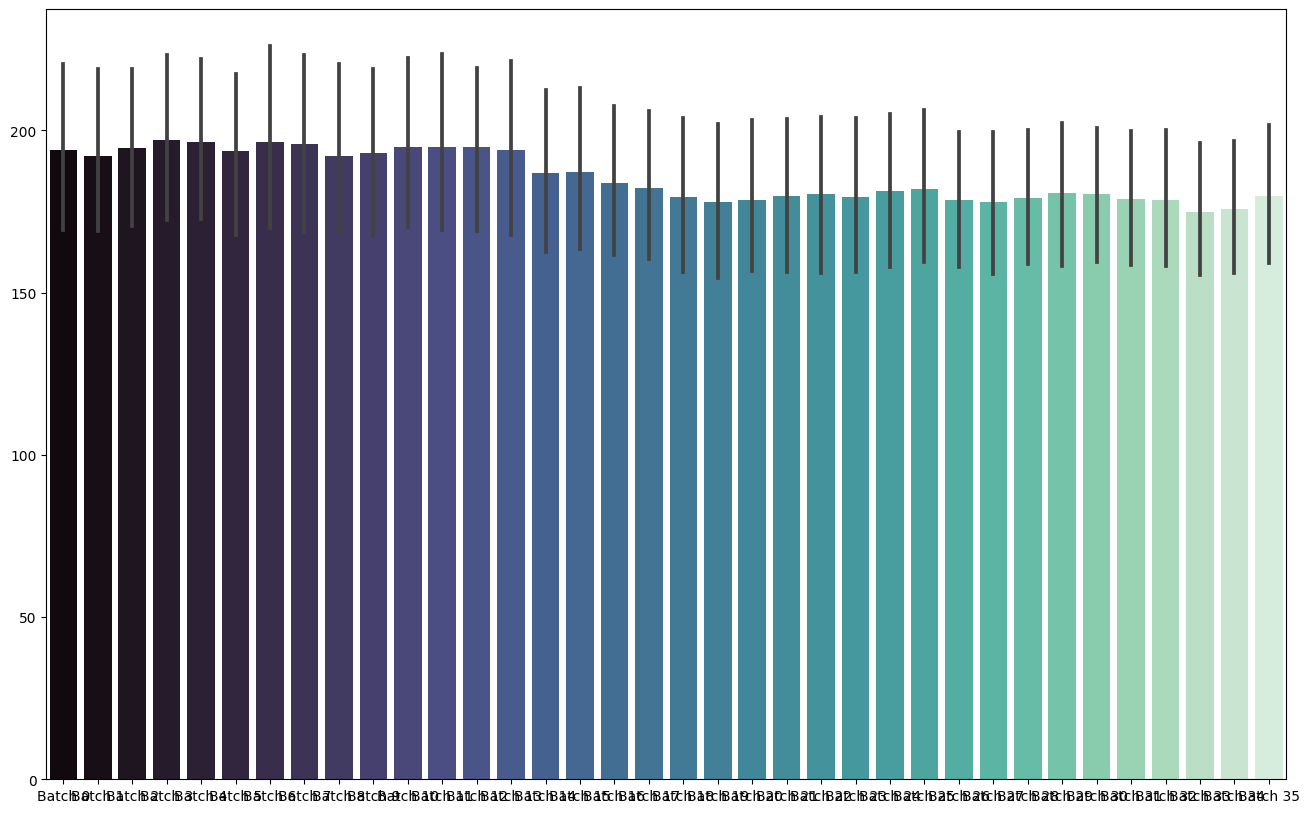

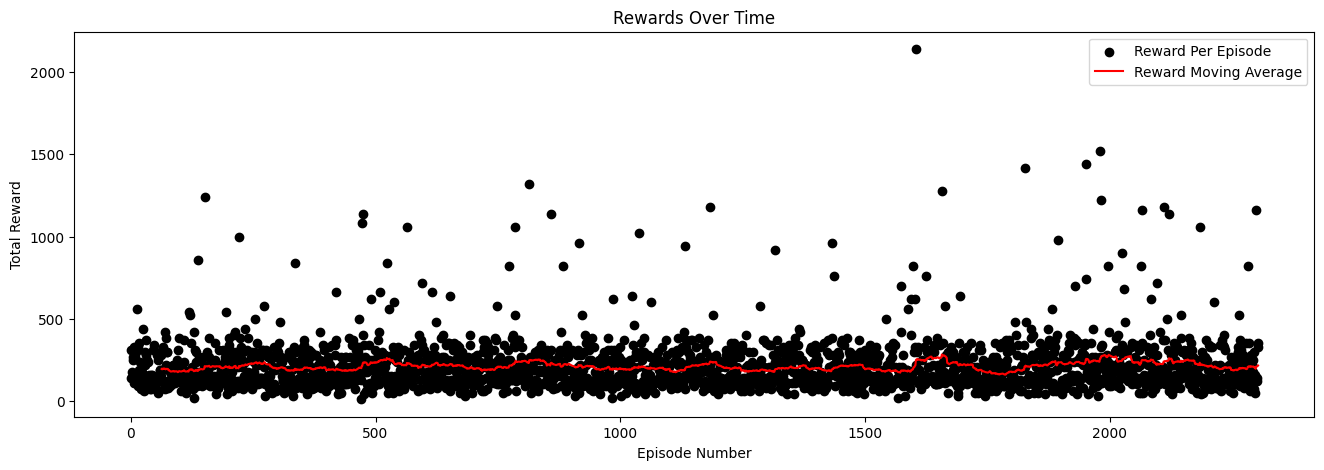

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3123                          
Episode 2304 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6026                          
Episode 2305 of 10240                

500                          
865                          
Episode 2306 of 10240                

500                          
751                          
Episode 2307 of 10240                

500                          
1000                         
1500                          
2000             

4500                          
4519                          
Episode 2338 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4515                          
Episode 2339 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
8000                          
8500                          
9000                       

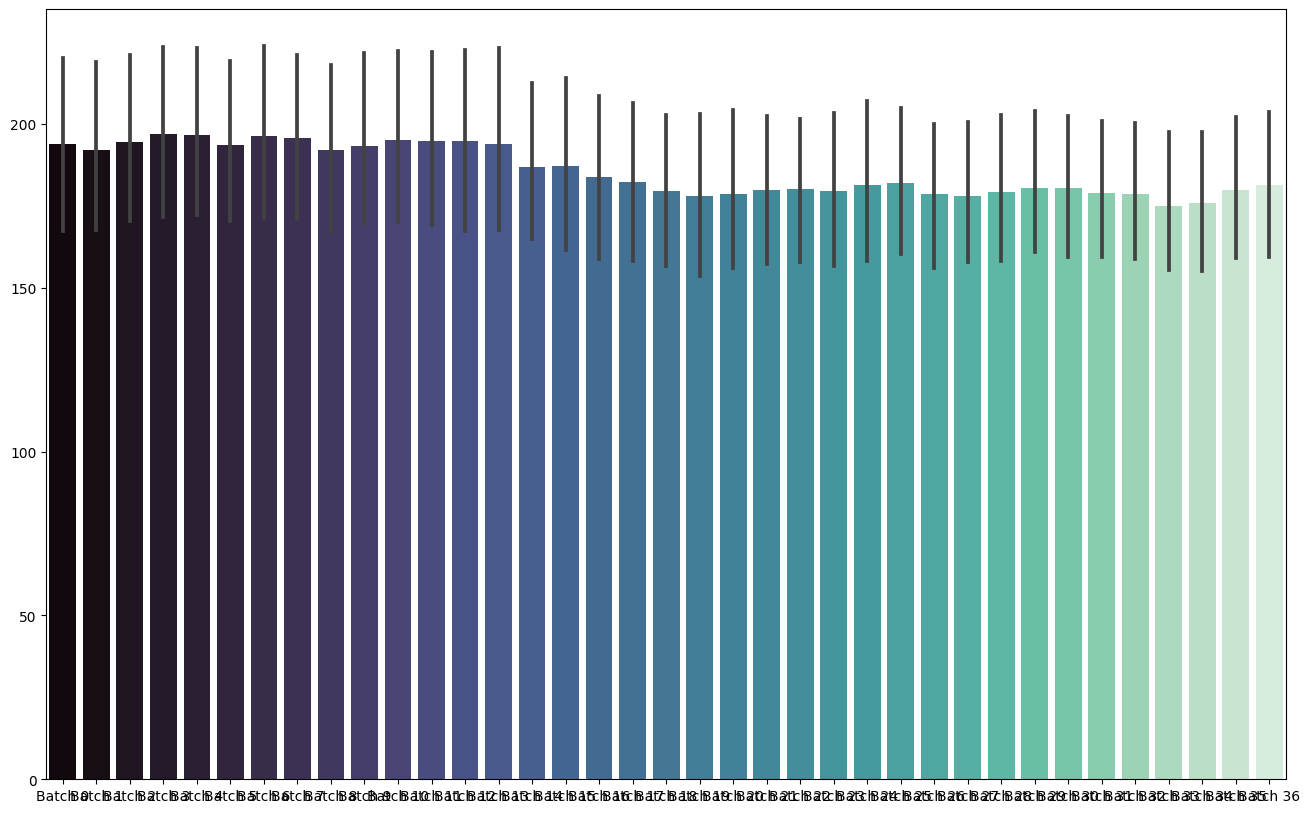

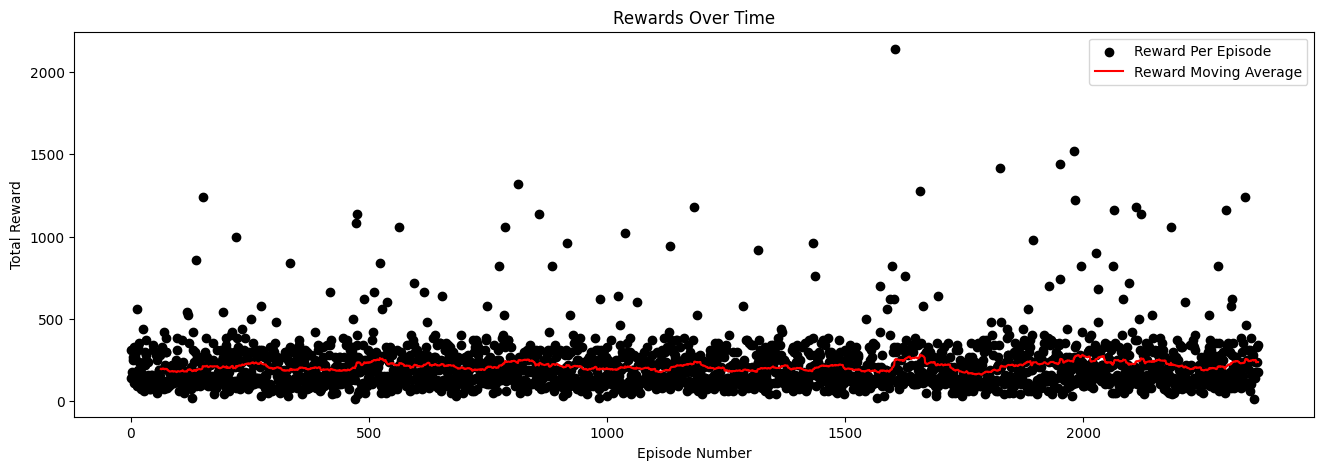

500                          
1000                         
1009                          
Episode 2368 of 10240                

500                          
723                          
Episode 2369 of 10240                

500                          
1000                         
1500                          
2000                          
2096                          
Episode 2370 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3850                          
Episode 2371 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4155                          
Episode 2372 of 1

4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
8000                          
8284                          
Episode 2399 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7075                          
Episode 2400 of 10240                

500                          
1000                         
1500                          
2000                          
2453                          
Episode 2401 of 10240      

500                          
734                          
Episode 2430 of 10240                

500                          
1000                         
1275                          
Episode 2431 of 10240                



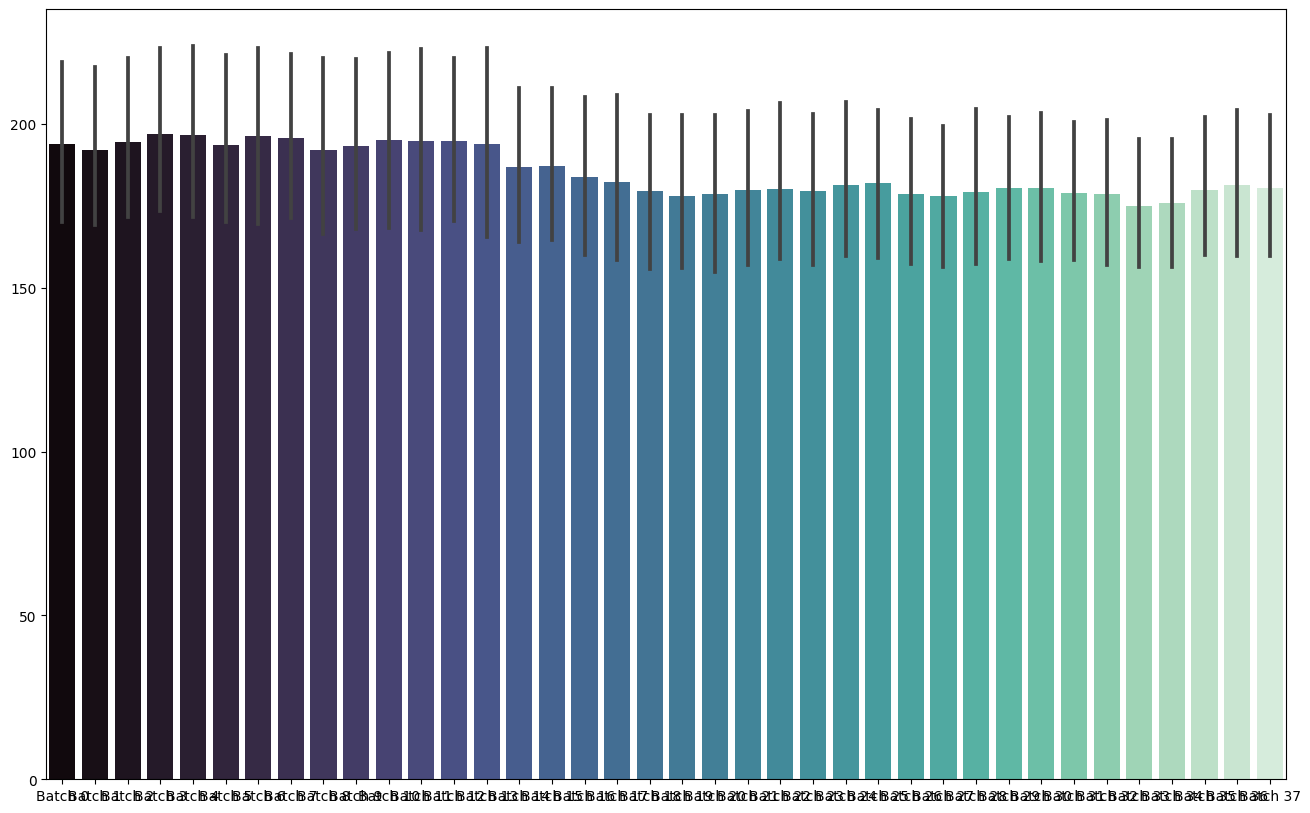

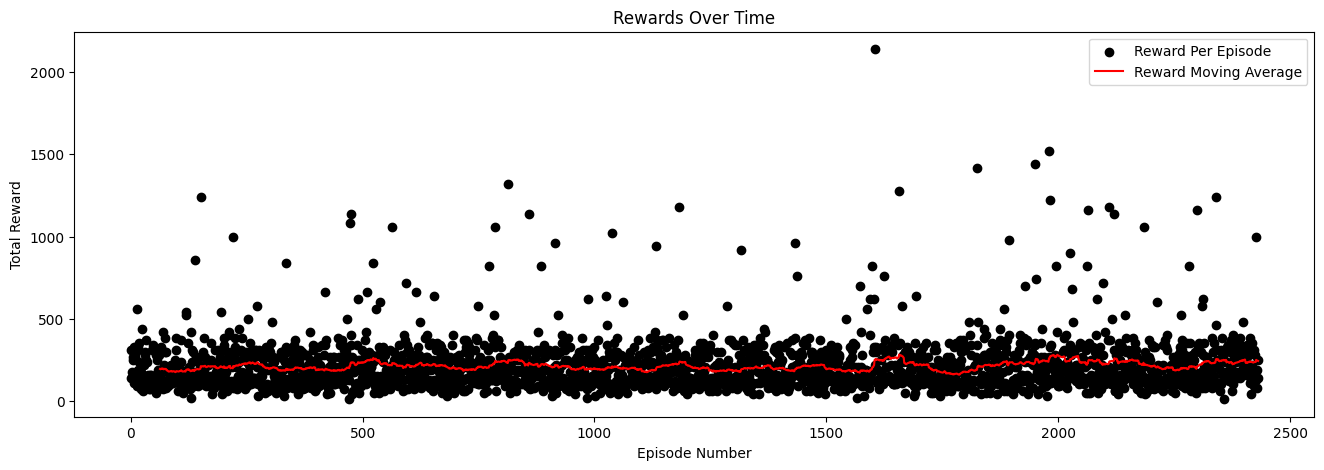

500                          
871                          
Episode 2432 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4730                          
Episode 2433 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
5994                          
Episode 2434 of 10240                

500                          
1000                         
1500                          
2000                          
2500                   

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3059                          
Episode 2464 of 10240                

500                          
511                          
Episode 2465 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
8000                          
8500                          
9000                          
9500                          
9945                          
Episode 2466 of 10240        

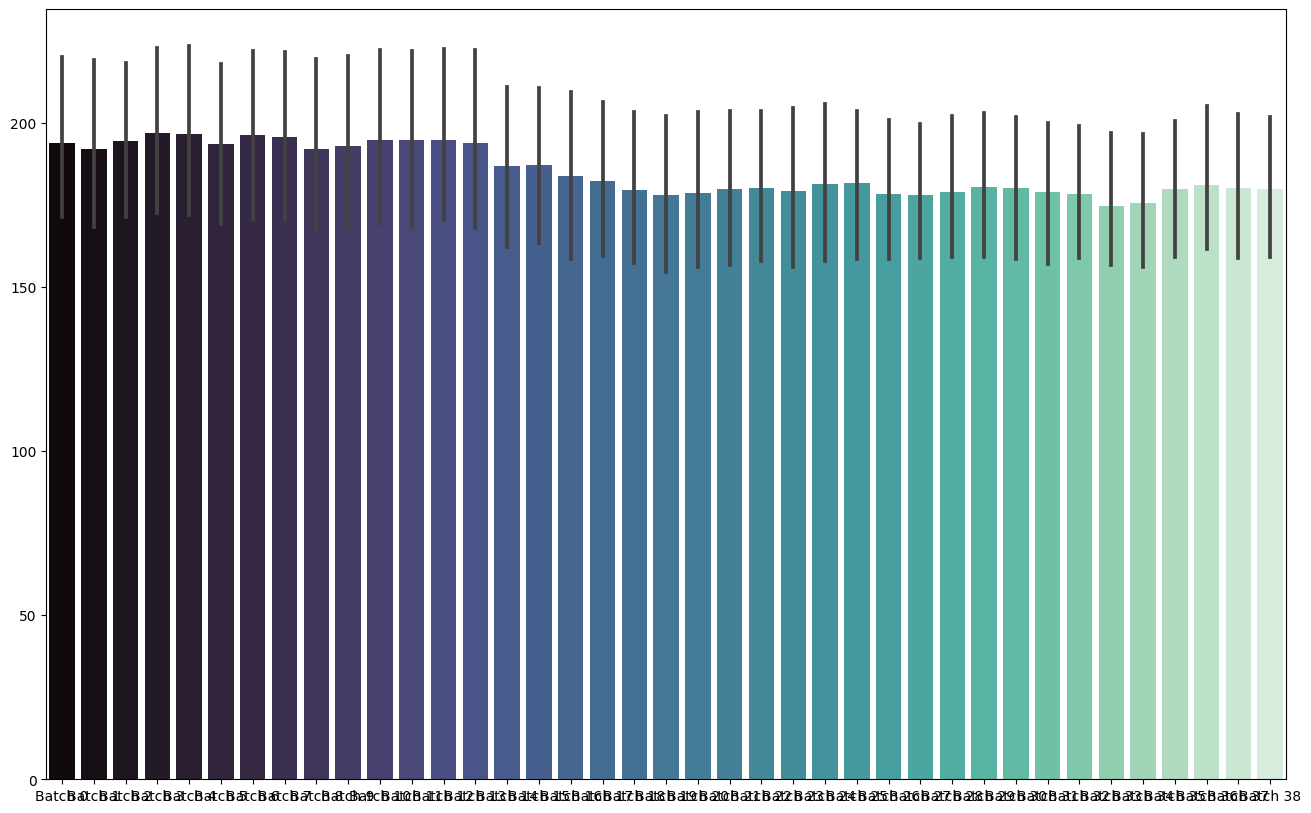

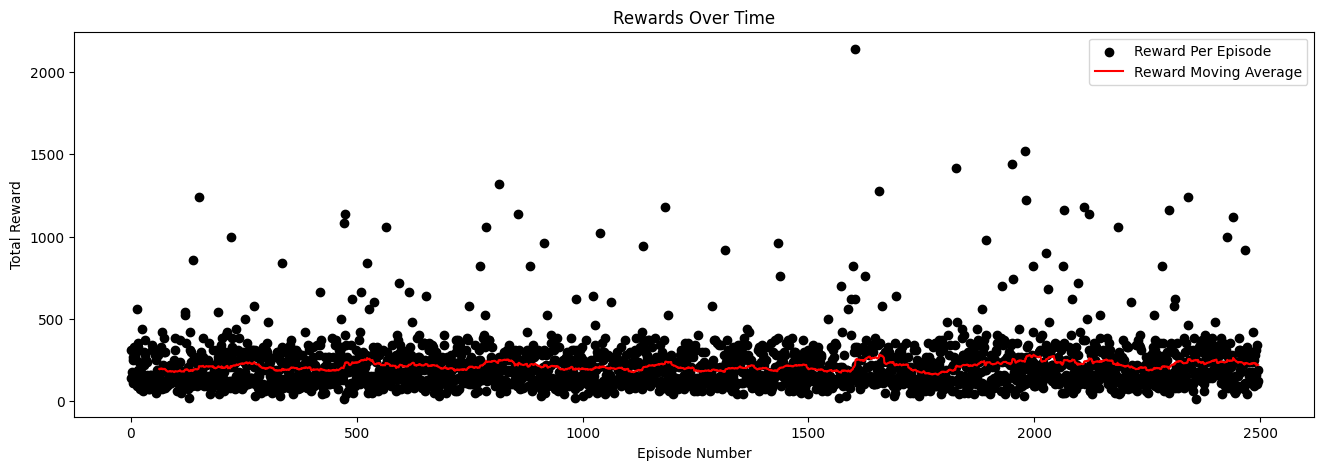

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4718                          
Episode 2496 of 10240                

500                          
1000                         
1361                          
Episode 2497 of 10240                

500                          
1000                         
1162                          
Episode 2498 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3165                          
Episode 2499 of 10240                

500                          
1000                         
1500                          
2000                          
2500             

1500                          
2000                          
2500                          
2640                          
Episode 2531 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2709                          
Episode 2532 of 10240                

500                          
863                          
Episode 2533 of 10240                

500                          
637                          
Episode 2534 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
5760                          
Episode 2535 of 10240                

500    

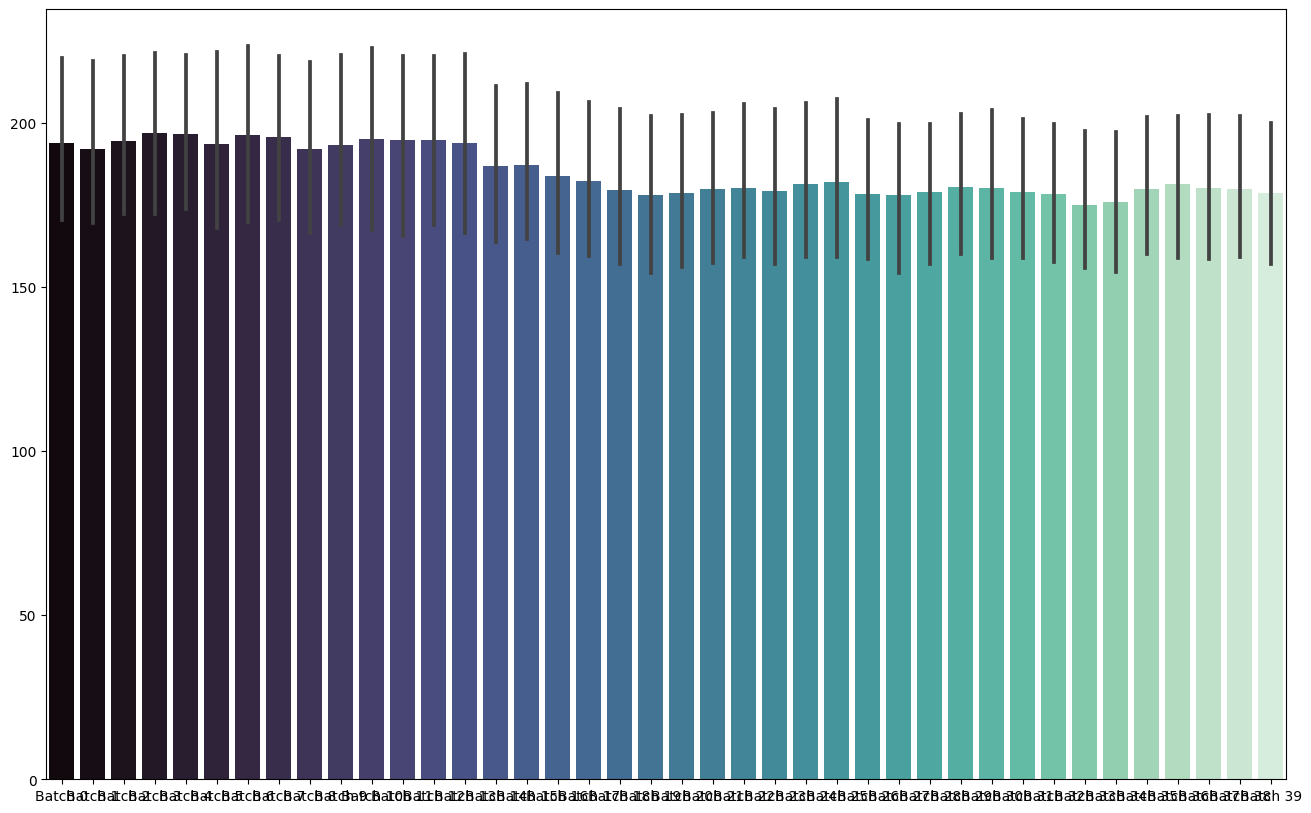

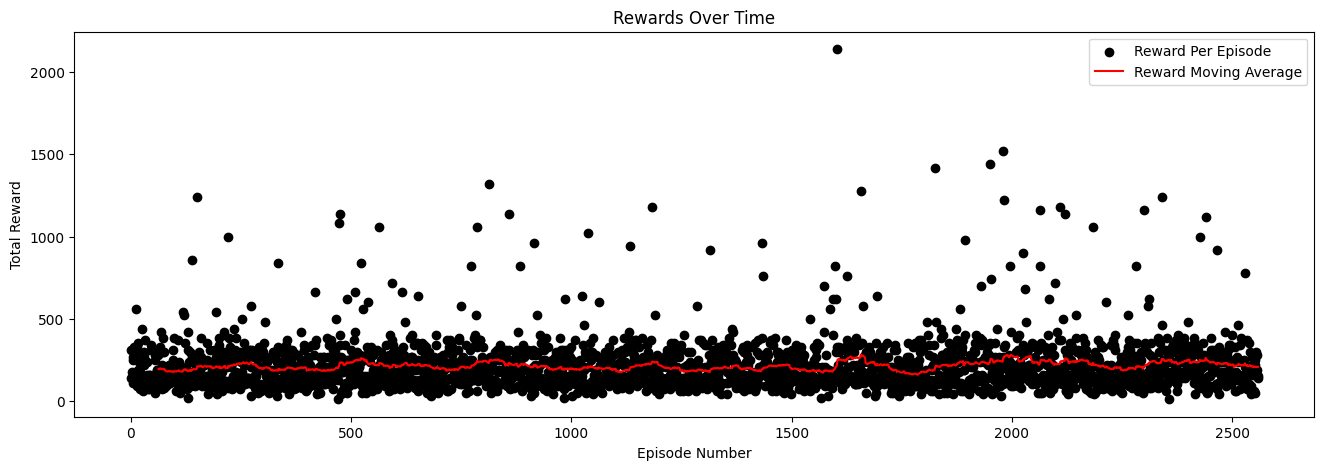

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4382                          
Episode 2560 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4303                          
Episode 2561 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4883                          
Episode 2562 of 10240                

500                  

2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4969                          
Episode 2594 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
7716                          
Episode 2595 of 10240                

500                          
1000                         
1135                          
Episode 2596 of 10240                

500                          
947                          
Episode 2597 of 10240

500                          
559                          
Episode 2620 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3769                          
Episode 2621 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
8000                          
8285                          
Episode 2622 of 10240                

500                          
839                   

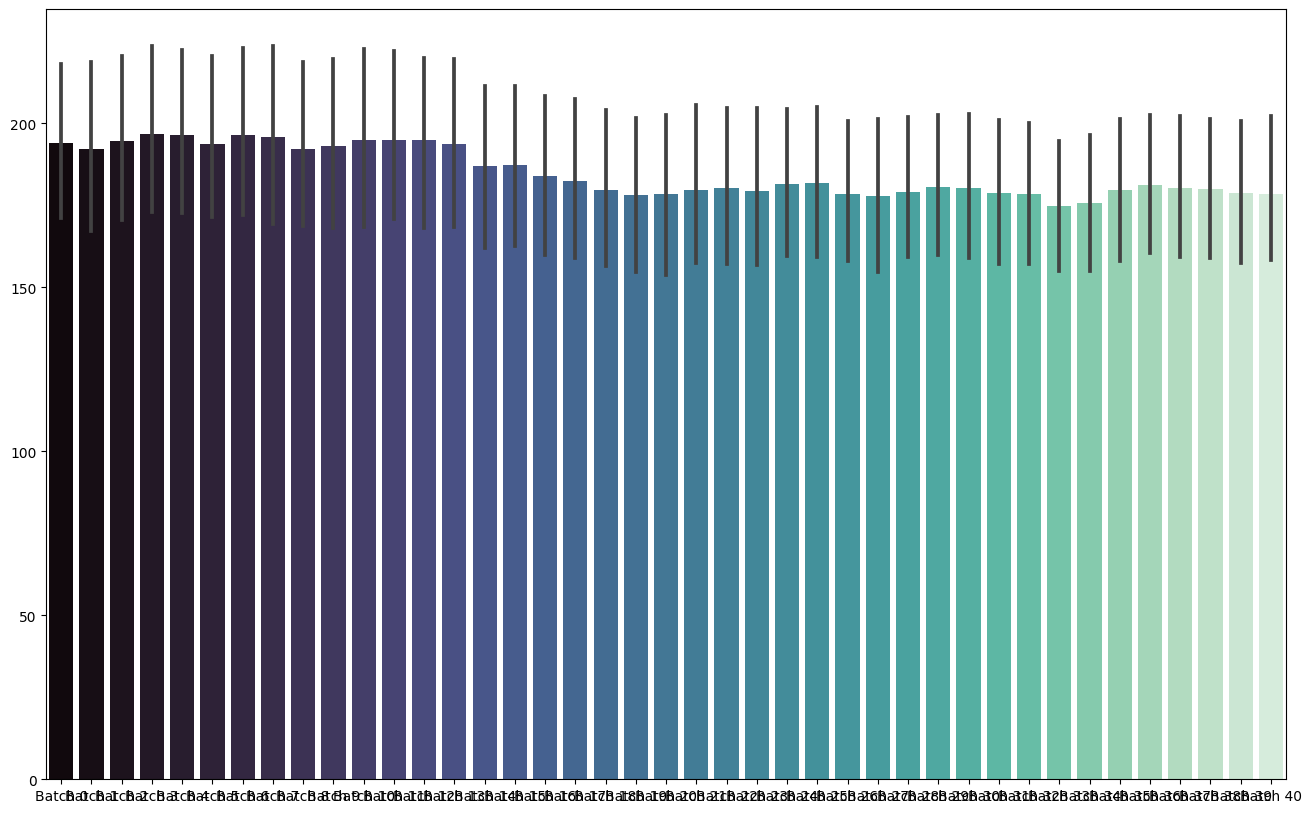

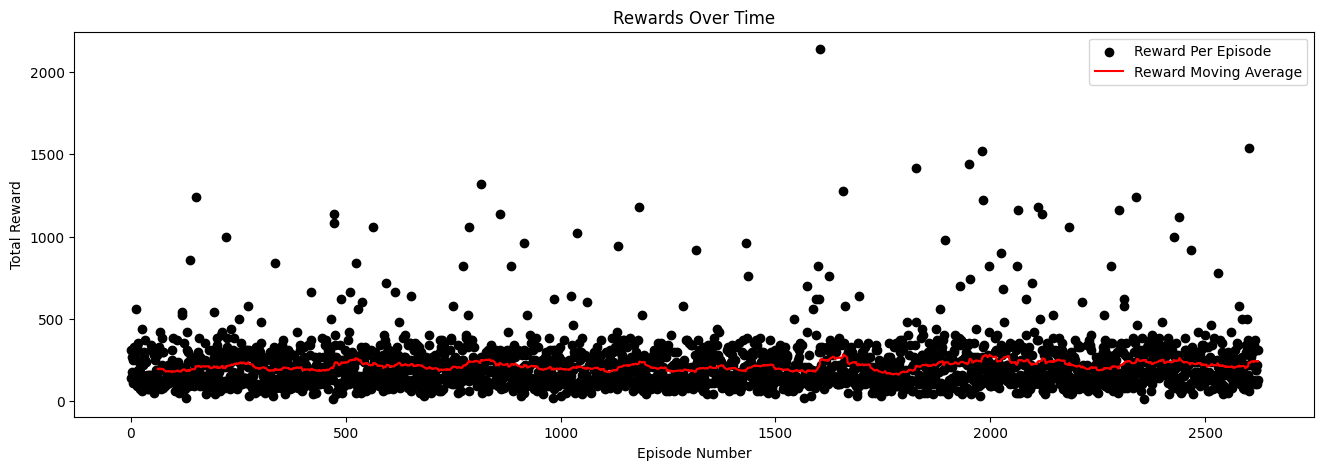

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
6648                          
Episode 2624 of 10240                

500                          
1000                         
1406                          
Episode 2625 of 10240                

500                          
1000                         
1500                          
2000                          
2137                          
Episode 2626 of 10240                

500                          
702                          
Episode 2627 of 10240                

500                          
1000                         
1500                          
2000             

500                          
1000                         
1500                          
1865                          
Episode 2661 of 10240                

500                          
507                          
Episode 2662 of 10240                

500                          
563                          
Episode 2663 of 10240                

500                          
833                          
Episode 2664 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3813                          
Episode 2665 of 10240                

500                          
709                          
Episode 2666 of 10240                

500                          
1000                         
1090                          
Episode 2667 of 10240                

500                         

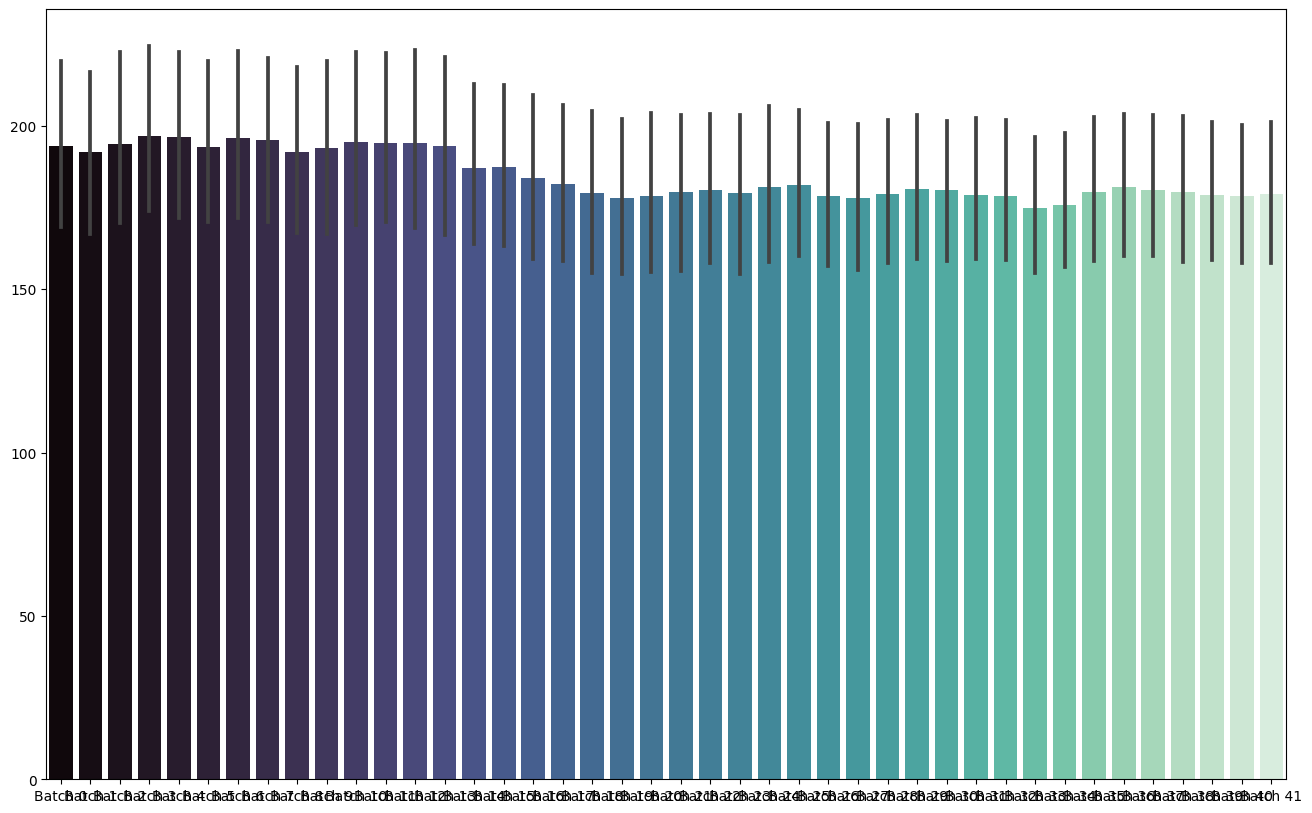

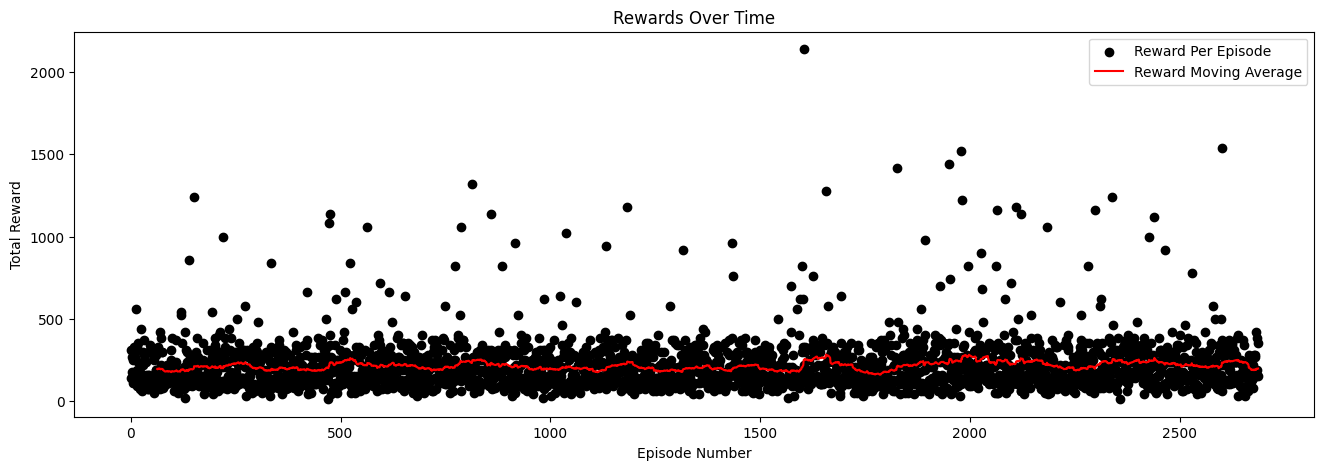

500                          
744                          
Episode 2688 of 10240                

500                          
1000                         
1165                          
Episode 2689 of 10240                

500                          
956                          
Episode 2690 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3560                          
Episode 2691 of 10240                

500                          
1000                         
1293                          
Episode 2692 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3289                          
Episode 2693 of 10240                

500

500                          
1000                         
1500                          
2000                          
2500                          
2858                          
Episode 2719 of 10240                

500                          
1000                         
1209                          
Episode 2720 of 10240                

500                          
659                          
Episode 2721 of 10240                

500                          
1000                         
1500                          
1507                          
Episode 2722 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500             

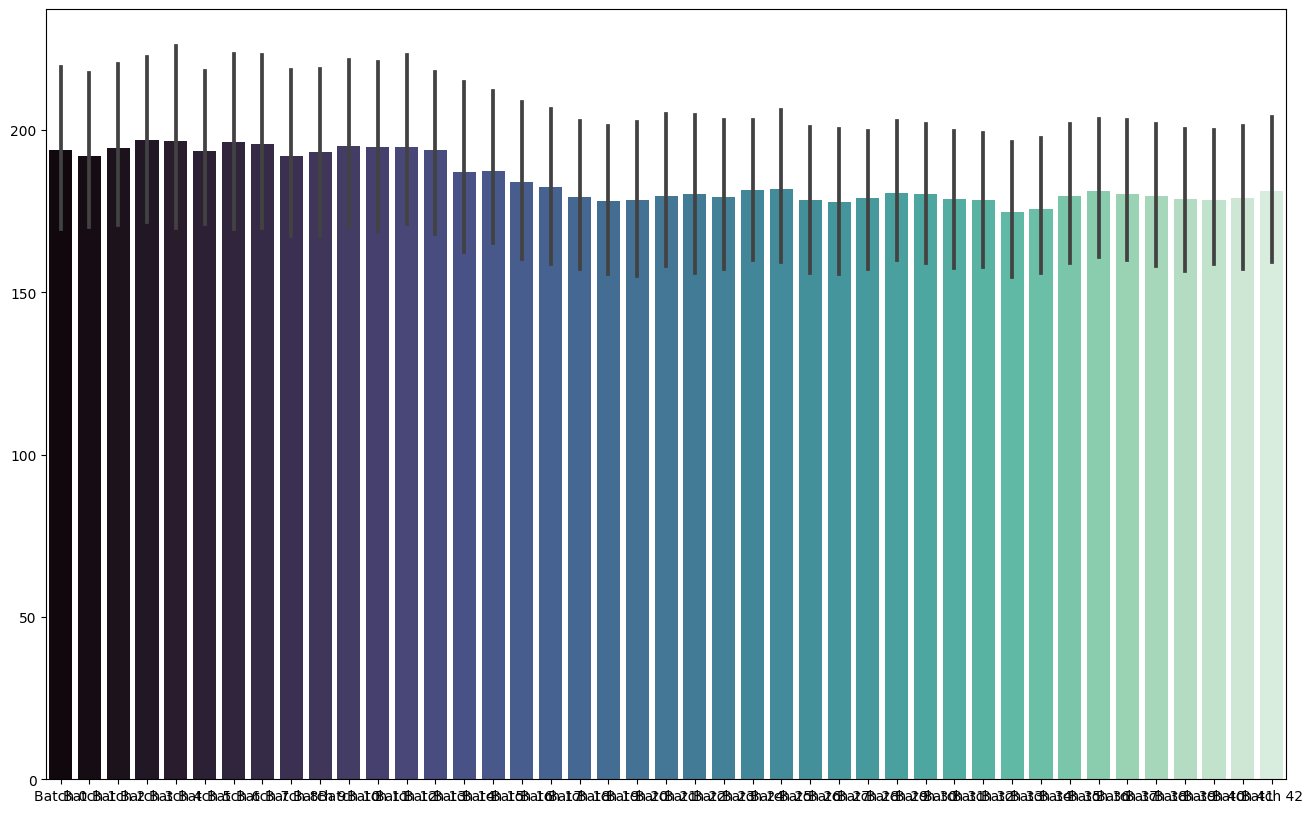

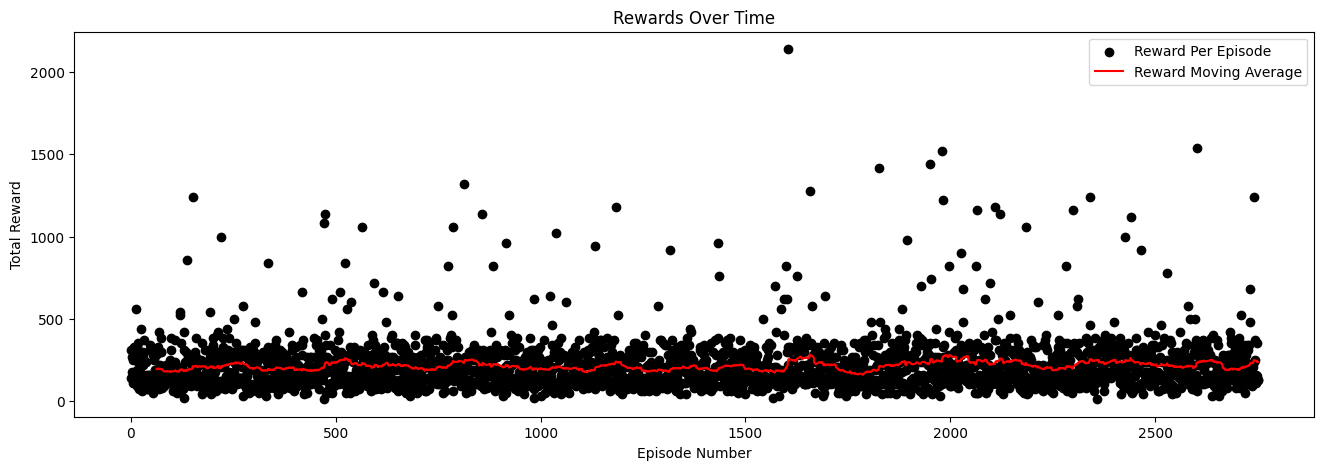

500                          
1000                         
1358                          
Episode 2752 of 10240                

500                          
778                          
Episode 2753 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
7903                          
Episode 2754 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3105                          
Episode 2755 of 10240  

2000                          
2500                          
3000                          
3500                          
3960                          
Episode 2785 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
6888                          
Episode 2786 of 10240                

500                          
1000                         
1500                          
1882                          
Episode 2787 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                 

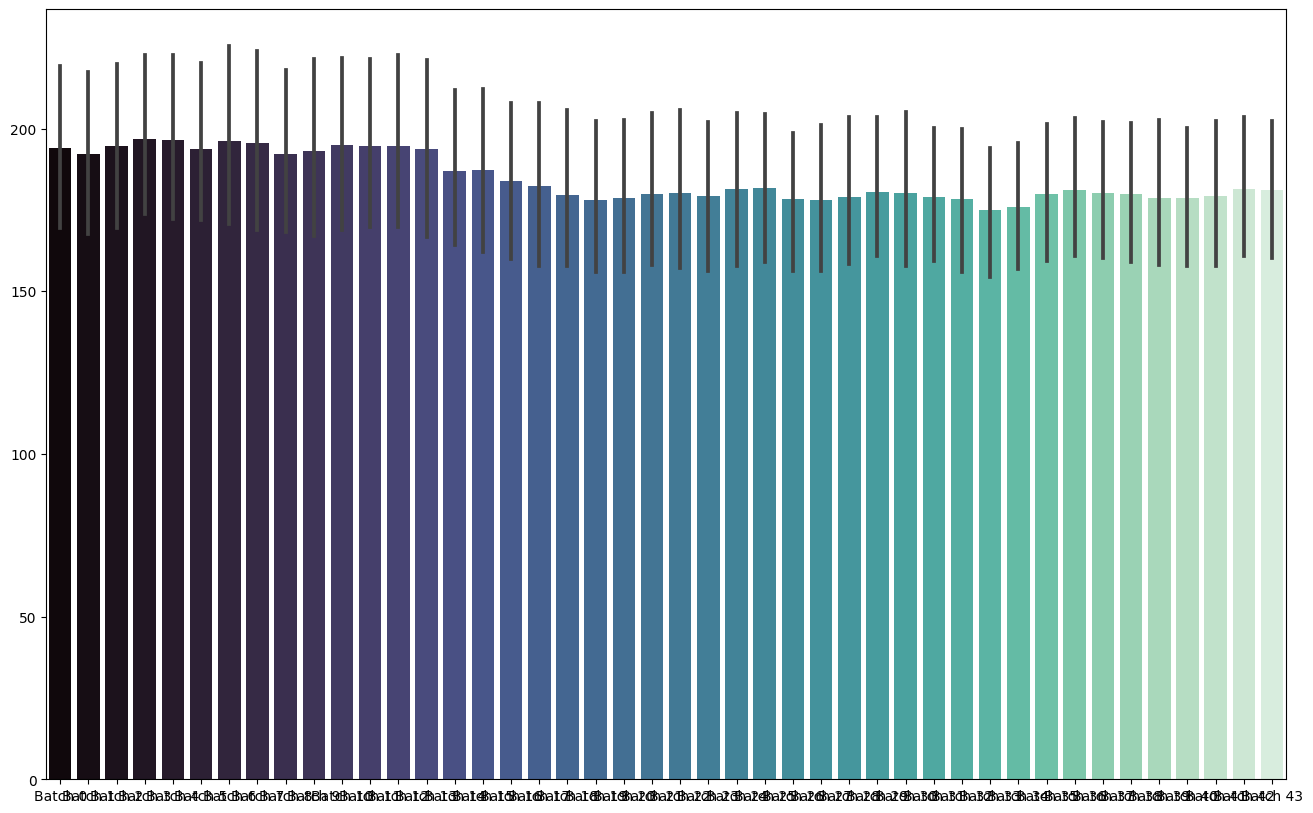

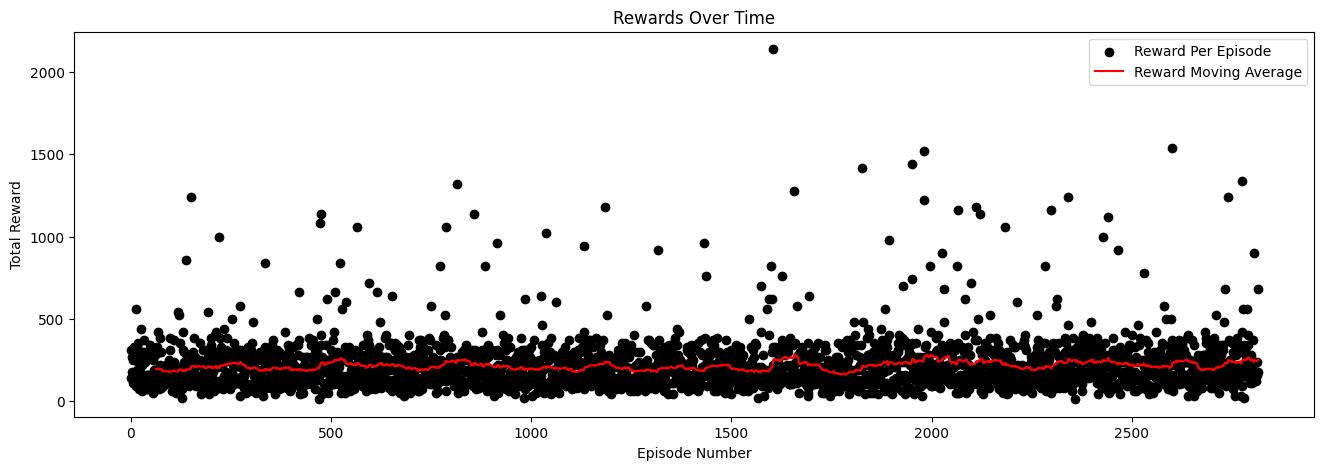

500                          
1000                         
1107                          
Episode 2816 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2821                          
Episode 2817 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4837                          
Episode 2818 of 10240                

500                          
1000                         
1327                          
Episode 2819 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000             

1764                          
Episode 2853 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4723                          
Episode 2854 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2913                          
Episode 2855 of 10240                

500                          
675                          
Episode 2856 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500           

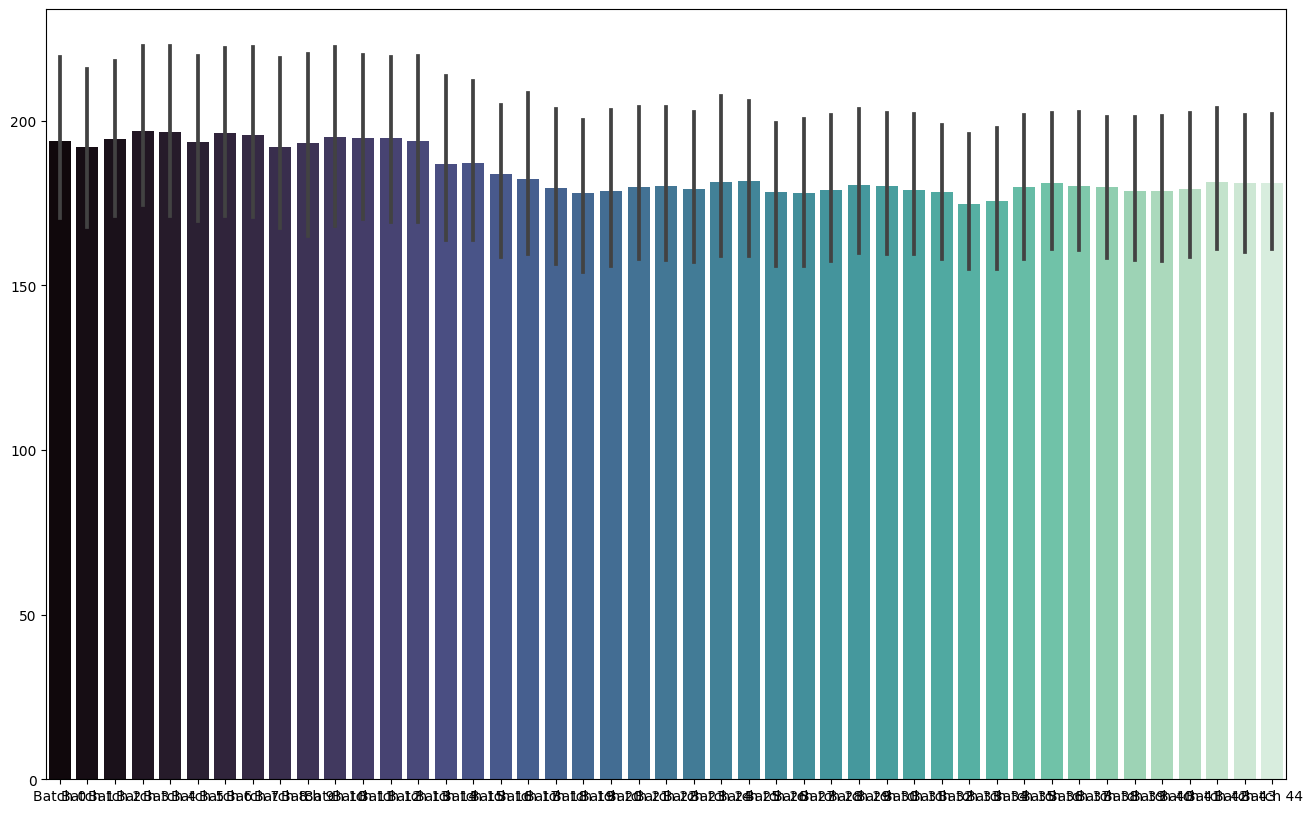

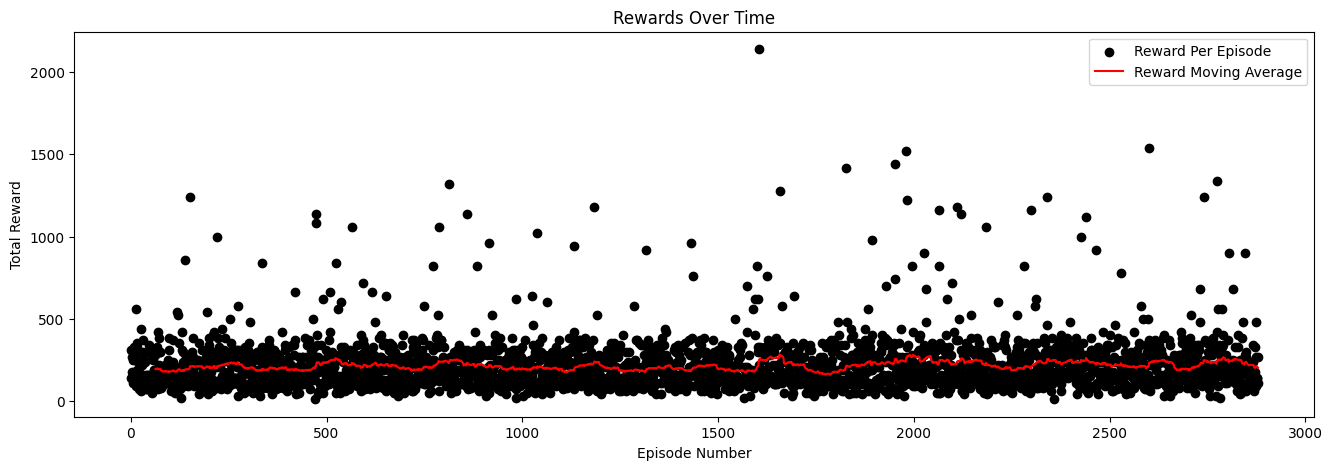

500                          
1000                         
1500                          
2000                          
2500                          
2567                          
Episode 2880 of 10240                

500                          
1000                         
1388                          
Episode 2881 of 10240                

500                          
771                          
Episode 2882 of 10240                

500                          
1000                         
1438                          
Episode 2883 of 10240                

500                          
1000                         
1500                          
1568                          
Episode 2884 of 10240                

500                          
1000                         
1156                          
Episode 2885 of 10240                

500                          
1000                         
1500                          
2000                          
2202 

1566                          
Episode 2920 of 10240                

500                          
1000                         
1500                          
2000                          
2033                          
Episode 2921 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3172                          
Episode 2922 of 10240                

500                          
1000                         
1043                          
Episode 2923 of 10240                

500                          
516                          
Episode 2924 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500     

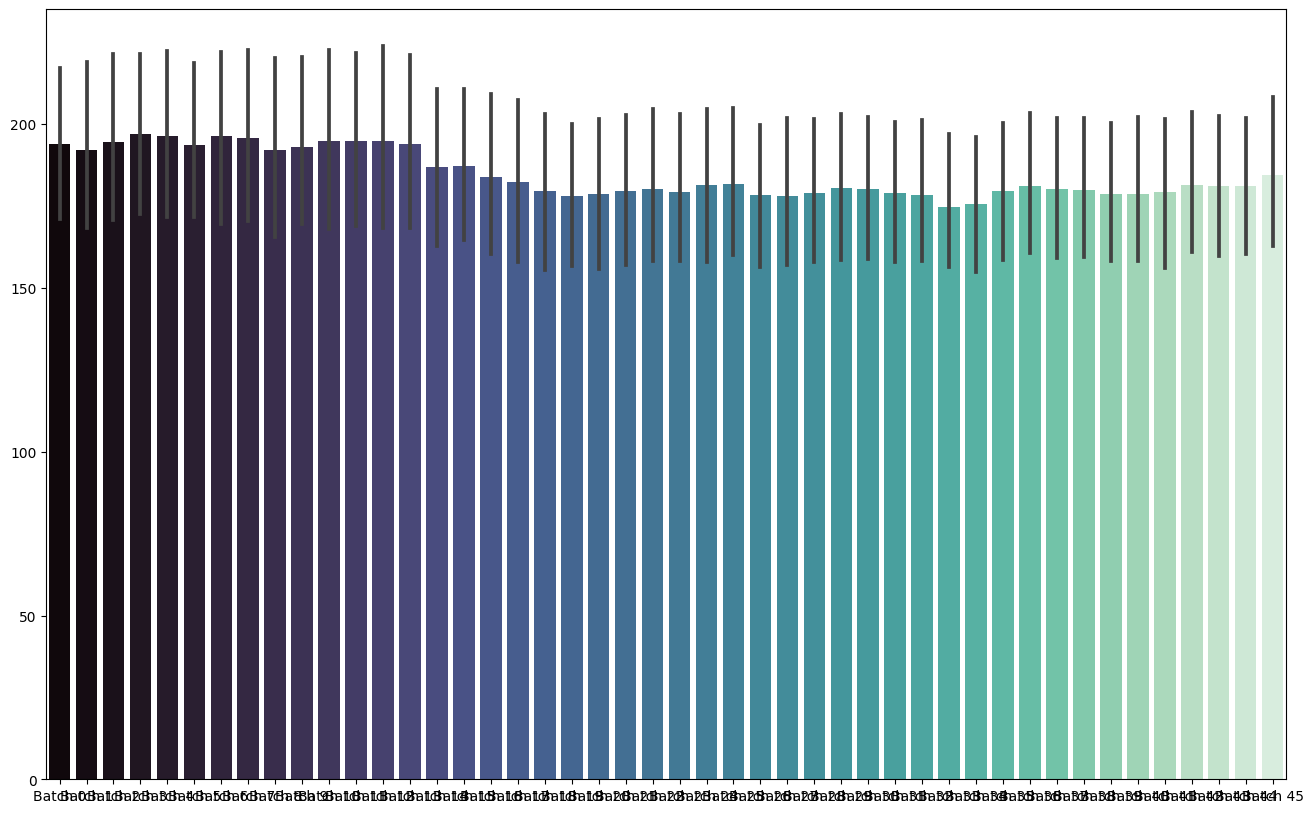

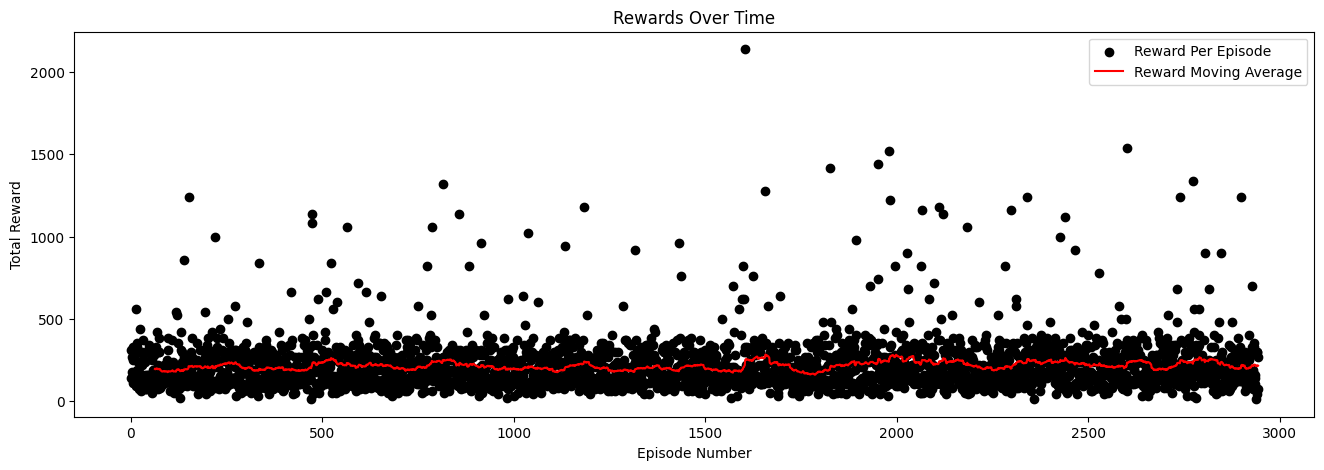

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3325                          
Episode 2944 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4807                          
Episode 2945 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                         

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7217                          
Episode 2980 of 10240                

500                          
905                          
Episode 2981 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2796                          
Episode 2982 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                   

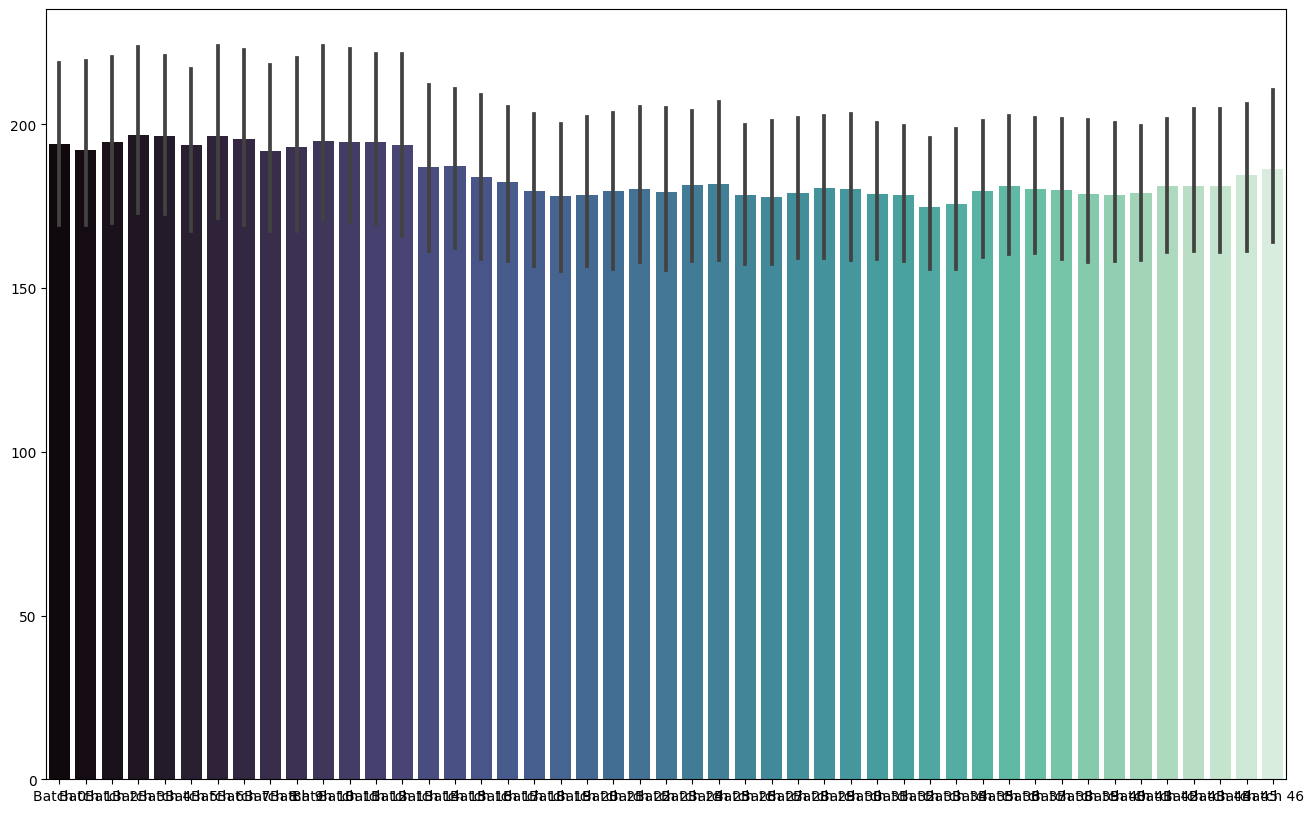

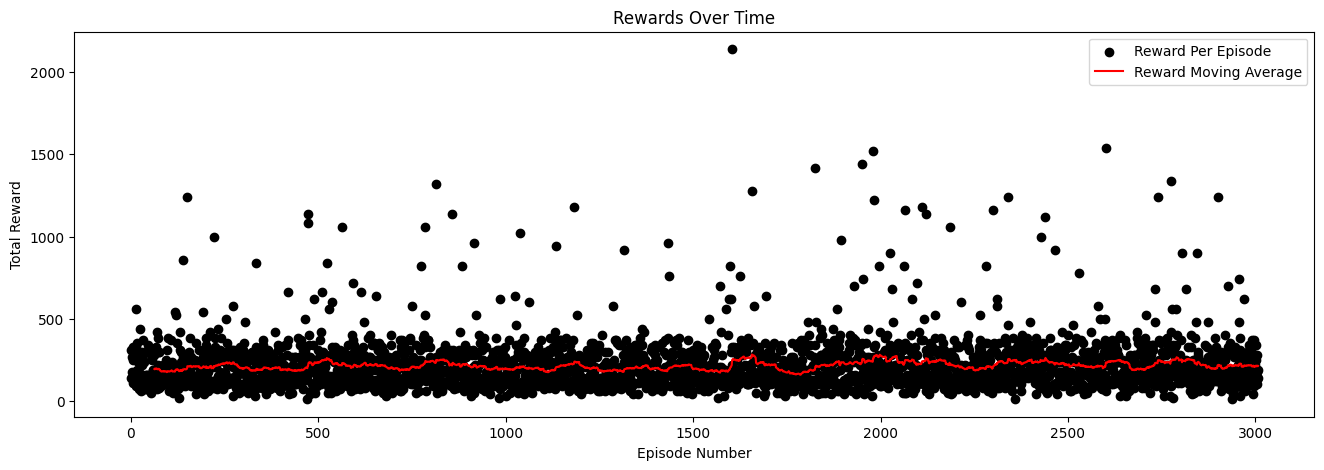

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
7555                          
Episode 3008 of 10240                

500                          
1000                         
1500                          
2000                          
2425                          
Episode 3009 of 10240                

500                          
1000                         
1500                          
2000                          
2377                          
Episode 3010 of 10240                

500                          
1000                         
1500                   

3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
6944                          
Episode 3041 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2860                          
Episode 3042 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3519                          
Episode 3043 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                 

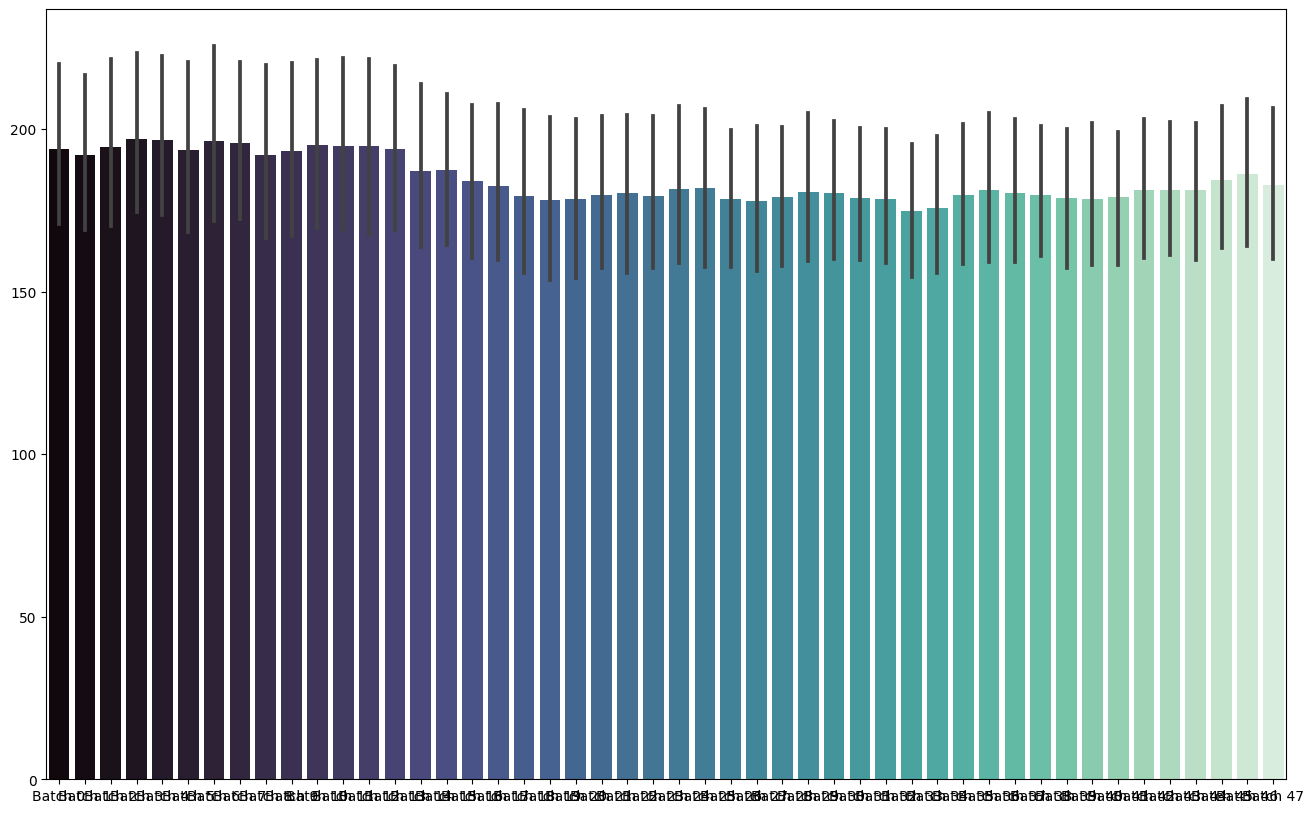

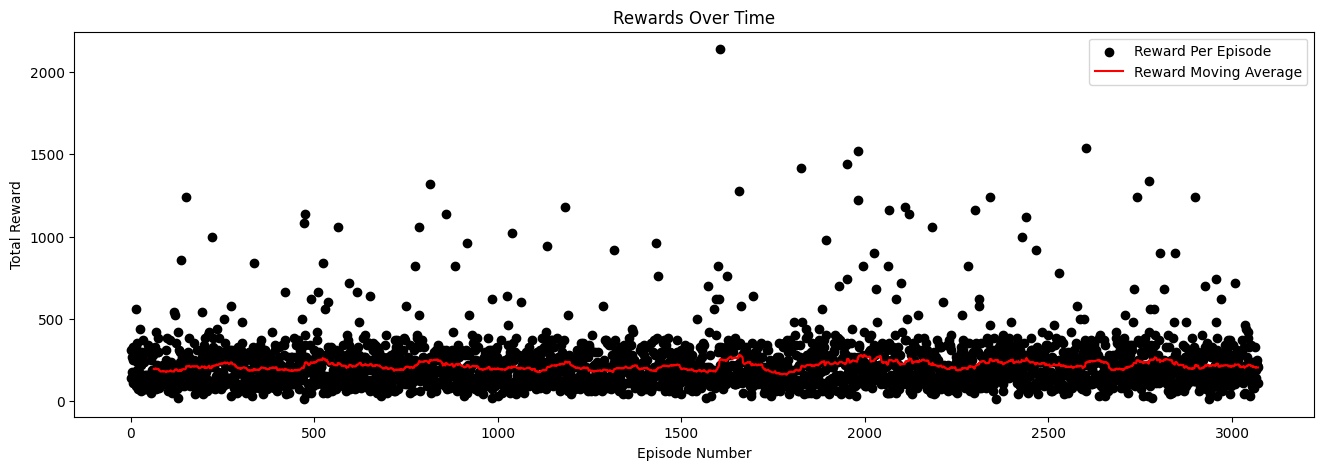

500                          
1000                         
1090                          
Episode 3072 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3483                          
Episode 3073 of 10240                

500                          
1000                         
1008                          
Episode 3074 of 10240                

500                          
692                          
Episode 3075 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3467                          
Episode 3076 of 10240                

500                          
1000                         
1500                          
2000                          
2500       

500                          
998                          
Episode 3109 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4258                          
Episode 3110 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4755                          
Episode 3111 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2546                          
Episode 3112 of 10240                

500            

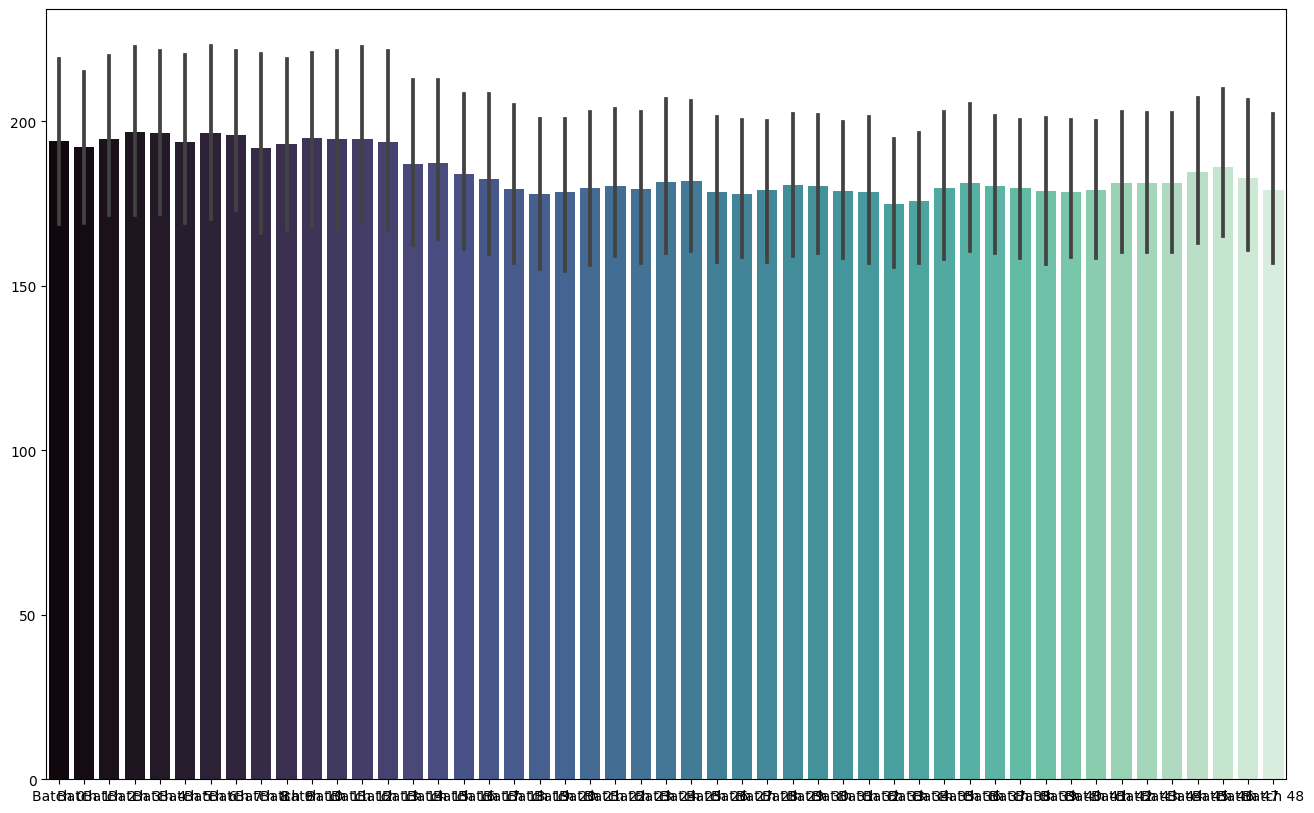

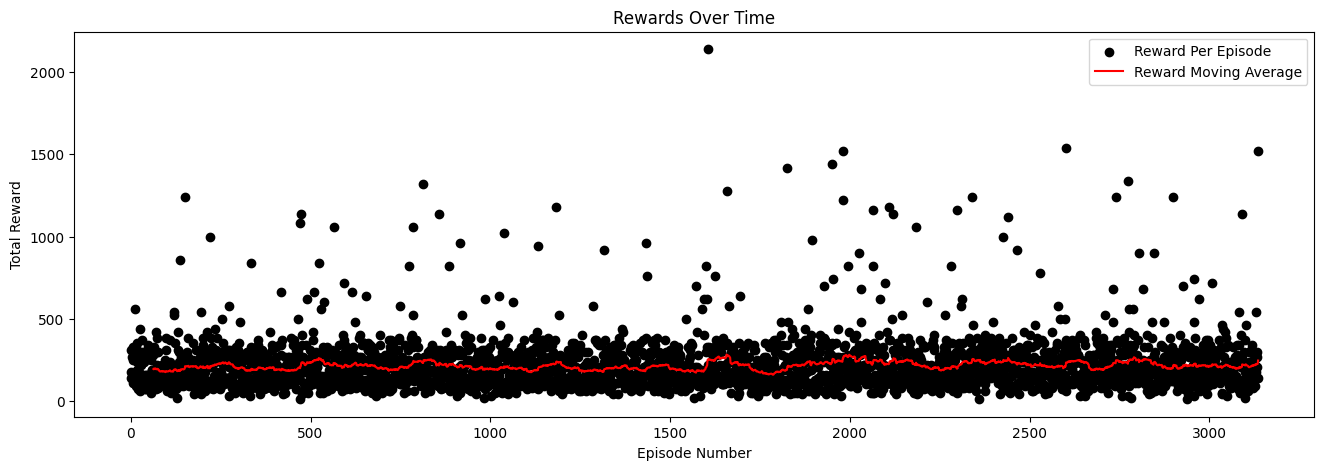

500                          
1000                         
1036                          
Episode 3136 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4882                          
Episode 3137 of 10240                

500                          
828                          
Episode 3138 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4389                          
Episode 3139 of 10240                

500                          
1000                         
1500                          
2000             

3000                          
3500                          
4000                          
4500                          
4883                          
Episode 3166 of 10240                

500                          
1000                         
1500                          
1625                          
Episode 3167 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5397                          
Episode 3168 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3107                          
Episode 3169 of 10240                

500          

1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
6564                          
Episode 3198 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7307                          
Episode 3199 of 10240                



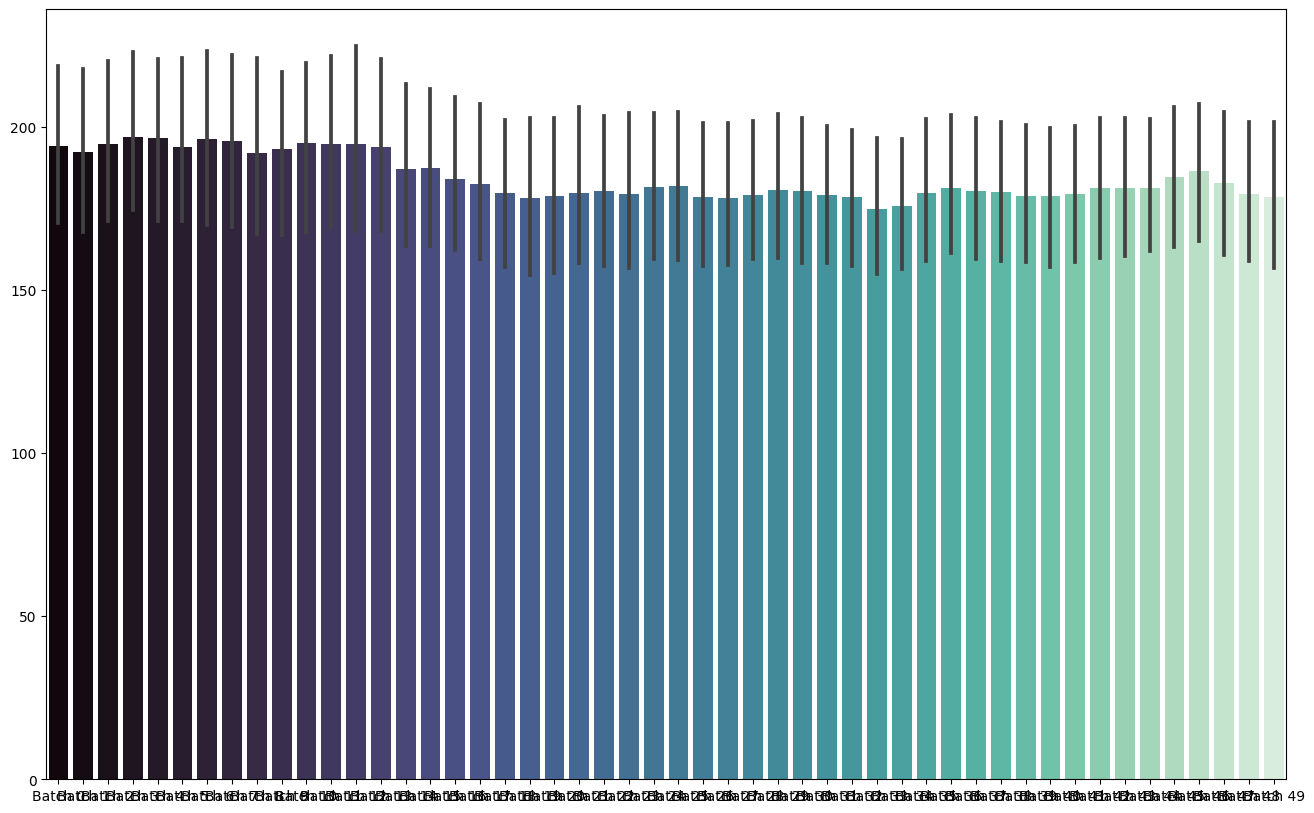

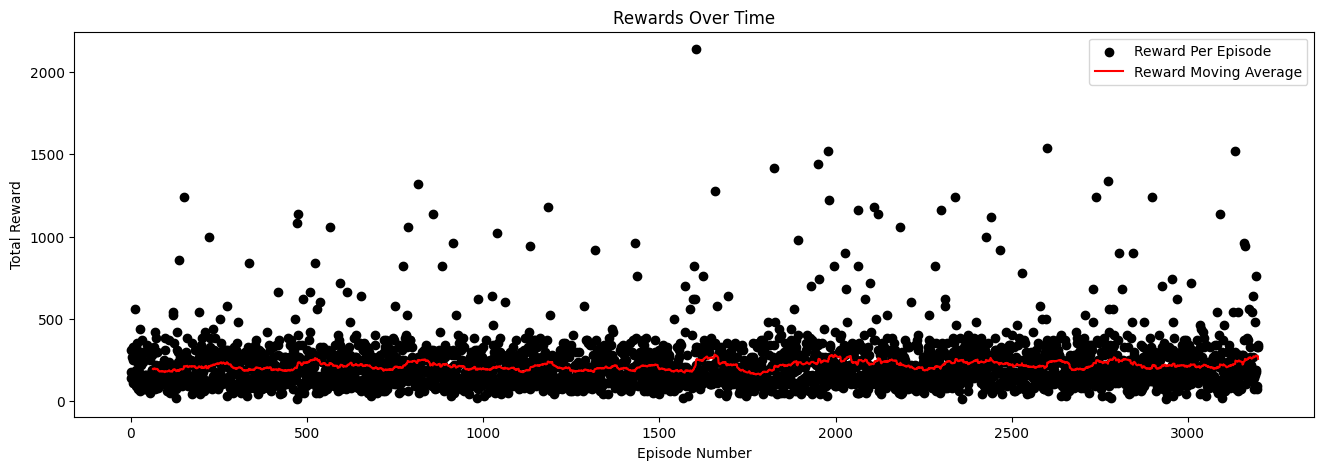

500                          
1000                         
1500                          
1660                          
Episode 3200 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4608                          
Episode 3201 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
8000                         

1809                          
Episode 3237 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3486                          
Episode 3238 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4313                          
Episode 3239 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4673                          
Episode 3240 of 10240                

500          

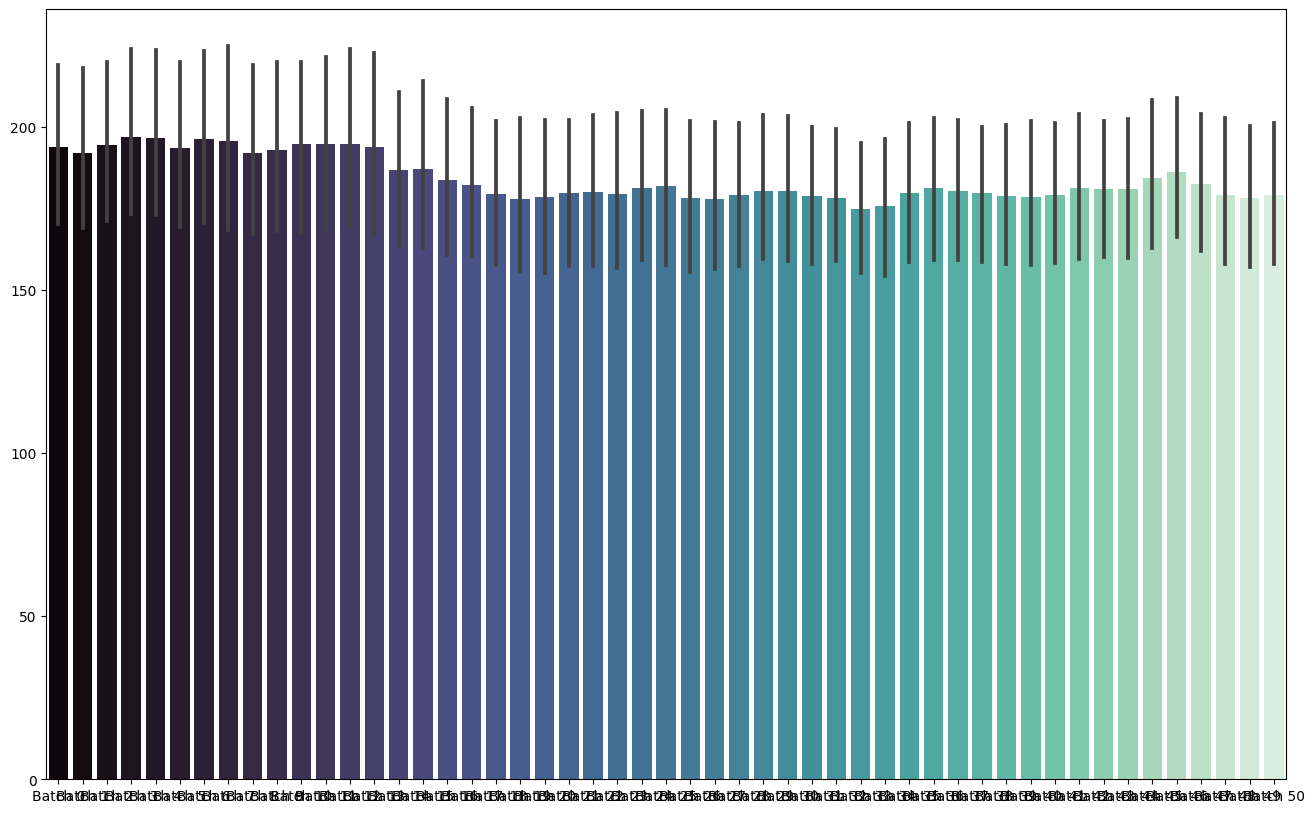

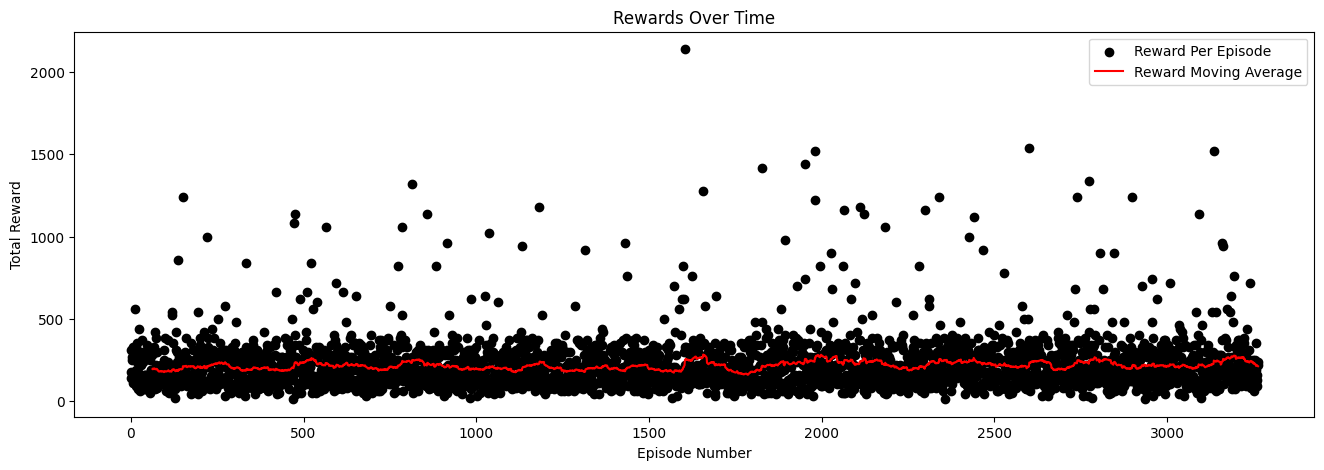

500                          
1000                         
1060                          
Episode 3264 of 10240                

500                          
701                          
Episode 3265 of 10240                

500                          
771                          
Episode 3266 of 10240                

500                          
1000                         
1154                          
Episode 3267 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3051                          
Episode 3268 of 10240                

299                          
Episode 3269 of 10240                

500                          
1000                         
1500                          
1548                          
Episode 3270 of 10240                

500                          
1000                        

4215                          
Episode 3302 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2746                          
Episode 3303 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5139                          
Episode 3304 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                 

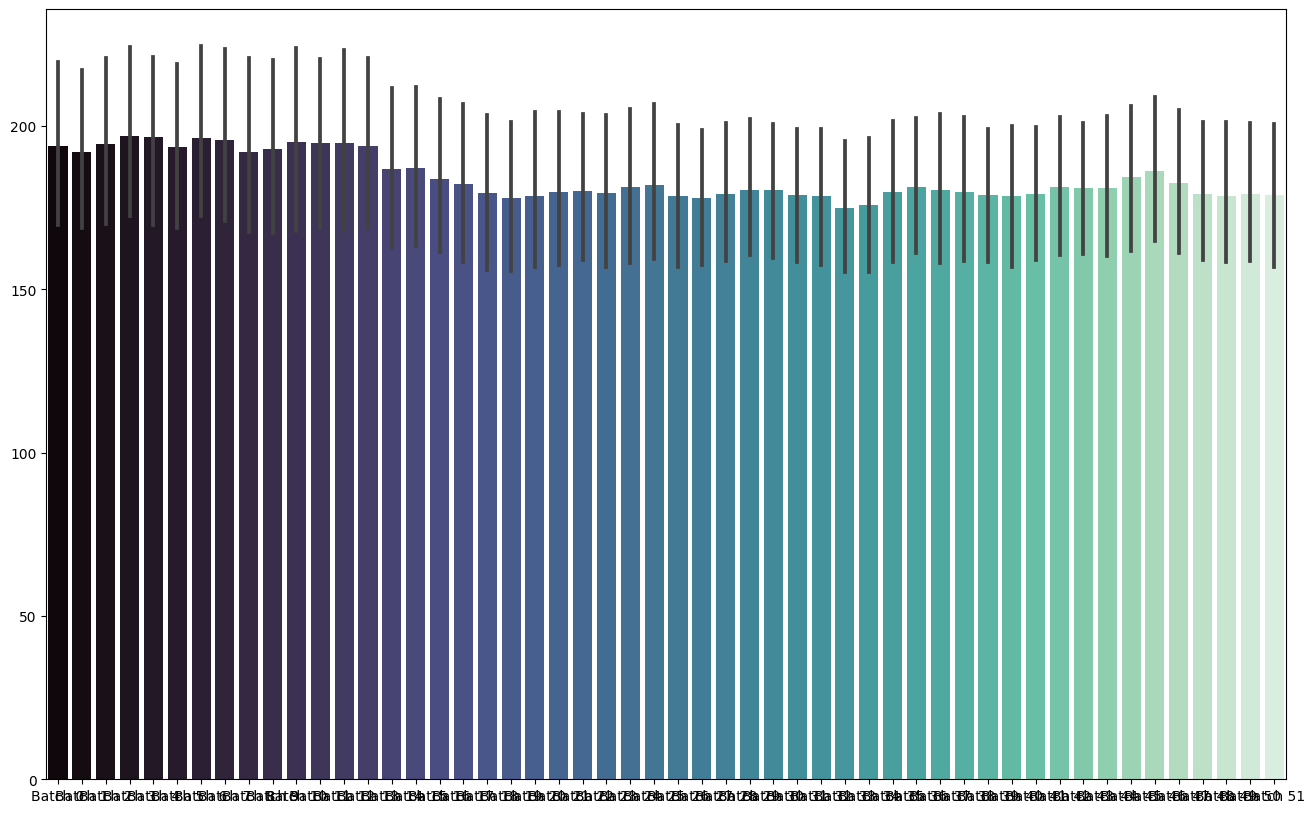

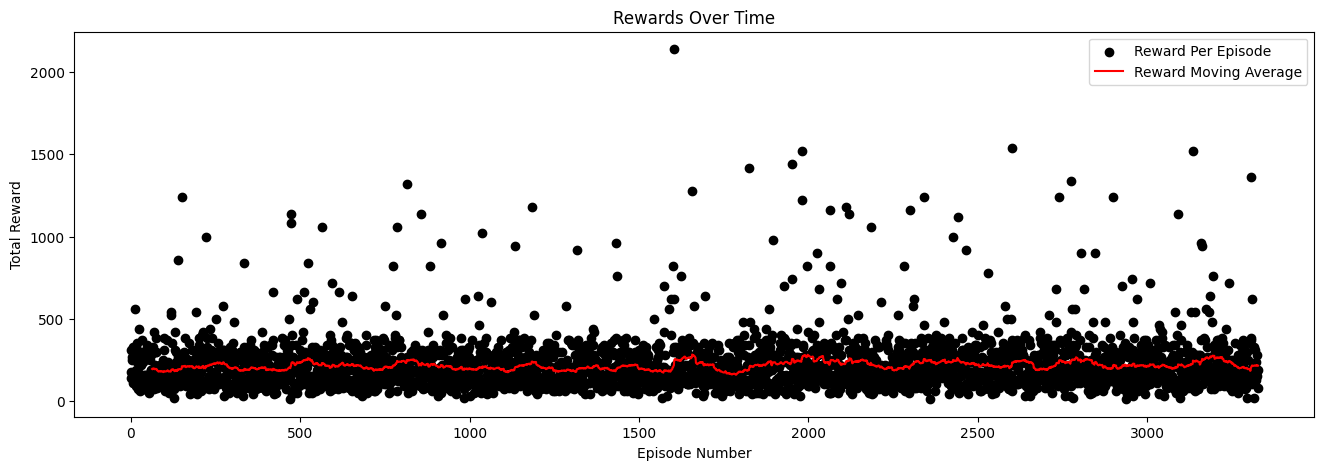

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
8000                          
8500                          
9000                          
9311                          
Episode 3328 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5041                          
Episode 3329 of 10240              

500                          
1000                         
1500                          
1881                          
Episode 3364 of 10240                

500                          
784                          
Episode 3365 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
8000                          
8007                          
Episode 3366 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                   

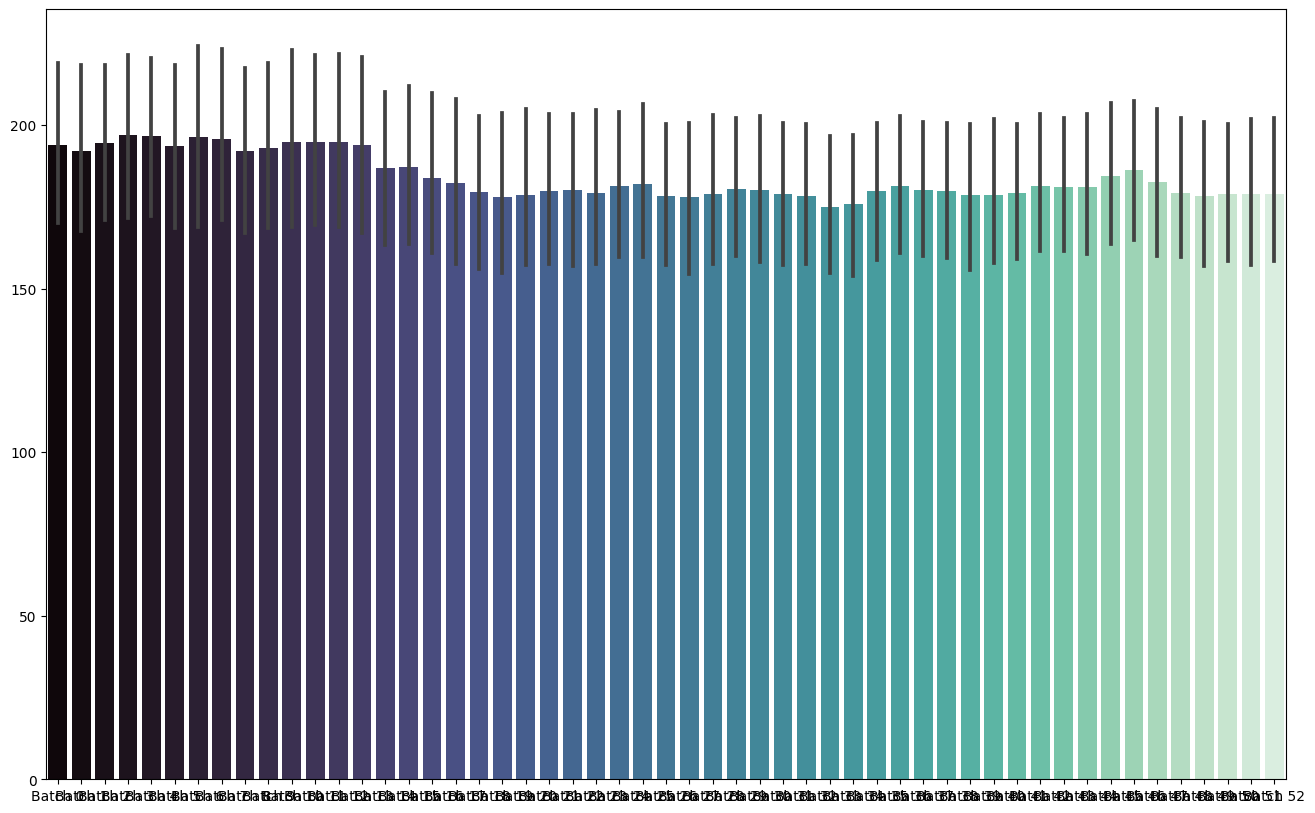

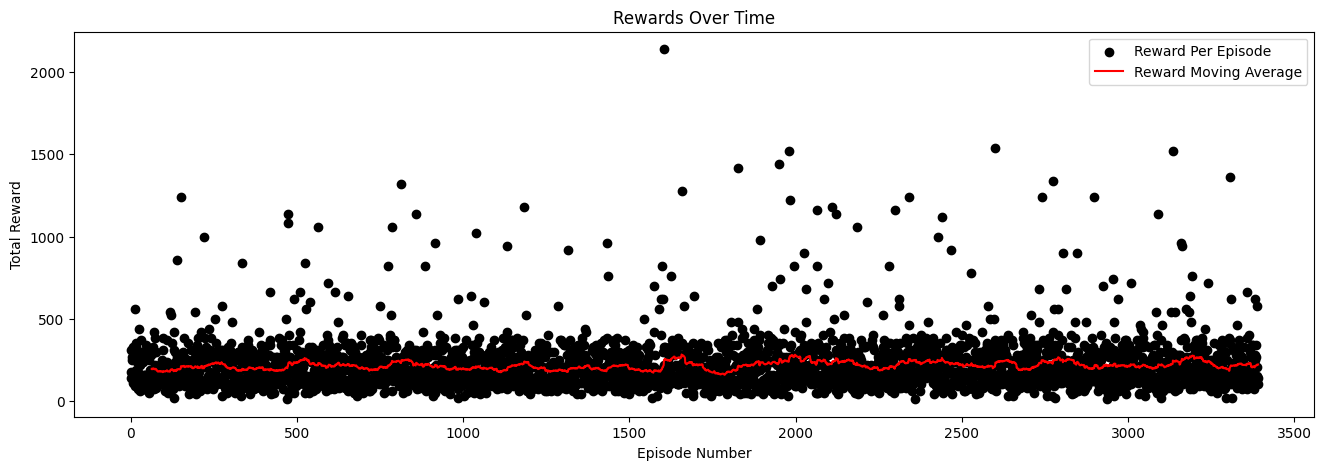

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3250                          
Episode 3392 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
7892                          
Episode 3393 of 10240                

500                          
721                          
Episode 3394 of 10240                

500                          
1000                         
1500                          
2000                   

2000                          
2500                          
3000                          
3407                          
Episode 3422 of 10240                

500                          
740                          
Episode 3423 of 10240                

500                          
1000                         
1500                          
1792                          
Episode 3424 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2800                          
Episode 3425 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3860                          
Episode 3426 of 10240                

500                          
1000                         
1500     

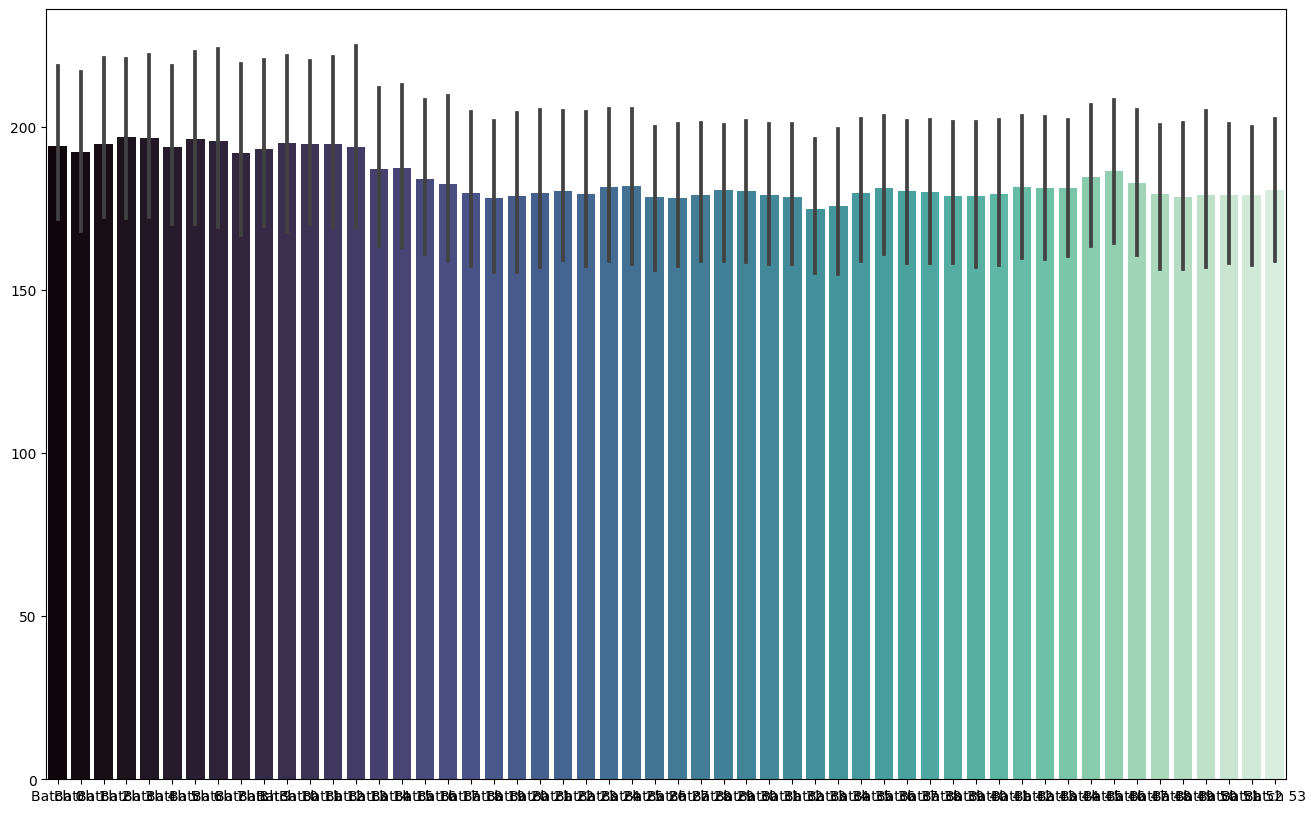

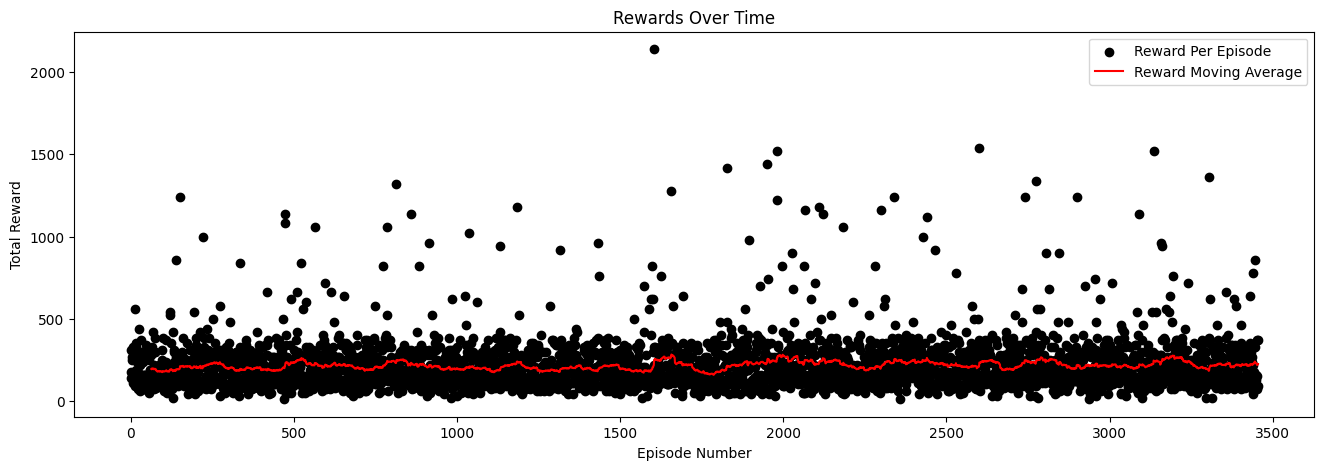

500                          
1000                         
1103                          
Episode 3456 of 10240                

500                          
1000                         
1500                          
2000                          
2143                          
Episode 3457 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2734                          
Episode 3458 of 10240                

500                          
1000                         
1024                          
Episode 3459 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3168                          
Episode 3460 of 10240                

500                          
1000                         
1329       

500                          
903                          
Episode 3489 of 10240                

500                          
1000                         
1500                          
1617                          
Episode 3490 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4352                          
Episode 3491 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
6826                   

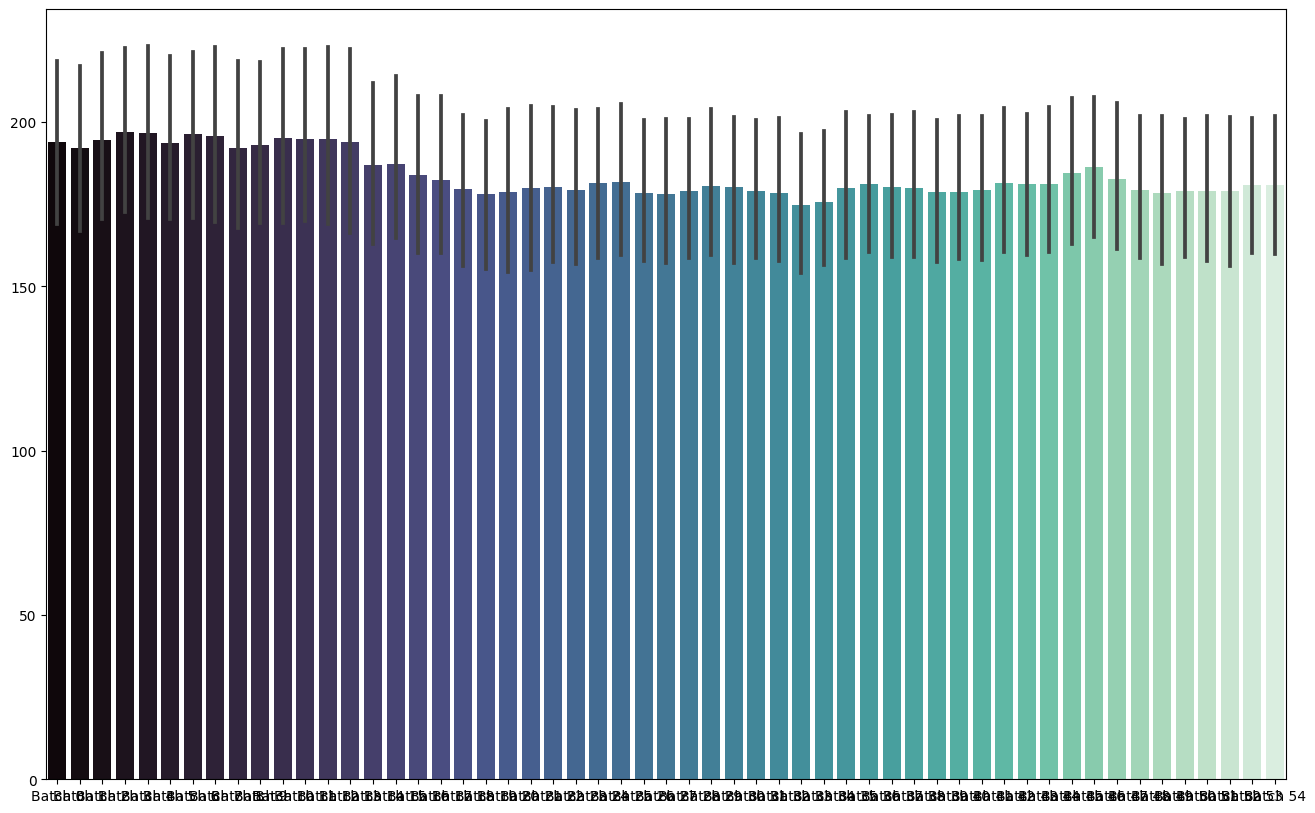

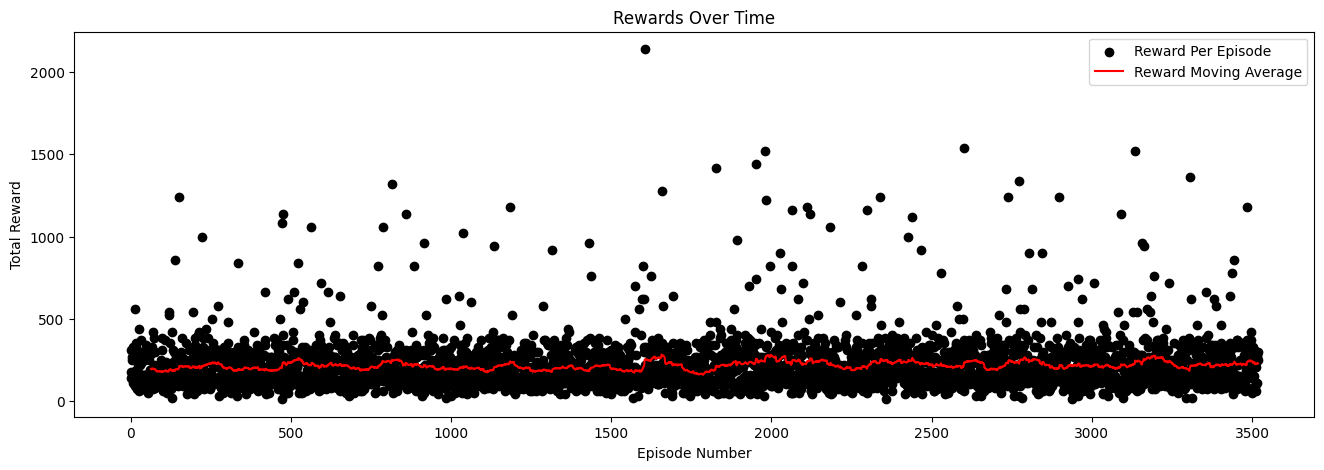

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3294                          
Episode 3520 of 10240                

500                          
1000                         
1398                          
Episode 3521 of 10240                

500                          
1000                         
1500                          
1954                          
Episode 3522 of 10240                

500                          
927                          
Episode 3523 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3772                          
Episode 3524 of 10240                

500                          
558                          
Episode 352

867                          
Episode 3554 of 10240                

487                          
Episode 3555 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4387                          
Episode 3556 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5460                          
Episode 3557 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000           

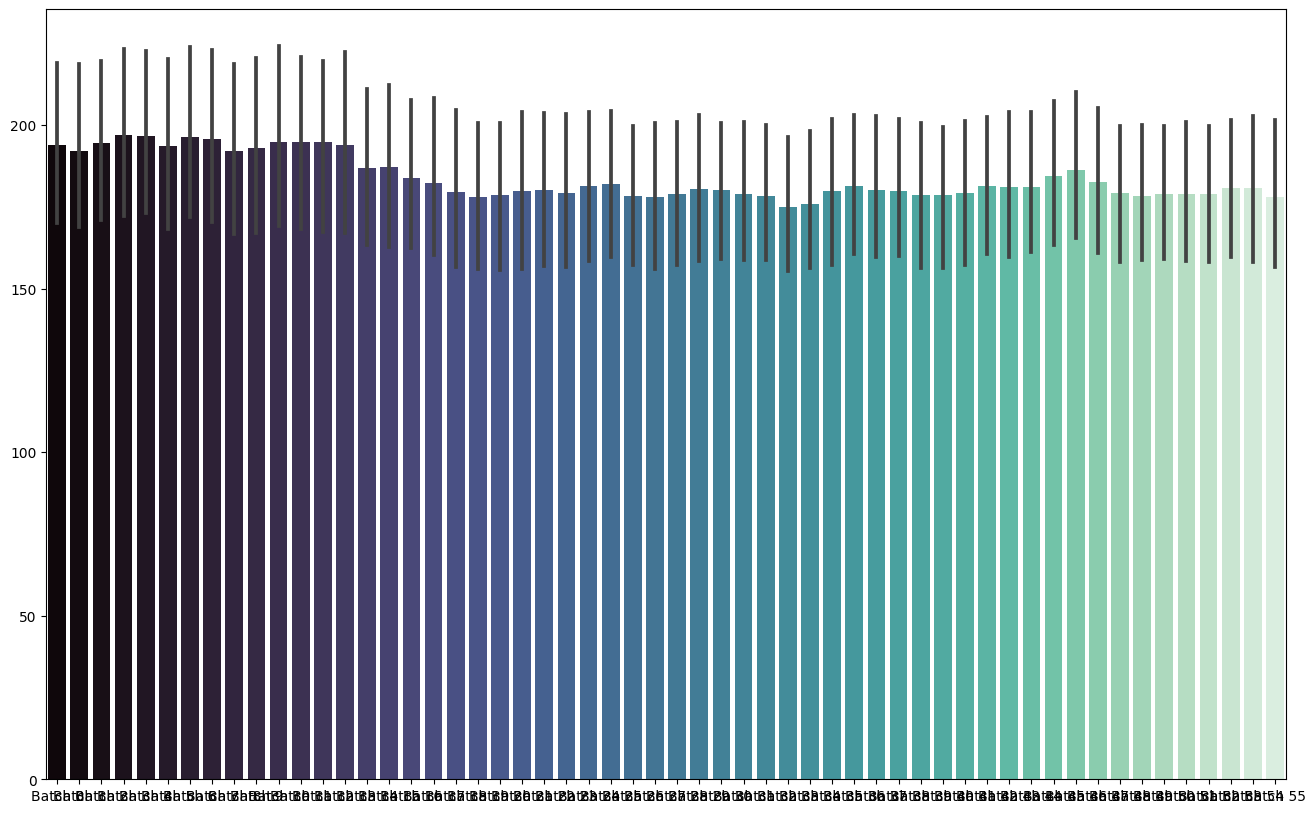

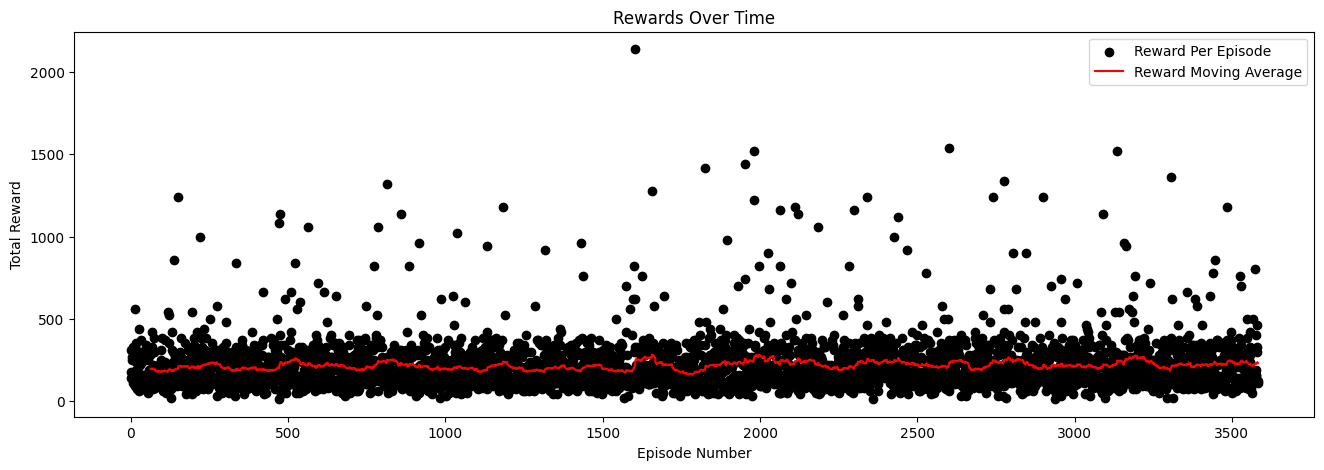

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4394                          
Episode 3584 of 10240                

500                          
672                          
Episode 3585 of 10240                

500                          
1000                         
1500                          
1521                          
Episode 3586 of 10240                

500                          
1000                         
1102                          
Episode 3587 of 10240                

500                          
931                          
Episode 3588 of 10240                

500                          
1000                         
1169                          
Episode 3589 of 10240                

500                          
1000                         
1500 

1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
6559                          
Episode 3619 of 10240                

500                          
1000                         
1273                          
Episode 3620 of 10240                

500                          
1000                         
1293                          
Episode 3621 of 10240                

500                          
1000                         
1500                          
2000                          
2044                          
Episode 3622 of 10240                

500                          
509                          
Episode 3623 of 10240                

470                          
Episode 

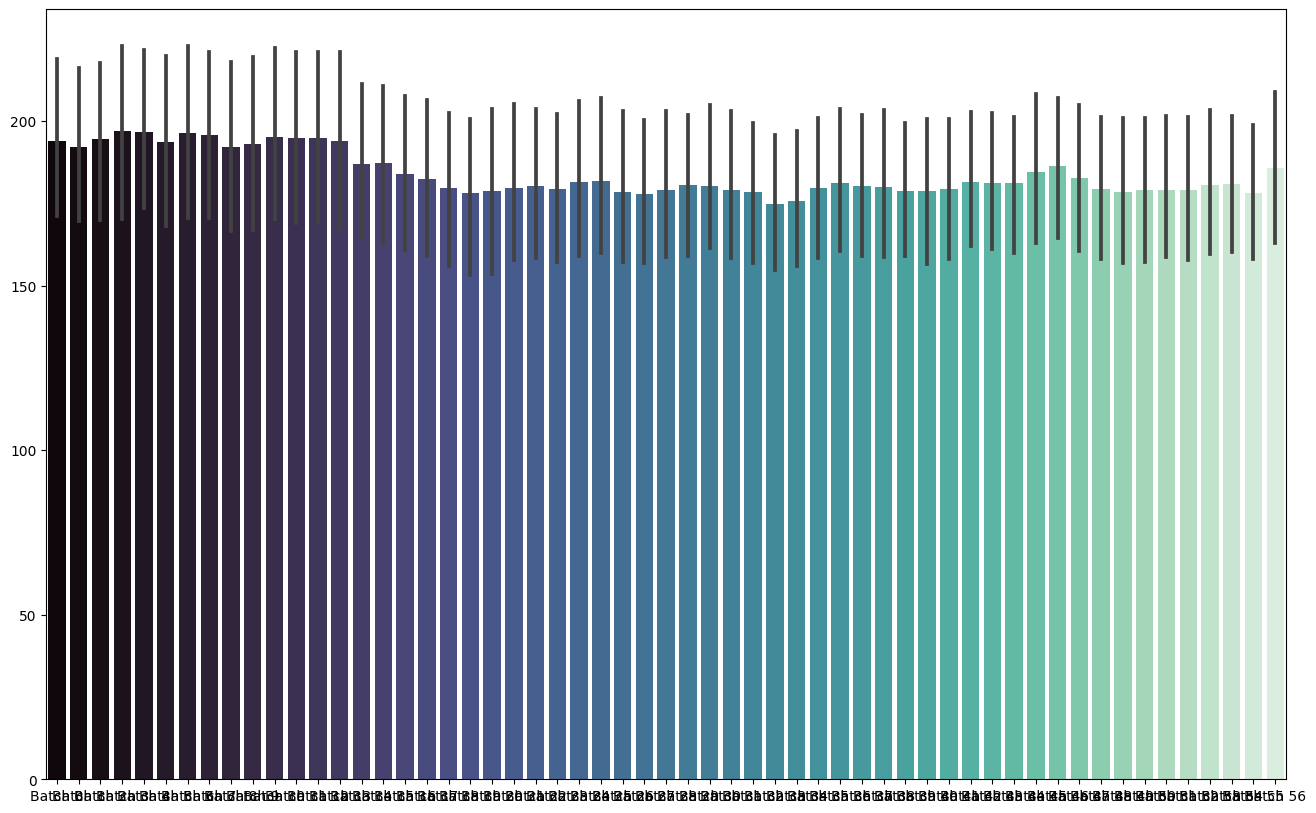

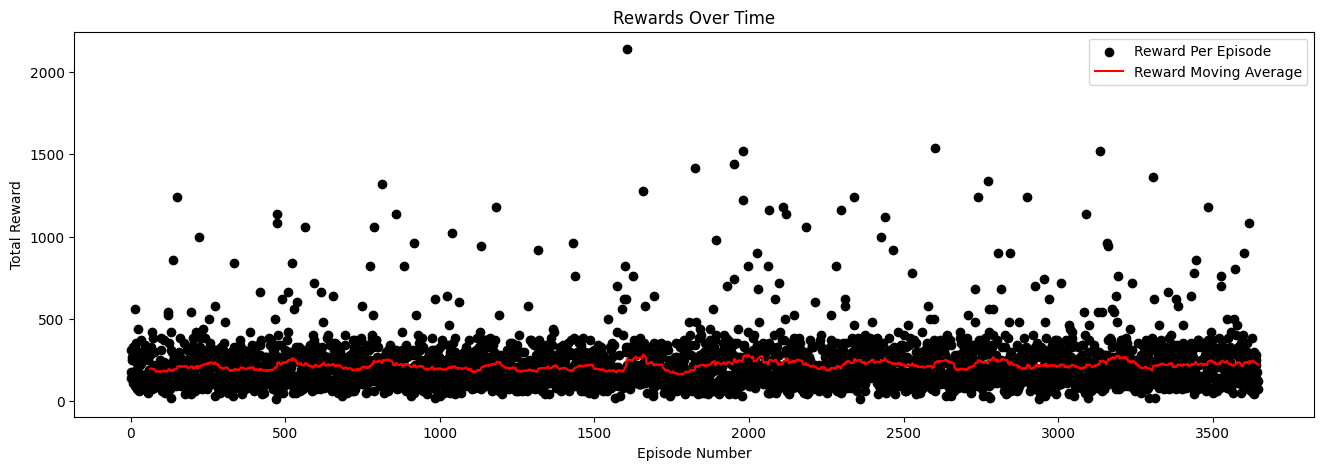

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4925                          
Episode 3648 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2651                          
Episode 3649 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3772                          
Episode 3650 of 10240                

500                          
1000                         
1500                          
2000                          
2500                   

2576                          
Episode 3684 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
6843                          
Episode 3685 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2603                          
Episode 3686 of 10240                

500                          
1000                         
1304                          
Episode 3687 of 10240                

500                          
1000                         
1500                          
2000           

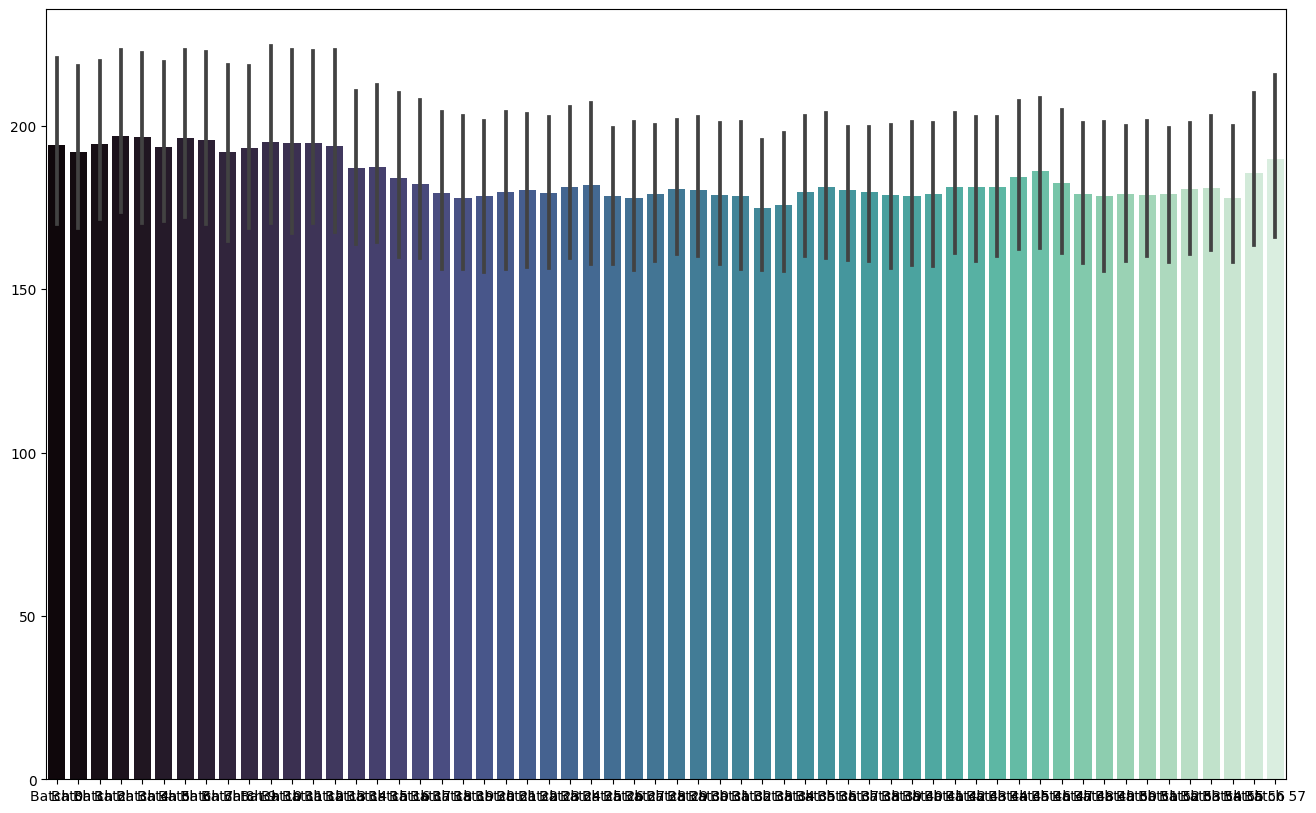

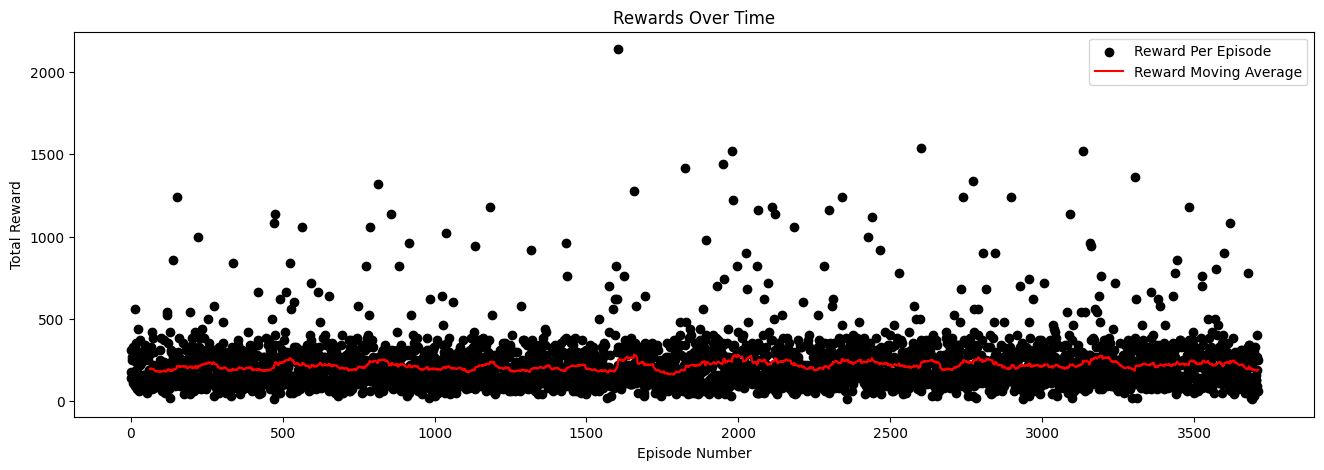

500                          
1000                         
1500                          
2000                          
2304                          
Episode 3712 of 10240                

500                          
1000                         
1003                          
Episode 3713 of 10240                

500                          
1000                         
1500                          
1740                          
Episode 3714 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2651                          
Episode 3715 of 10240                

500                          
705                          
Episode 3716 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500       

2043                          
Episode 3740 of 10240                

385                          
Episode 3741 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6315                          
Episode 3742 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3992                          
Episode 3743 of 10240                

500                          
1000                         
1500                          
2000                          
2500          

1000                         
1500                          
2000                          
2500                          
2627                          
Episode 3775 of 10240                



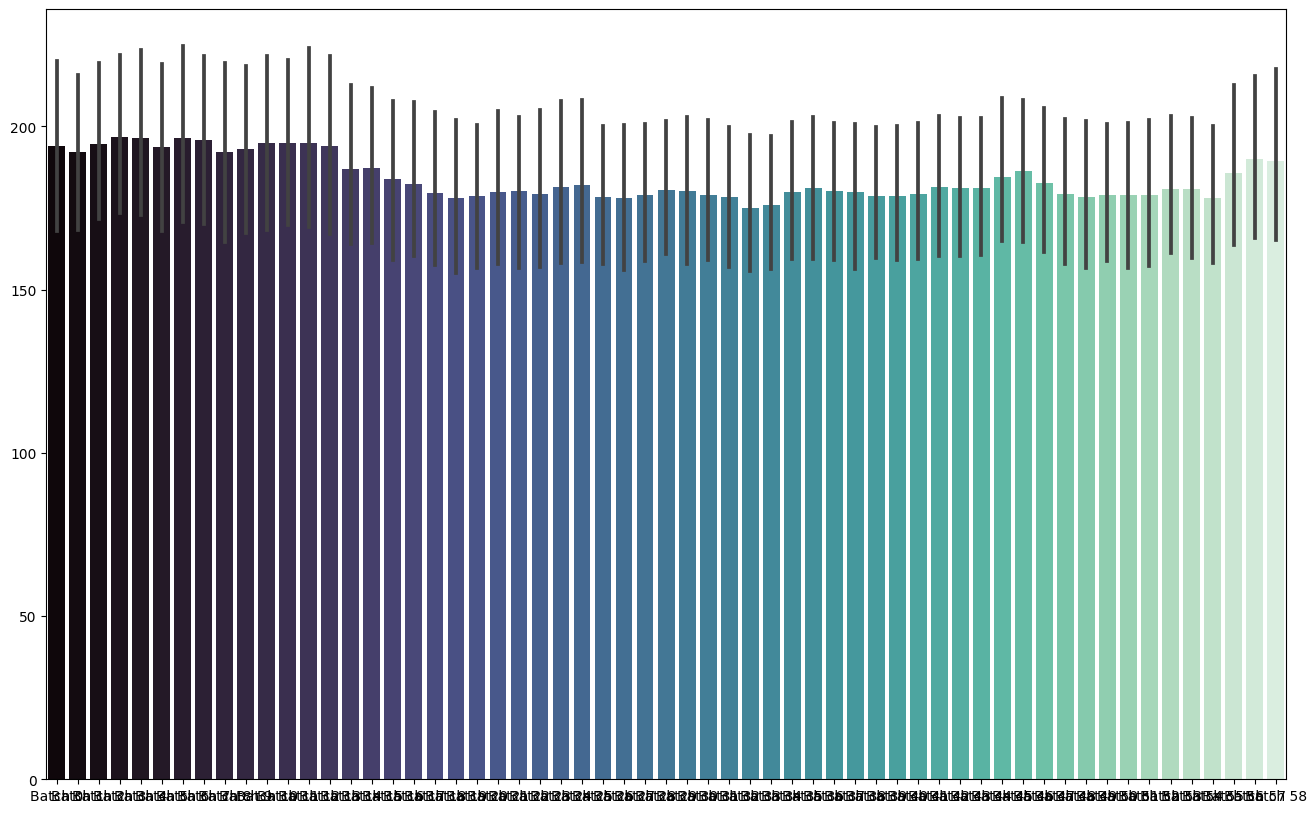

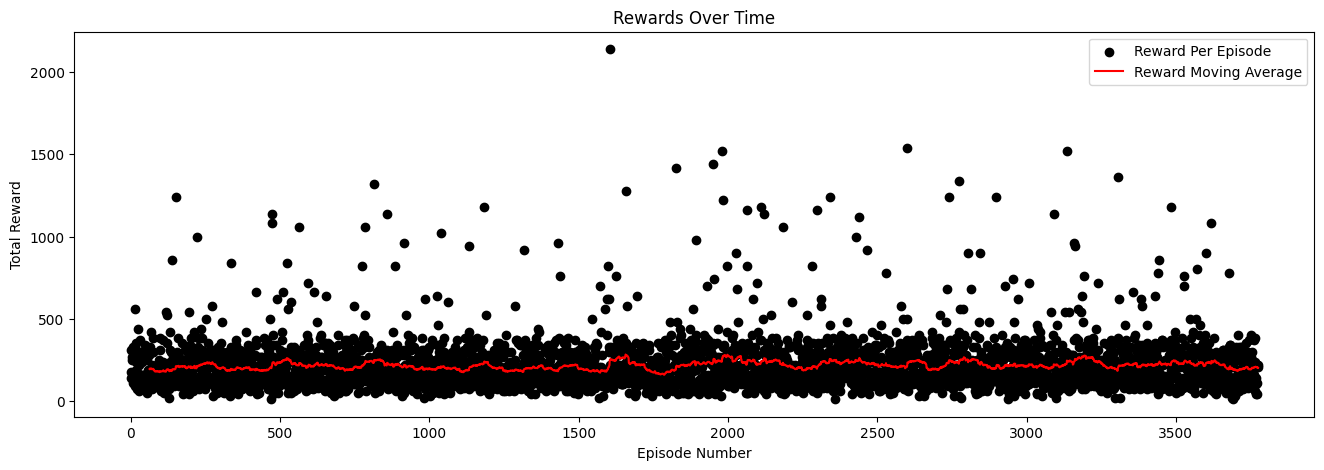

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6353                          
Episode 3776 of 10240                

500                          
759                          
Episode 3777 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2929                          
Episode 3778 of 10240                

500                          
934                          
Episode 3779 of 10240                

500                          
626                          
Episode 3780 of 10240                

500                          
1000      

2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
5540                          
Episode 3807 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3380                          
Episode 3808 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4080                          
Episode 3809 of 10240                

376                          
Episode 3810 of 10240                

500                          
706                          
Episode 3811 o

1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4197                          
Episode 3838 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3549                          
Episode 3839 of 10240                



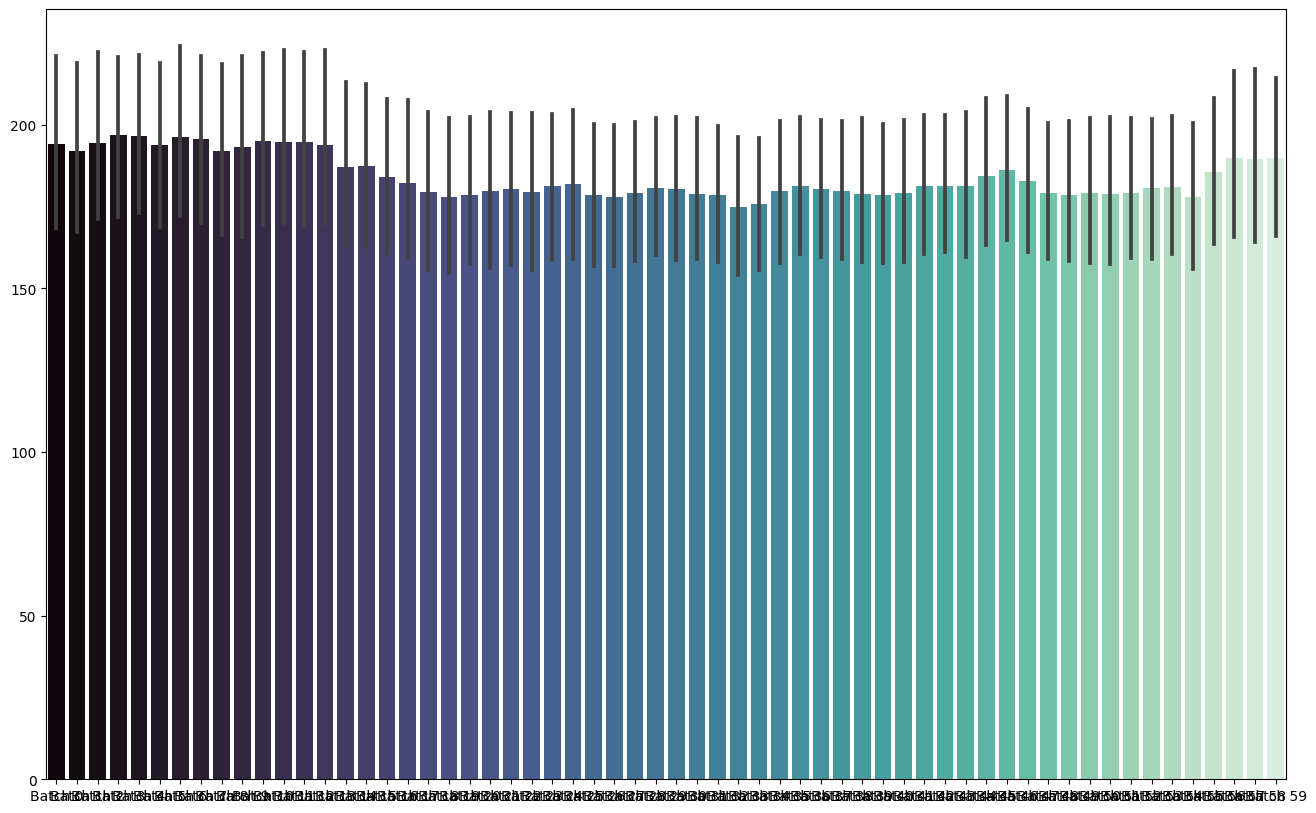

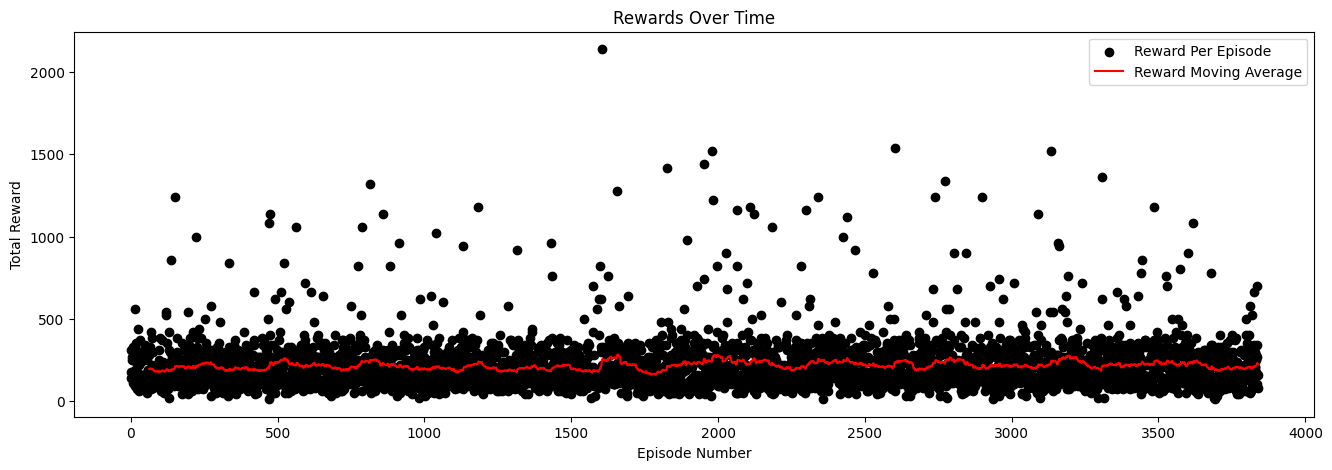

500                          
1000                         
1285                          
Episode 3840 of 10240                

500                          
1000                         
1282                          
Episode 3841 of 10240                

500                          
1000                         
1500                          
2000                          
2199                          
Episode 3842 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
7572                          
Episode 3843 of 10240                

500            

8000                          
8500                          
9000                          
9403                          
Episode 3871 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3371                          
Episode 3872 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3069                          
Episode 3873 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3799                          
Episode 3874 of 10240                

491                          
Episode 3875 o

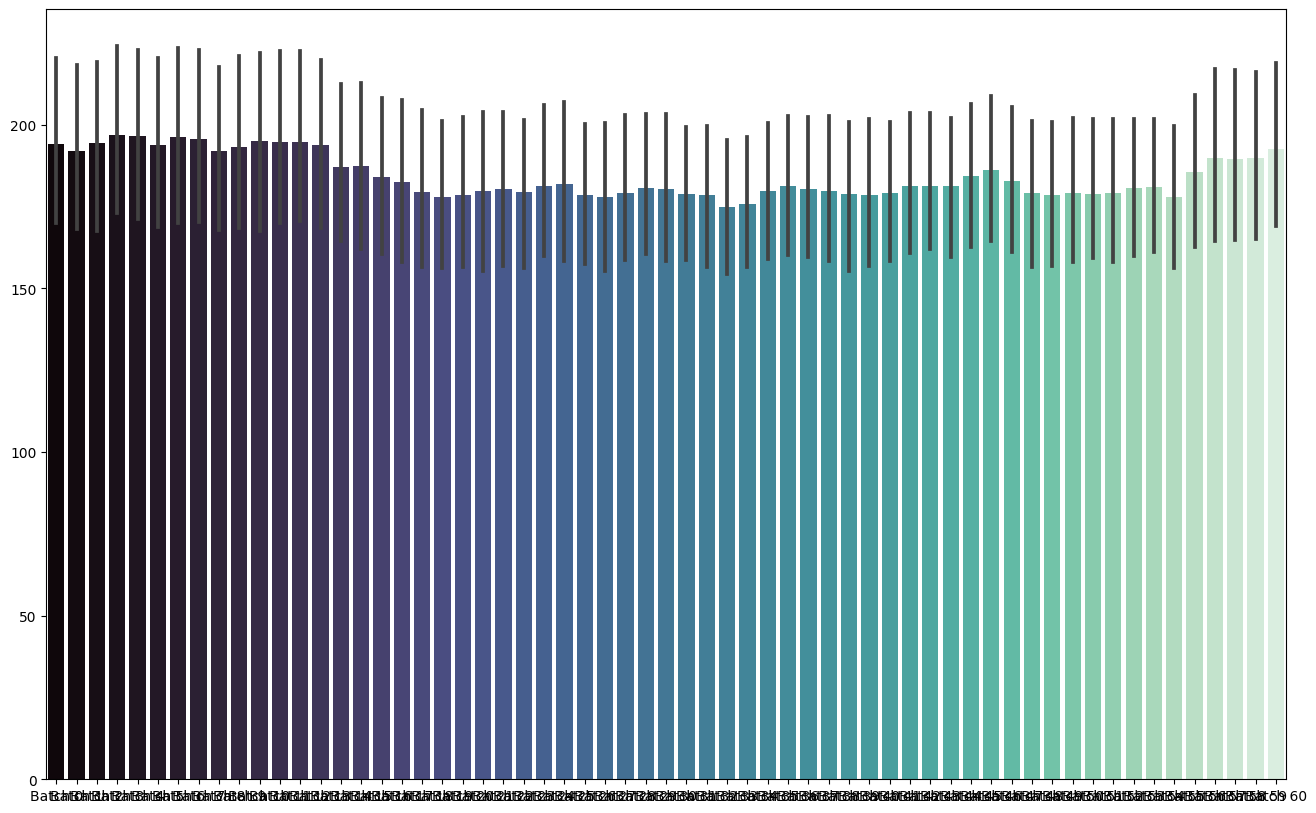

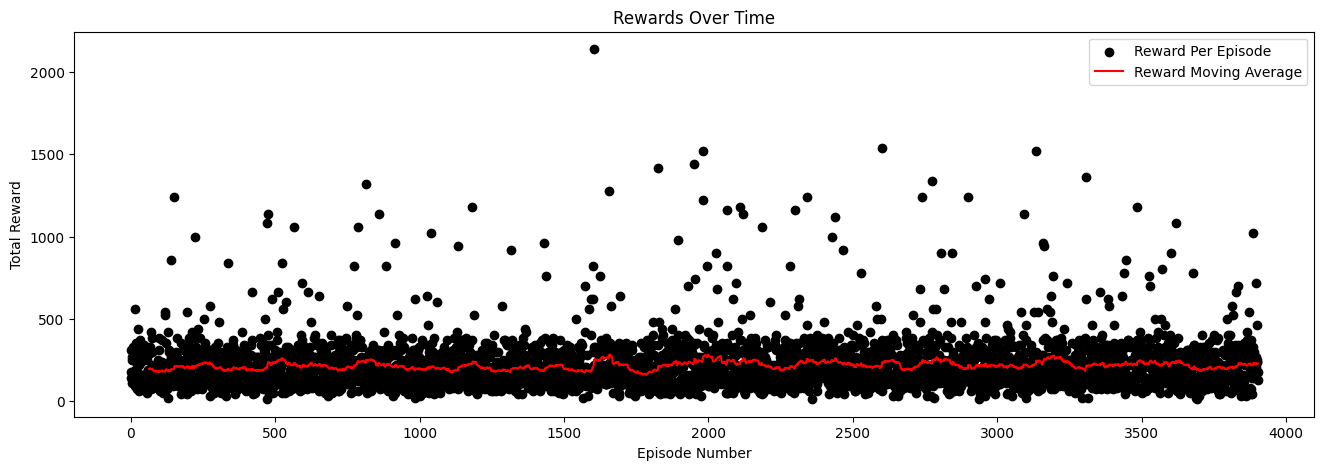

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
5933                          
Episode 3904 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5024                          
Episode 3905 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                         

2500                          
3000                          
3500                          
3674                          
Episode 3934 of 10240                

500                          
1000                         
1003                          
Episode 3935 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6420                          
Episode 3936 of 10240                

500                          
934                          
Episode 3937 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000           

4500                          
5000                          
5500                          
6000                          
6079                          
Episode 3965 of 10240                

500                          
1000                         
1147                          
Episode 3966 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7494                          
Episode 3967 of 10240                



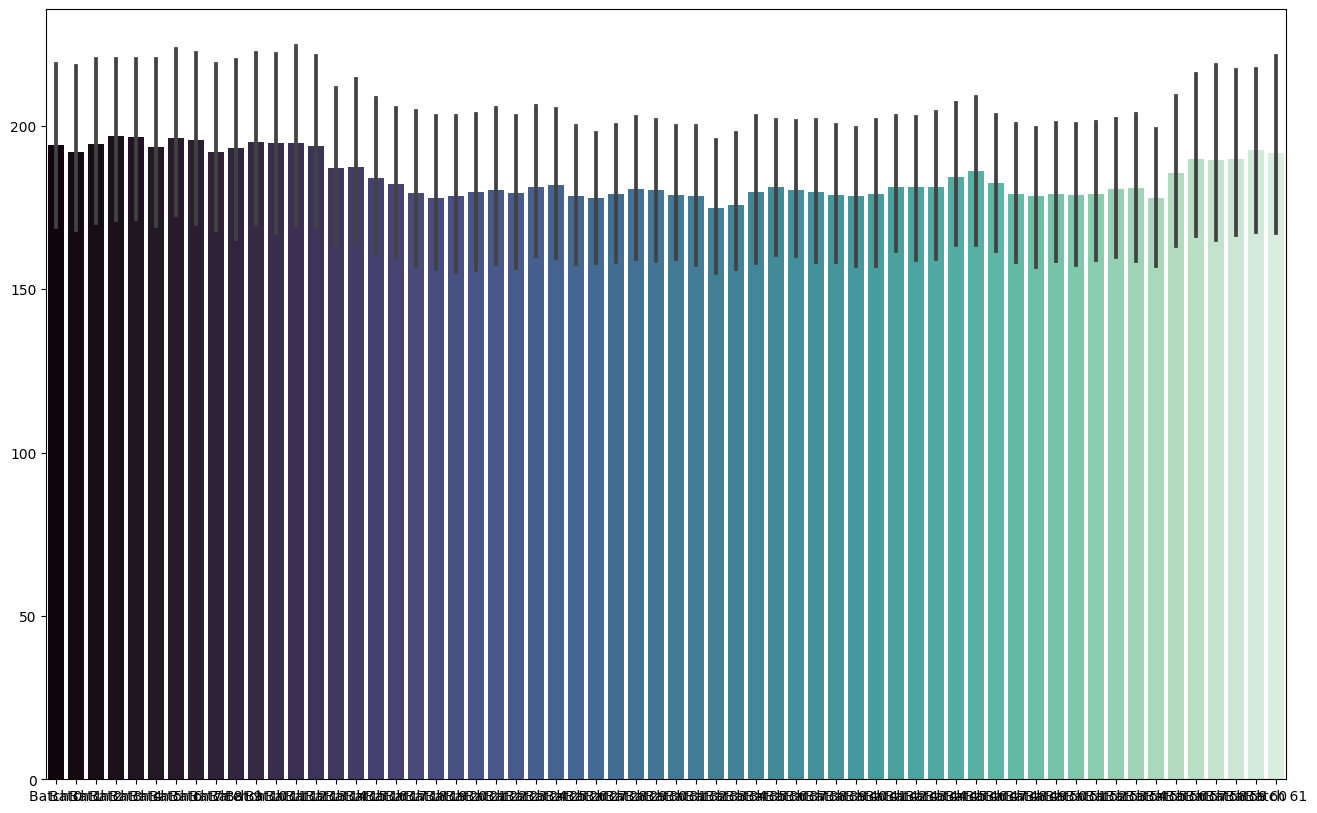

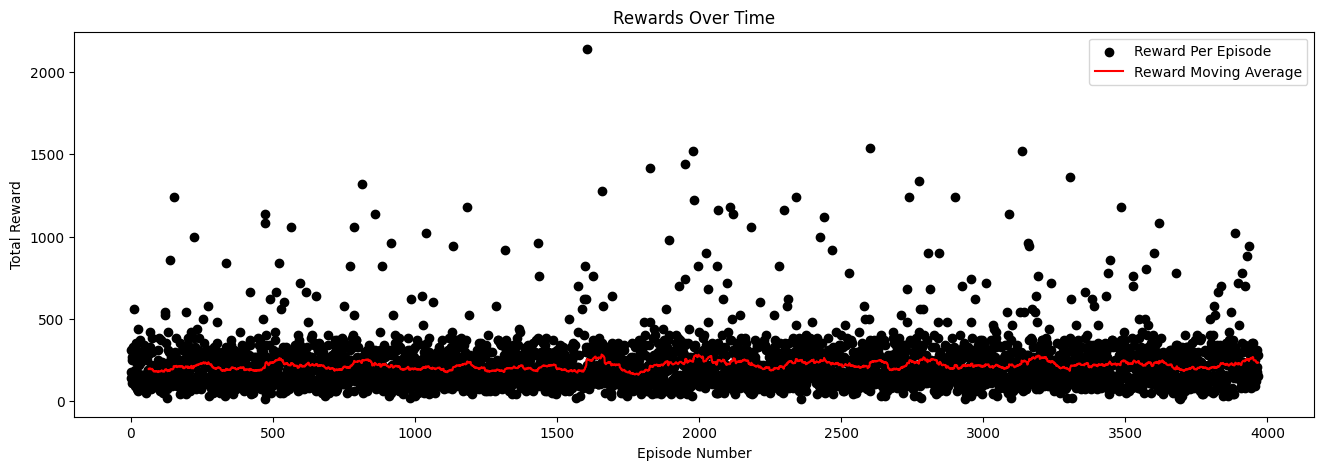

500                          
548                          
Episode 3968 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
8000                          
8136                          
Episode 3969 of 10240                

333                          
Episode 3970 of 10240                

500                          
1000                         
1305                          
Episode 3971 of 10240                

500                          
1000                         
1500                          
2000                          
2500            

500                          
1000                         
1500                          
1802                          
Episode 3997 of 10240                

500                          
899                          
Episode 3998 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3379                          
Episode 3999 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3491                          
Episode 4000 of 10240                

500                          
585                          
Episode 4001 of 10240                

500                          
740                          
Episode 4002 of 10240                

500                          
1000

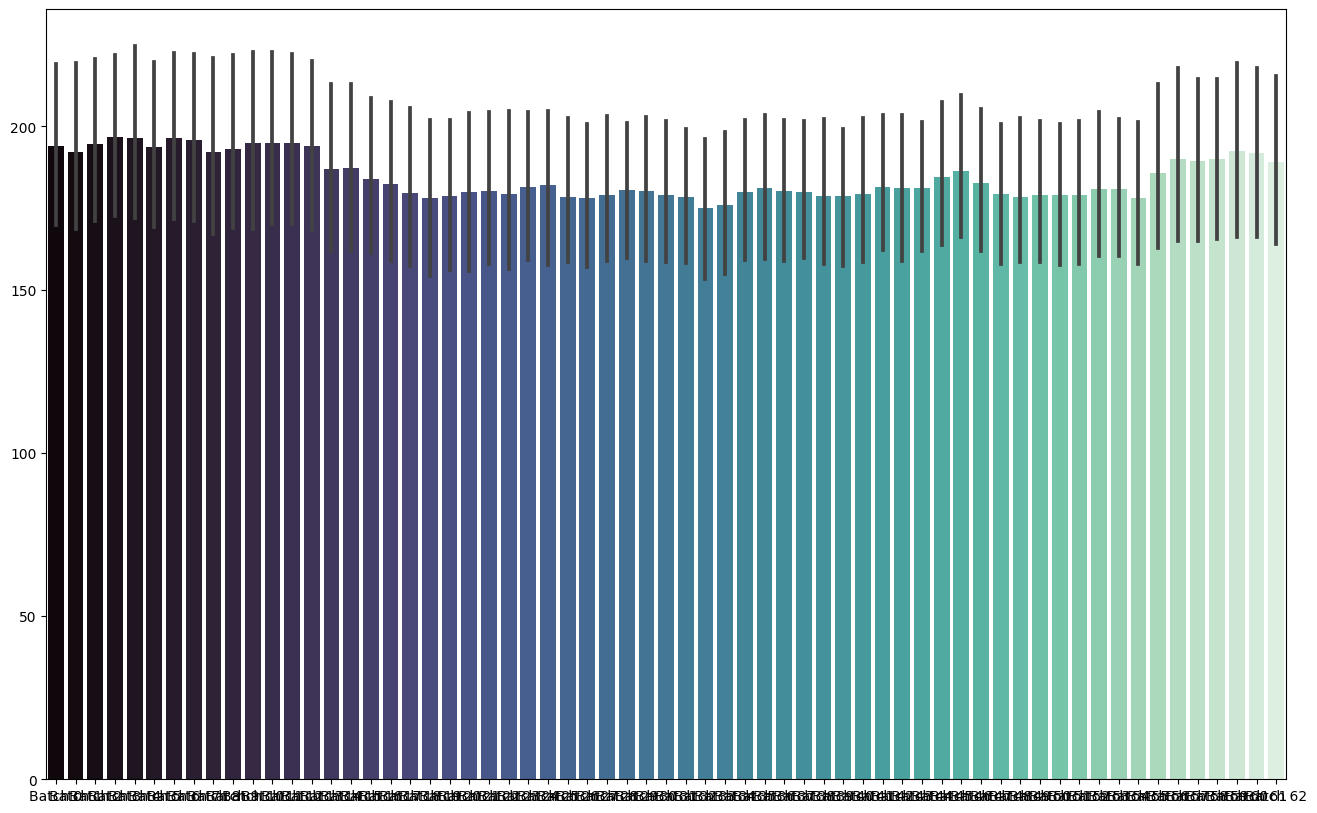

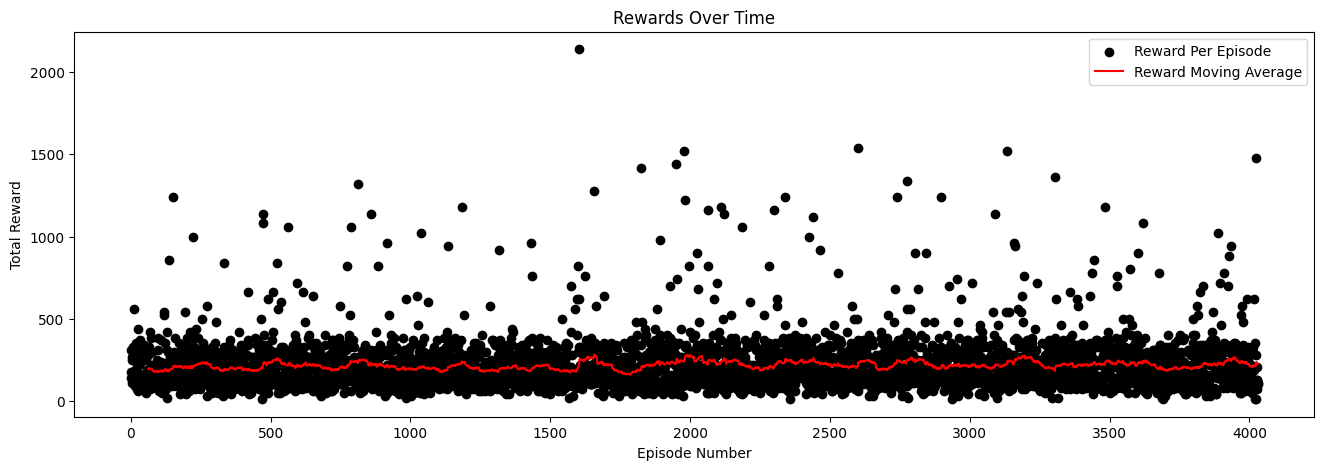

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3775                          
Episode 4032 of 10240                

488                          
Episode 4033 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3167                          
Episode 4034 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4094                          
Episode 4035 of 10240                

500                          
1000                         
1500            

8000                          
8500                          
9000                          
9500                          
10000                         
10029                          
Episode 4065 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
8000                          
8500                          
8840                          
Episode 4066 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2803                      

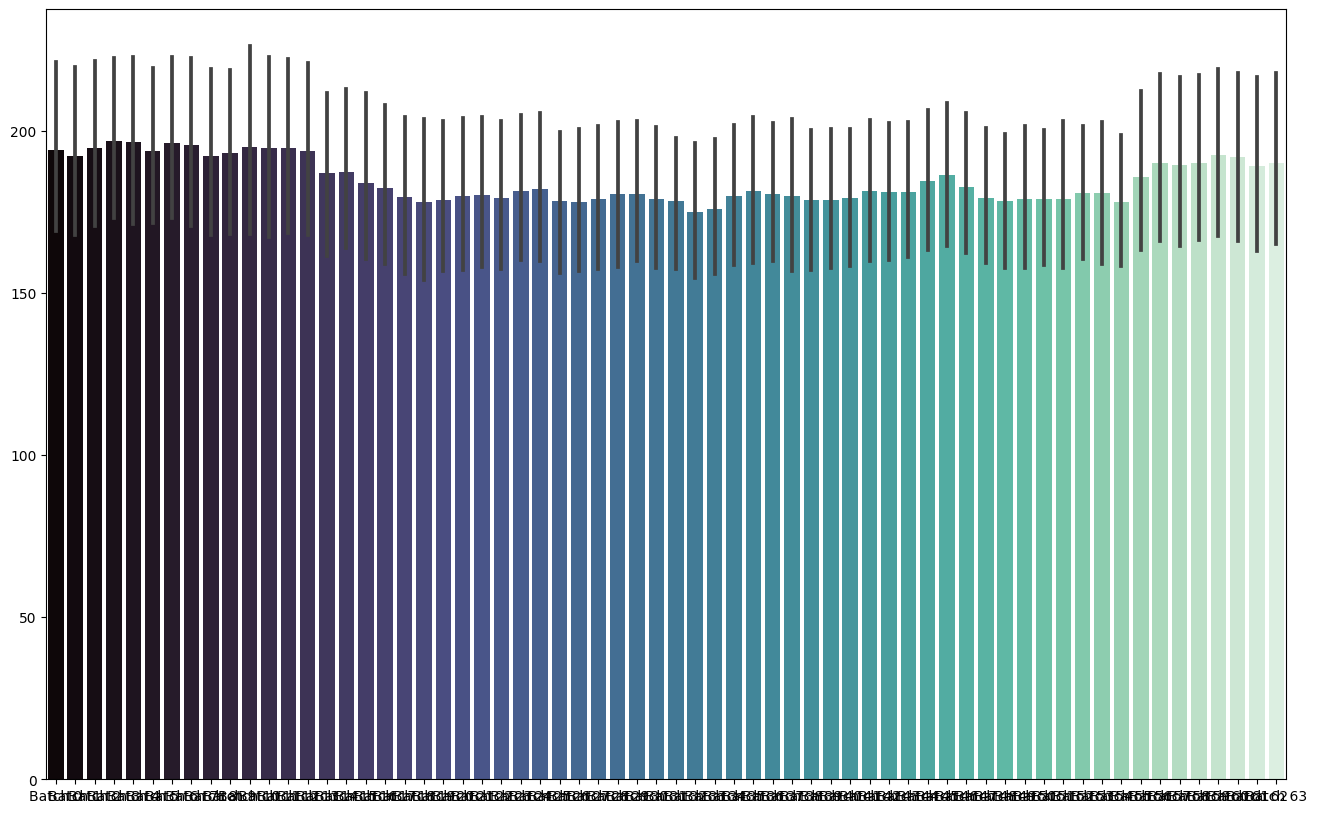

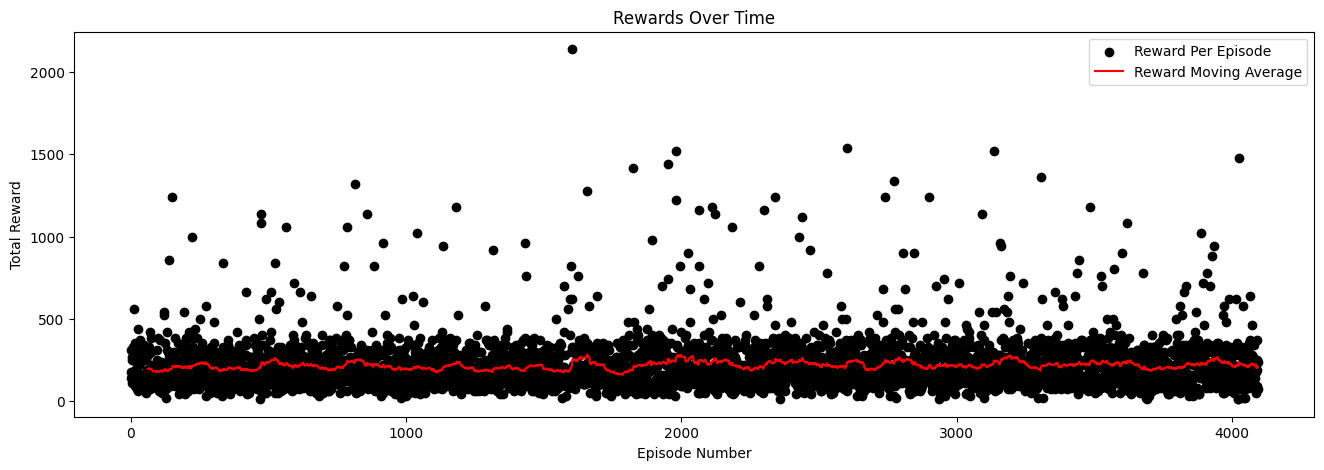

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
5792                          
Episode 4096 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5166                          
Episode 4097 of 10240                

500                          
892                          
Episode 4098 of 10240                

500                          
1000                         
1500                          
2000                   

2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
8000                          
8500                          
9000                          
9500                          
10000                         
10308                          
Episode 4132 of 10240                

500                          
861                          
Episode 4133 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4800                          
Episode 4134 of 10240     

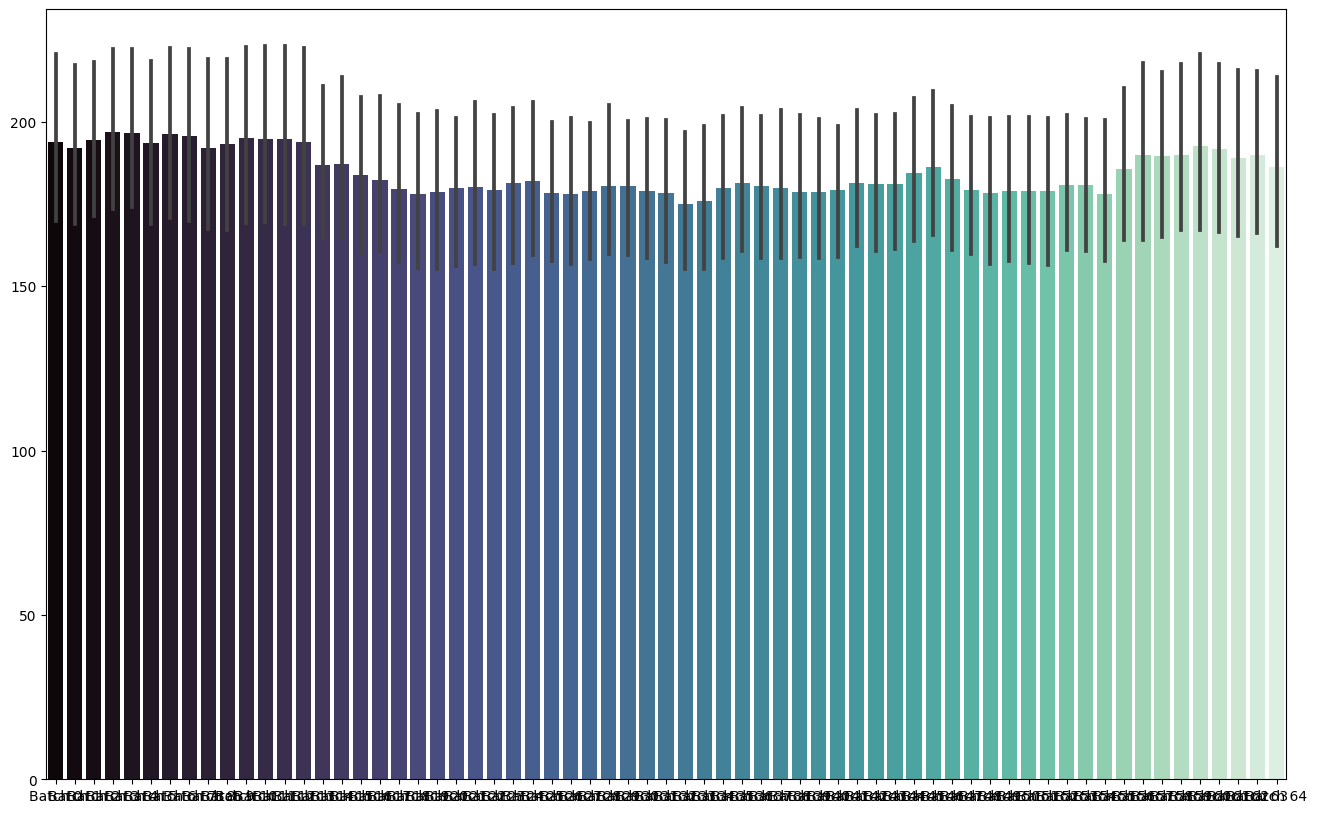

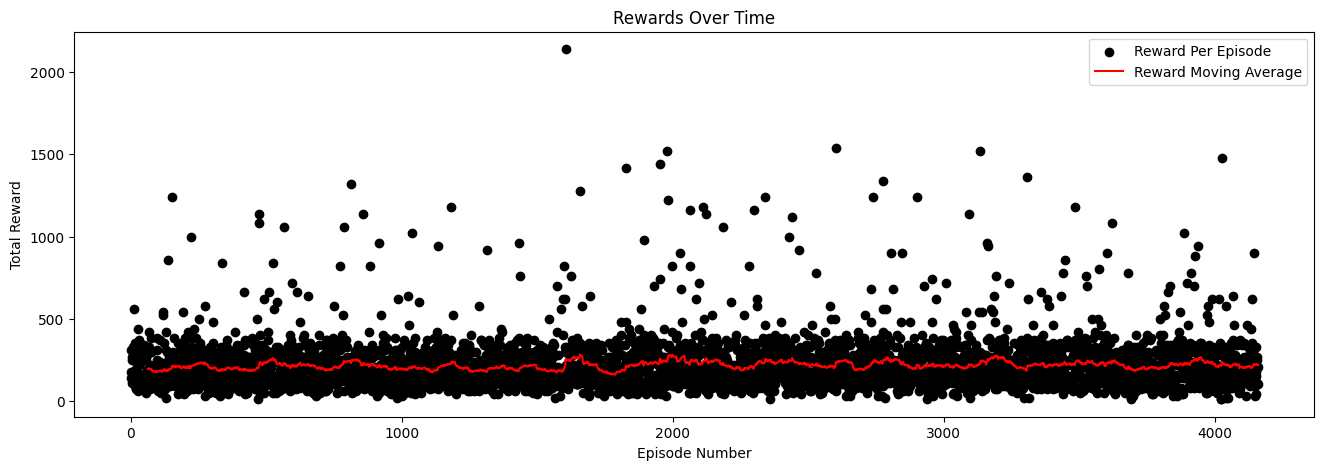

500                          
1000                         
1500                          
1505                          
Episode 4160 of 10240                

500                          
514                          
Episode 4161 of 10240                

447                          
Episode 4162 of 10240                

500                          
1000                         
1500                          
1815                          
Episode 4163 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3697                          
Episode 4164 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3059                          
Episode 41

1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4552                          
Episode 4193 of 10240                

500                          
1000                         
1500                          
1896                          
Episode 4194 of 10240                

500                          
1000                         
1106                          
Episode 4195 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2541                          
Episode 4196 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000            

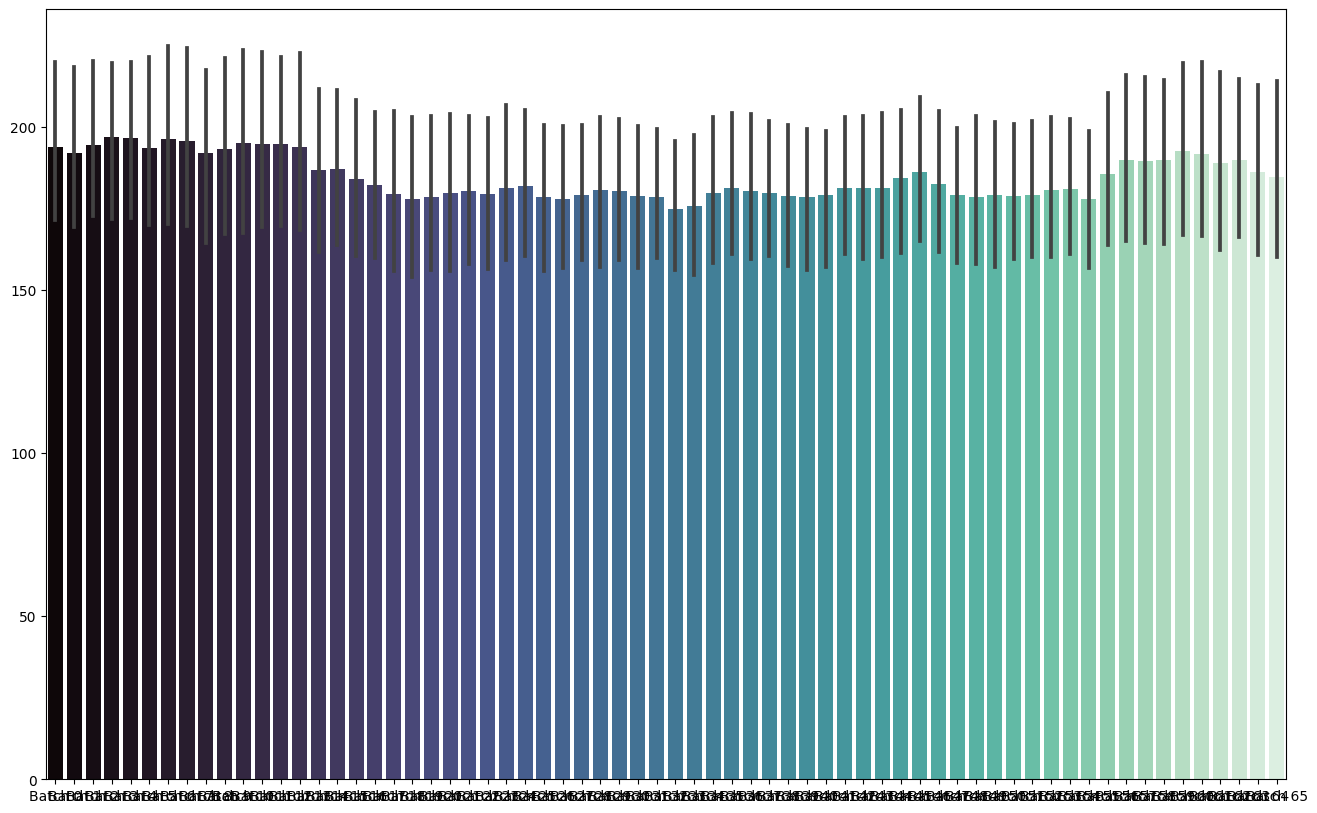

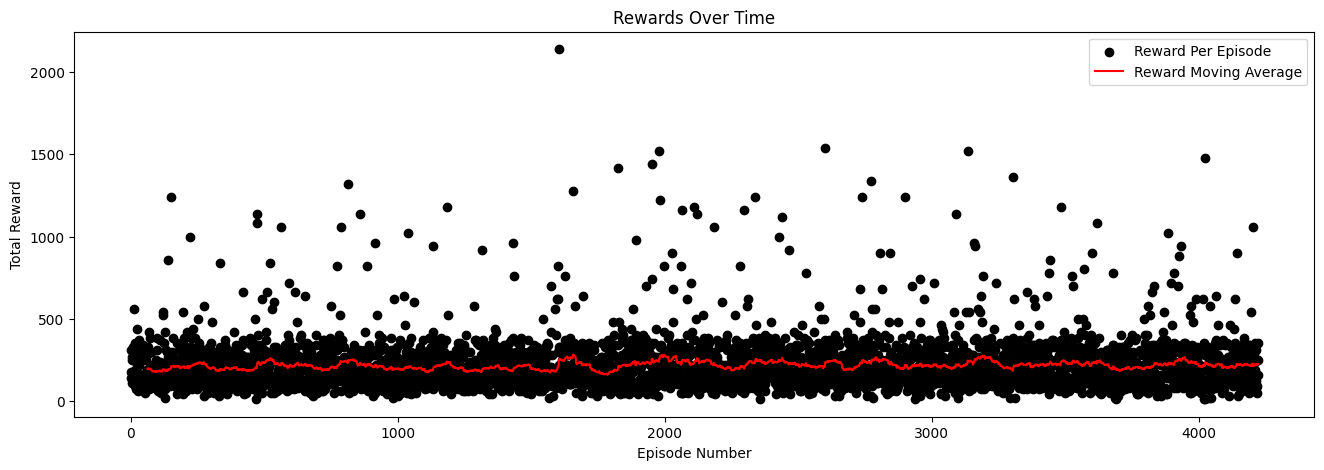

500                          
1000                         
1500                          
2000                          
2500                          
2536                          
Episode 4224 of 10240                

500                          
546                          
Episode 4225 of 10240                

500                          
1000                         
1430                          
Episode 4226 of 10240                

440                          
Episode 4227 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
6889                          
Episode 4228 of 10240                

500     

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4535                          
Episode 4262 of 10240                

500                          
1000                         
1500                          
1897                          
Episode 4263 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
8000                         

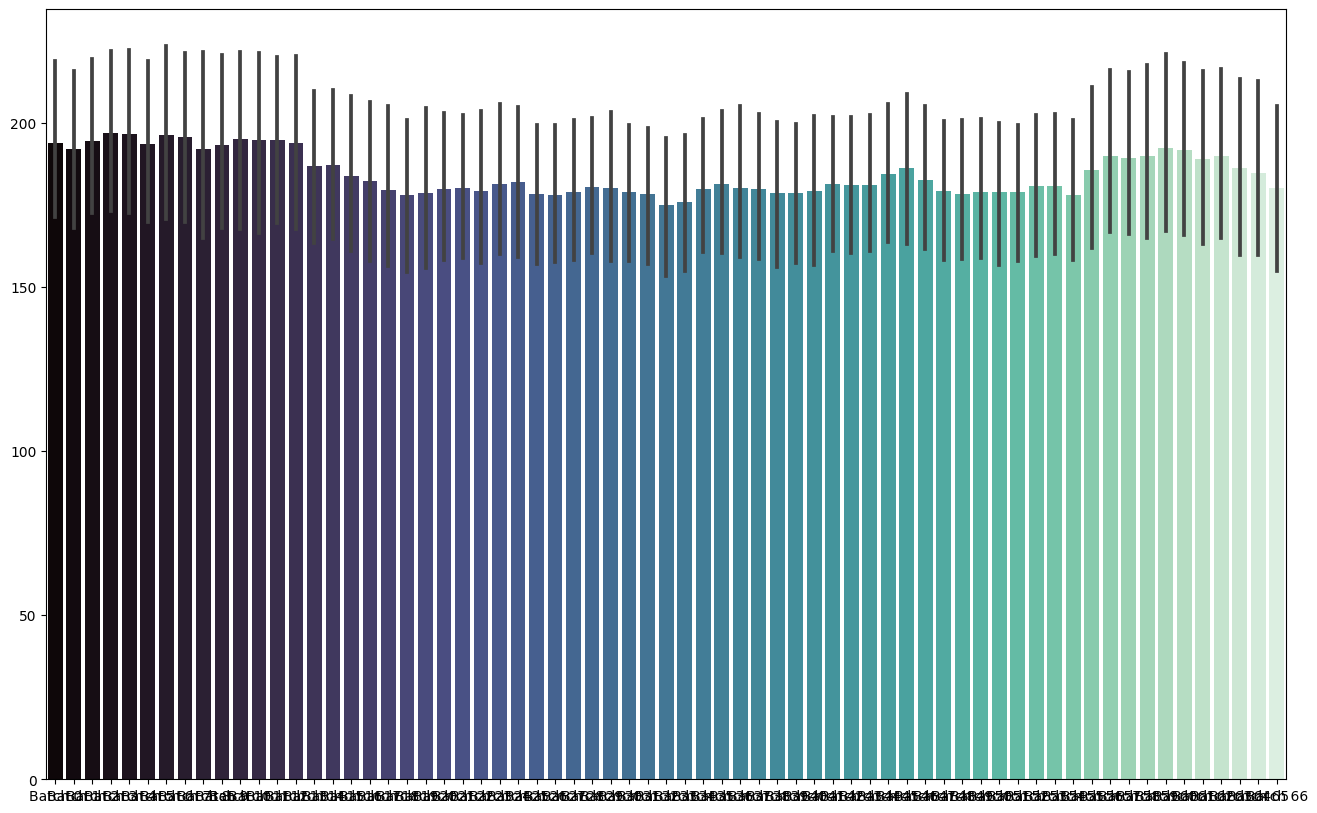

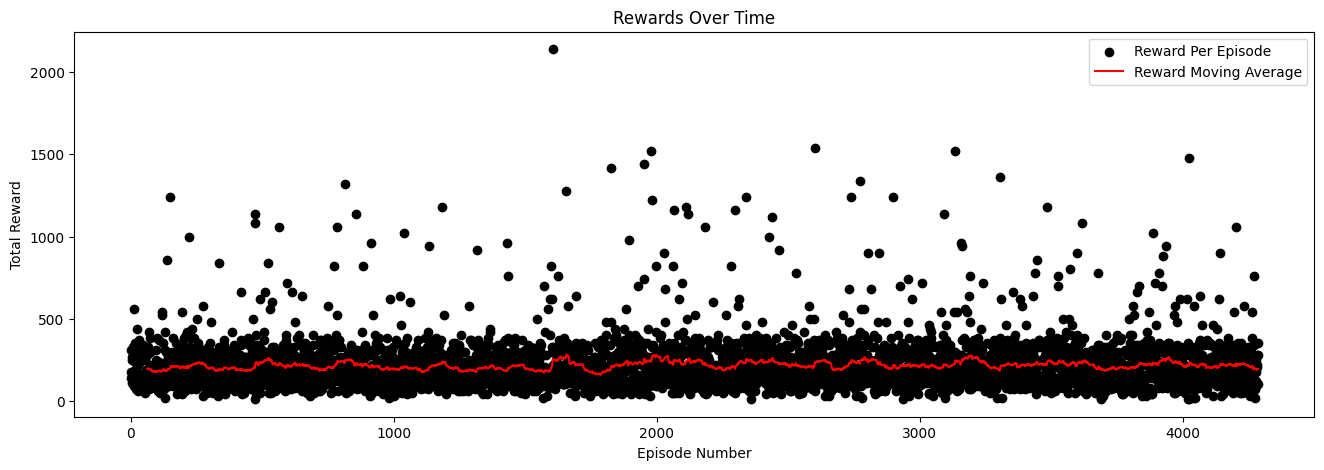

500                          
1000                         
1500                          
2000                          
2389                          
Episode 4288 of 10240                

500                          
931                          
Episode 4289 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
7699                          
Episode 4290 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2914                   

373                          
Episode 4322 of 10240                

500                          
1000                         
1500                          
2000                          
2270                          
Episode 4323 of 10240                

500                          
1000                         
1379                          
Episode 4324 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
8000                          
8500                          
8896                          
Episode 4325 of 10240                

500           

4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
8000                          
8500                          
8822                          
Episode 4351 of 10240                



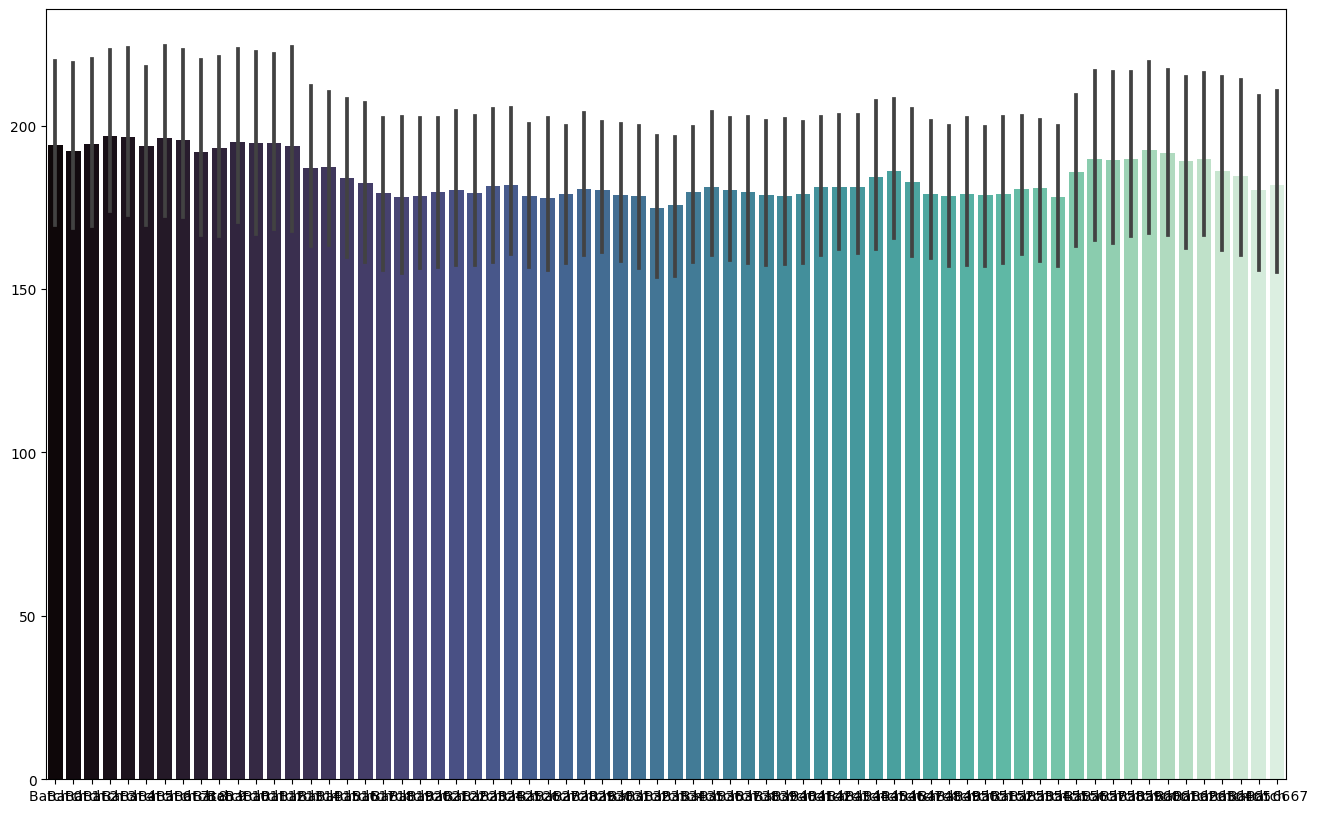

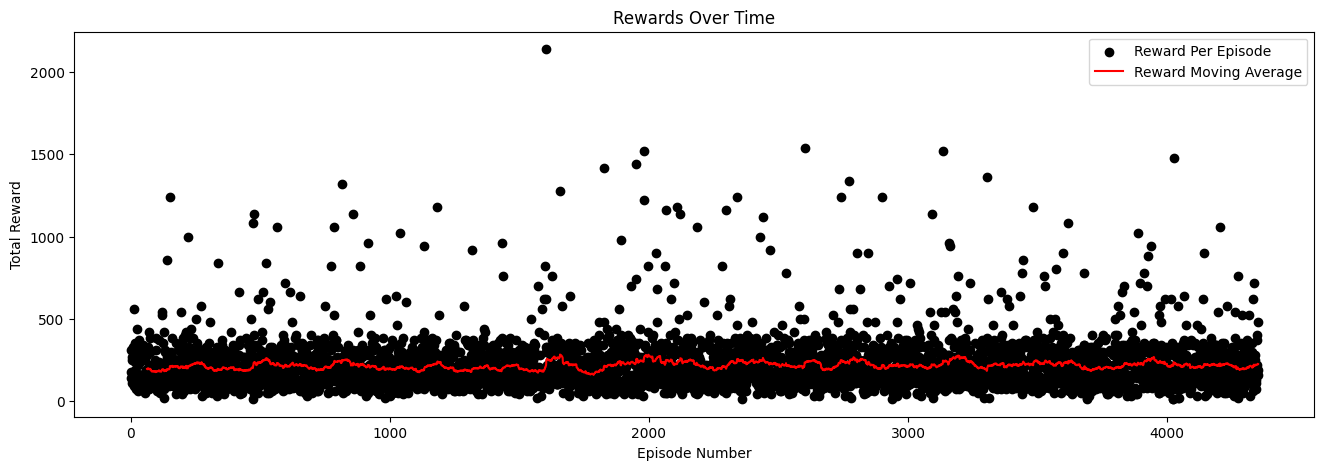

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4832                          
Episode 4352 of 10240                

500                          
1000                         
1500                          
2000                          
2040                          
Episode 4353 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4204                          
Episode 4354 of 10240                

500                          
1000                         
1500                          
2000                          
2500                   

3500                          
4000                          
4500                          
5000                          
5391                          
Episode 4388 of 10240                

500                          
1000                         
1500                          
1526                          
Episode 4389 of 10240                

500                          
1000                         
1500                          
1736                          
Episode 4390 of 10240                

394                          
Episode 4391 of 10240                

500                          
1000                         
1460                          
Episode 4392 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000    

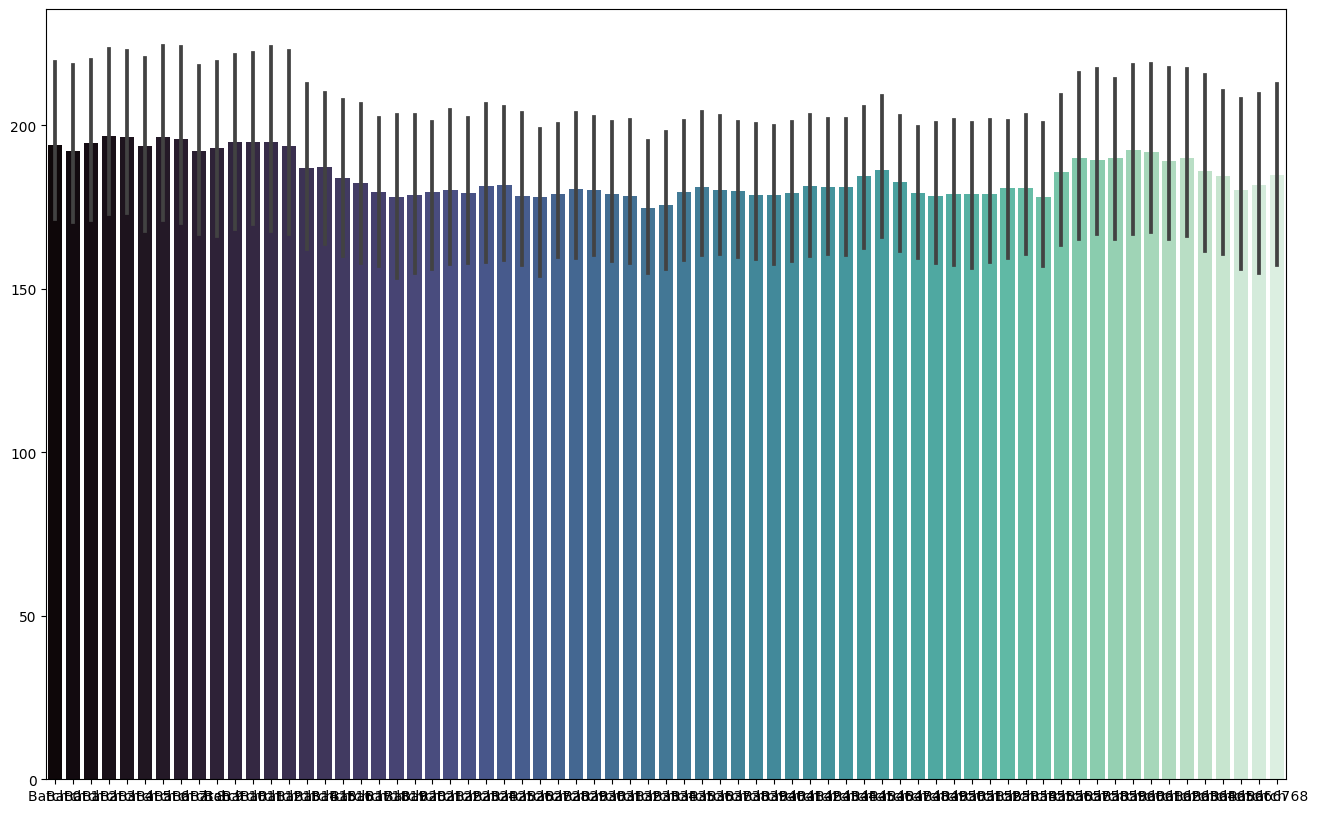

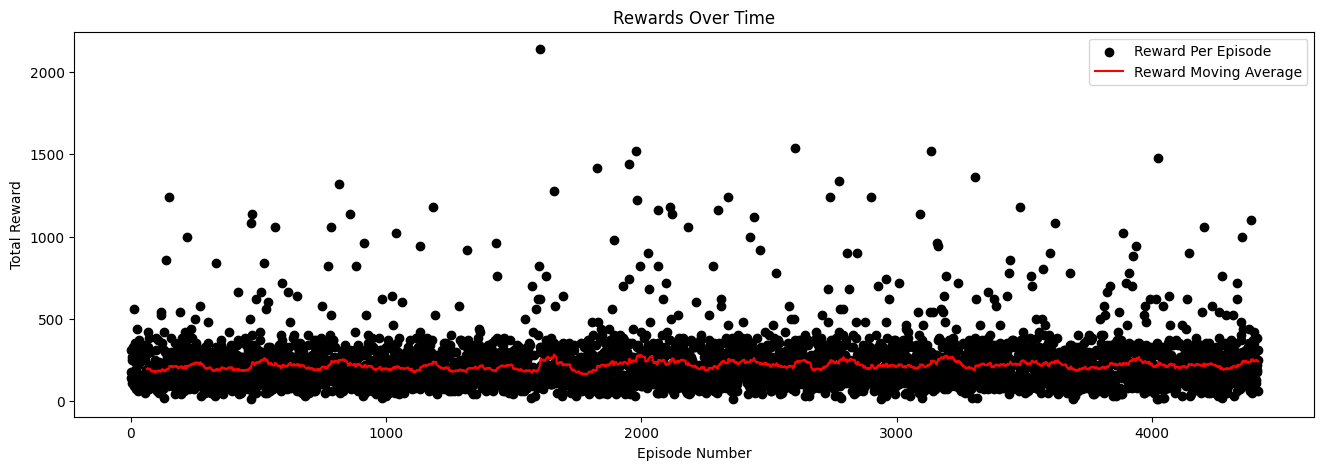

500                          
1000                         
1249                          
Episode 4416 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
6914                          
Episode 4417 of 10240                

500                          
1000                         
1500                          
1685                          
Episode 4418 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                   

500                          
1000                         
1500                          
2000                          
2265                          
Episode 4452 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2521                          
Episode 4453 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4544                          
Episode 4454 of 10240                

500                          
698                          
Episode 4455 of 10240                

500                          
1000                         
1500                          
2000                          
2013             

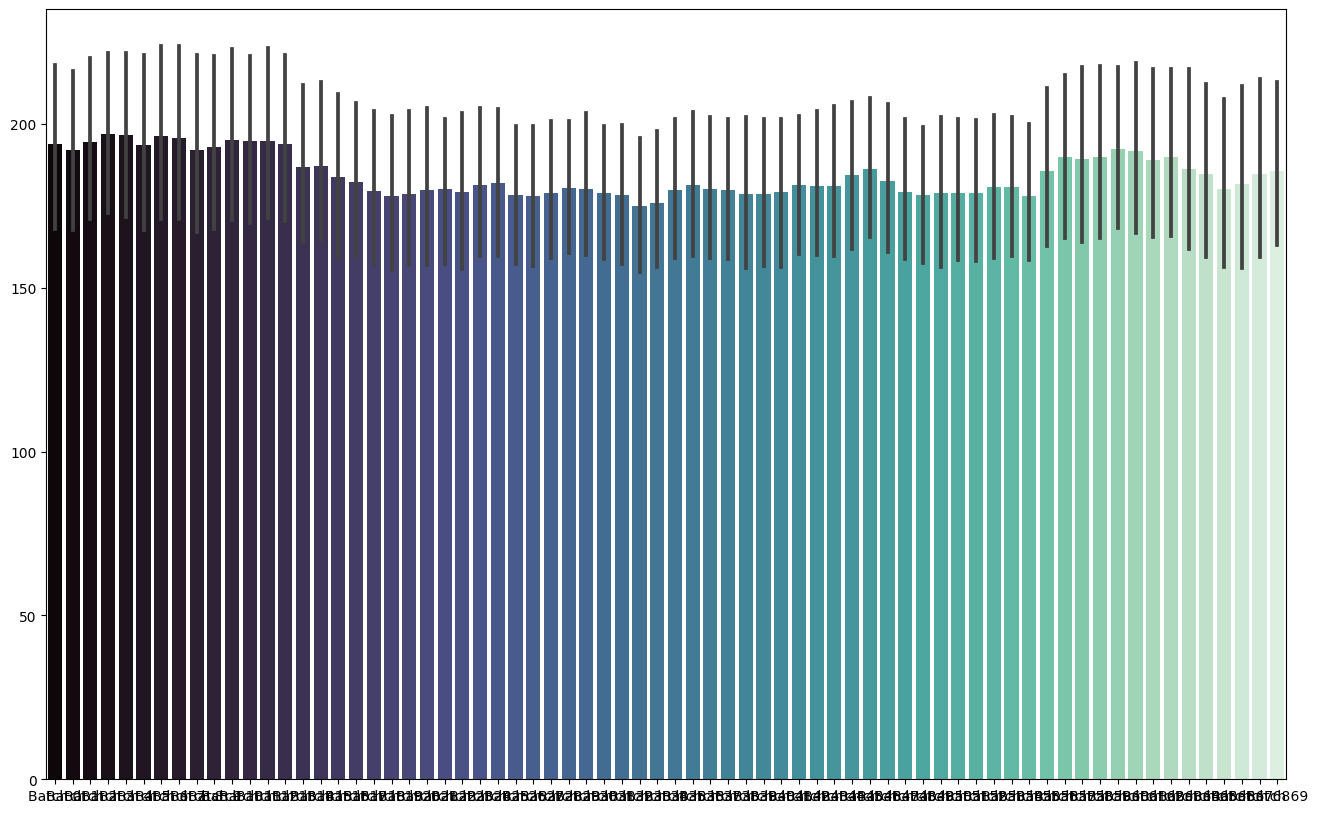

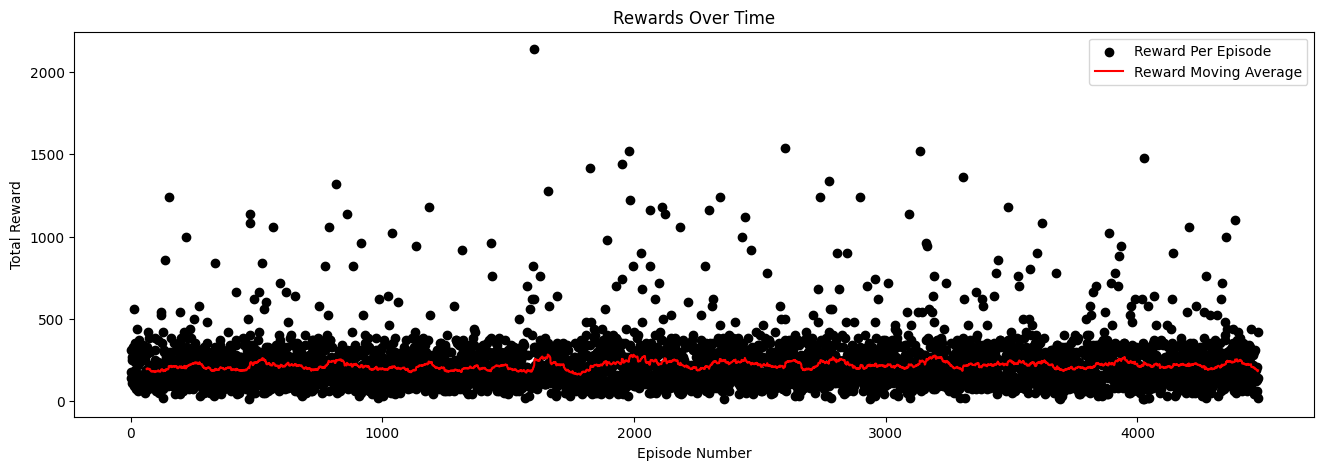

319                          
Episode 4480 of 10240                

500                          
751                          
Episode 4481 of 10240                

174                          
Episode 4482 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5425                          
Episode 4483 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2807                          
Episode 4484 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000     

500                          
1000                         
1395                          
Episode 4518 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5328                          
Episode 4519 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4681                          
Episode 4520 of 10240                

500                          
1000                         
1500                          
2000                          
2500                   

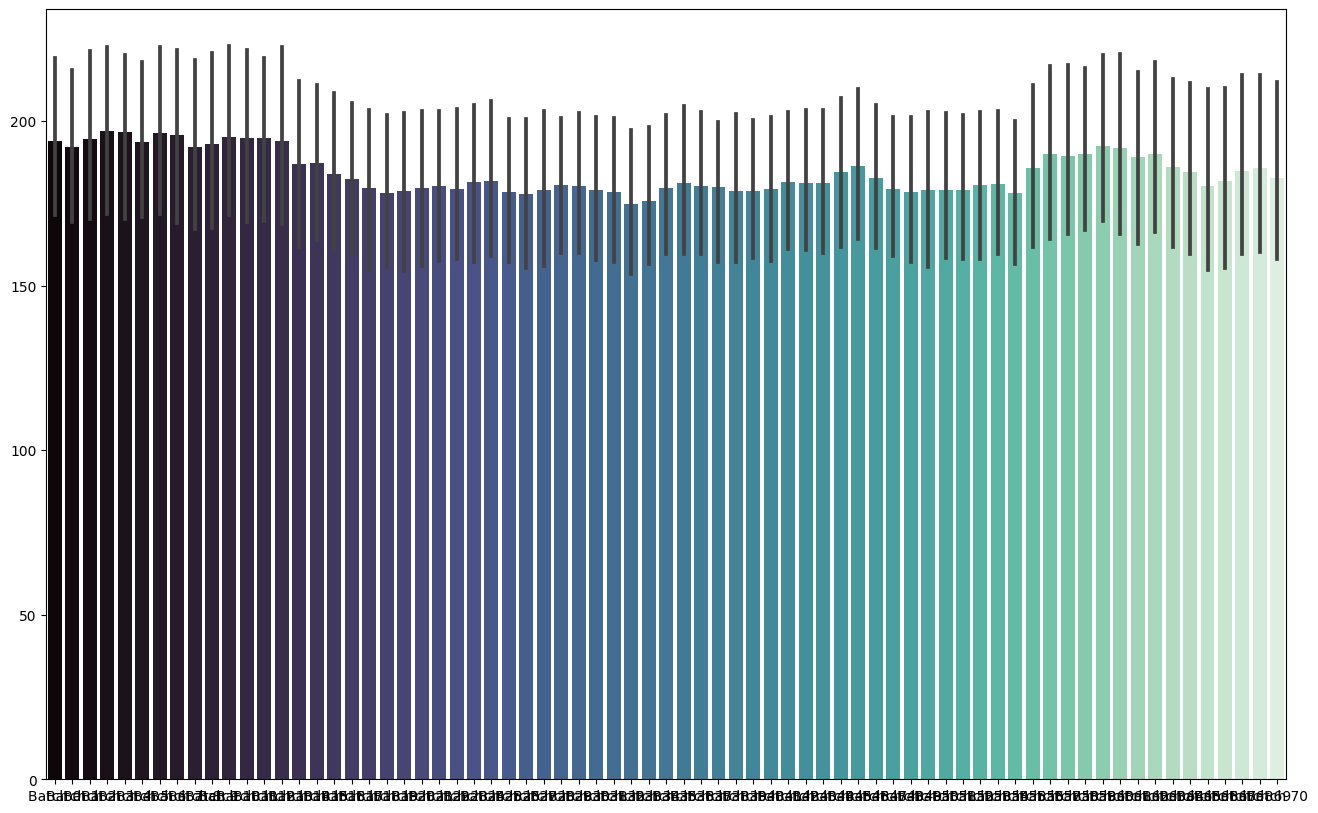

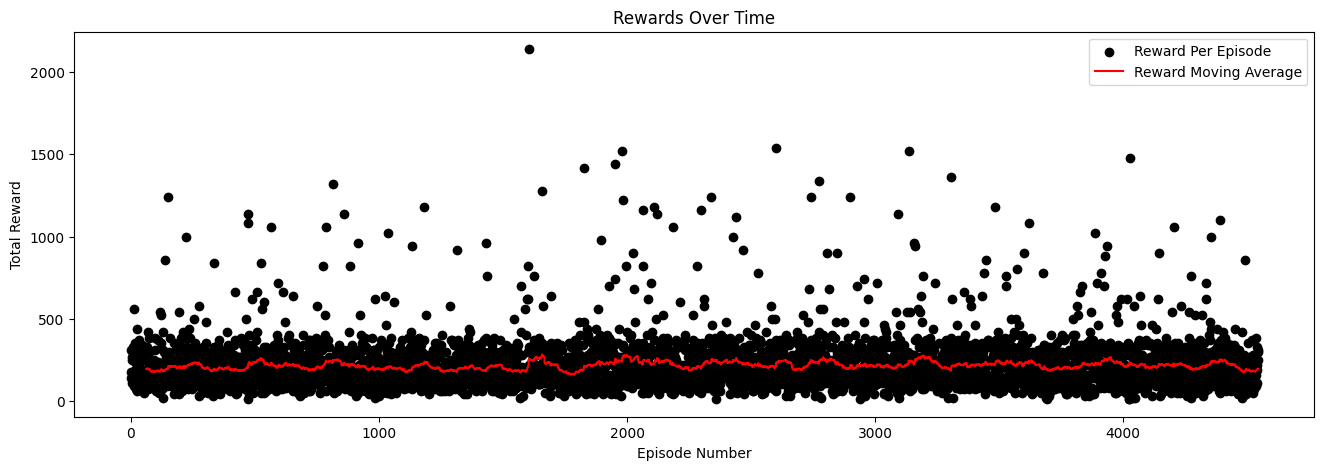

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6219                          
Episode 4544 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
7000                          
7126                          
Episode 4545 of 10240                

500                          
1000                        

2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
6937                          
Episode 4574 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3677                          
Episode 4575 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4059                          
Episode 4576 of 10240                

500                

4500                          
4557                          
Episode 4602 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2895                          
Episode 4603 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4048                          
Episode 4604 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3838                          
Episode 4605 of 10240                

500                          
639                          
Episode 4606 of

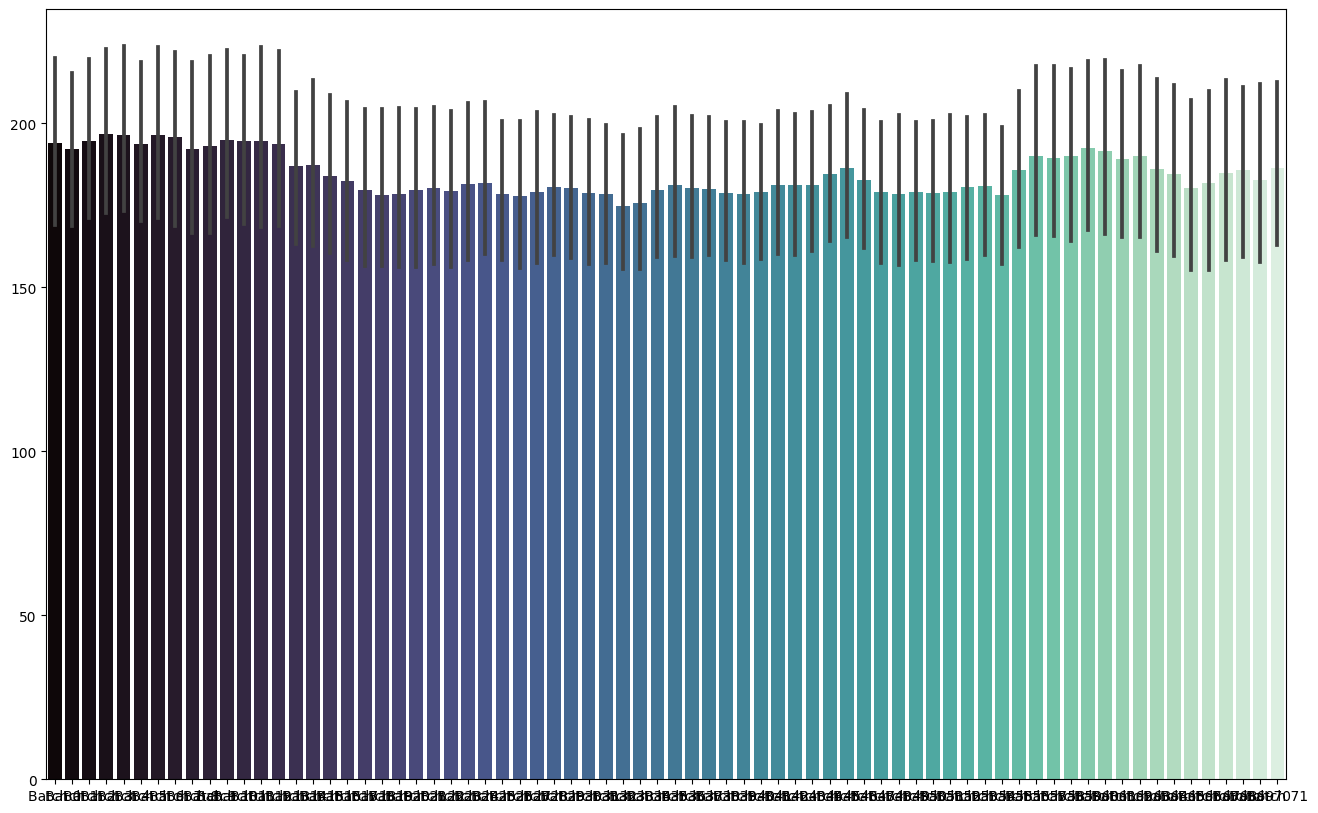

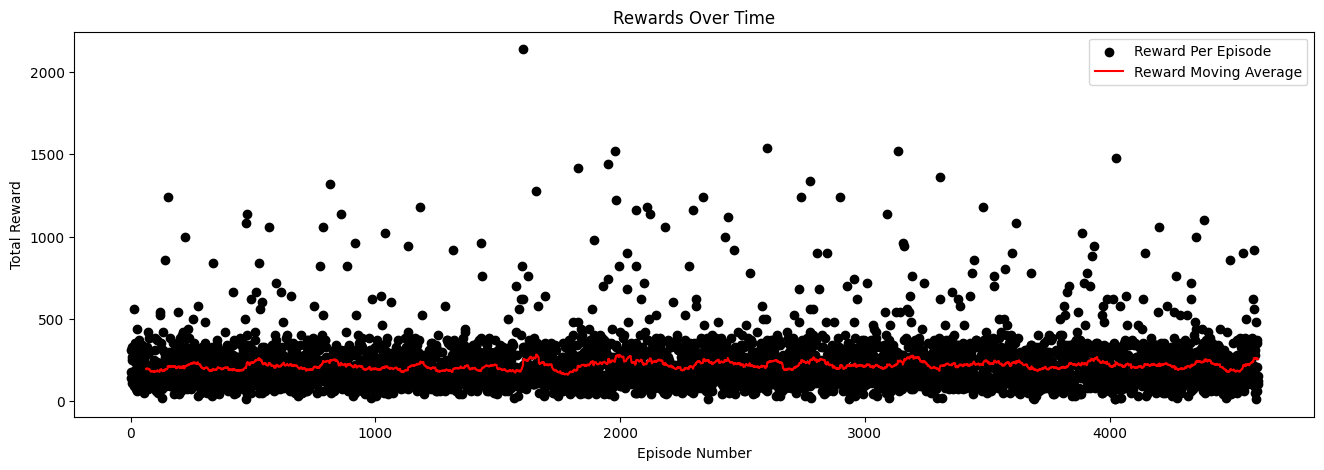

500                          
1000                         
1500                          
1871                          
Episode 4608 of 10240                

500                          
1000                         
1500                          
1530                          
Episode 4609 of 10240                

500                          
1000                         
1018                          
Episode 4610 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3407                          
Episode 4611 of 10240                

500                          
1000                         
1500                          
2000                          
2139                          
Episode 4612 of 10240                

500                          
1000                         
1500                          
2000       

500                          
1000                         
1500                          
1865                          
Episode 4649 of 10240                

500                          
590                          
Episode 4650 of 10240                

500                          
862                          
Episode 4651 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4147                          
Episode 4652 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4934                          
Episode 4653 of 1

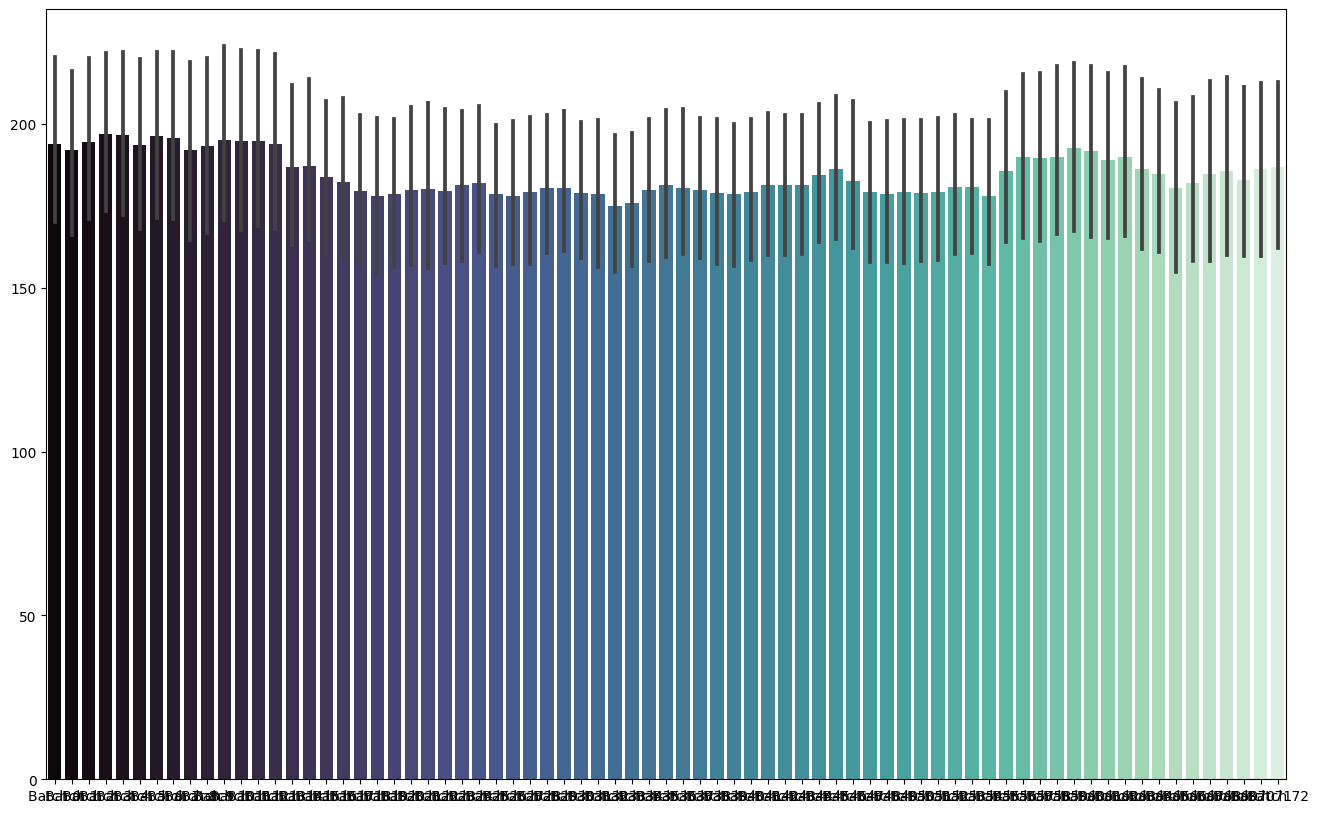

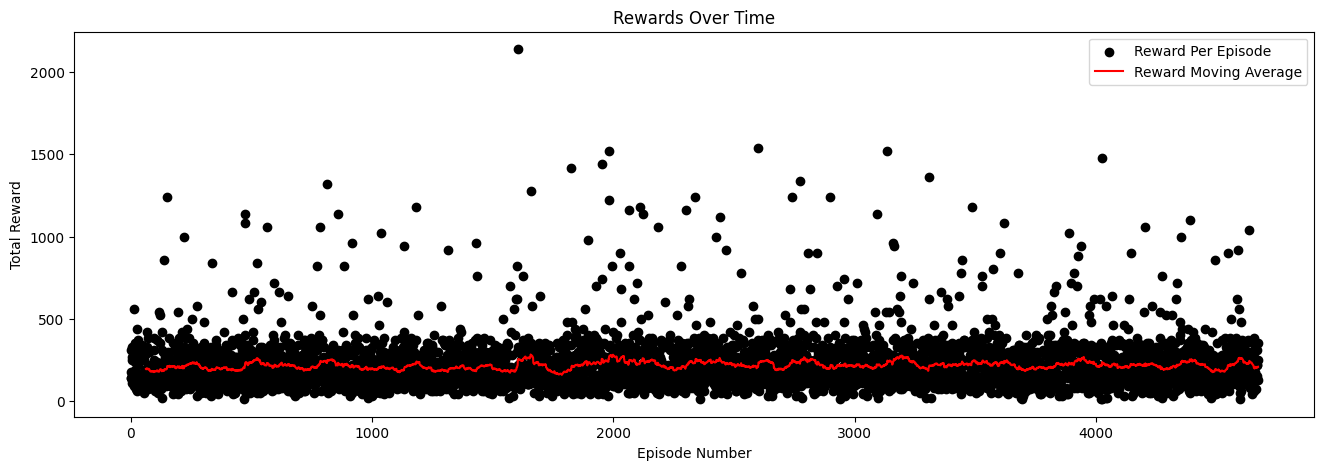

500                          
1000                         
1500                          
2000                          
2500                          
2857                          
Episode 4672 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5083                          
Episode 4673 of 10240                

500                          
1000                         
1086                          
Episode 4674 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2551                          
Episode 4675 of 10240                

500                          
1000            

2500                          
3000                          
3500                          
3592                          
Episode 4710 of 10240                

500                          
595                          
Episode 4711 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
3658                          
Episode 4712 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4202                          
Episode 4713 of 10240                

500                          
1000                         
1500                          
2000                          
2500           

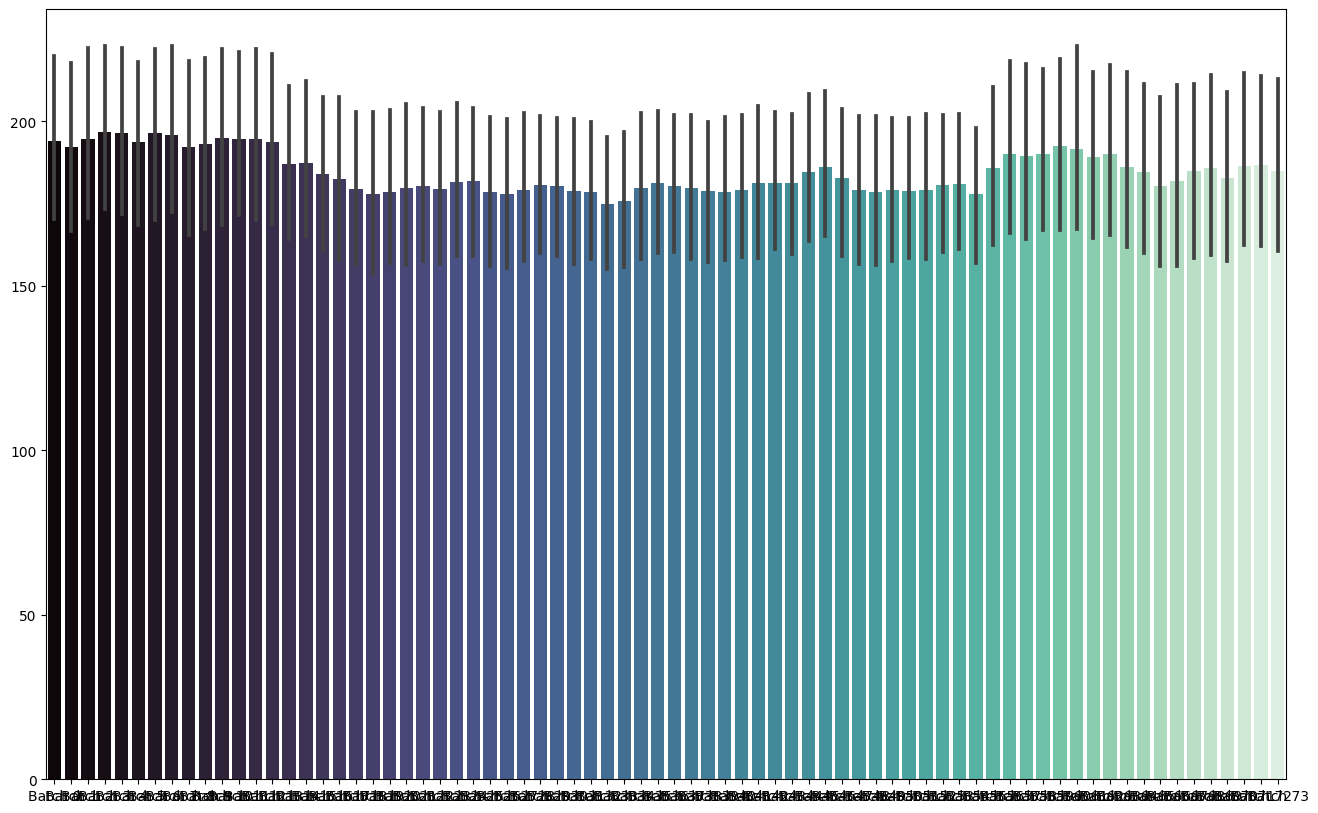

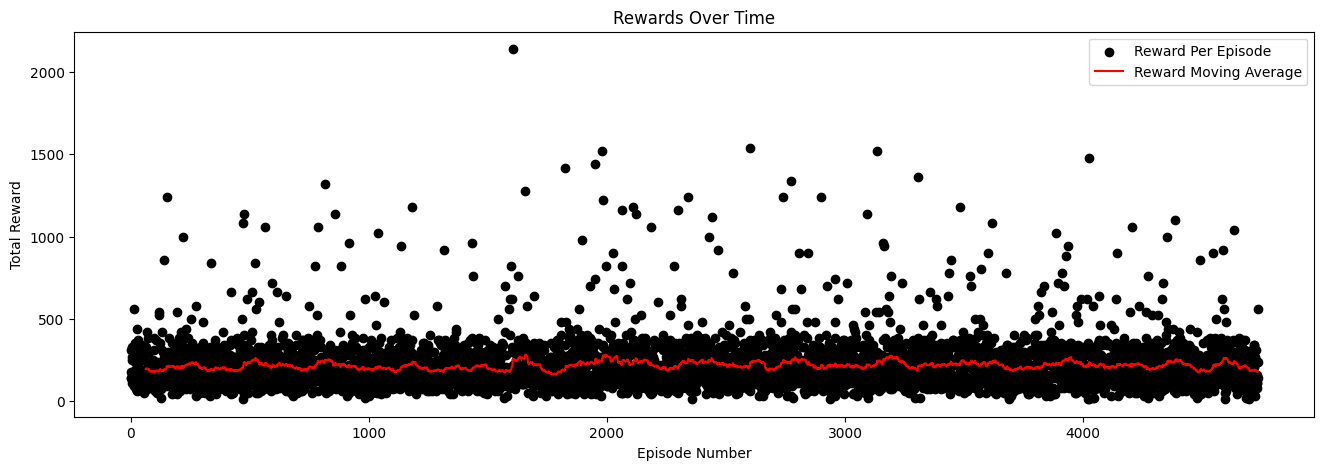

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
6504                          
Episode 4736 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
2737                          
Episode 4737 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                         

1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5297                          
Episode 4765 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4665                          
Episode 4766 of 10240                

500                          
945                          
Episode 4767 of 10240                

500                          
926                          
Episode 4768 of 10240                

500                          
1000                         
1500                          
2000                          
2500           

2000                          
2500                          
2965                          
Episode 4797 of 10240                

447                          
Episode 4798 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5059                          
Episode 4799 of 10240                



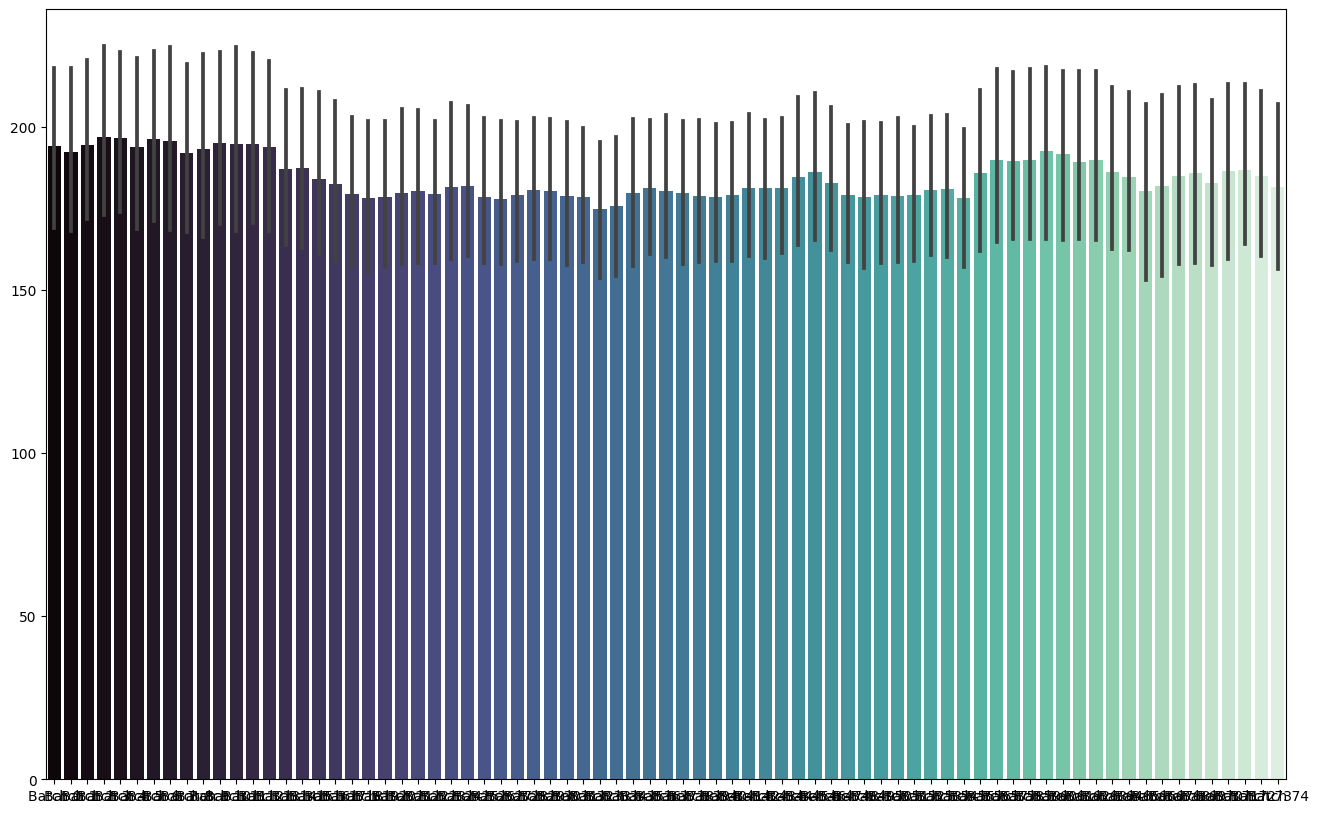

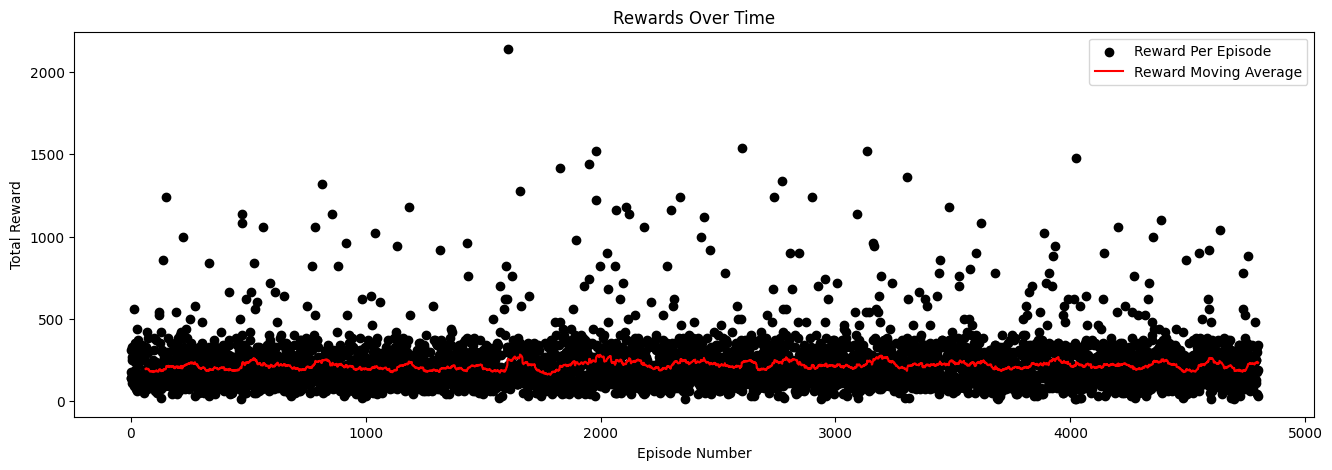

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                          
6500                          
6882                          
Episode 4800 of 10240                

500                          
1000                         
1389                          
Episode 4801 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4829                          
Episode 4802 of 10240                

500                          
1000                  

2500                          
3000                          
3500                          
4000                          
4498                          
Episode 4830 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
4672                          
Episode 4831 of 10240                

500                          
583                          
Episode 4832 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                          
6000                 

5000                          
5500                          
6000                          
6500                          
7000                          
7500                          
8000                          
8490                          
Episode 4859 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5177                          
Episode 4860 of 10240                

500                          
1000                         
1500                          
2000                          
2500                          
3000                          
3500                          
4000                          
4500                          
5000                          
5500                       

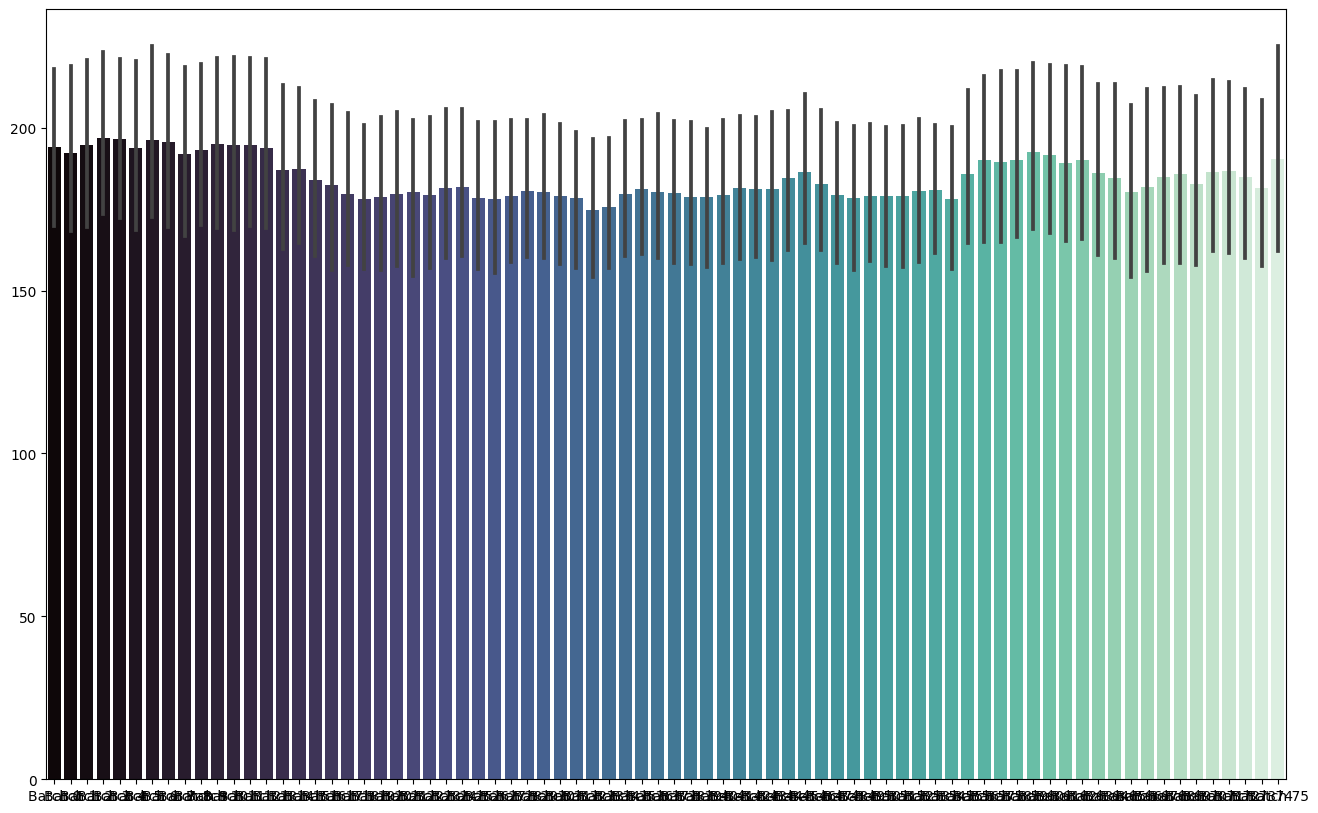

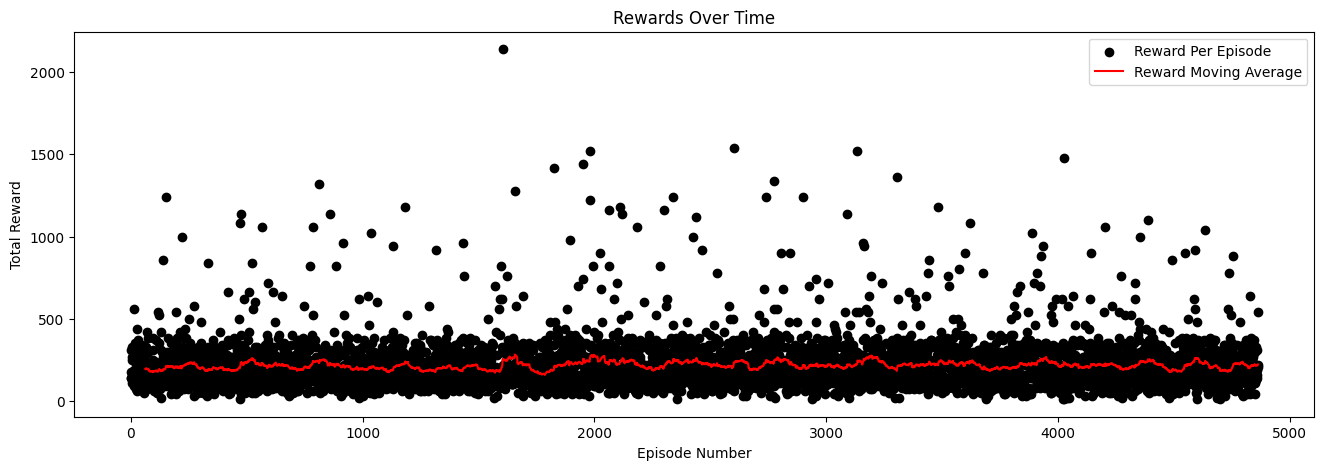

In [ ]:
n_episodes = 2560 * 4
batch_size = 64
print_every = 500
apply_stop = False

prev_x = None # used in computing the difference frame
reward_sum = 0
adj_reward_sum = 0
last_i = 0
env = gym.make(
    'ALE/DemonAttack-v5', # alternate games can be chosen here 
    obs_type='grayscale', # saves RGB preprocessing reduction
    render_mode='human' if render else None, # rendering shows popup but limits training speed
)

if record_actions:
    action_list = list()
if record_rewards:
    reward_list = list()
if record_probs:
    prob_list = list()

episode_number = 0
prev_lives = 0
i = 0
e_ = 0

obs, info = env.reset()
while episode_number <= n_episodes:
    curr_x = model.preprocess(obs)
    x = curr_x - prev_x if prev_x is not None else torch.zeros((1, model.input_dim)).double() # only monitor change between frames
    prev_x = curr_x
    assert x.dim() == 2, x.dim()
    model_probs = model(x)
    i_since_r = i - last_i
    probs, ptruncated = process_probs(model_probs, i_since_r, timer_i=timer_i, corner_correct=corner_correct)
    probs = (probs + torch.tensor([1/len(probs)] * len(probs)) * e_)
    probs = probs / probs.sum()
    
    if record_probs:
        prob_list.append(probs)

    m = torch.distributions.Categorical(probs)
    action = m.sample() 

    log_probs = m.log_prob(action)
    model.log_probss.append(log_probs)
    action = action.item()

    if record_actions or plot_action_every:
        action_list.append(action)

    obs, reward, terminated, truncated, info = env.step(action) # step returns all other relevant information 
    if apply_stop:
        truncated = truncated or ptruncated
    elif i_since_r > 100000:
        truncated = True
    elif i_since_r > dropout_i:
        drop_p = (i_since_r - dropout_i) / dropout_i
        model.drop_p = drop_p if drop_p < .8 else .8
    
    if reward > 0: # reset the iterations since last reward if reward is accrued
        last_i = i
        e_ = 0
    else:
        e_ += .00008
        
    reward_sum += reward # total round reward incremented
    
    adj_reward = modify_reward(action, reward, info, prev_lives, i_since_r, timer_i=timer_i) # adjusted reward may better lead agent toward short term optimums
    prev_lives = info['lives']
    adj_reward_sum += adj_reward
    model.rewards.append(adj_reward)
    ######################################################
    
        
    if terminated: # an episode finished
        if record_rewards:
            reward_list.append(reward_sum)
        print(f'\nEpisode {episode_number} of {n_episodes}                \n\n', end='\r')
        
        episode_number += 1

        # Finish The Episode.save
        model.episode_backward()
                
        # Finish the Batch
        if not no_grad and not episode_number % batch_size:           
            if record_rewards:
                plot_batch_bar(reward_list, batch_size)
                plot_rewards(reward_list, window_size=batch_size)
            model.batch_backward()
            model.save(save_path=save_path)
            
        if plot_action_every and not episode_number % plot_action_every:
            plot_action_counts(action_list)
            action_list.clear()

    elif truncated: # an episode terminated unexpectedly, shouldn't maintain results
        model.episode_losses.clear()
        model.log_probss.clear()
        model.rewards.clear()       
    elif print_every and not i % print_every:
        print(i)
    else:
        print(i, end='                          \r')
        
    if terminated or truncated:
        reward_sum = 0
        adj_reward_sum = 0
        
        obs, info = env.reset()
        prev_x = None
        i = 0
        prev_lives = 3 # for new episode adjustment
        if record_probs:
            plot_probs(prob_list, dpi=80)
            prob_list.clear()
    i += 1

env.close()

In [ ]:
if record_probs:
    plot_probs(prob_list)
if record_rewards:
    plot_rewards(reward_list, window_size=200)